# Compare 202405-2xrez to 202405 Bathymetry

Detailed, tile by tile, comparison of 202405-2xrez and 202405 bathymetries including preliminary river files.
This notebook is used iteratively with the `Process202405-2xrezBathymetry.ipynb` notebook to identify features
in the 2xrez bathymetry that need to be adjusted in the latter notebook.

This notebook is based on the ones that Susan created to do the same thing during the creation of the 202108
bathymetry (which was known as 202103d at the time):
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_andrivers.ipynb`
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_middle.ipynb`
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_upper.ipynb`

The conda environment file for this notebook is `environment-2xrez.yaml`.

In [1]:
from pathlib import Path
import sys

import cmocean.cm as cm
import matplotlib.pyplot as plt
import numpy
import xarray

from salishsea_tools import viz_tools

import matplotlib.colors as matcolors
import matplotlib.cm as cmx

Python and library versions:

In [2]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import netCDF4
import numpy
import pandas
import scipy
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'


## Load Bathymetry Datasets

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")
repos_prefix = repos_prefix if repos_prefix.exists() else Path("/data/dlatorne/MEOPAR/")
# repos_prefix = Path("/home/sallen/MEOPAR/")

In [4]:
bathy_paths = {
    "final_202405": repos_prefix / "grid" / "bathymetry_202405.nc",
    "dbl_202405_base": repos_prefix / "grid" / "bathymetry_double_202405_base.nc",
    "dbl_202405": repos_prefix / "grid" / "bathymetry_double_202405.nc",
}

In [5]:
with xarray.open_dataset(bathy_paths["final_202405"], engine="h5netcdf") as bathy_ds:
    bathy = bathy_ds.Bathymetry
    lons = bathy_ds.nav_lon
    lats = bathy_ds.nav_lat

with xarray.open_dataset(bathy_paths["dbl_202405_base"], engine="h5netcdf") as dbl_bathy_base_ds:
    dbl_bathy_base_unmasked = dbl_bathy_base_ds.Bathymetry
    dbl_bathy_base = dbl_bathy_base_unmasked.where(dbl_bathy_base_unmasked != 0, numpy.nan)
    lons_dbl = dbl_bathy_base_ds.nav_lon
    lats_dbl = dbl_bathy_base_ds.nav_lat

with xarray.open_dataset(bathy_paths["dbl_202405"], engine="h5netcdf") as dbl_bathy_ds:
    dbl_bathy = dbl_bathy_ds.Bathymetry

Calculate expanded `lons` and `lats` arrays by extrapolating values on south and east edges.
This provides arrays that `pcoulormesh()` interprets as cell edges so that it doesn't a
`UserWarning` about the non-montonic lon/lat values that arise due to the rotated grid.
This code is based on Michael's `expandf()` function in
https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathy_helpers.py

In [6]:
lons_e = numpy.zeros((lons.shape[0]+1, lons.shape[1]+1))
lons_e[1:, 1:] = lons
lons_e[0, 1:] = lons[0, :] - (lons[1, :] - lons[0, :])
lons_e[:, 0] = lons_e[:, 1] - (lons_e[:, 2] - lons_e[:, 1])

lats_e = numpy.zeros((lats.shape[0]+1, lats.shape[1]+1))
lats_e[1:, 1:] = lats
lats_e[0, 1:] = lats[0, :] - (lats[1, :] - lats[0, :])
lats_e[:, 0] = lats_e[:, 1] - (lats_e[:, 2] - lats_e[:, 1])

lons_dbl_e = numpy.zeros((lons_dbl.shape[0]+1, lons_dbl.shape[1]+1))
lons_dbl_e[1:, 1:] = lons_dbl
lons_dbl_e[0, 1:] = lons_dbl[0, :] - (lons_dbl[1, :] - lons_dbl[0, :])
lons_dbl_e[:, 0] = lons_dbl_e[:, 1] - (lons_dbl_e[:, 2] - lons_dbl_e[:, 1])

lats_dbl_e = numpy.zeros((lats_dbl.shape[0]+1, lats_dbl.shape[1]+1))
lats_dbl_e[1:, 1:] = lats_dbl
lats_dbl_e[0, 1:] = lats_dbl[0, :] - (lats_dbl[1, :] - lats_dbl[0, :])
lats_dbl_e[:, 0] = lats_dbl_e[:, 1] - (lats_dbl_e[:, 2] - lats_dbl_e[:, 1])


## Tile Plotting Function and x-index Array

In [7]:
def plot_tile(x_min_max, y_slices, bathy, dbl_bathy_base, dbl_bathy=None):
    x_slices = {
        "sgl": slice(*x_min_max),
        "dbl": slice(*x_min_max * 2),
    }
    if dbl_bathy is None:
        fig, axs = plt.subplots(2, 2, figsize=(24, 12))
        ((ax_sgl, ax_dbl_base), (ax_sgl_map, ax_dbl_base_map)) = axs
    else:
        fig, axs = plt.subplots(2, 3, figsize=(36, 18))
        ((ax_sgl, ax_dbl_base, ax_dbl), (ax_sgl_map, ax_dbl_base_map, ax_dbl_map)) = axs

    # use spectral colour map to provide lots of contrast between grid cells
    cmap = "nipy_spectral"

    # single resolution bathymetry
    # grid index coordinates
    bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]).plot(ax=ax_sgl, cmap=cmap, vmax=15)
    viz_tools.set_aspect(ax_sgl)
    ax_sgl.set_title("bathymetry_202405")
    # lon/lat coordinates
    tile_lons = lons_e[y_slices["sgl"], x_slices["sgl"]]
    tile_lats = lats_e[y_slices["sgl"], x_slices["sgl"]]
    ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
    viz_tools.set_aspect(ax_sgl_map, coords="map")

    # double resolution base bathymetry
    # grid index coordinates
    dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]).plot(ax=ax_dbl_base, cmap=cmap, vmax=15)
    viz_tools.set_aspect(ax_dbl_base)
    ax_dbl_base.set_title("bathymetry_double_202405_base")
    # lon/lat coordinates
    tile_lons = lons_dbl_e[y_slices["dbl"], x_slices["dbl"]]
    tile_lats = lats_dbl_e[y_slices["dbl"], x_slices["dbl"]]
    ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)
    viz_tools.set_aspect(ax_dbl_base_map, coords="map")
    ax_dbl_base_map.grid(True)

    if dbl_bathy is not None:
        # final double resolution bathymetry
        # useful to show the effect of adjustments made in the Process202405-2xrezBathymetnry.ipynb notebook as we iterate
        # grid index coordintes
        dbl_bathy.isel(y=y_slices["dbl"], x=x_slices["dbl"]).plot(ax=ax_dbl, cmap=cmap, vmax=15)
        viz_tools.set_aspect(ax_dbl)
        ax_dbl.set_title("bathymetry_double_202405")
        # lon/lat coordinates
        ax_dbl_map.pcolormesh(tile_lons, tile_lats, dbl_bathy.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)
        viz_tools.set_aspect(ax_dbl_map, coords="map")
    fig.tight_layout()
    return fig, axs


In [8]:
tile_x_min_max = [
    numpy.array([0, 35]),
    numpy.array([30, 65]),
    numpy.array([60, 95]),
    numpy.array([90, 125]),
    numpy.array([120, 155]),
    numpy.array([150, 185]),
    numpy.array([180, 215]),
    numpy.array([210, 245]),
    numpy.array([240, 275]),
    numpy.array([270, 305]),
    numpy.array([300, 335]),
    numpy.array([330, 365]),
    numpy.array([360, 398]),
]

## Row 0 - South end of Puget Sound

In [9]:
y_min_max = numpy.array([0, 30])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 0, 0

* all land

### Tile 0, 1

* all land

### Tile 0, 2

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

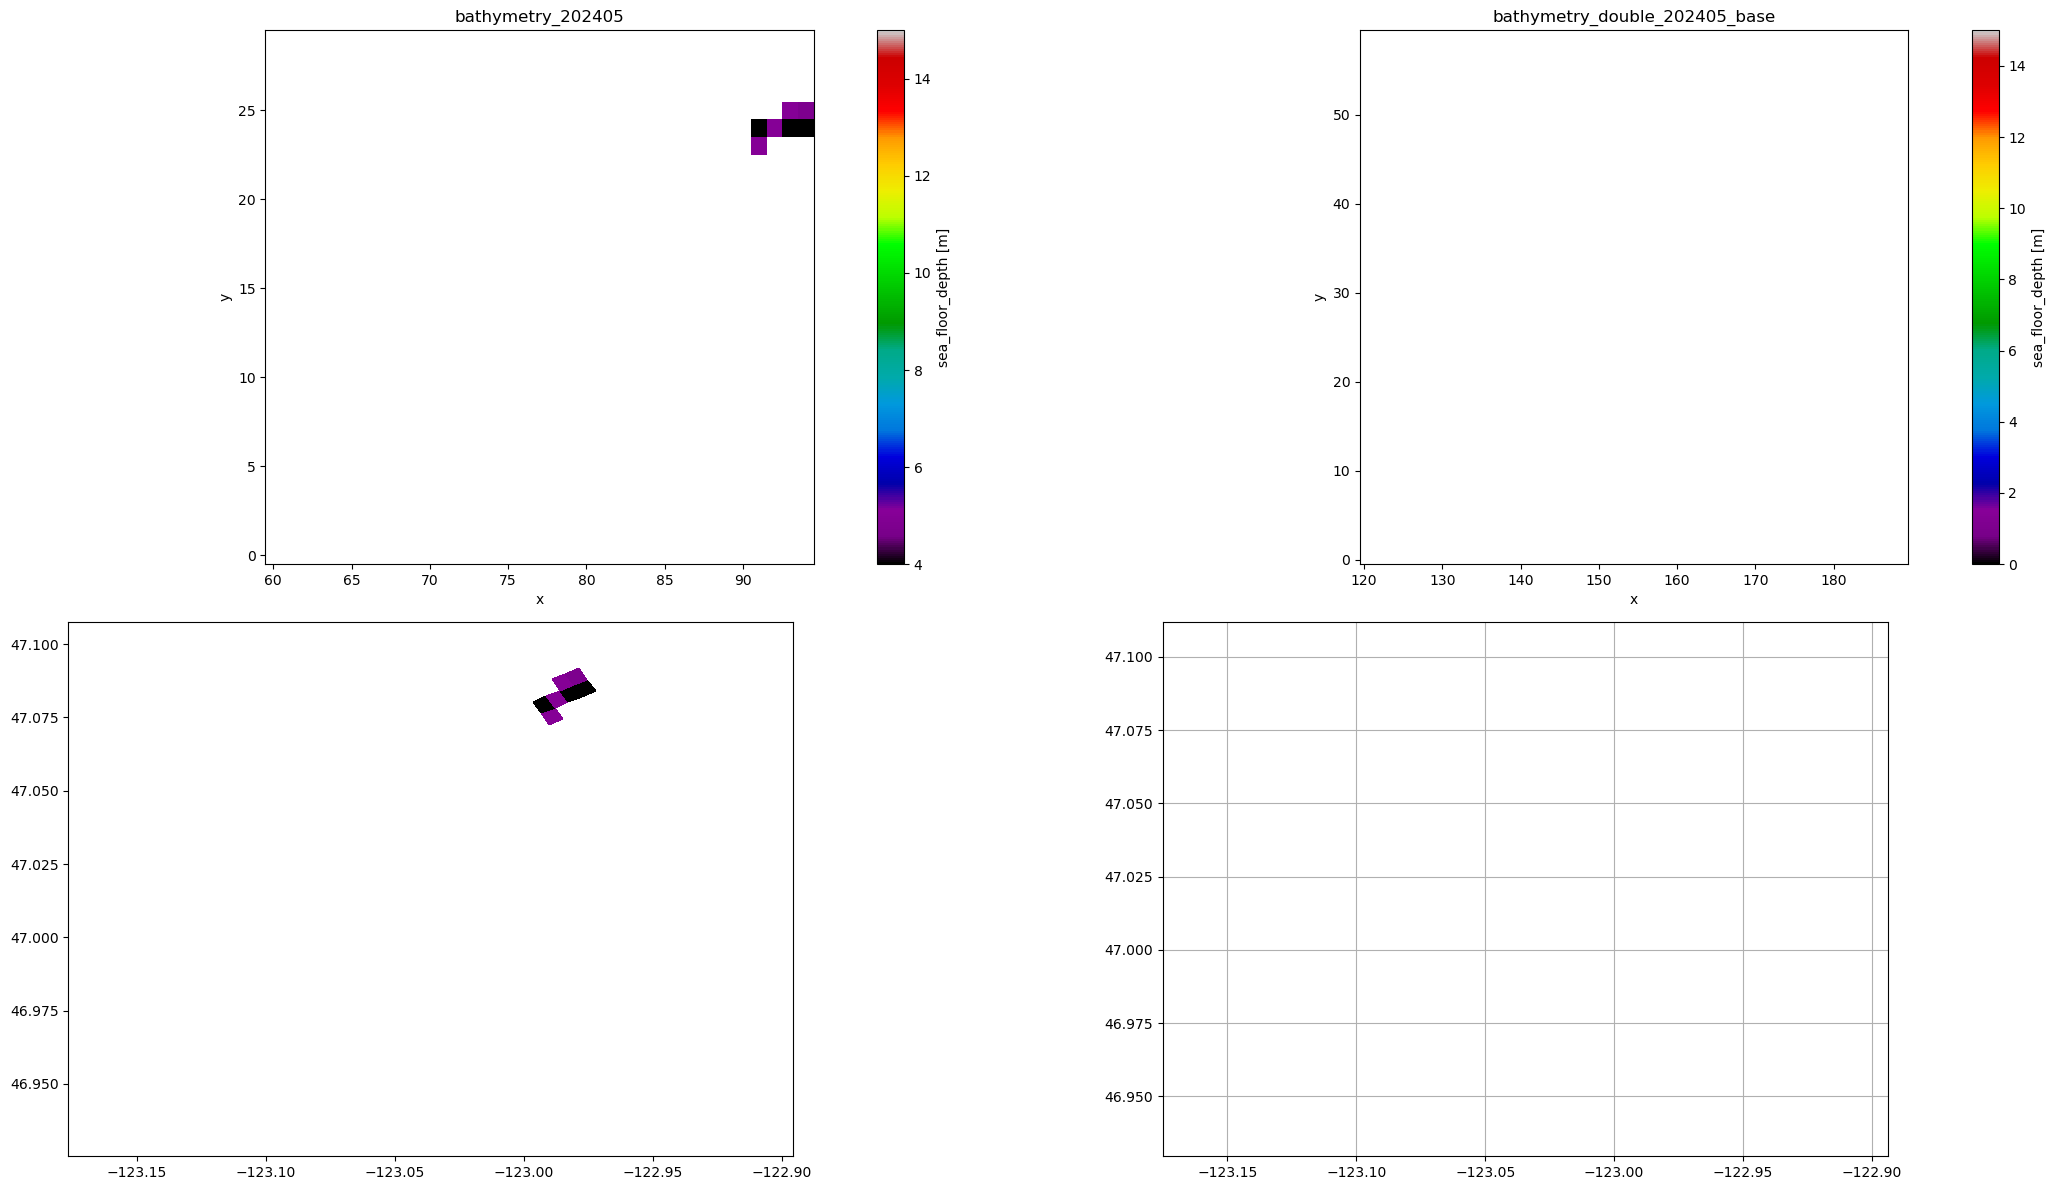

In [10]:
plot_tile(tile_x_min_max[2], y_slices, bathy, dbl_bathy_base)

### Tile 0, 3

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

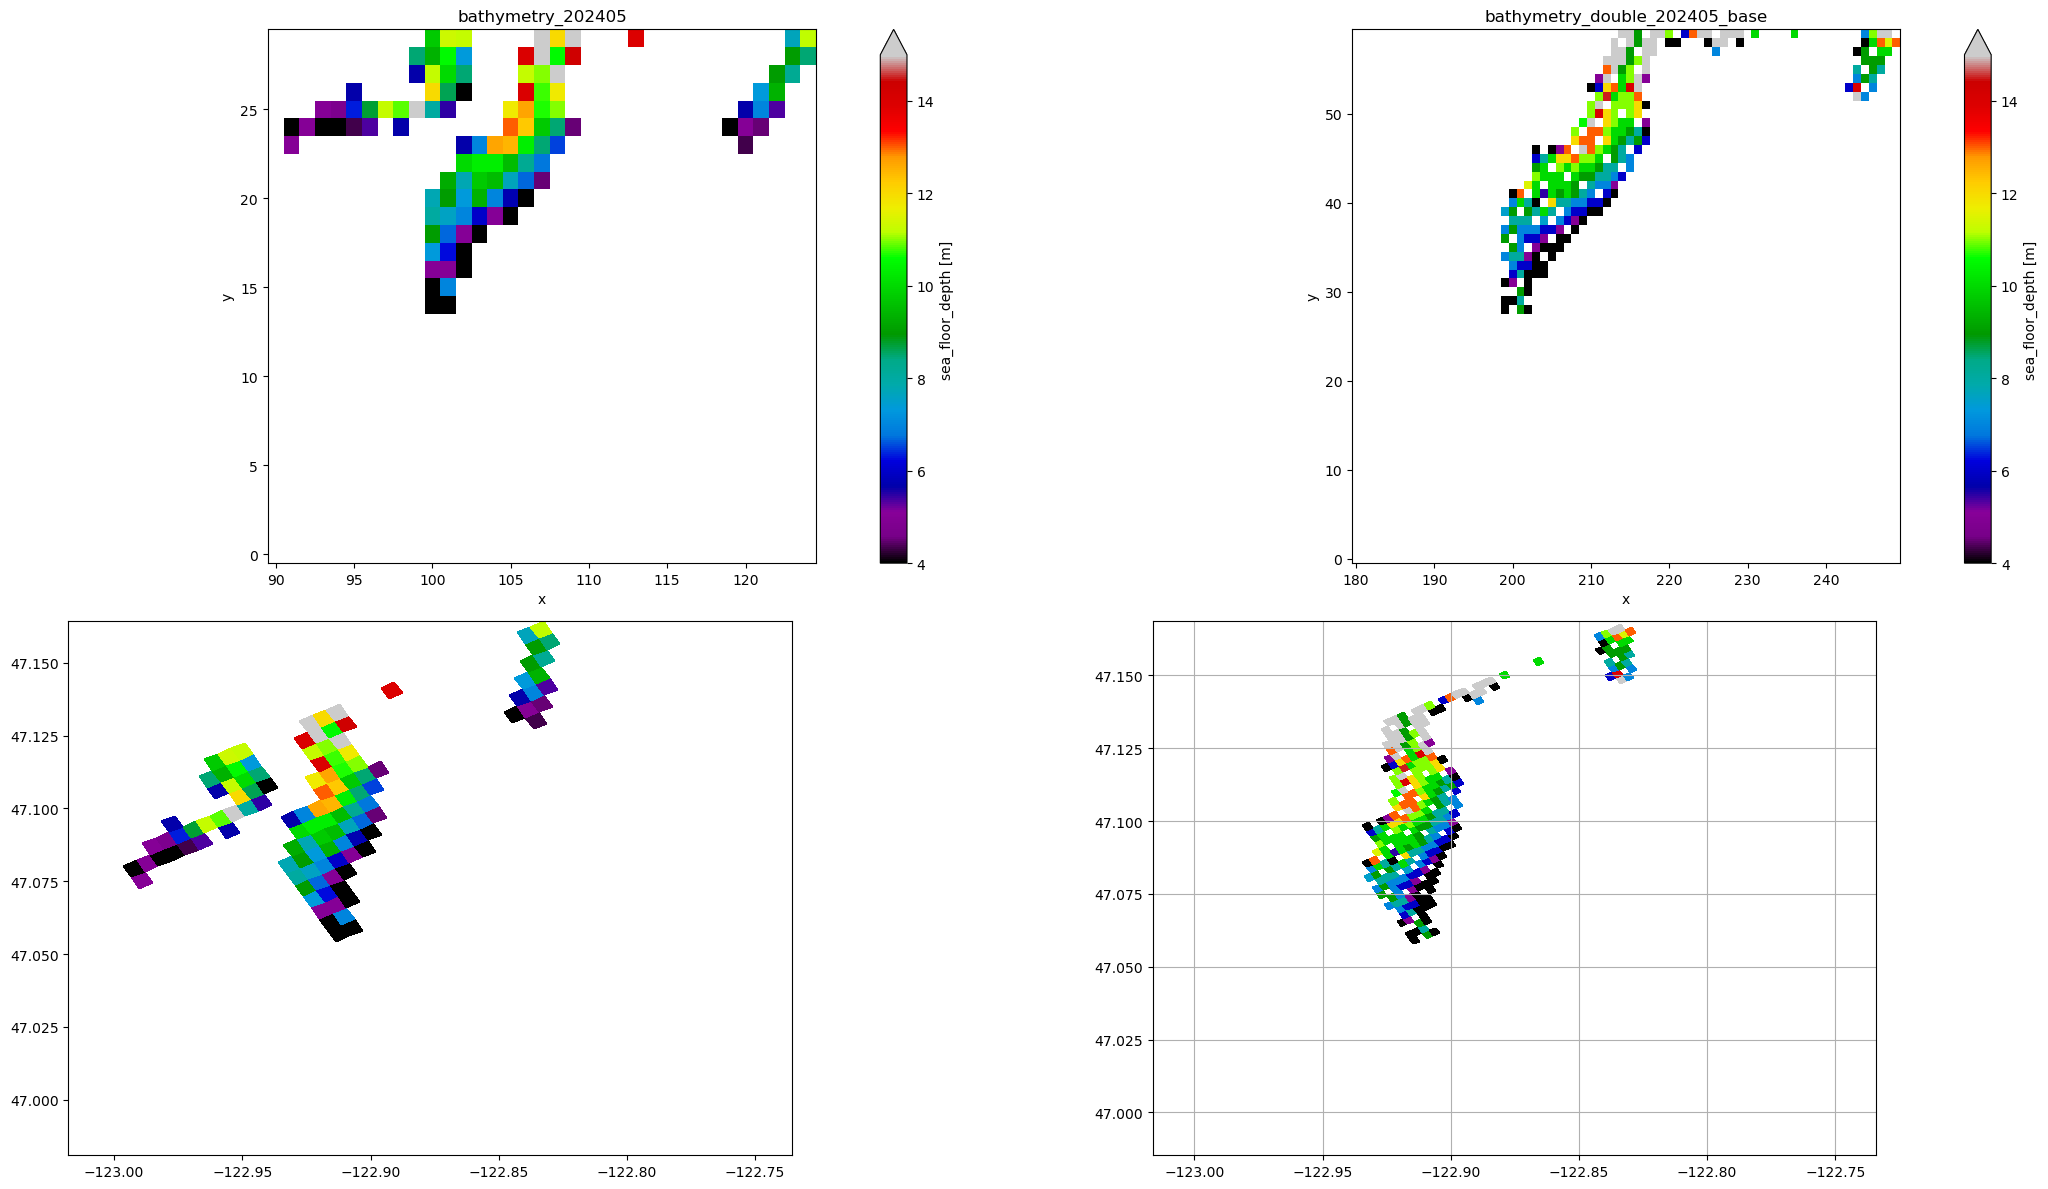

In [11]:
plot_tile(tile_x_min_max[3], y_slices, bathy, dbl_bathy_base)

Puget Sound has problems.
At the very least, the stippling has to be resolved.

So, let's skip farther north...

## Row 9 - Juan de Fuca Strait to Bellingham Bay

In [12]:
y_min_max = numpy.array([300, 330])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 9, 0

* all land


### Tile 9, 1

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

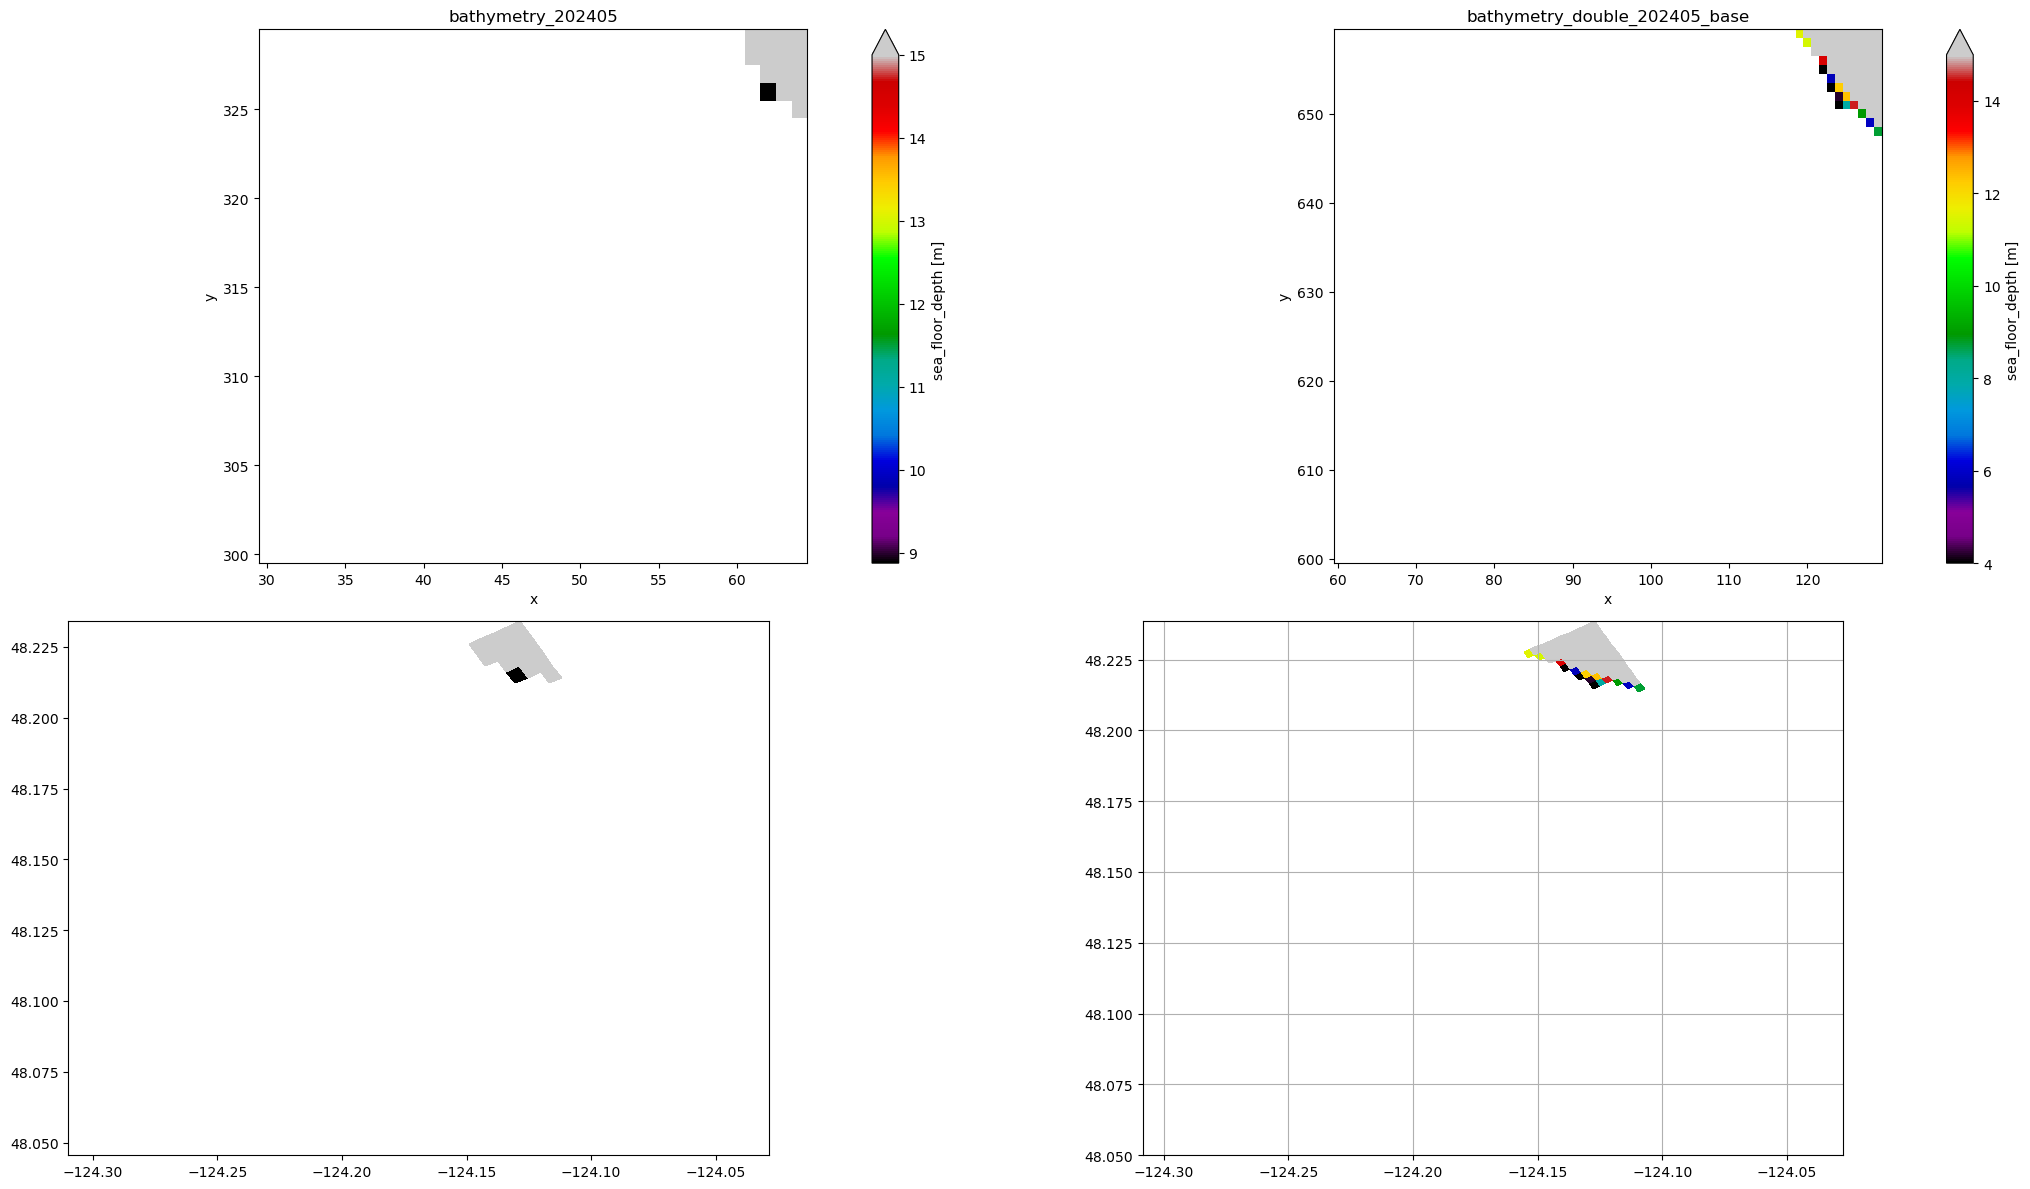

In [13]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 9, 2 - Pysht

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

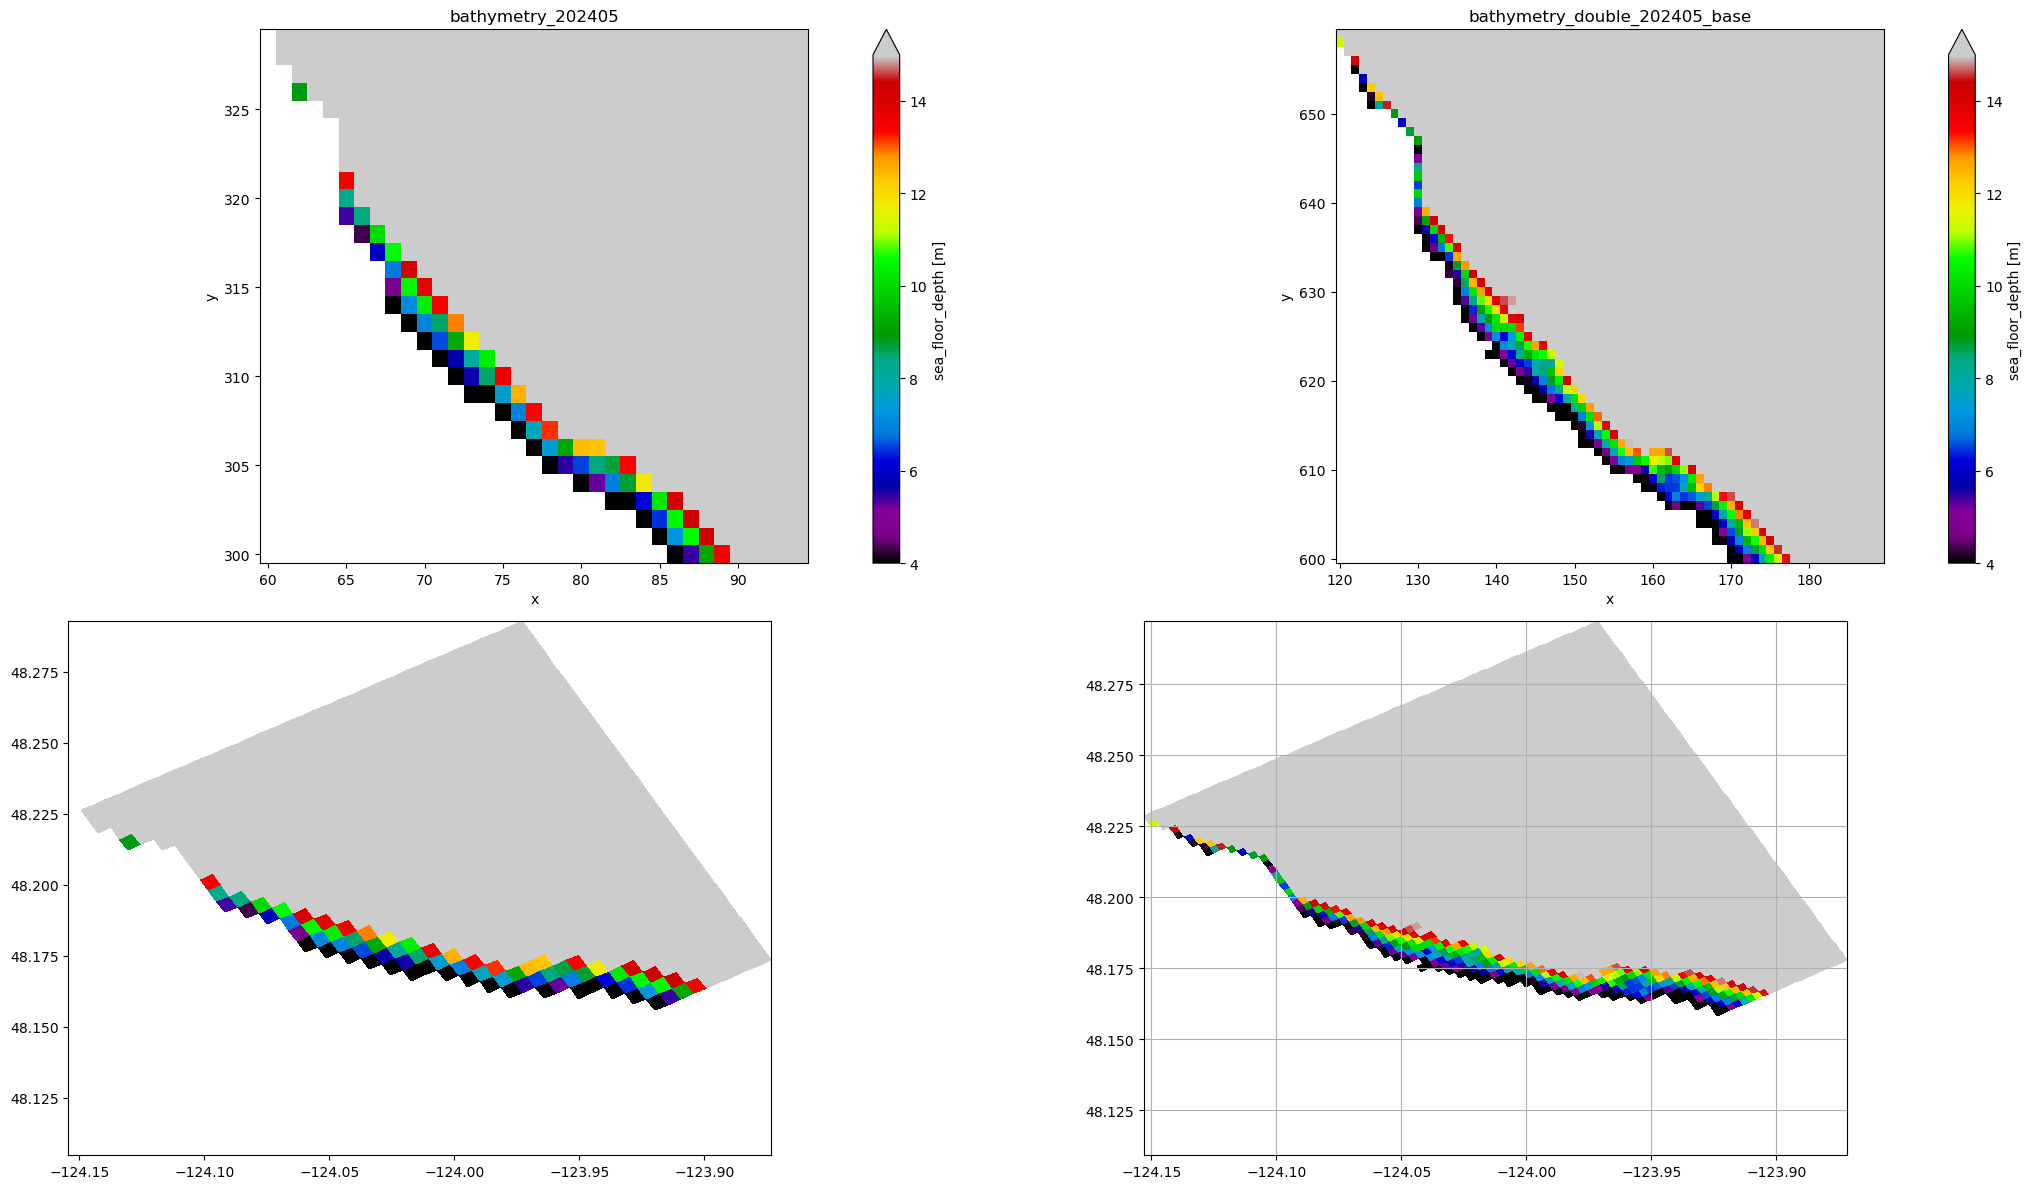

In [14]:
plot_tile(tile_x_min_max[2], y_slices, bathy, dbl_bathy_base)

### Tile 9, 3

* all >15m deep

### Tile 9, 4 - Sooke Harbour

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

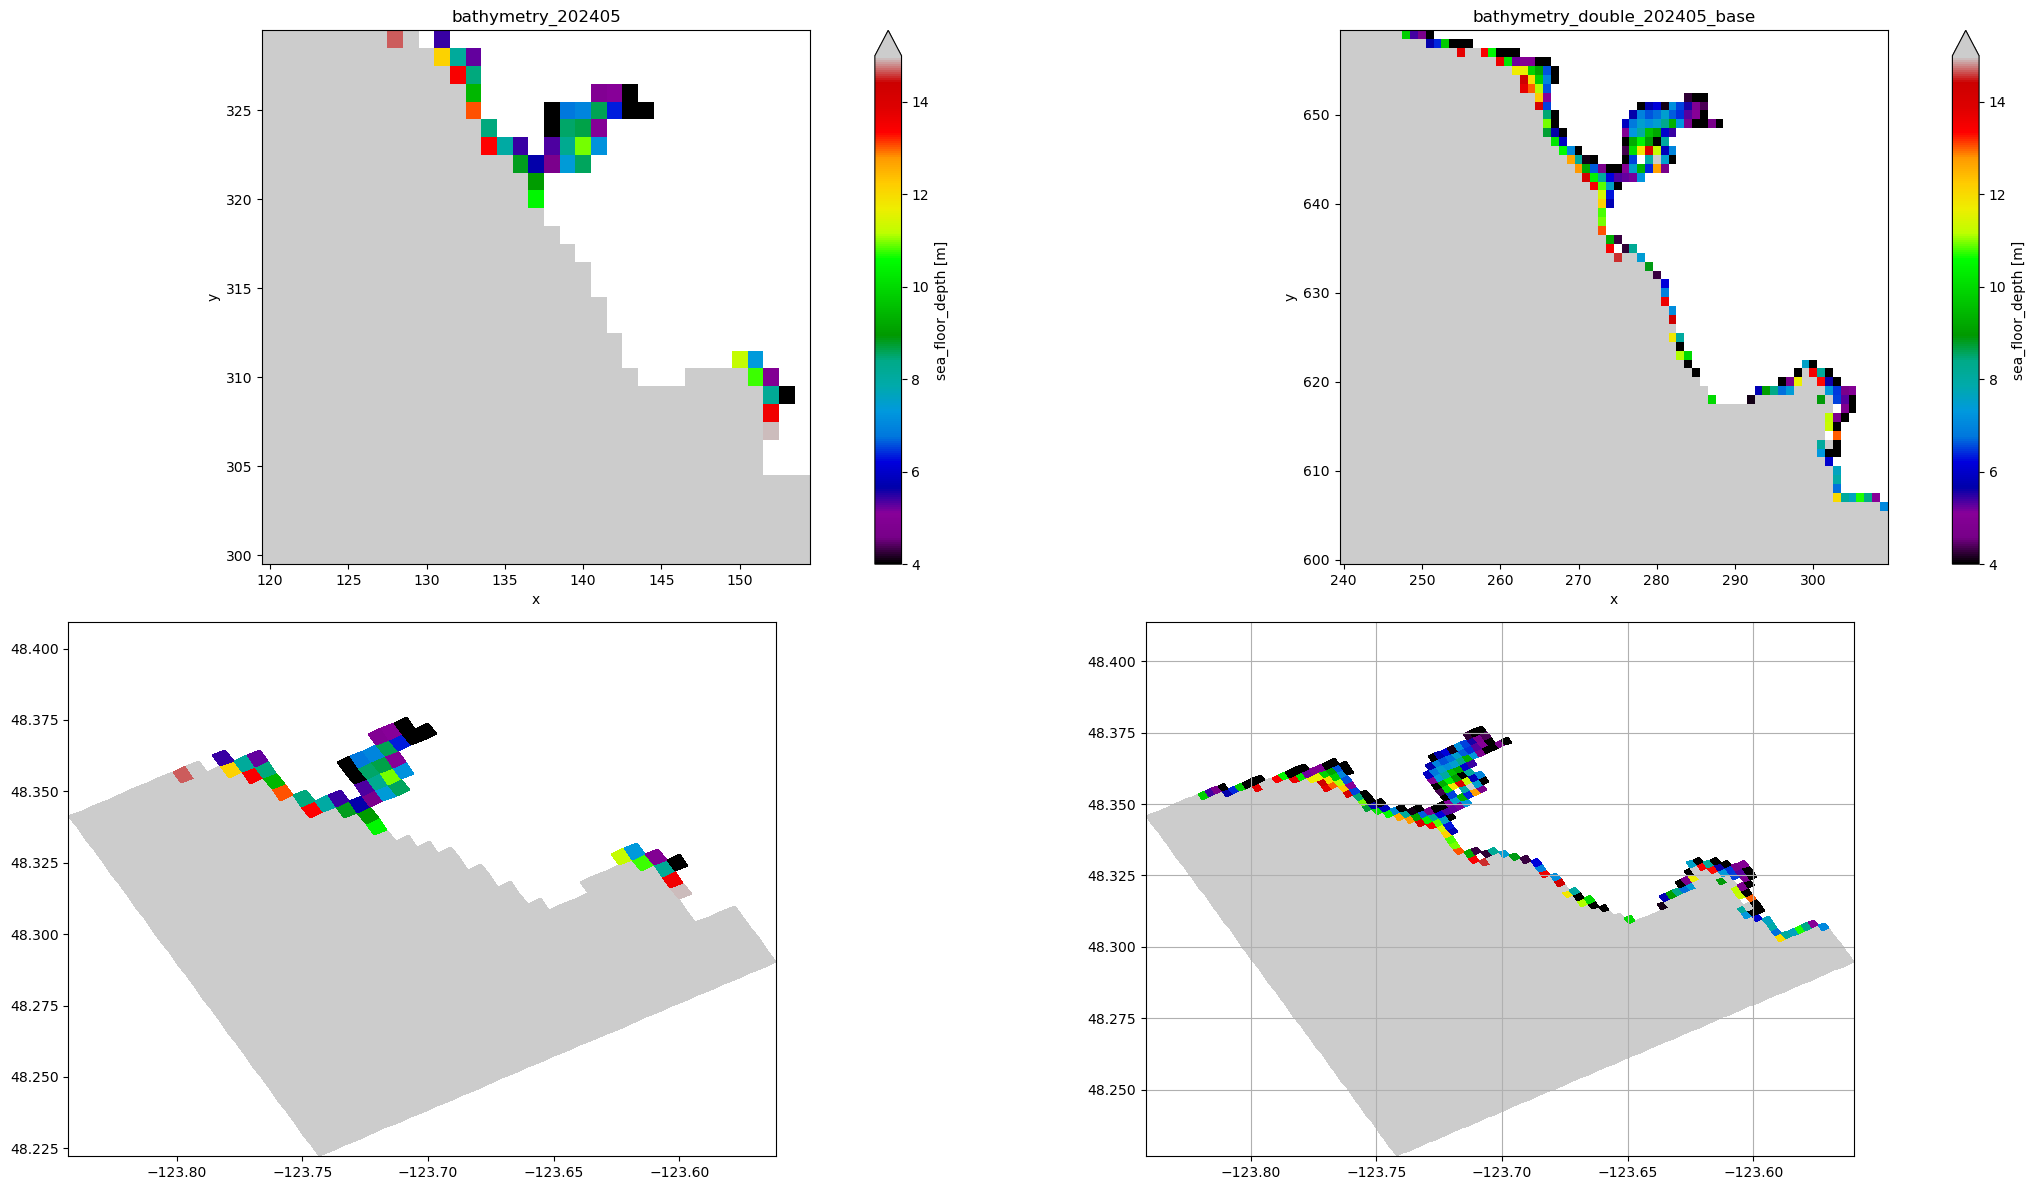

In [15]:
plot_tile(tile_x_min_max[4], y_slices, bathy, dbl_bathy_base)

### Tile 9, 5 - Metchosin

* connect island that is really end of William Head

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

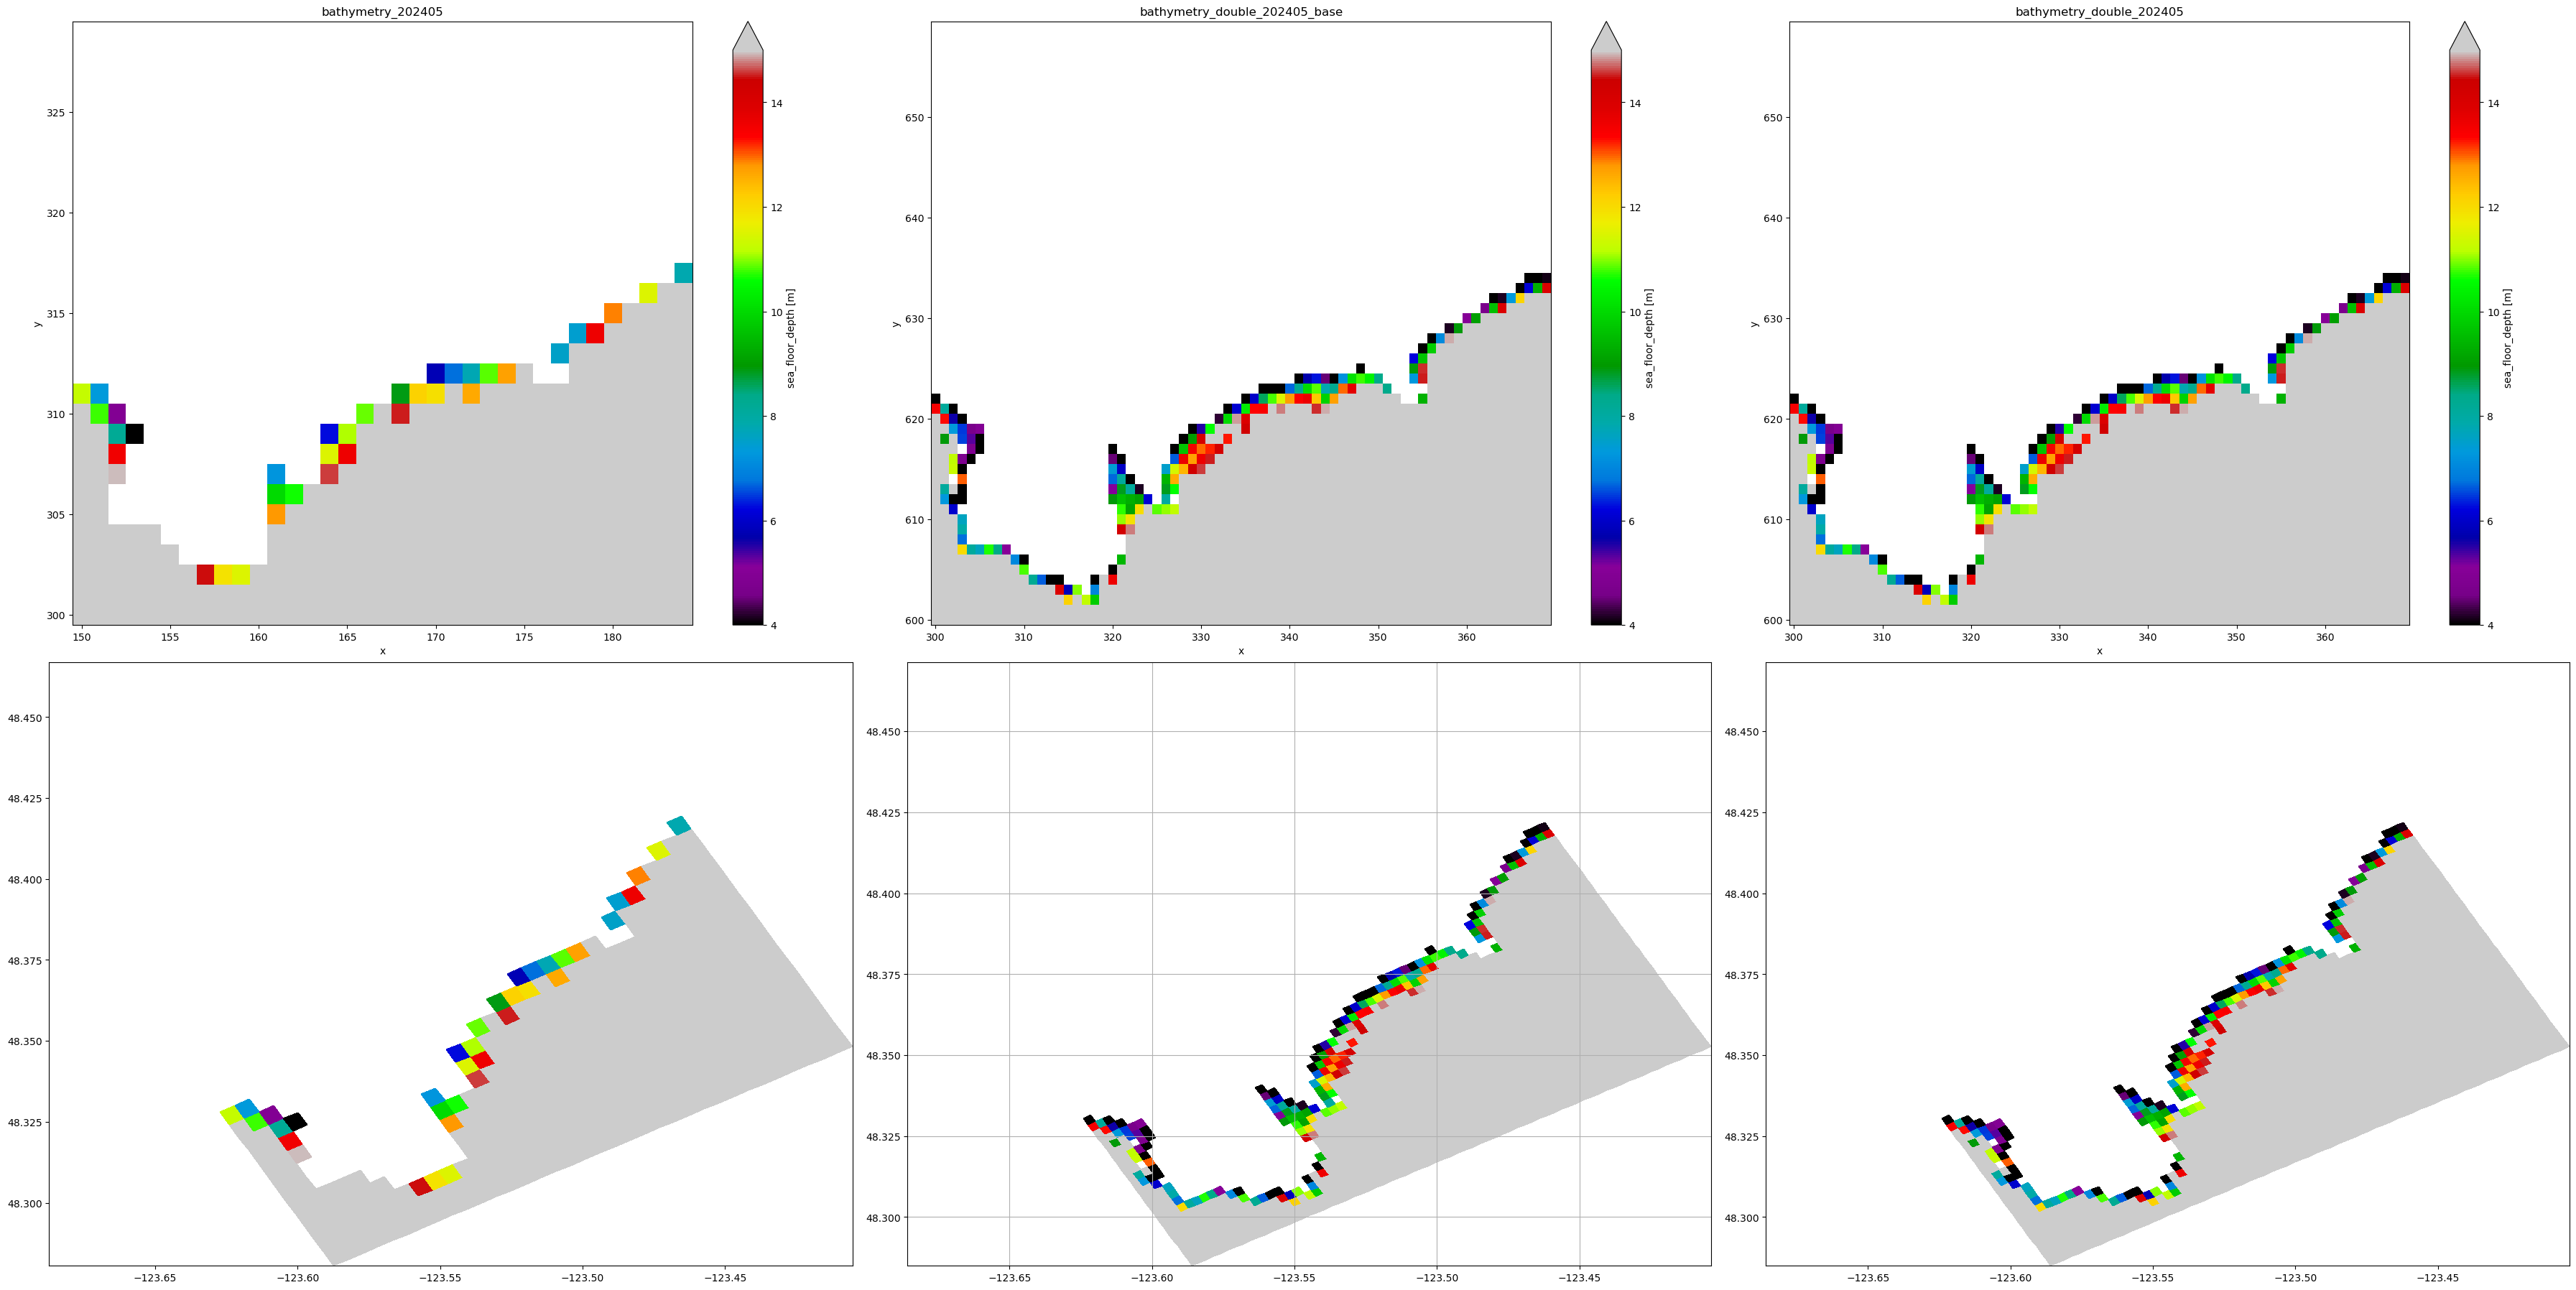

In [16]:
plot_tile(tile_x_min_max[5], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 9, 6 - Esquimalt and Victoria

* connect islands to make Esquimalt Point
* surface Chain Islands?

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

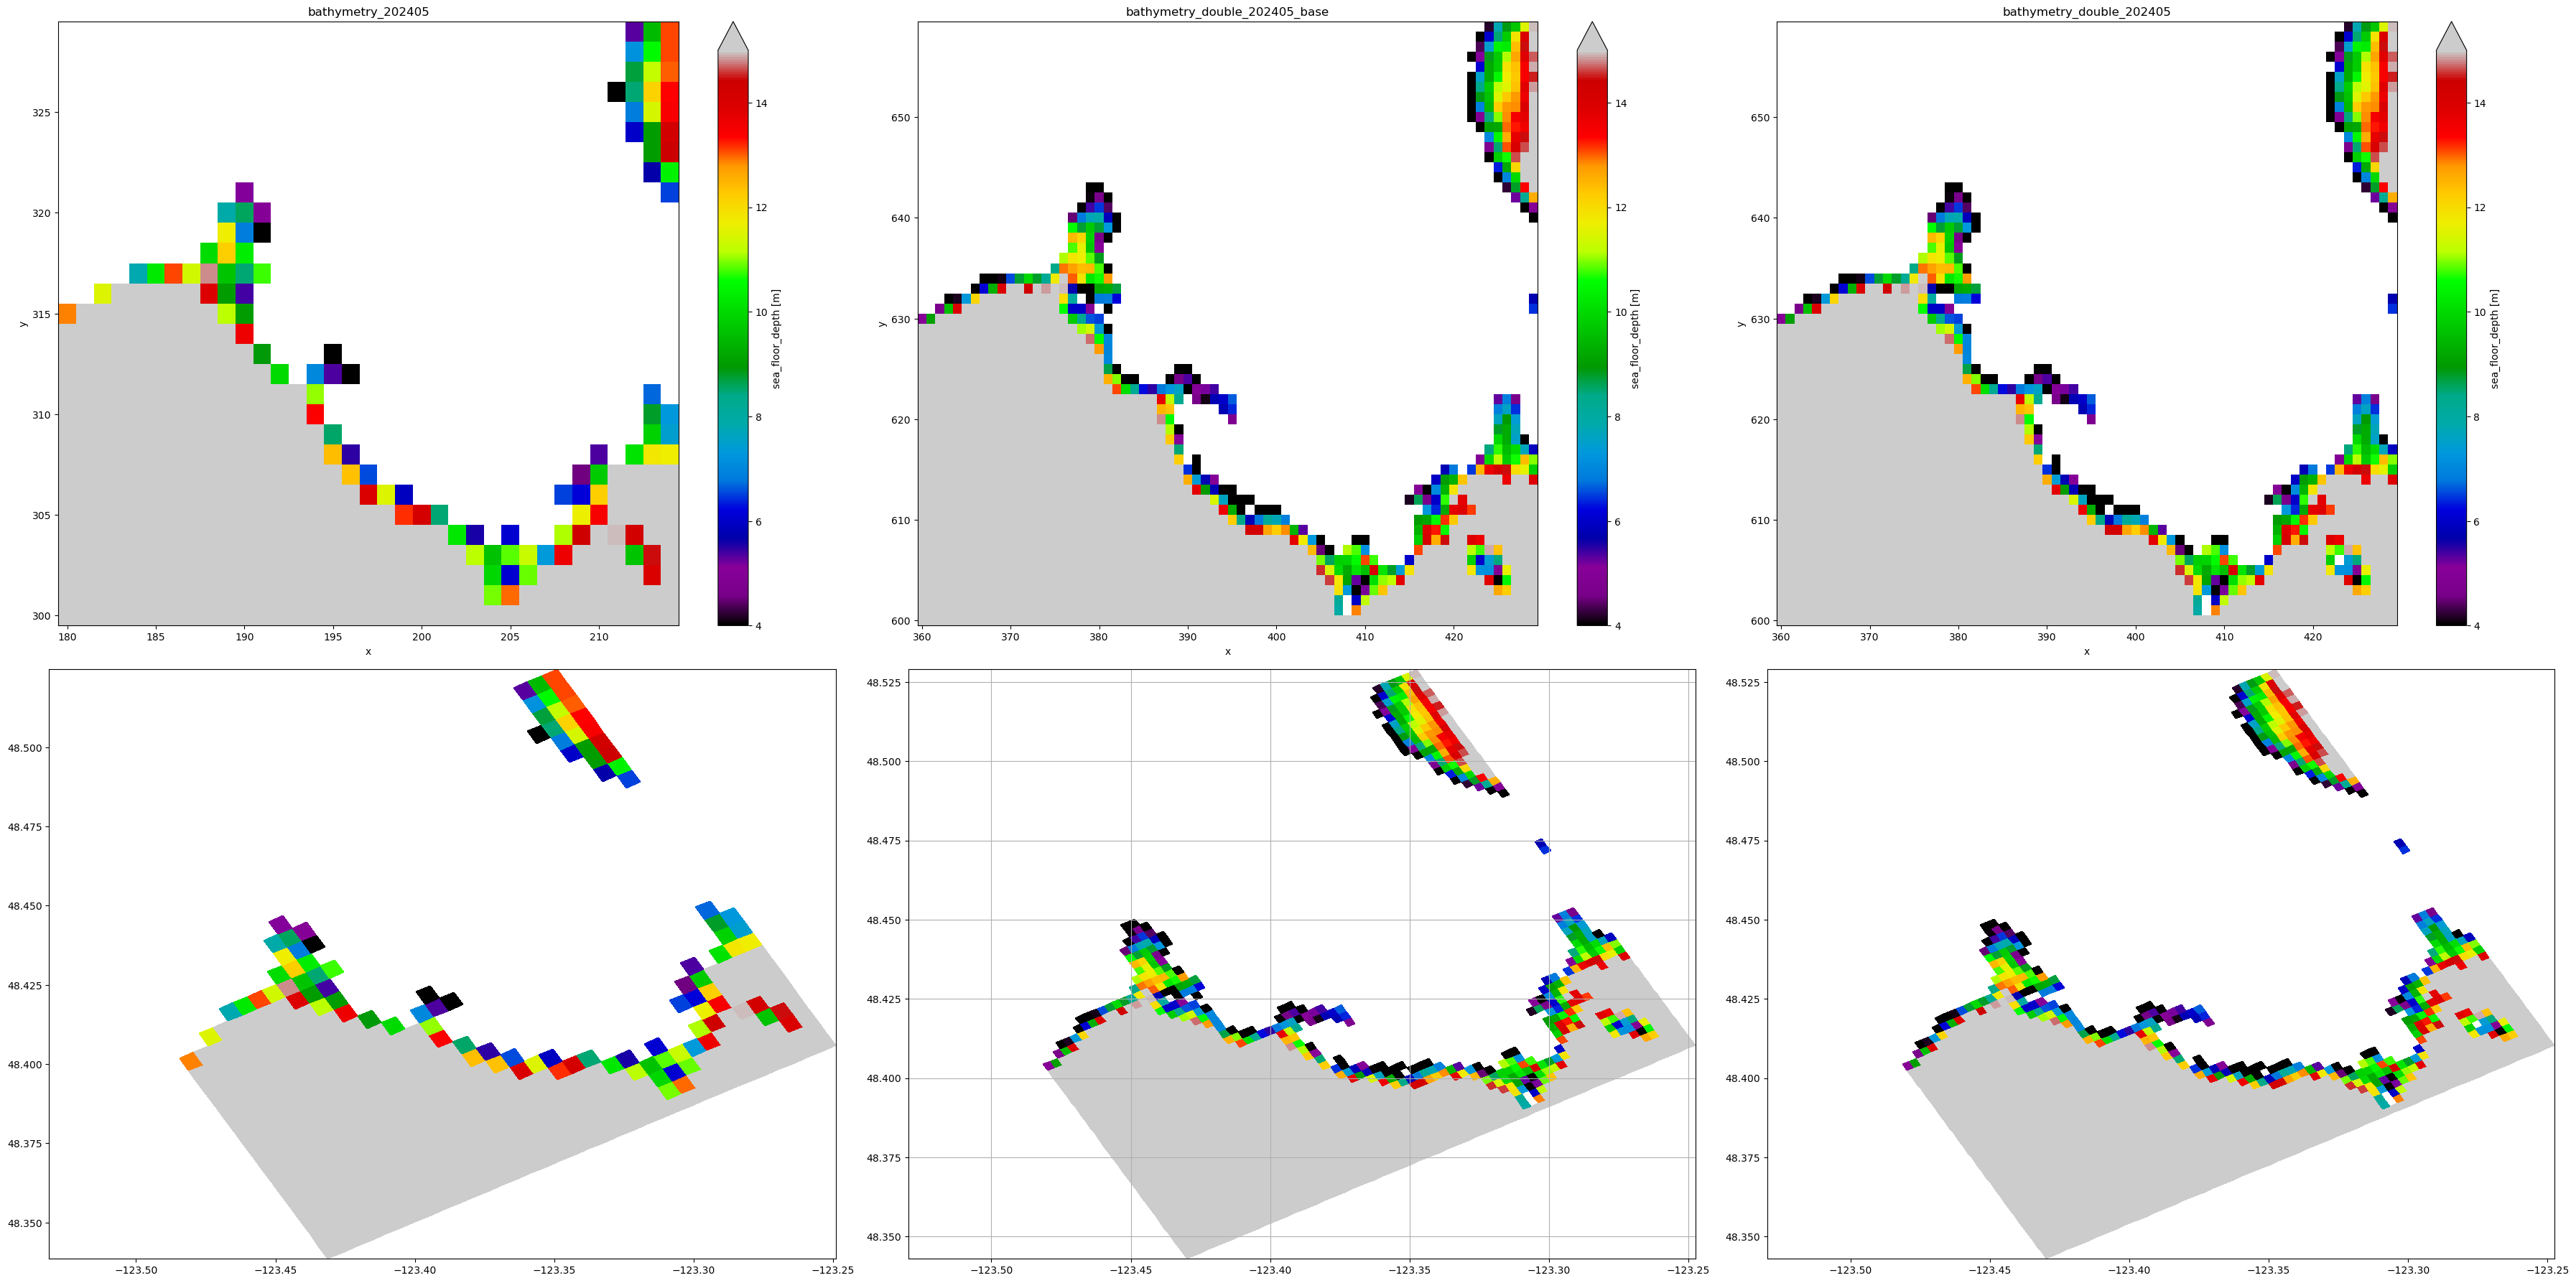

In [17]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 9, 7 - Haro Strait

* fix Discovery Island
* Make east Chatham Island T-shaped

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

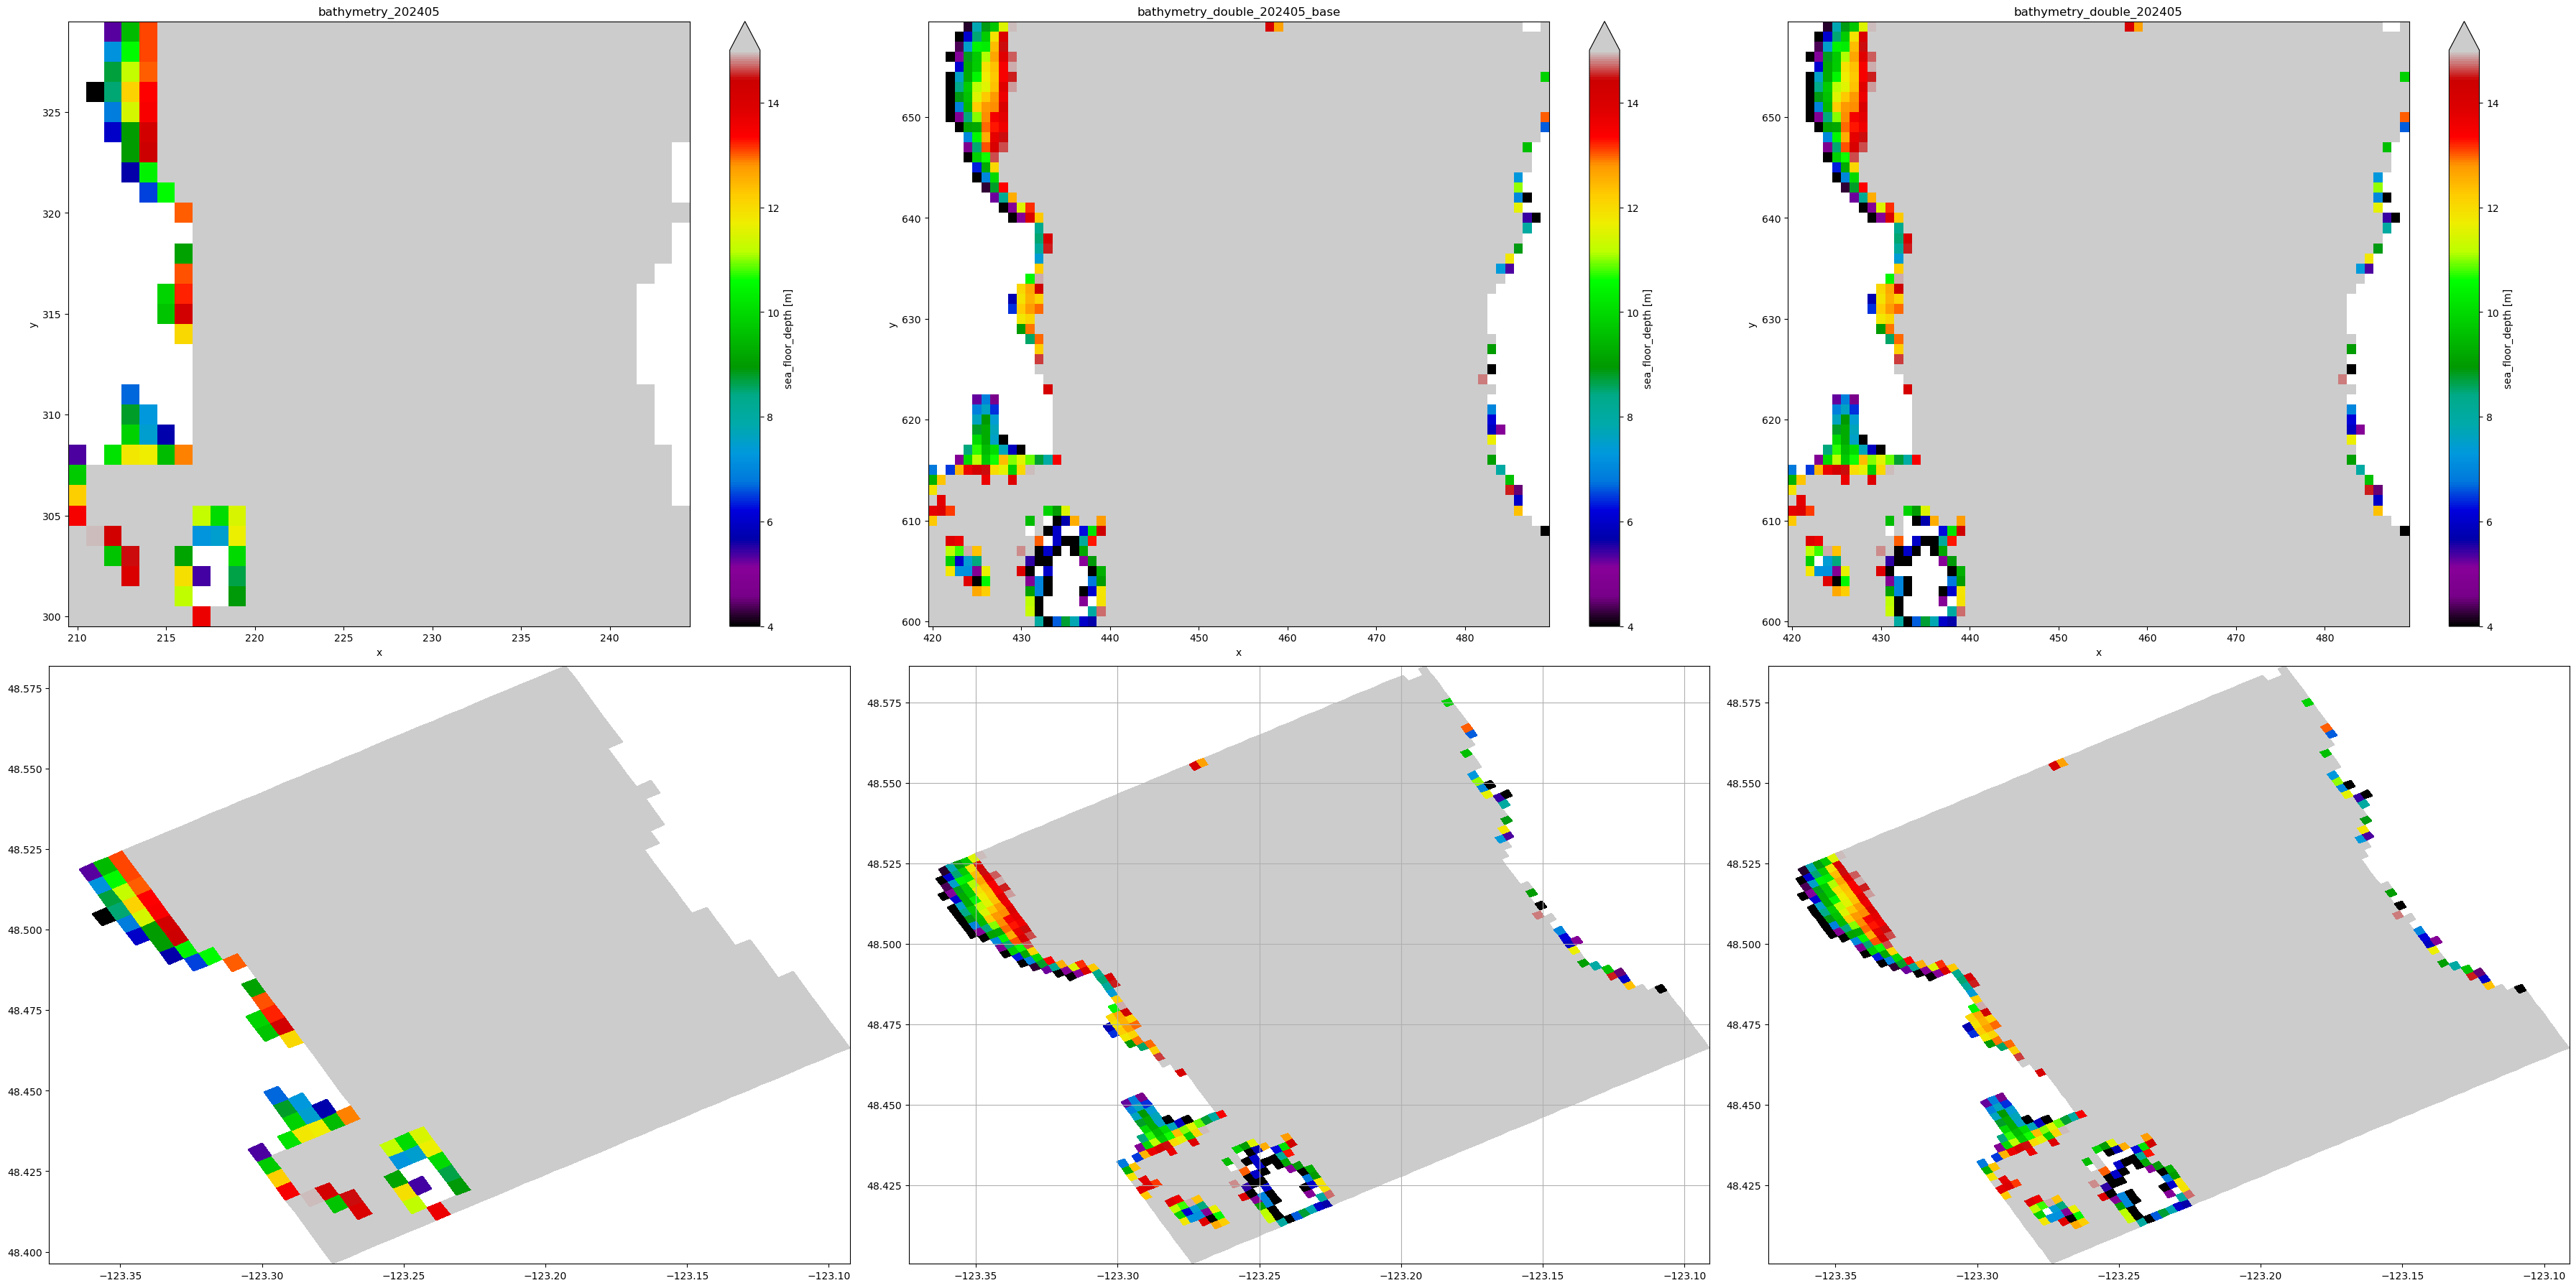

In [18]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 9, 8 - San Juan Island


(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

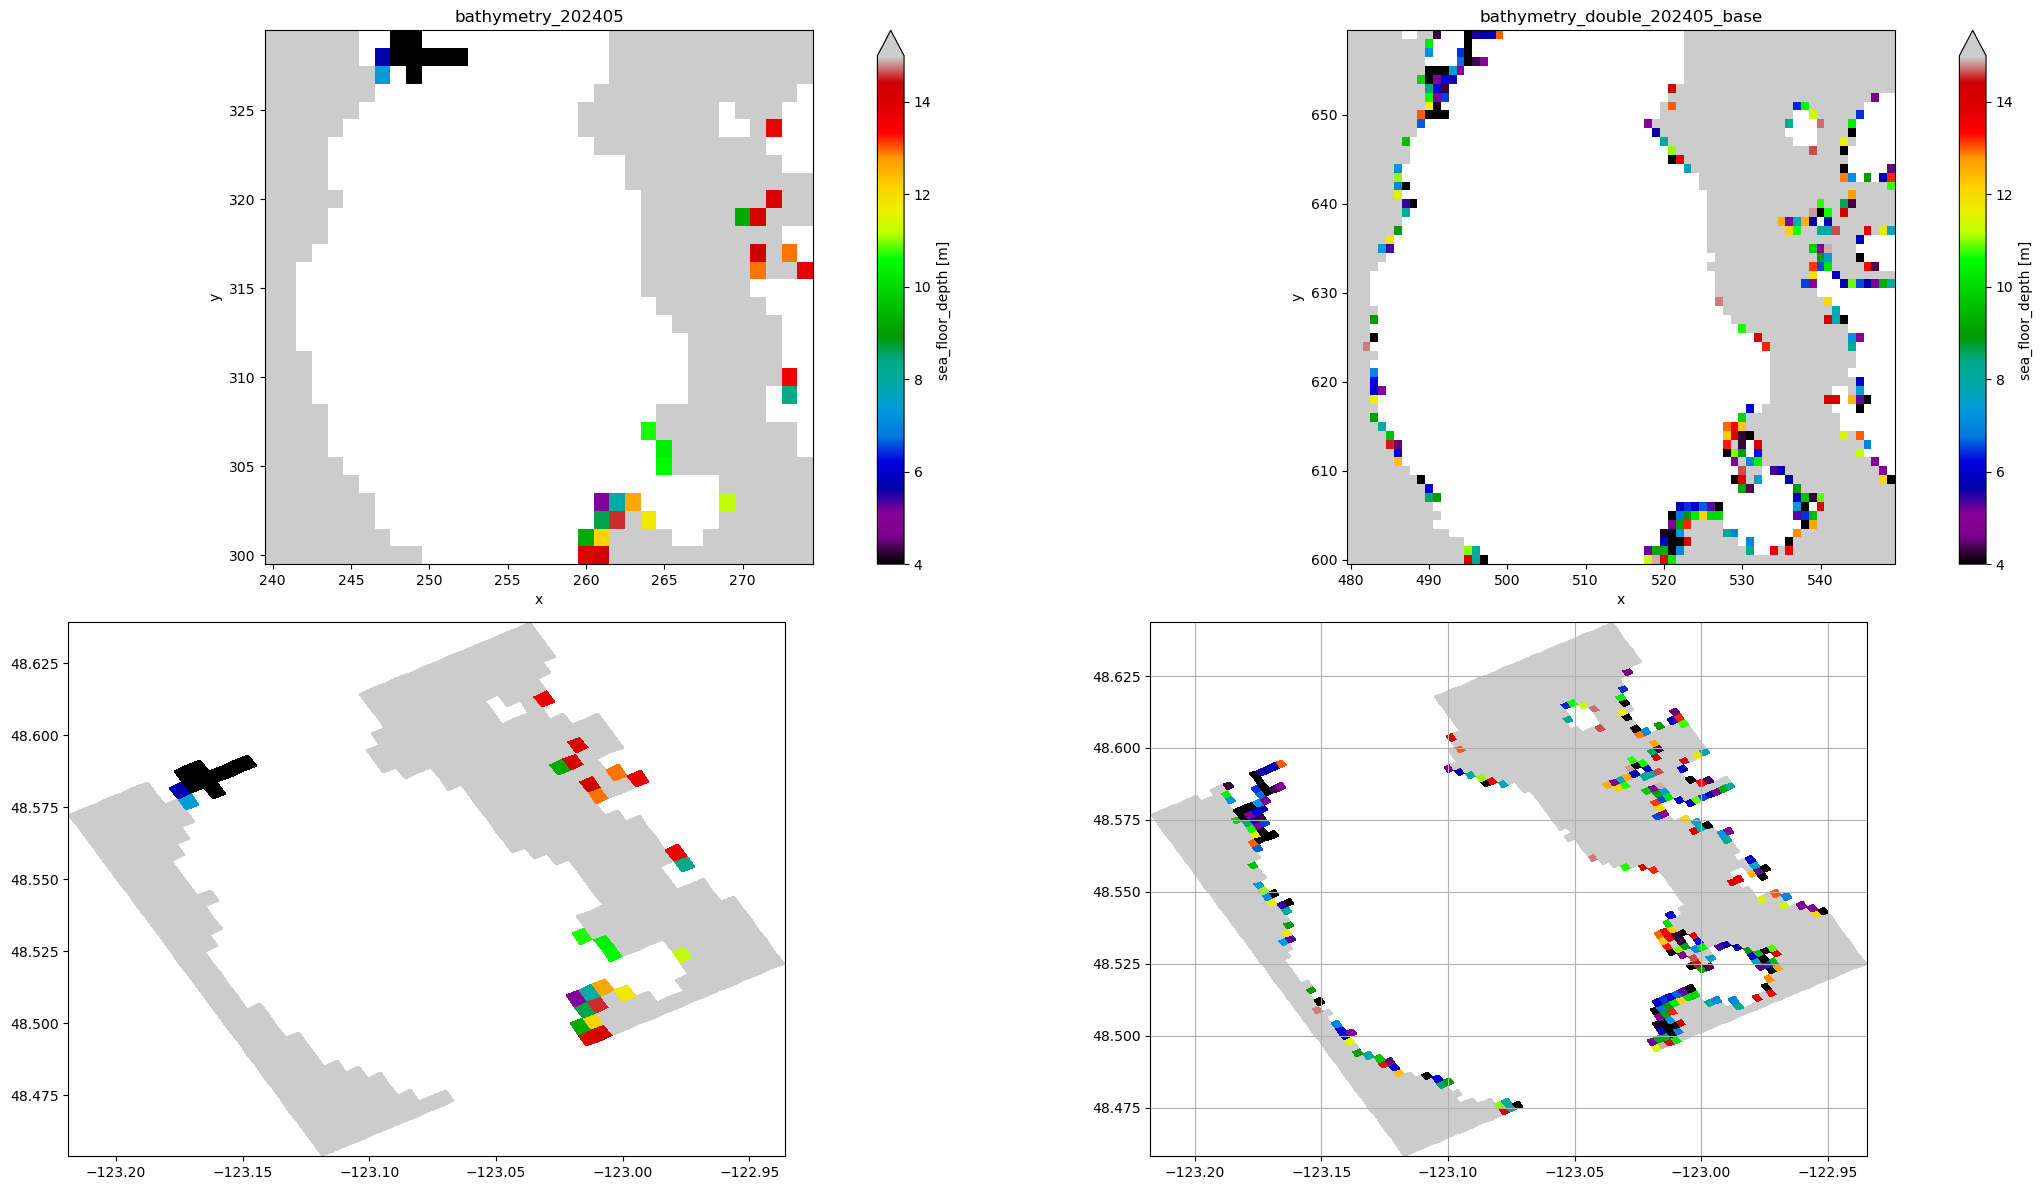

In [19]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base)

### Tile 9, 9 - Orcas Island


(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

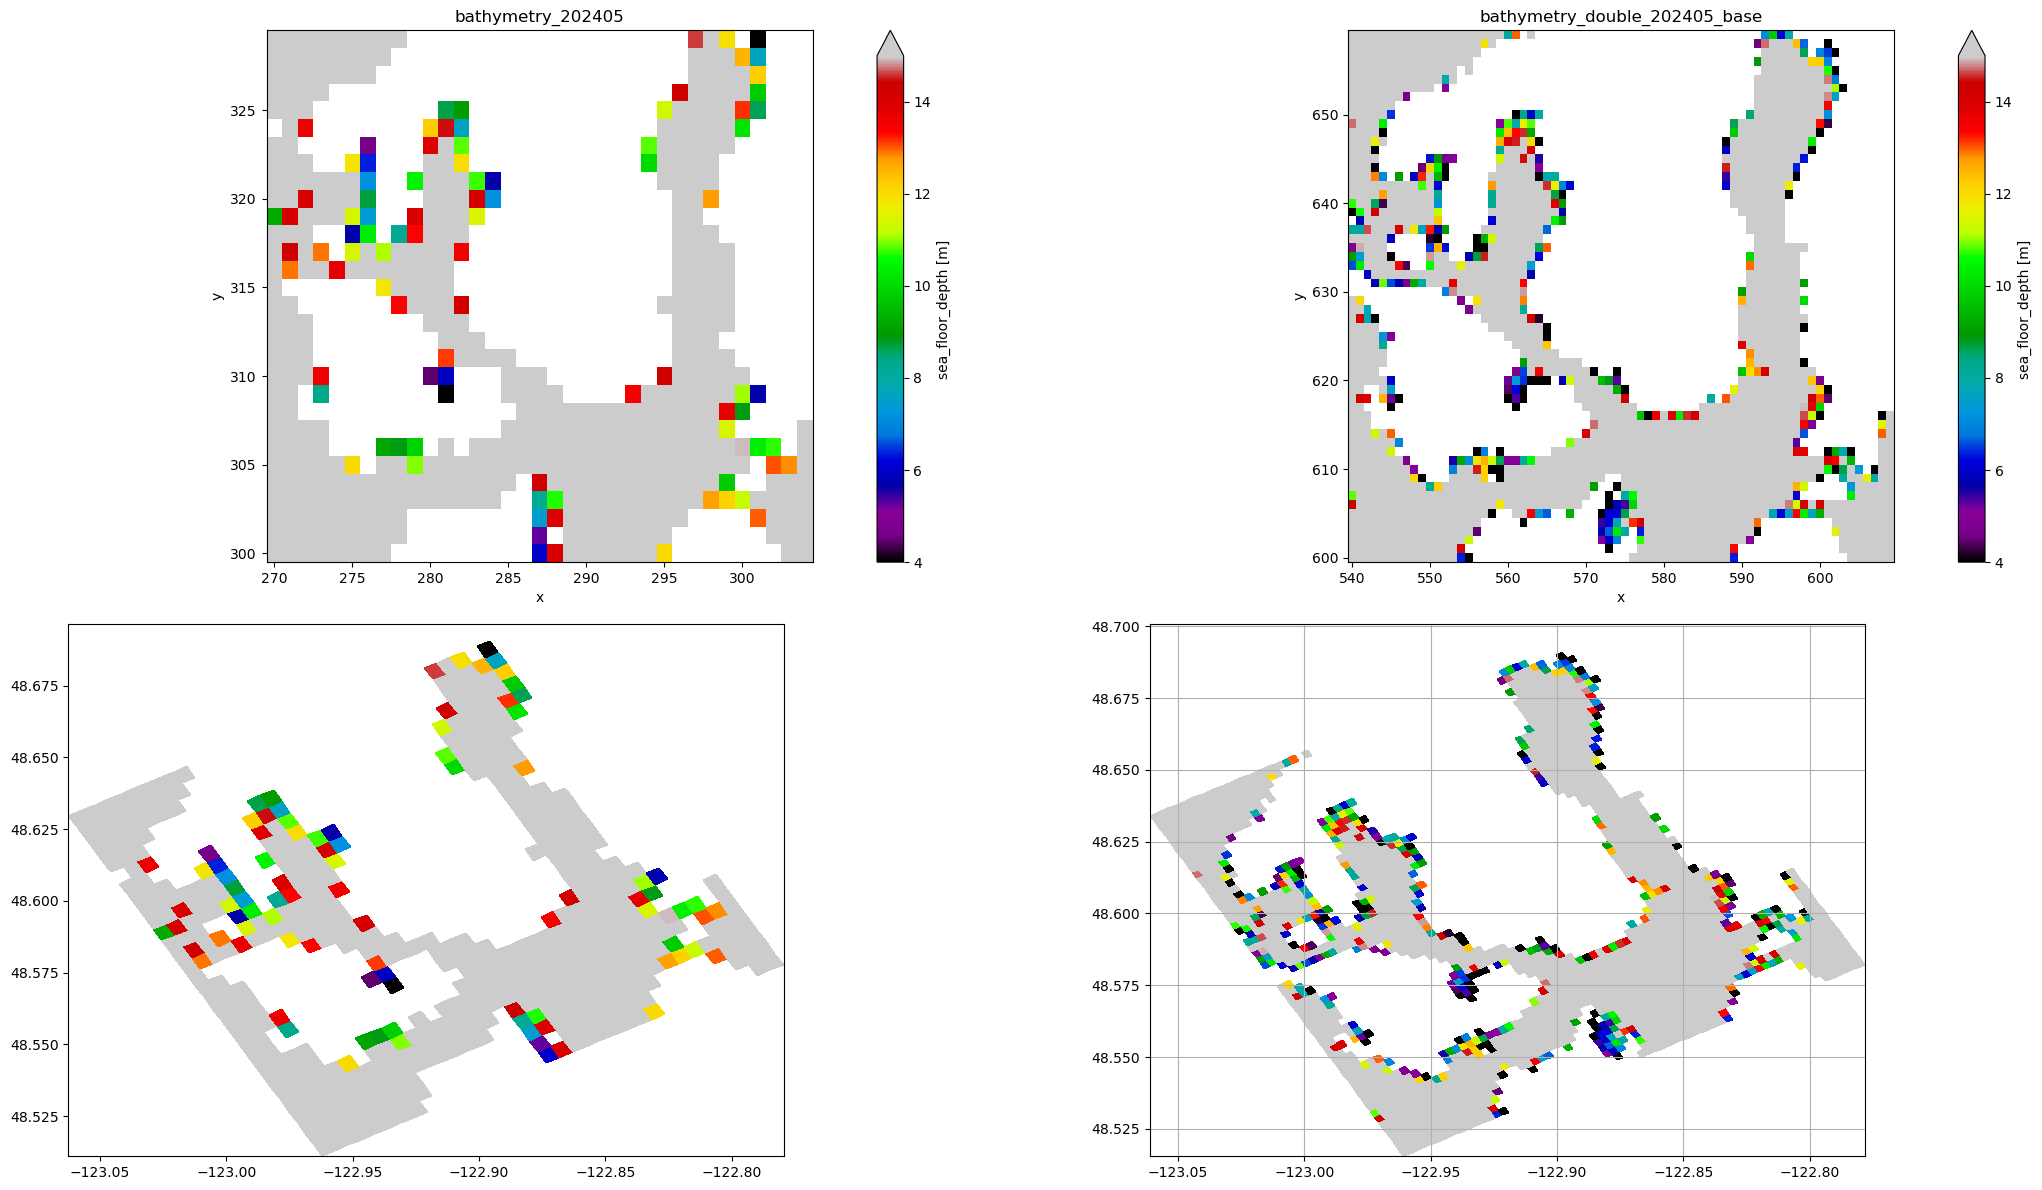

In [20]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base)

### Tile 9, 10 - North Rossario Strait


(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

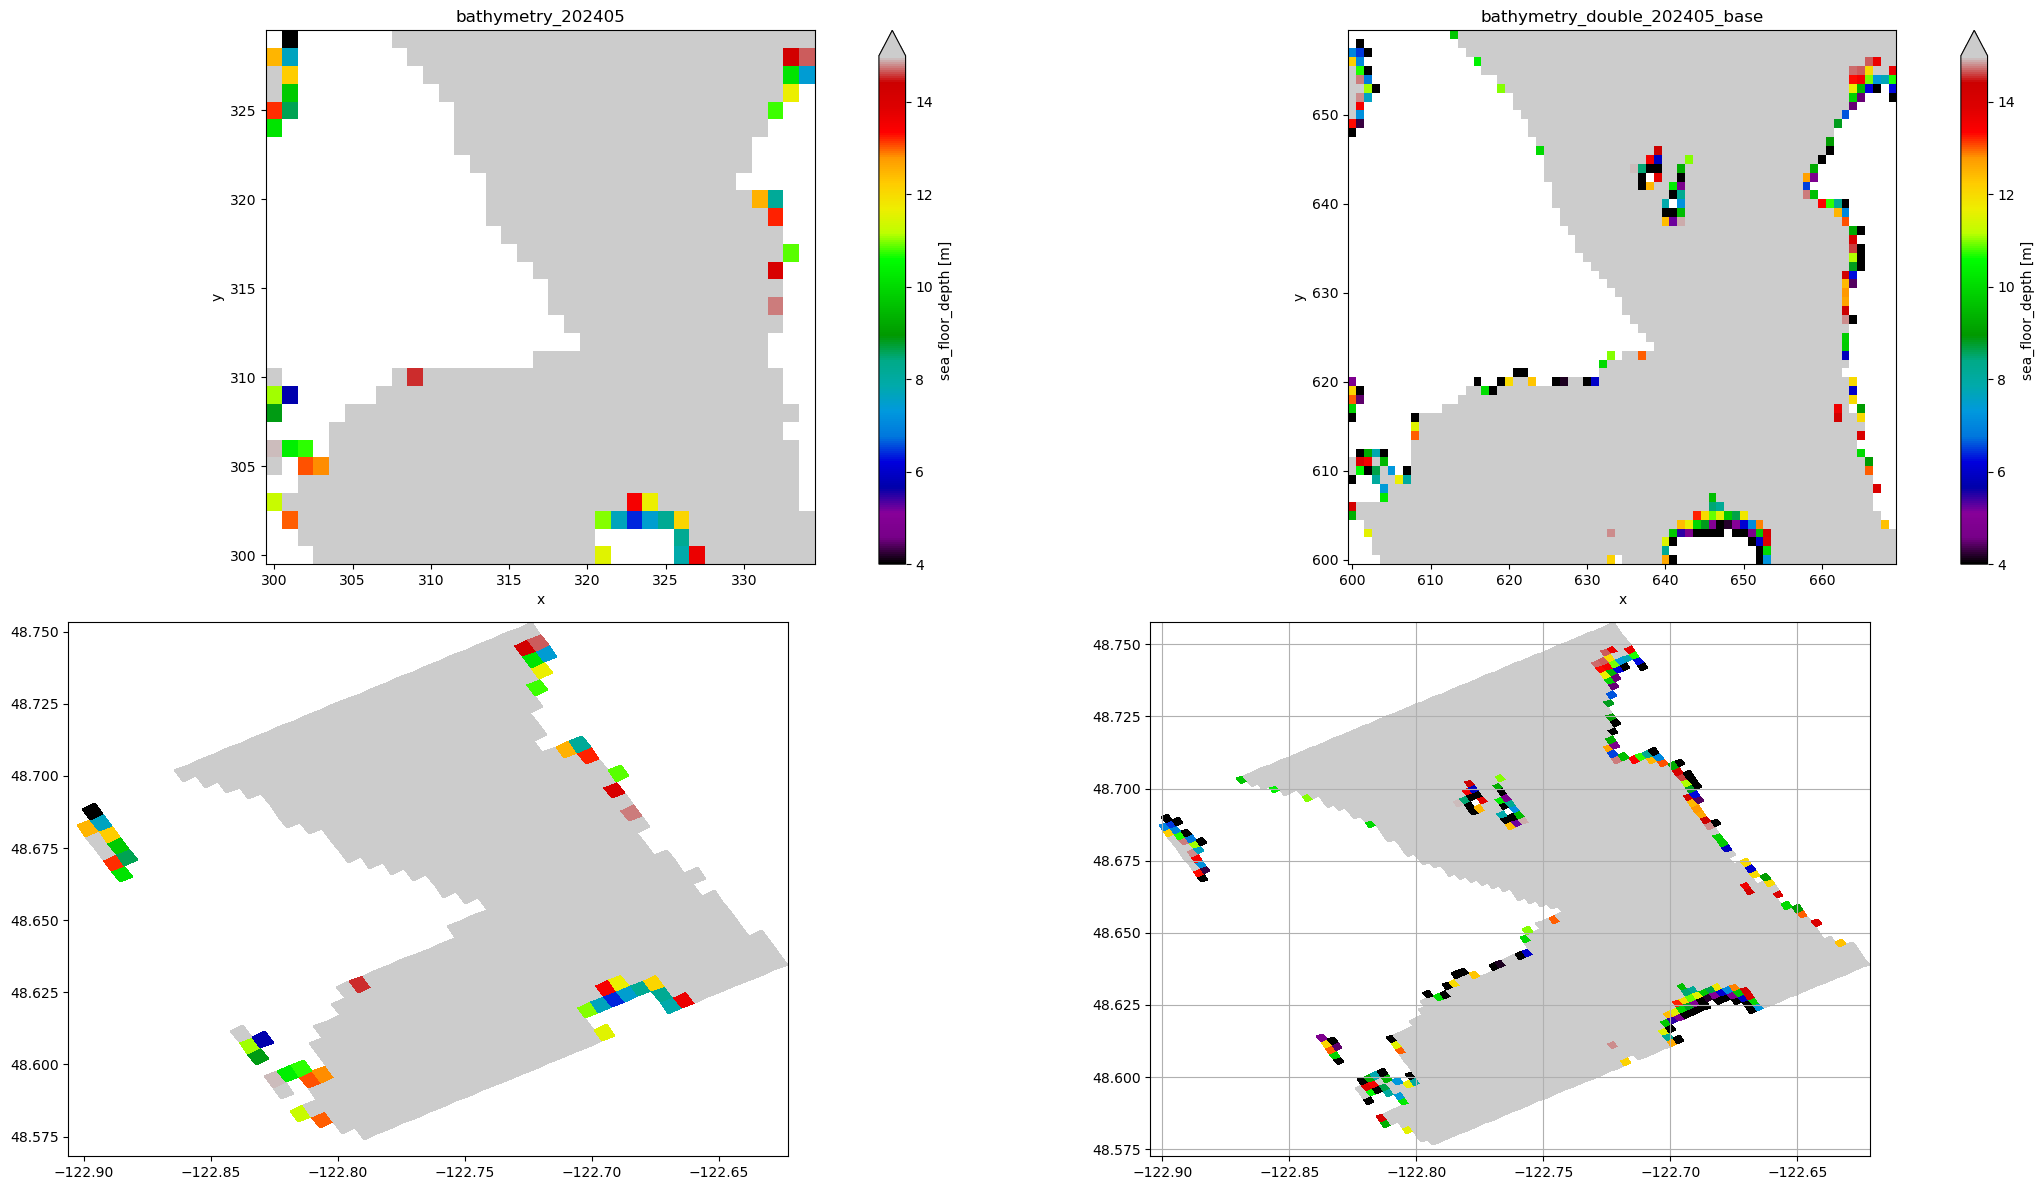

In [21]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base)

### Tile 9, 11 - Lummi Island and Bellingham Bay

* Portage Island is connected to Lummi Point in reality; perhaps an artificial isthmus

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

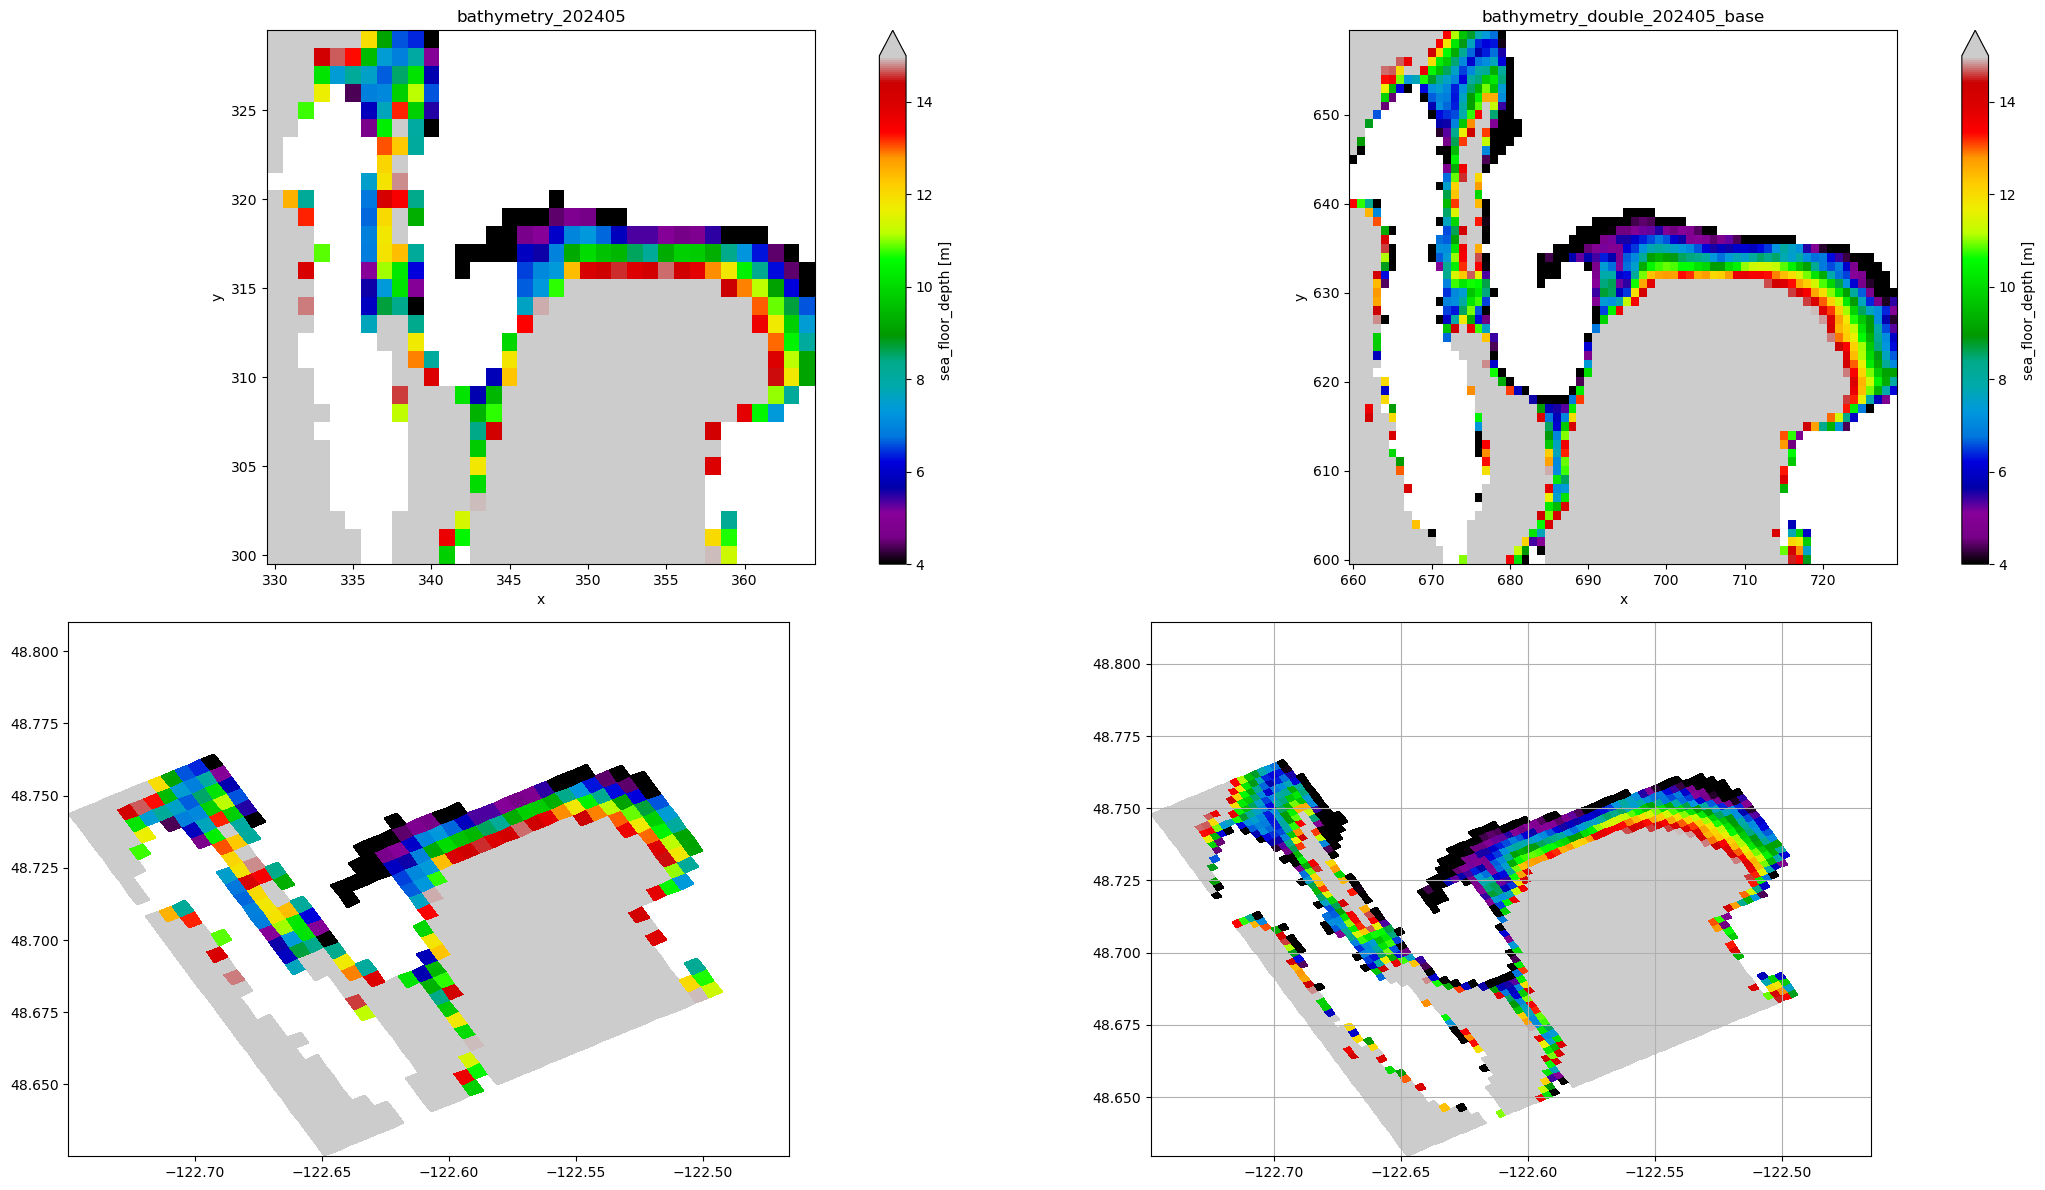

In [22]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base)

### Tile 9, 12 - East bit of Bellingham Bay

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

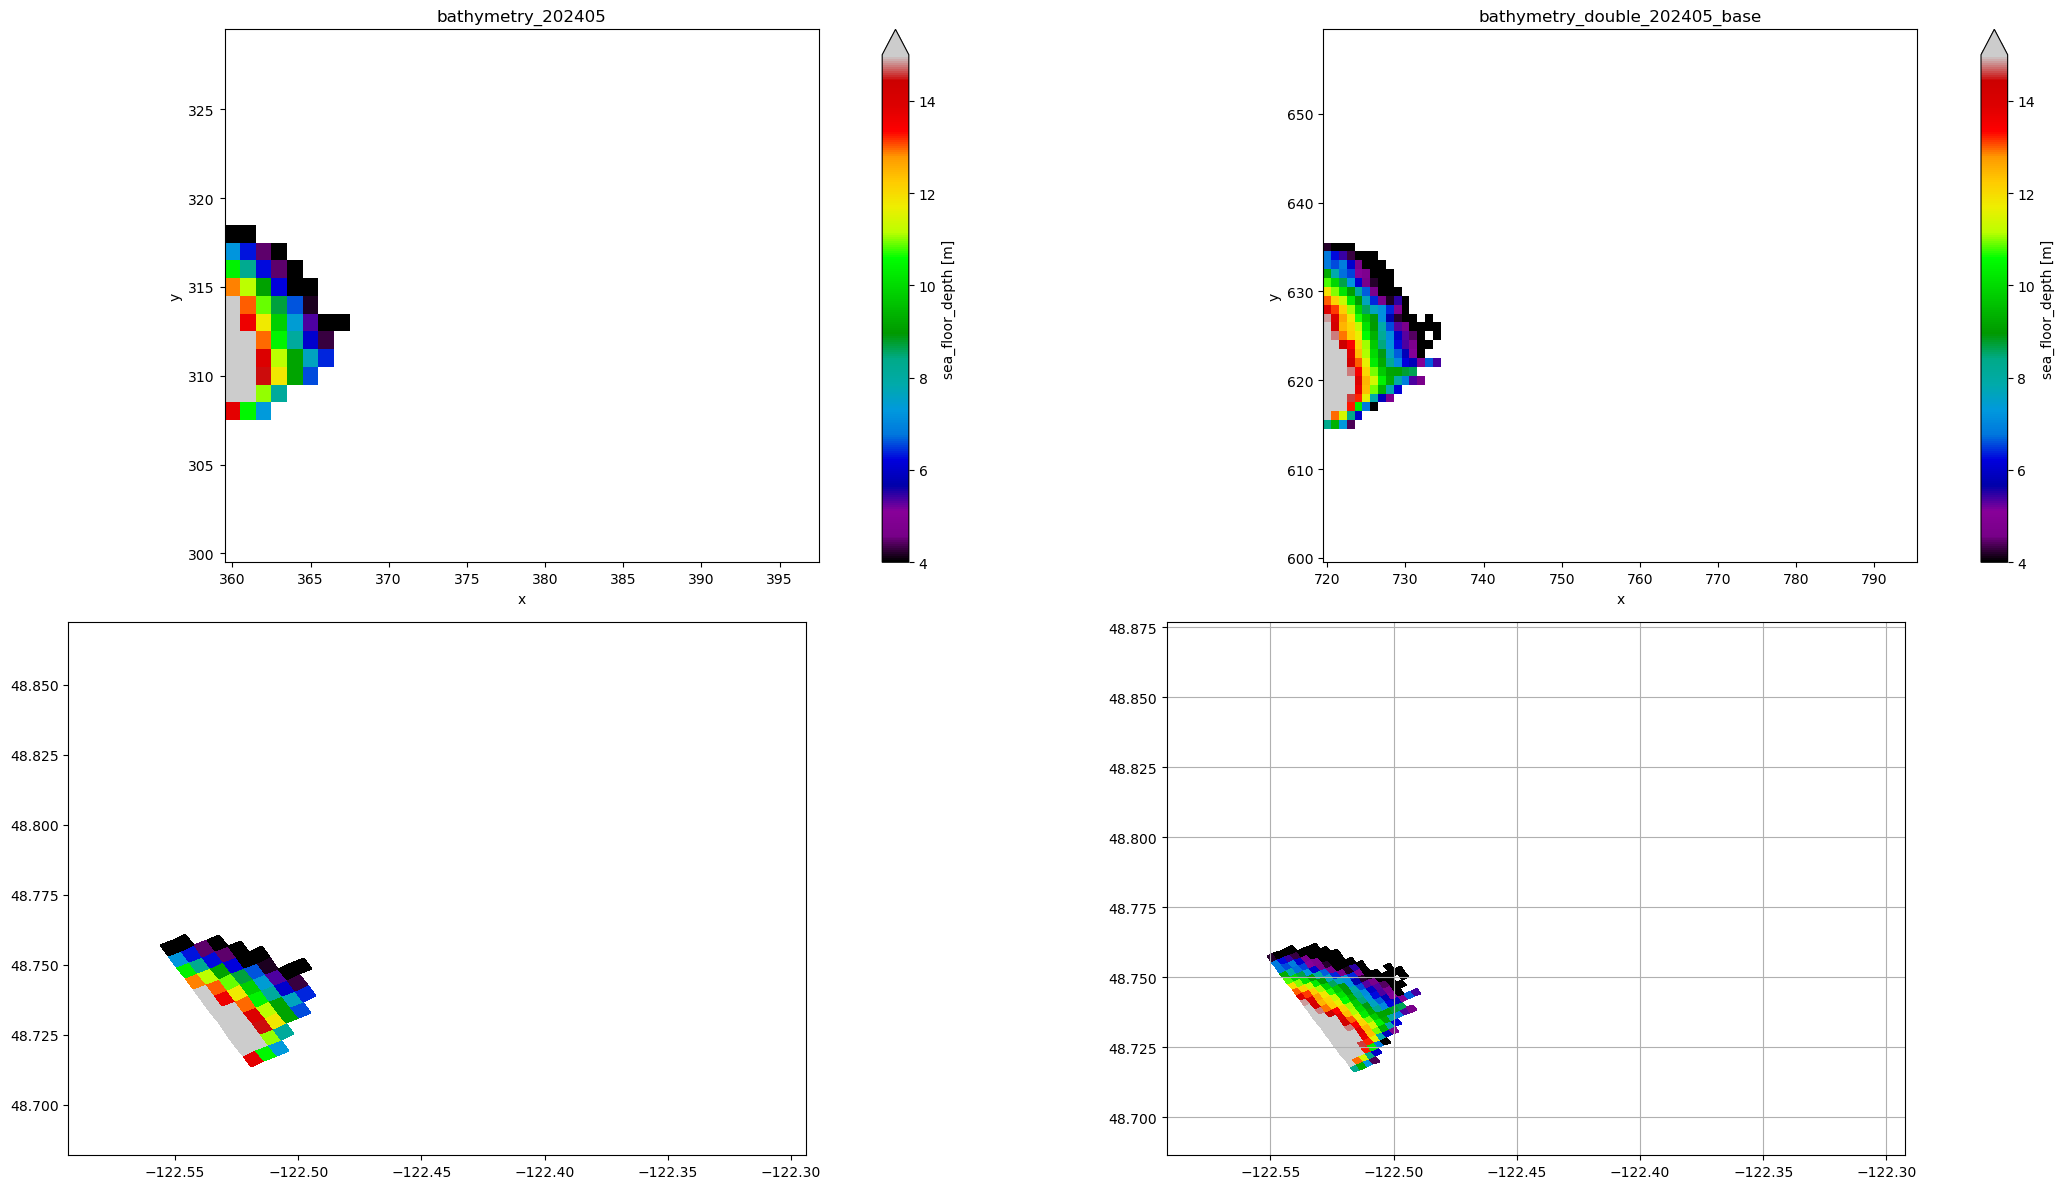

In [23]:
plot_tile(tile_x_min_max[12], y_slices, bathy, dbl_bathy_base)

## Row 10 - Juan de Fuca, Jordan River, Saanich Inlet, boundary islands, Neptune Beach

In [24]:
y_min_max = numpy.array([330, 360])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 10, 0 - Between the mouths of the Sekiu and Hoko Rivers

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

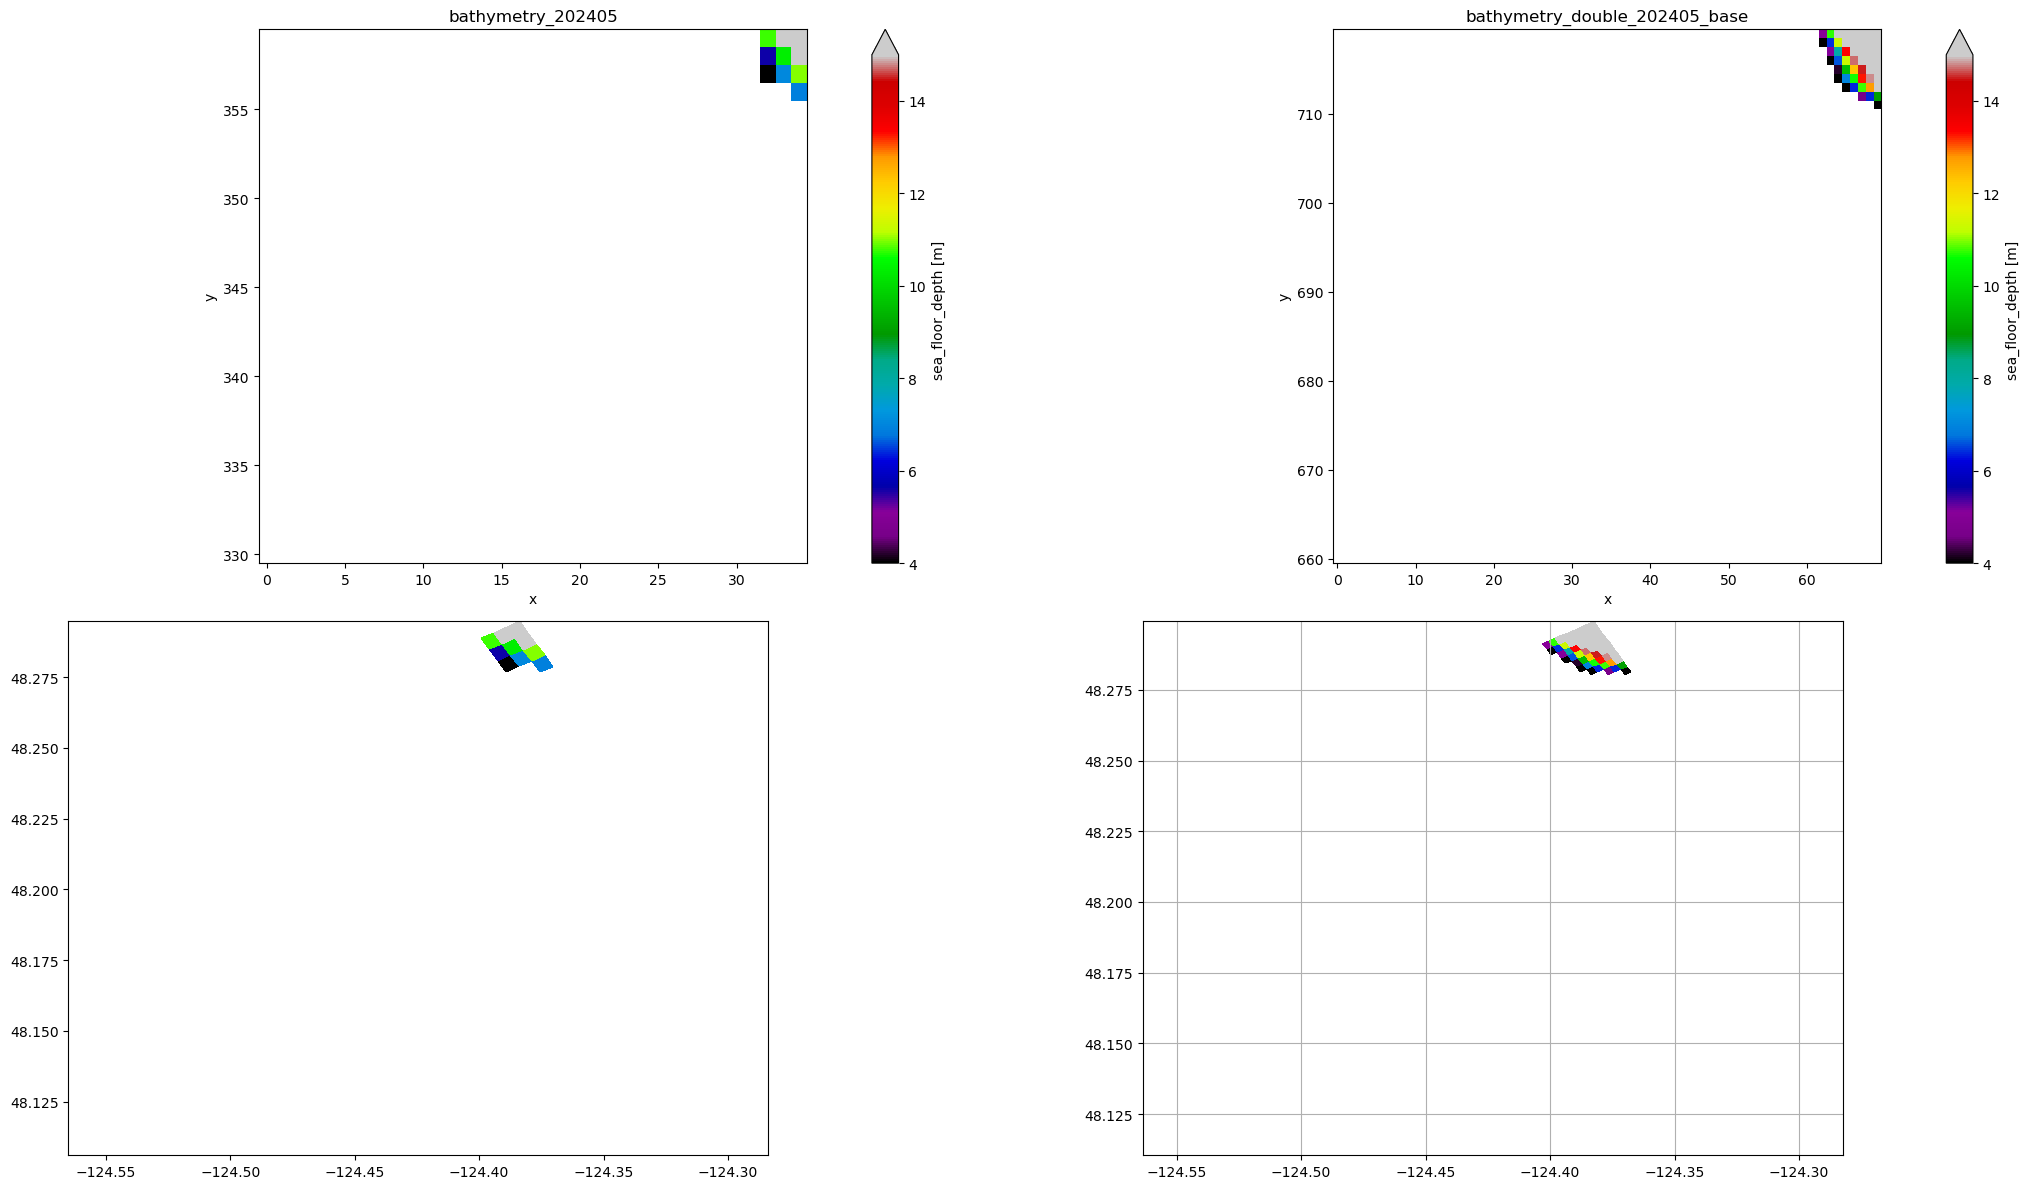

In [25]:
plot_tile(tile_x_min_max[0], y_slices, bathy, dbl_bathy_base)




### Tile 10, 1 - Clallam Bay

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

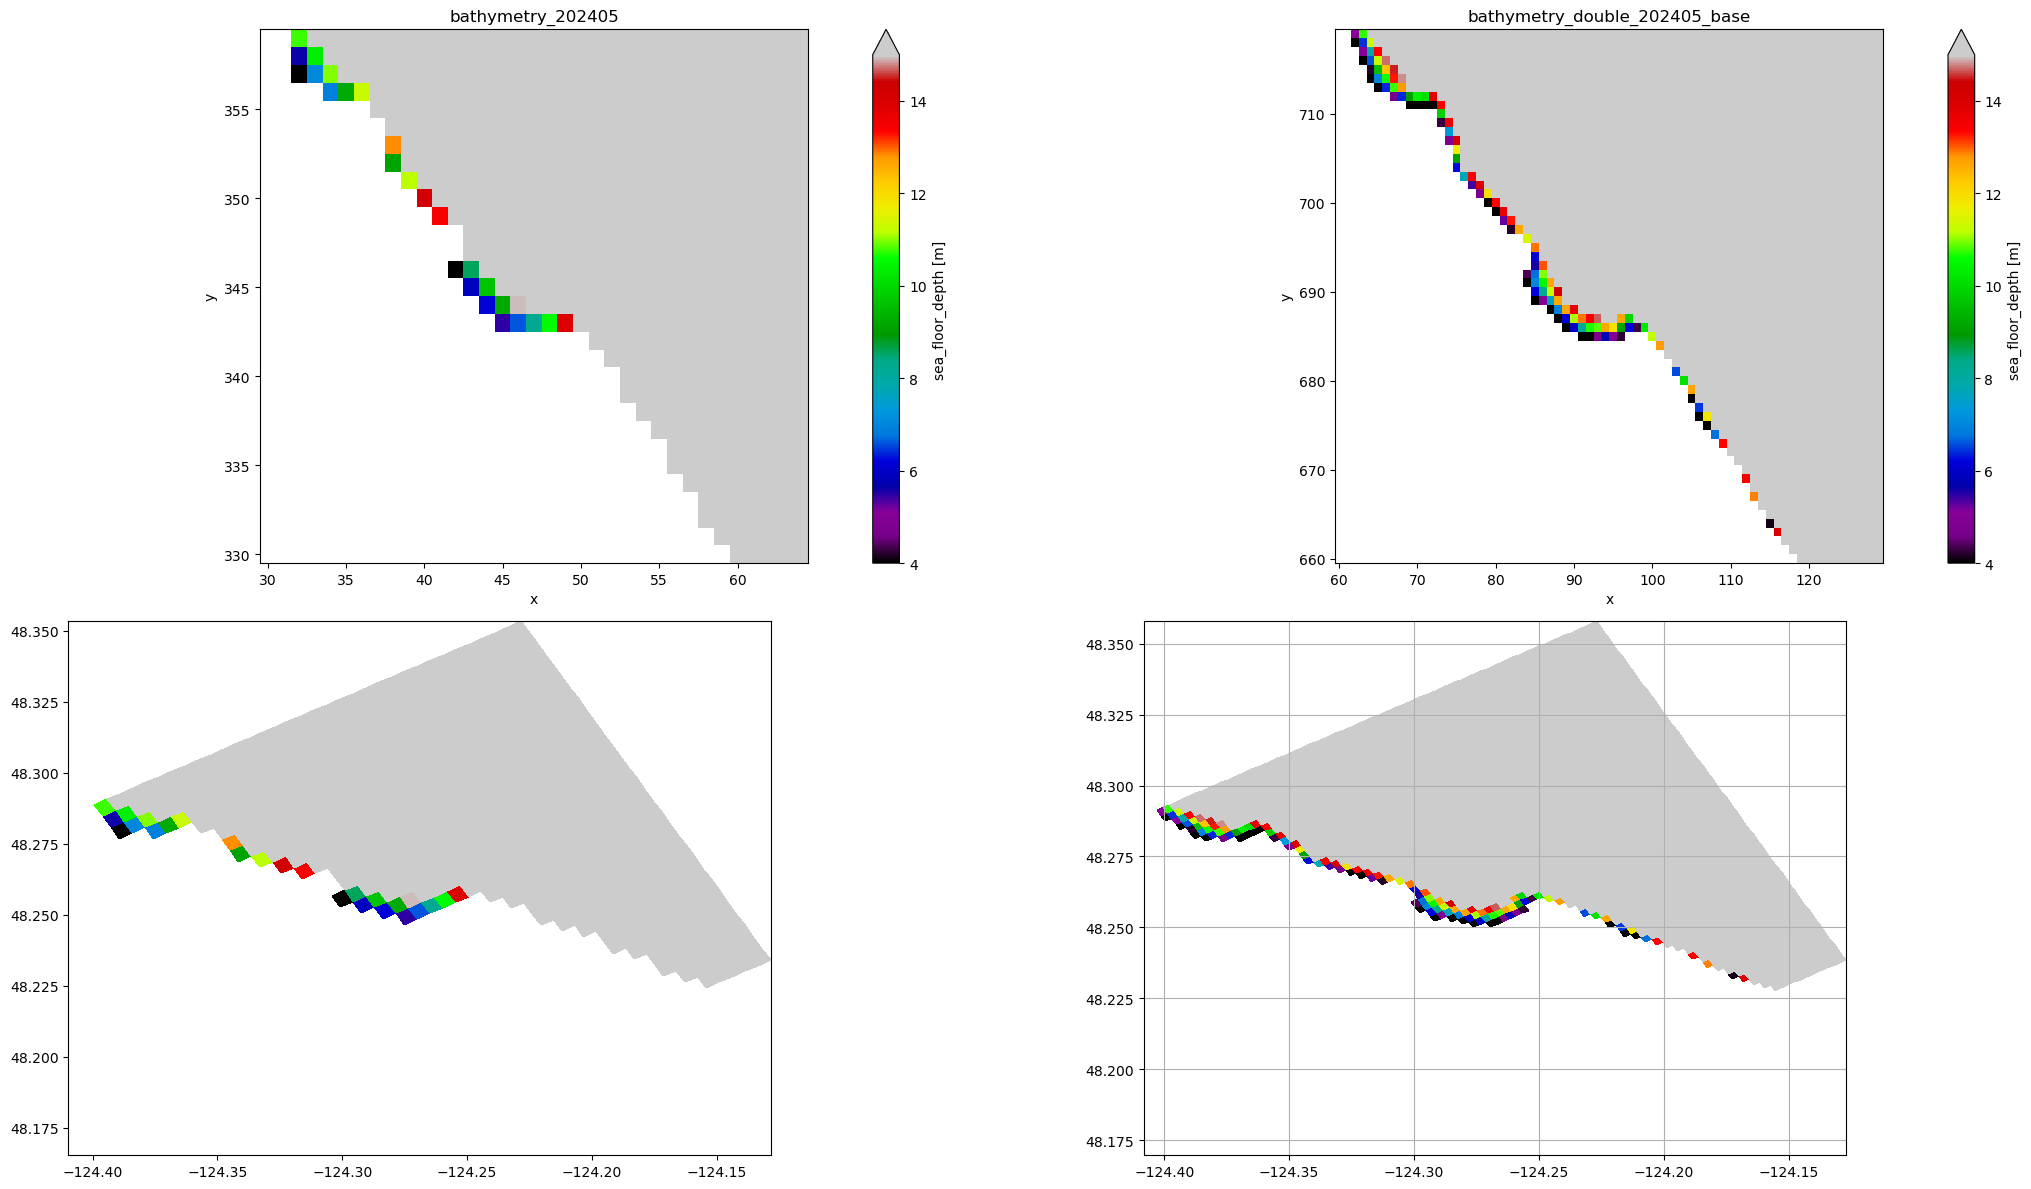

In [26]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 10, 2

* all >15m deep

### Tile 10, 3 - Jordan River, French Beach, and Sheringham Point

* Remove extraneous island off French Beach

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

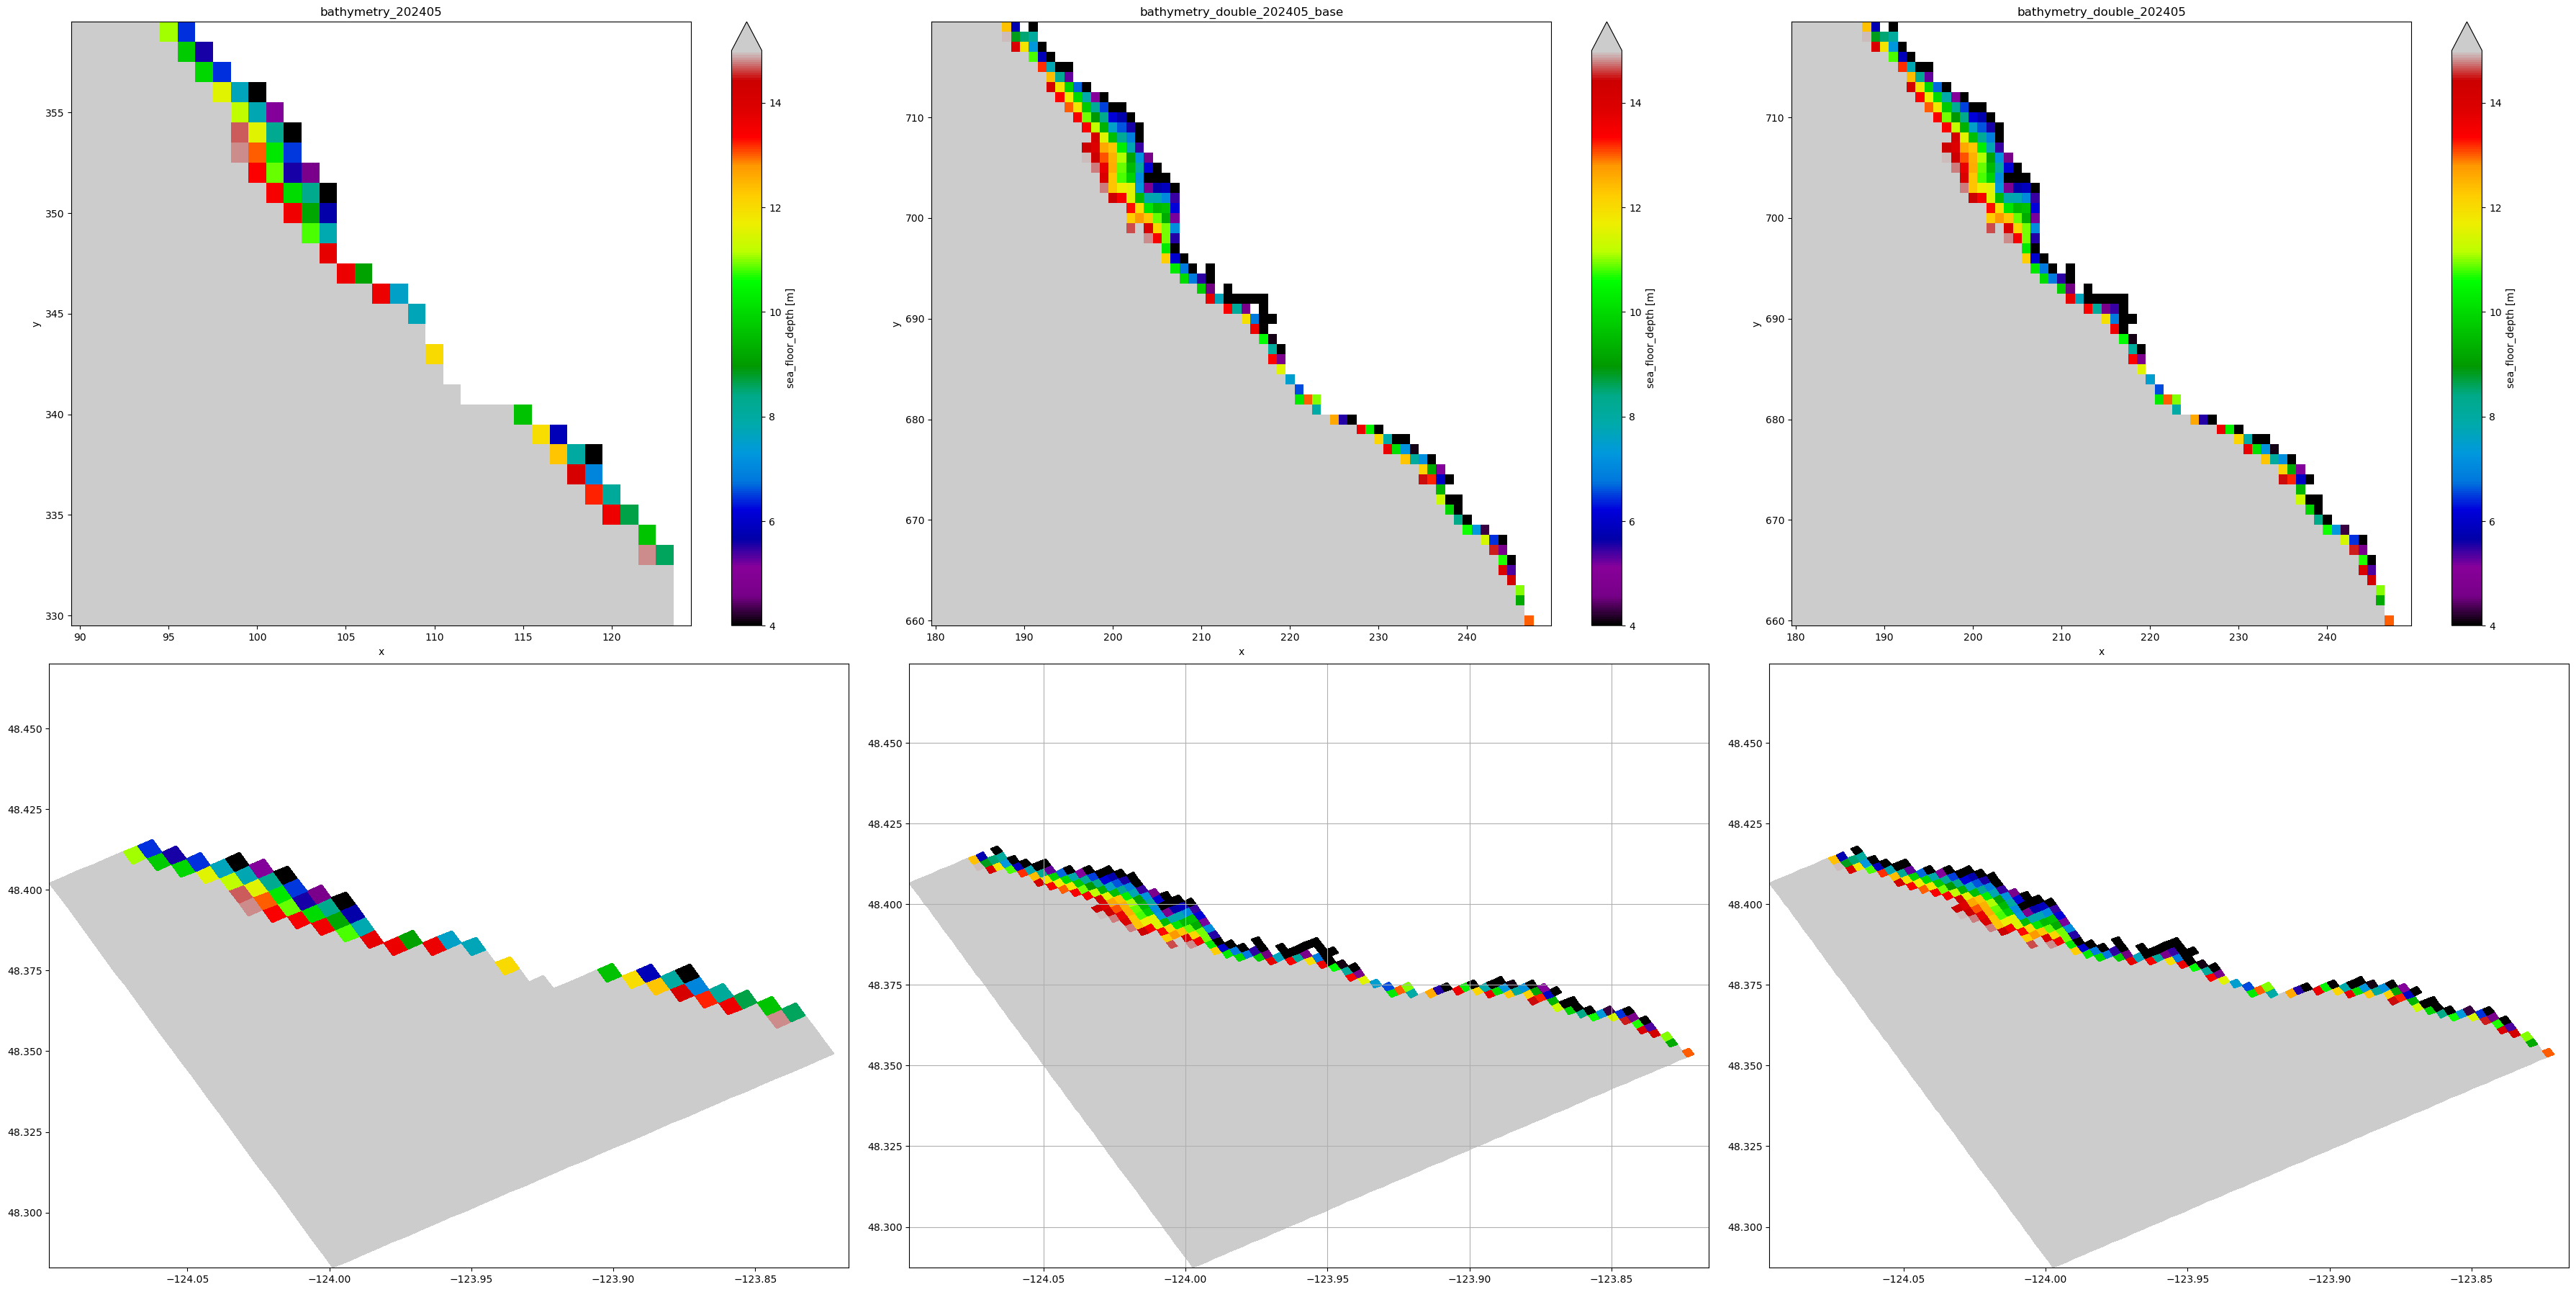

In [27]:
plot_tile(tile_x_min_max[3], y_slices, bathy, dbl_bathy_base, dbl_bathy)


























### Tile 10, 4 - Near Muir Creek Beach

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

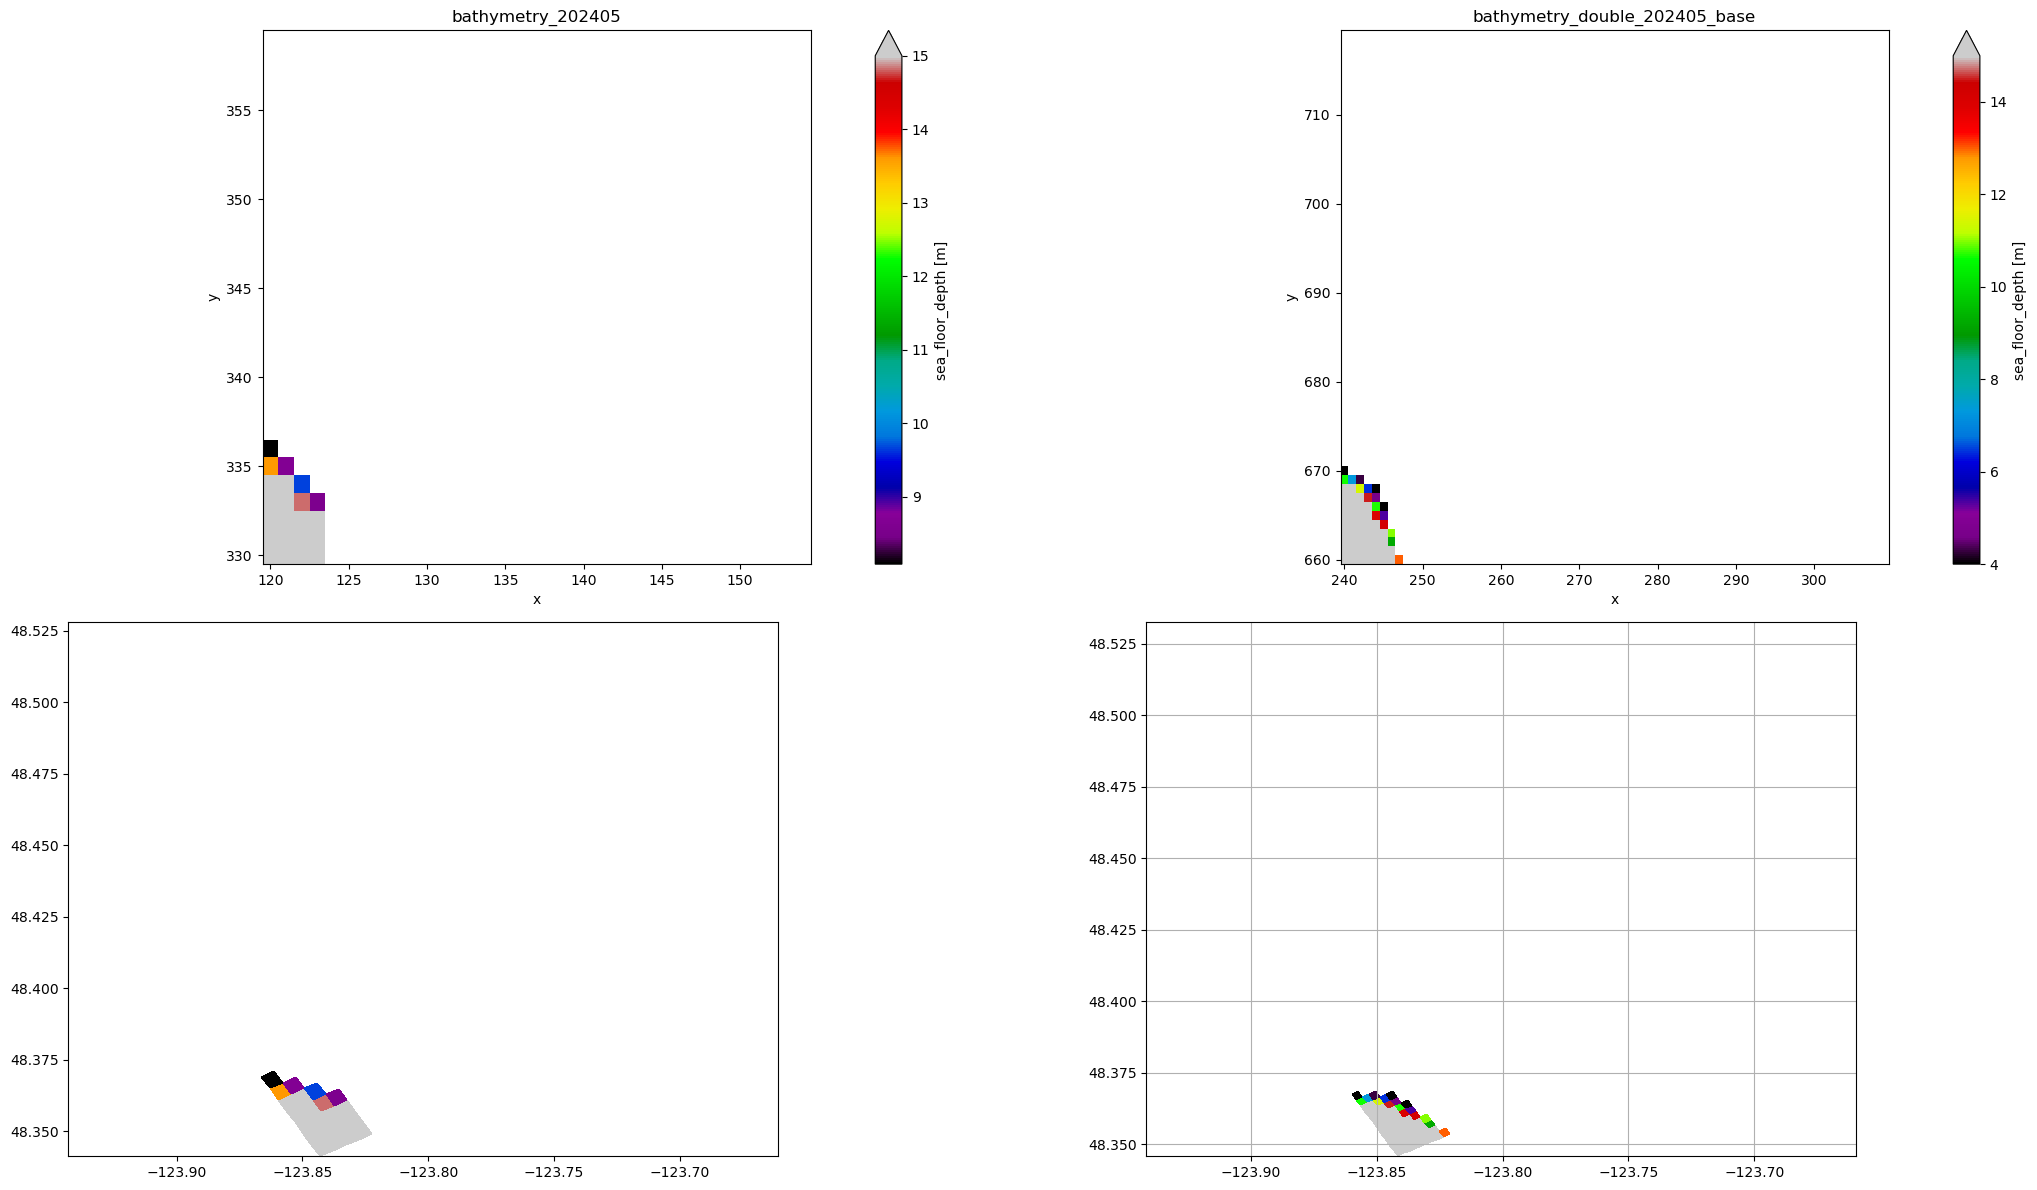

In [28]:
plot_tile(tile_x_min_max[4], y_slices, bathy, dbl_bathy_base)

### Tile 10, 5

* all land

### Tile 10, 6 - Saanich Inlet

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

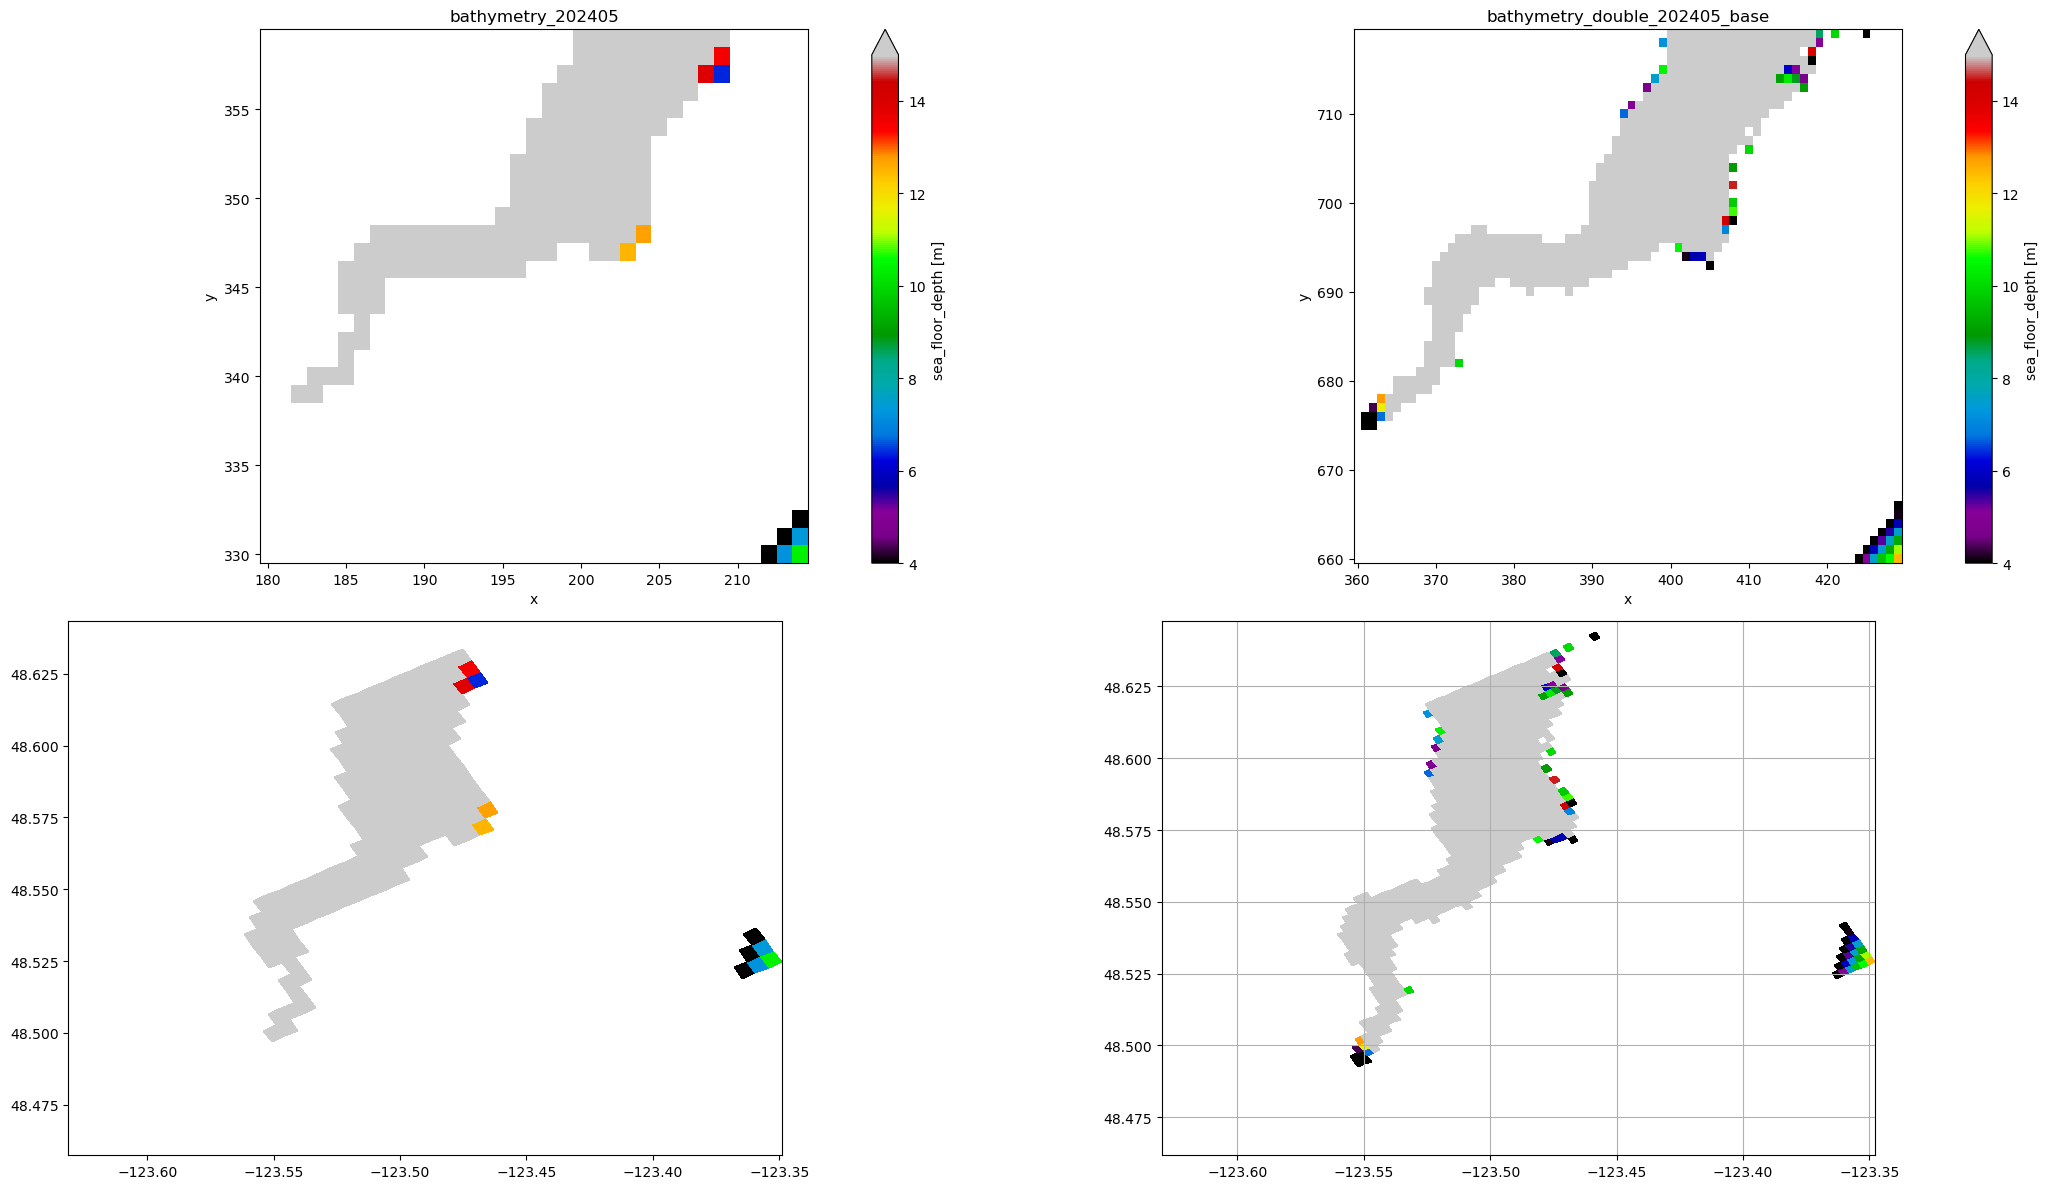

In [29]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base)

### Tile 10, 7 - James Island & Sidney Island

* connect spit on north end of Sidney Island
* connect Gooch Island
* Surface Forrest, Demville & Brethour Islands

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

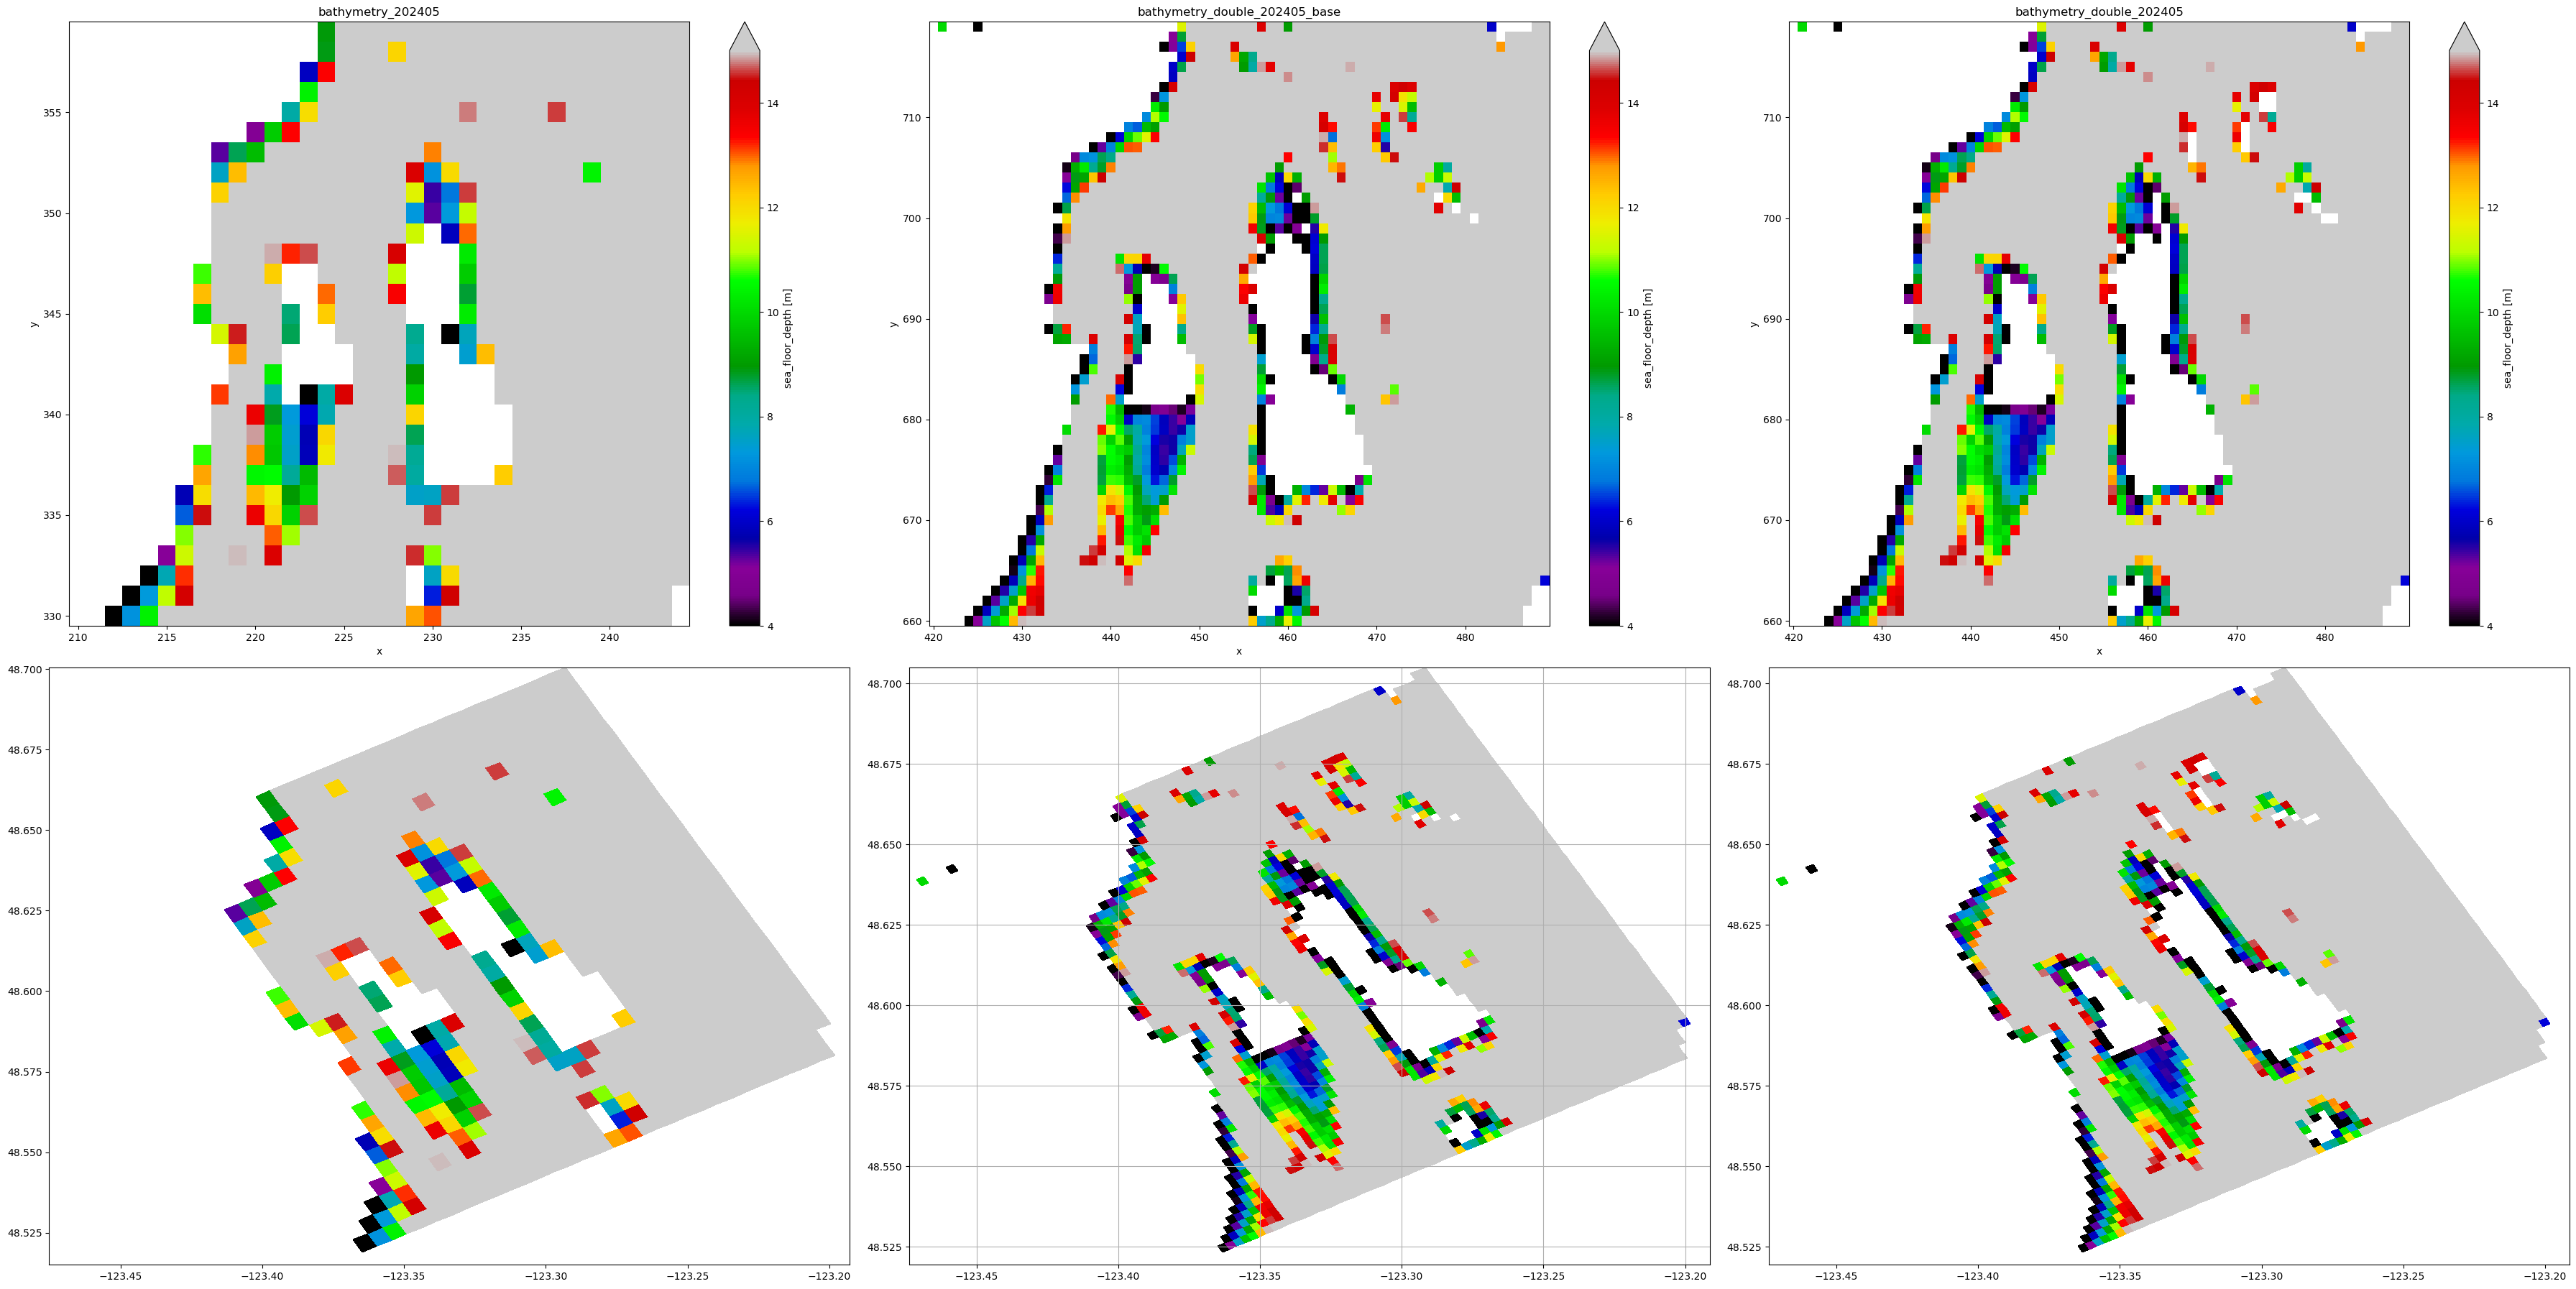

In [30]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 10, 8 - Stuart Island

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

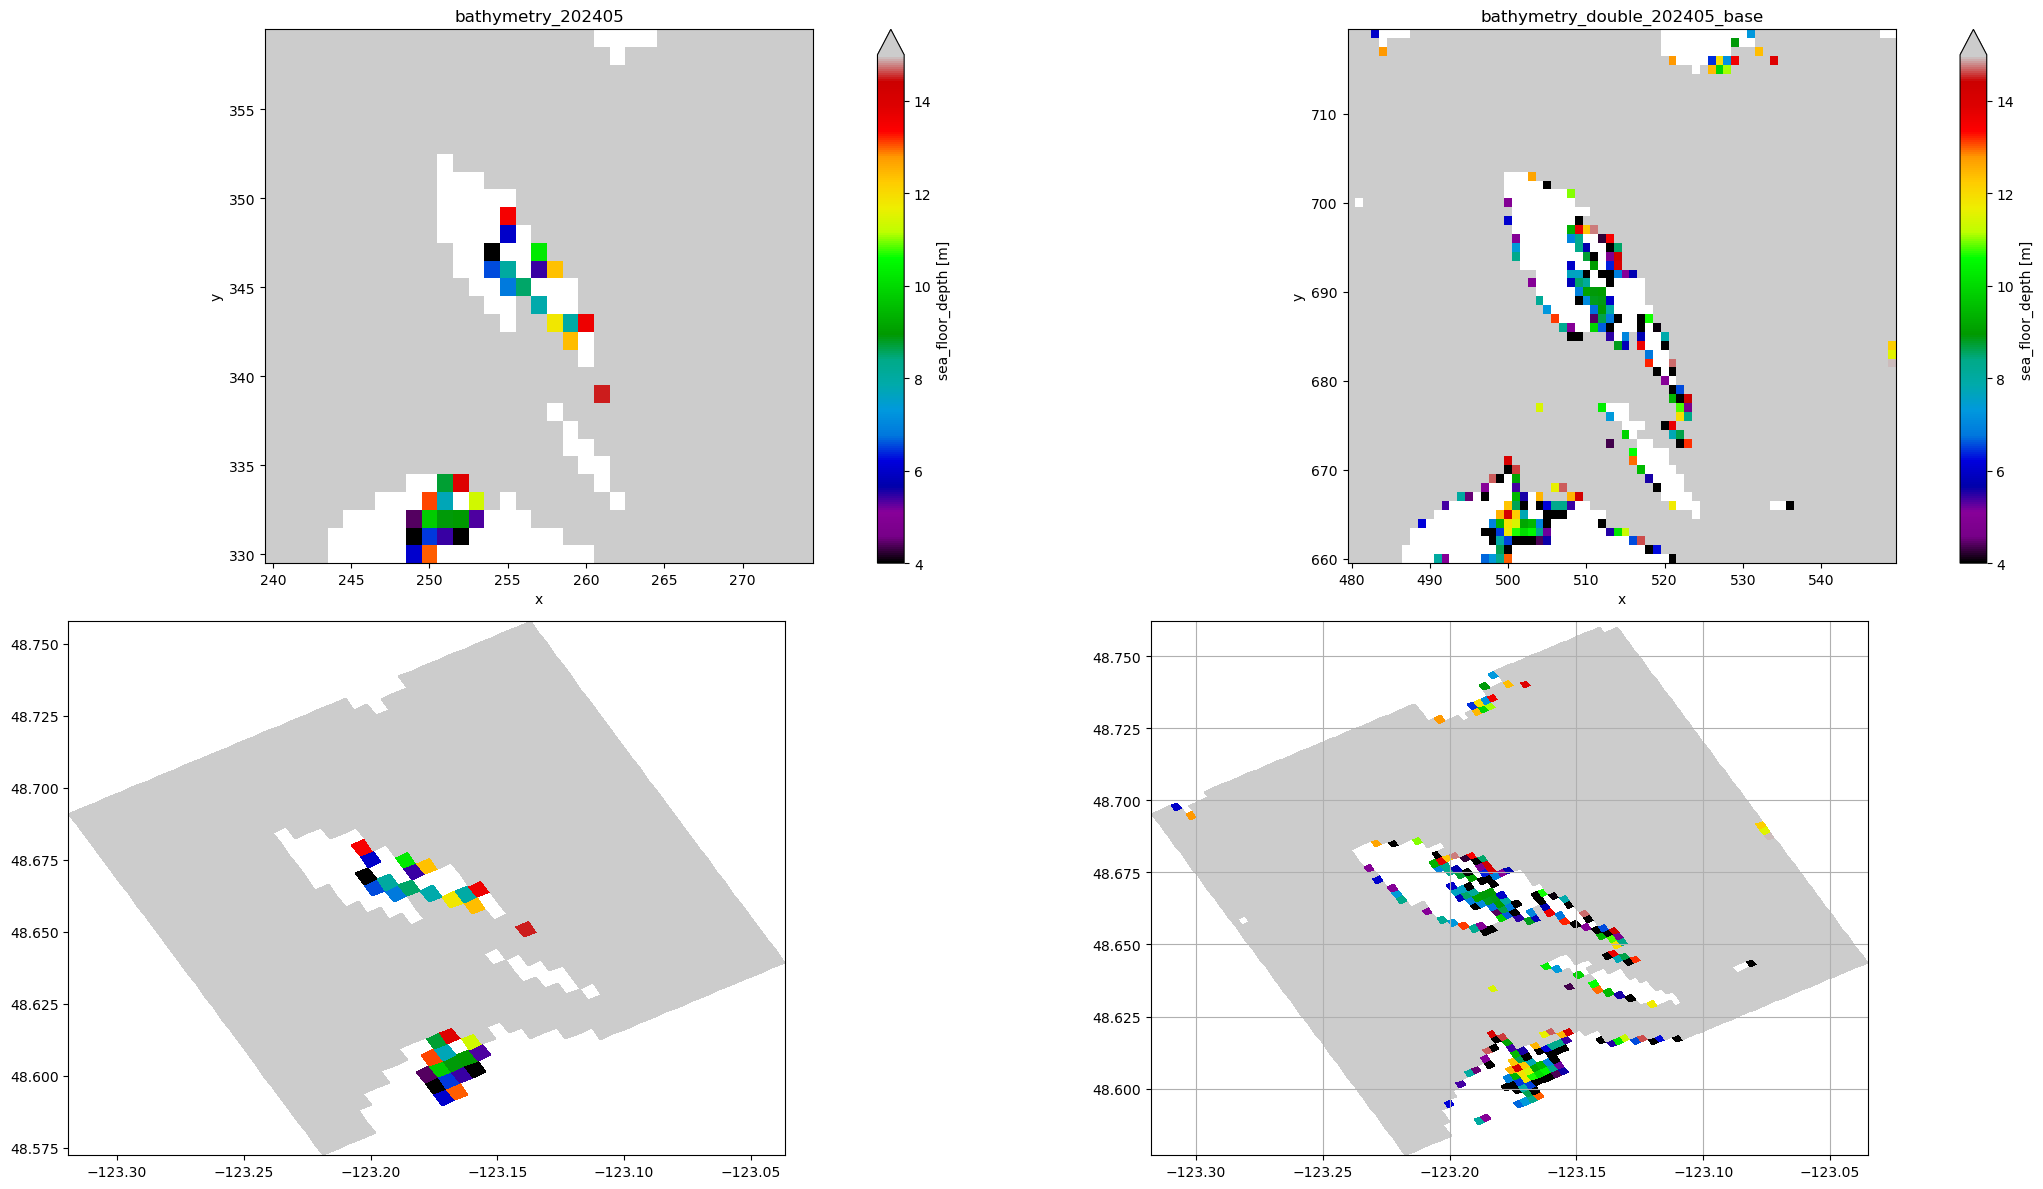

In [31]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base)

### Tile 10, 9 - Waldron Island

* surface Skipjack Island

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

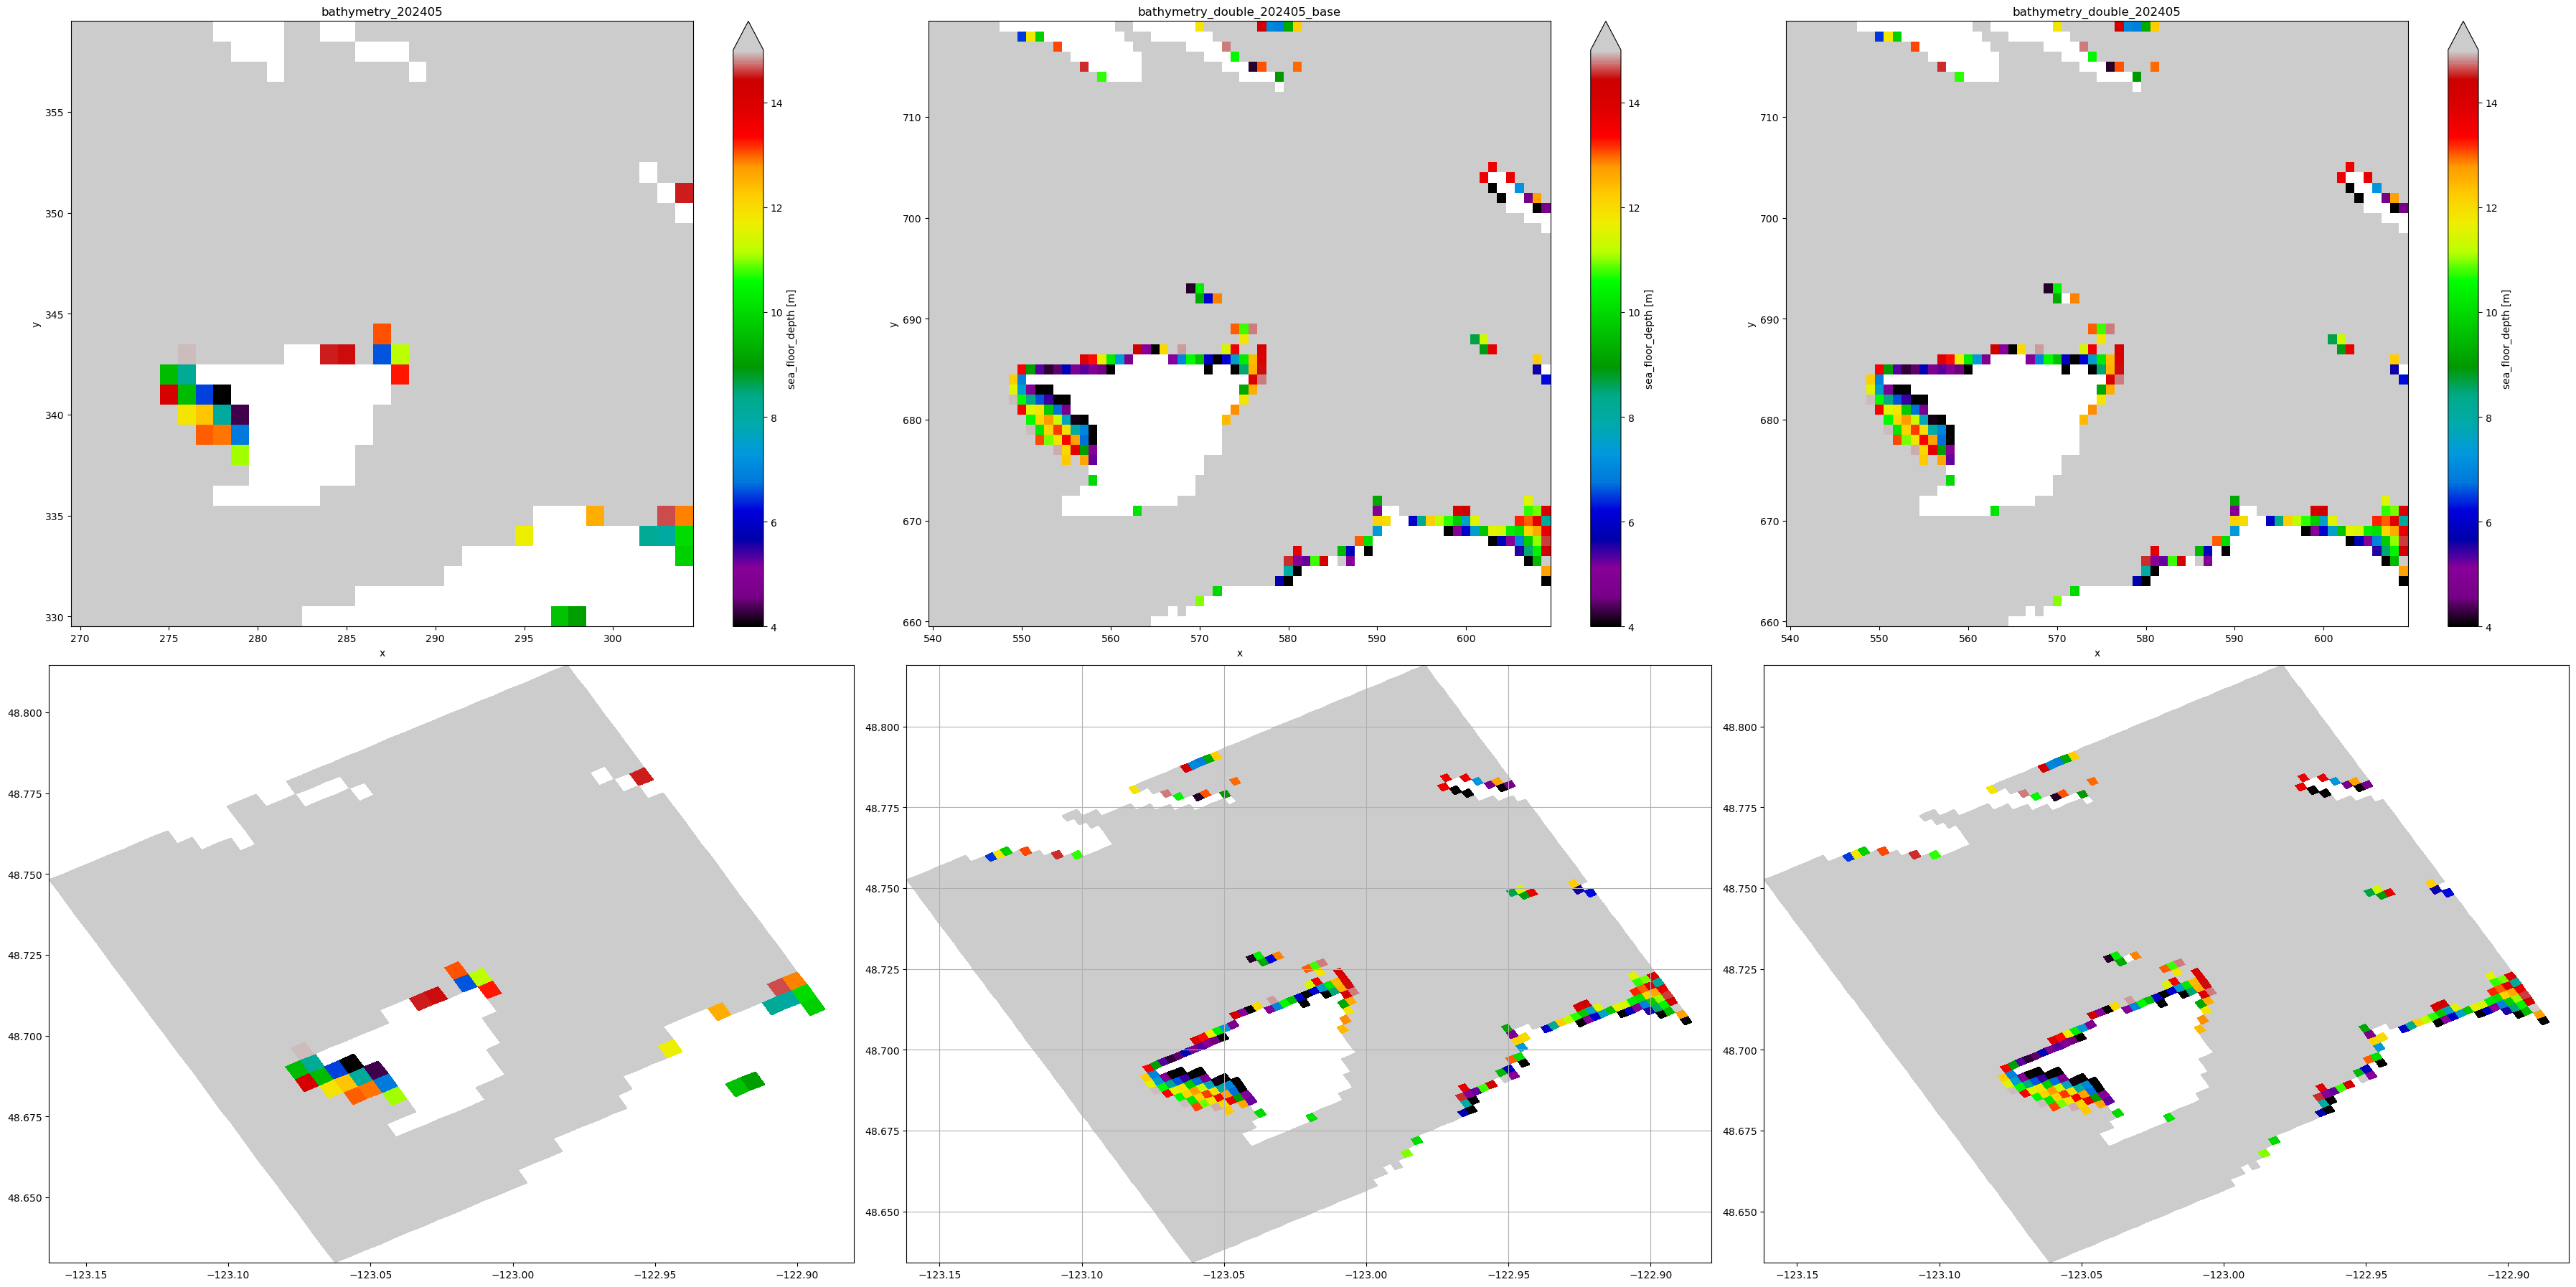

In [32]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 10, 10 - Sucia Islands

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

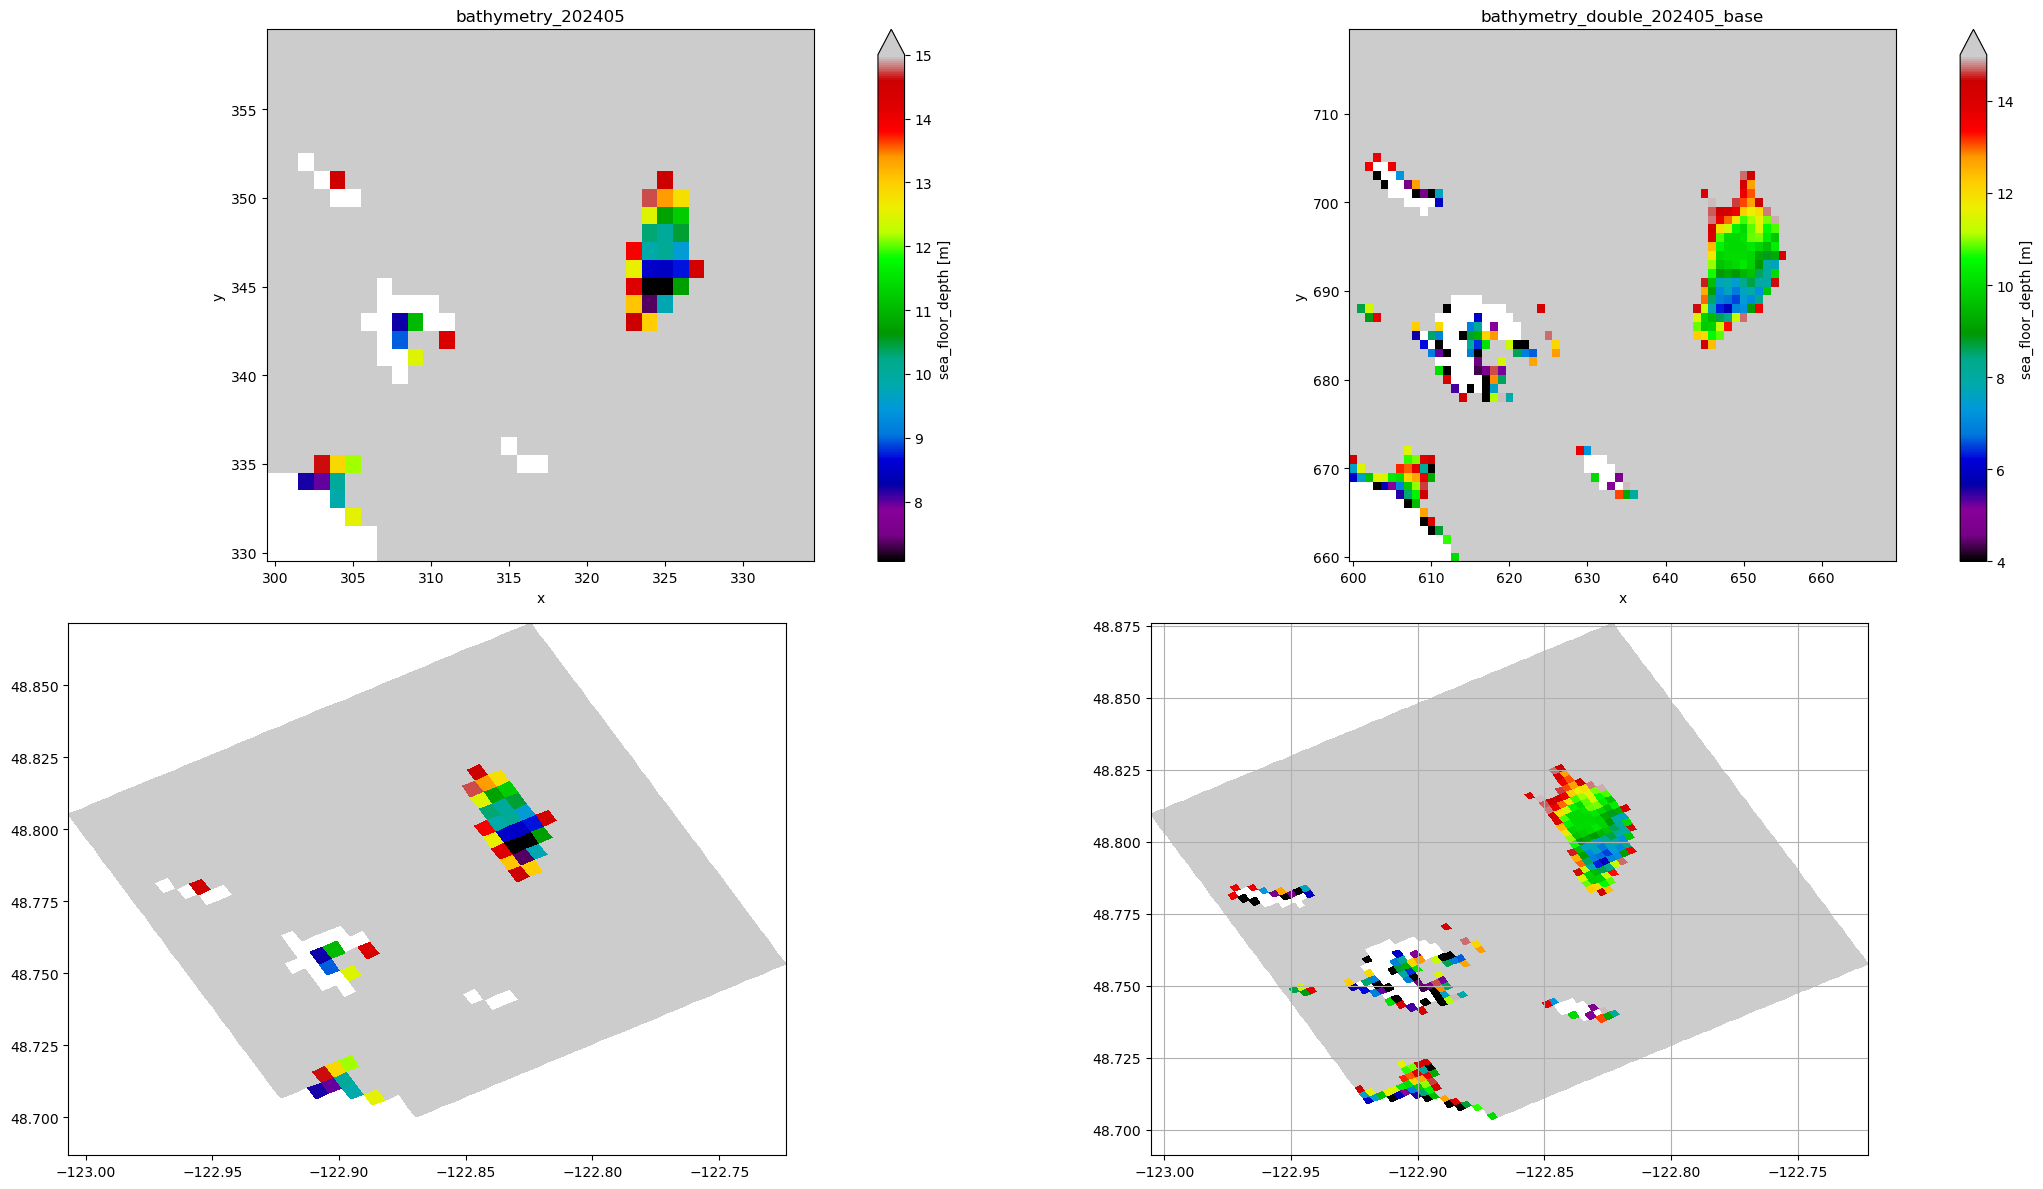

In [33]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base)

### Tile 10, 11 - Neptune Beach

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

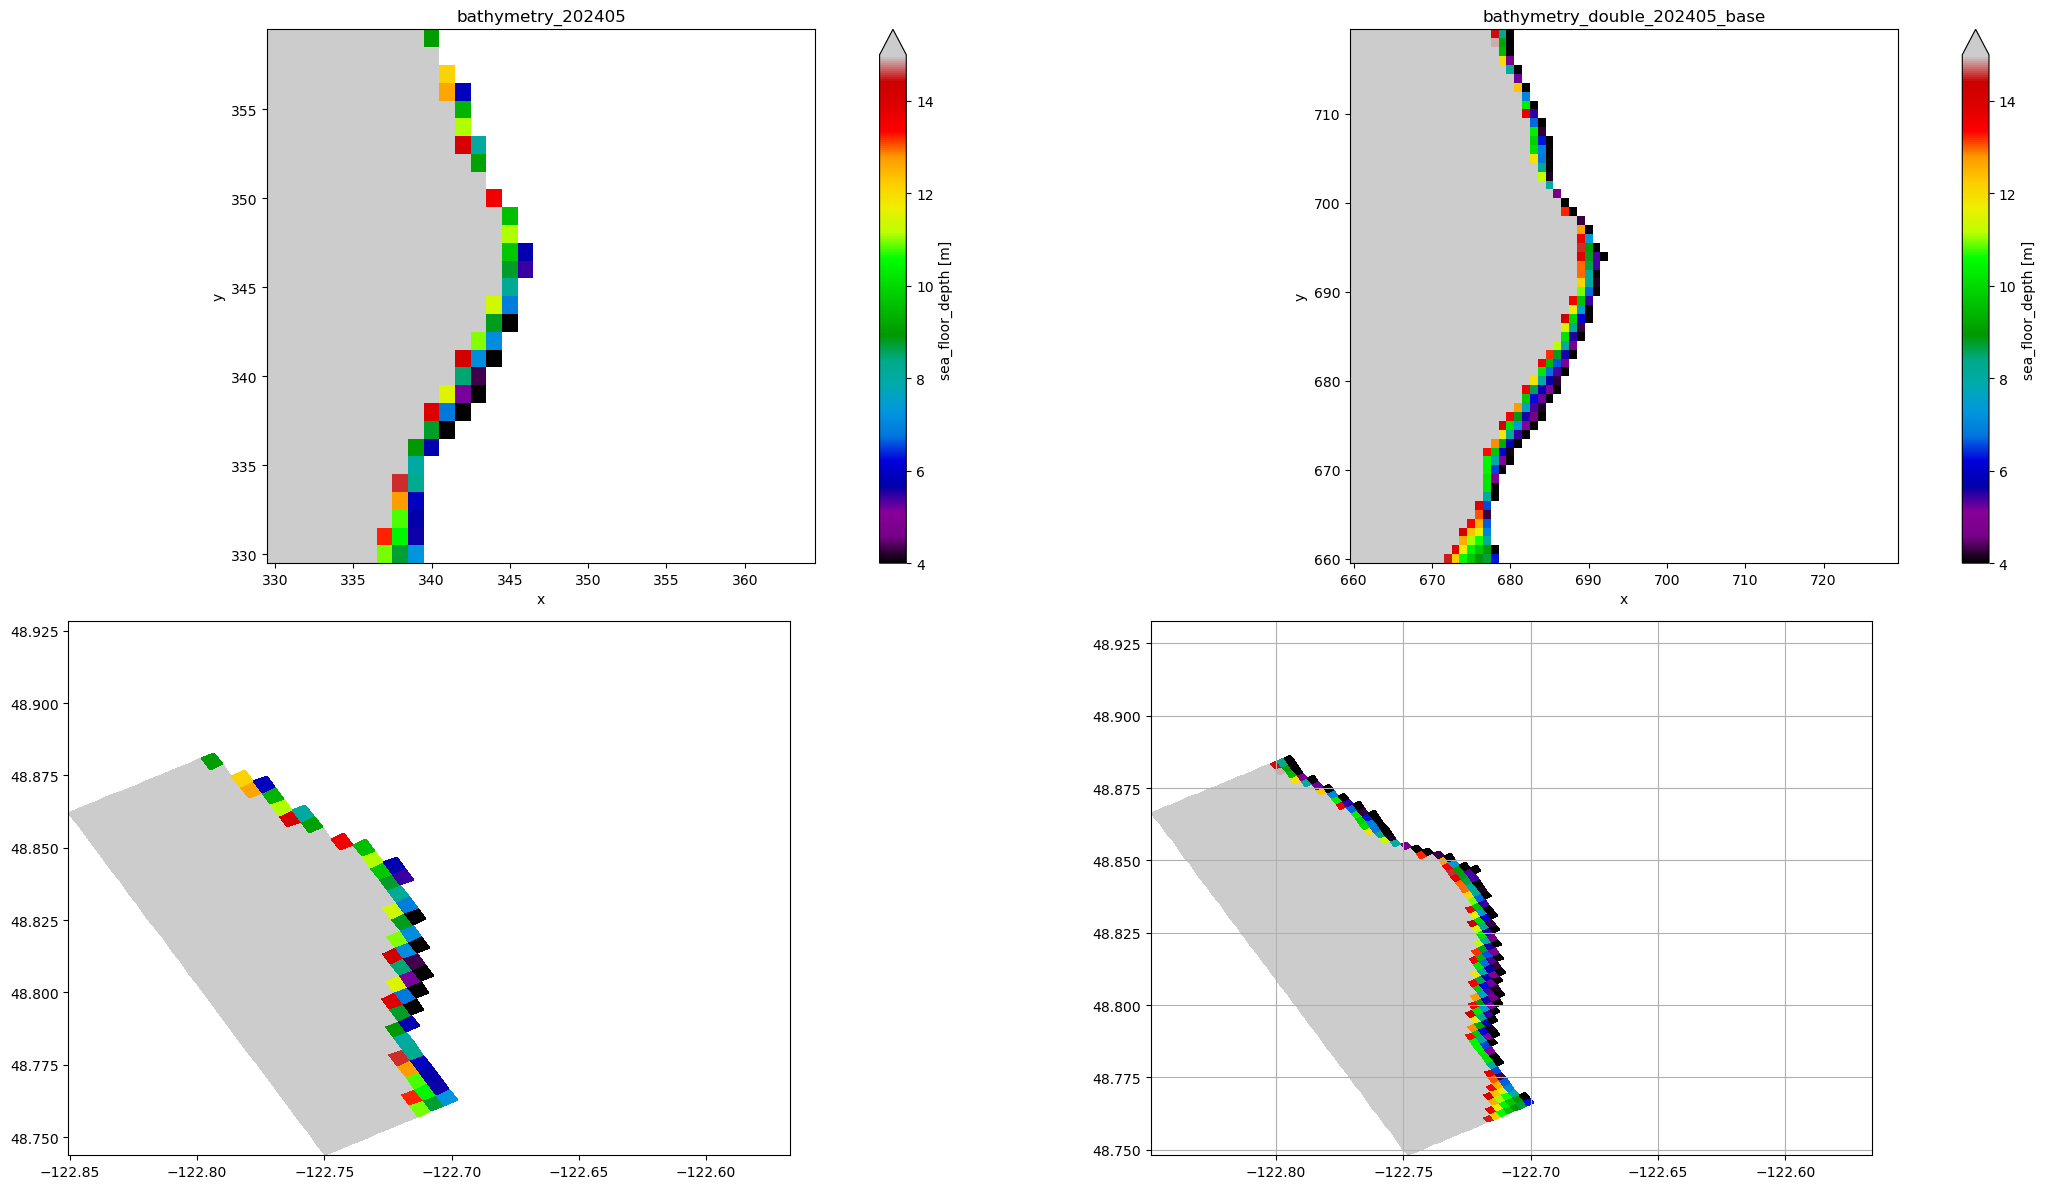

In [34]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base)

### Tile 10, 12

* all land, but also the south end of the Fraser River proxy

## Row 11 - Neah Bay to Semiahmoo Bay

In [35]:
y_min_max = numpy.array([360, 390])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 11, 0 - Neah Bay to Sekiu River

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

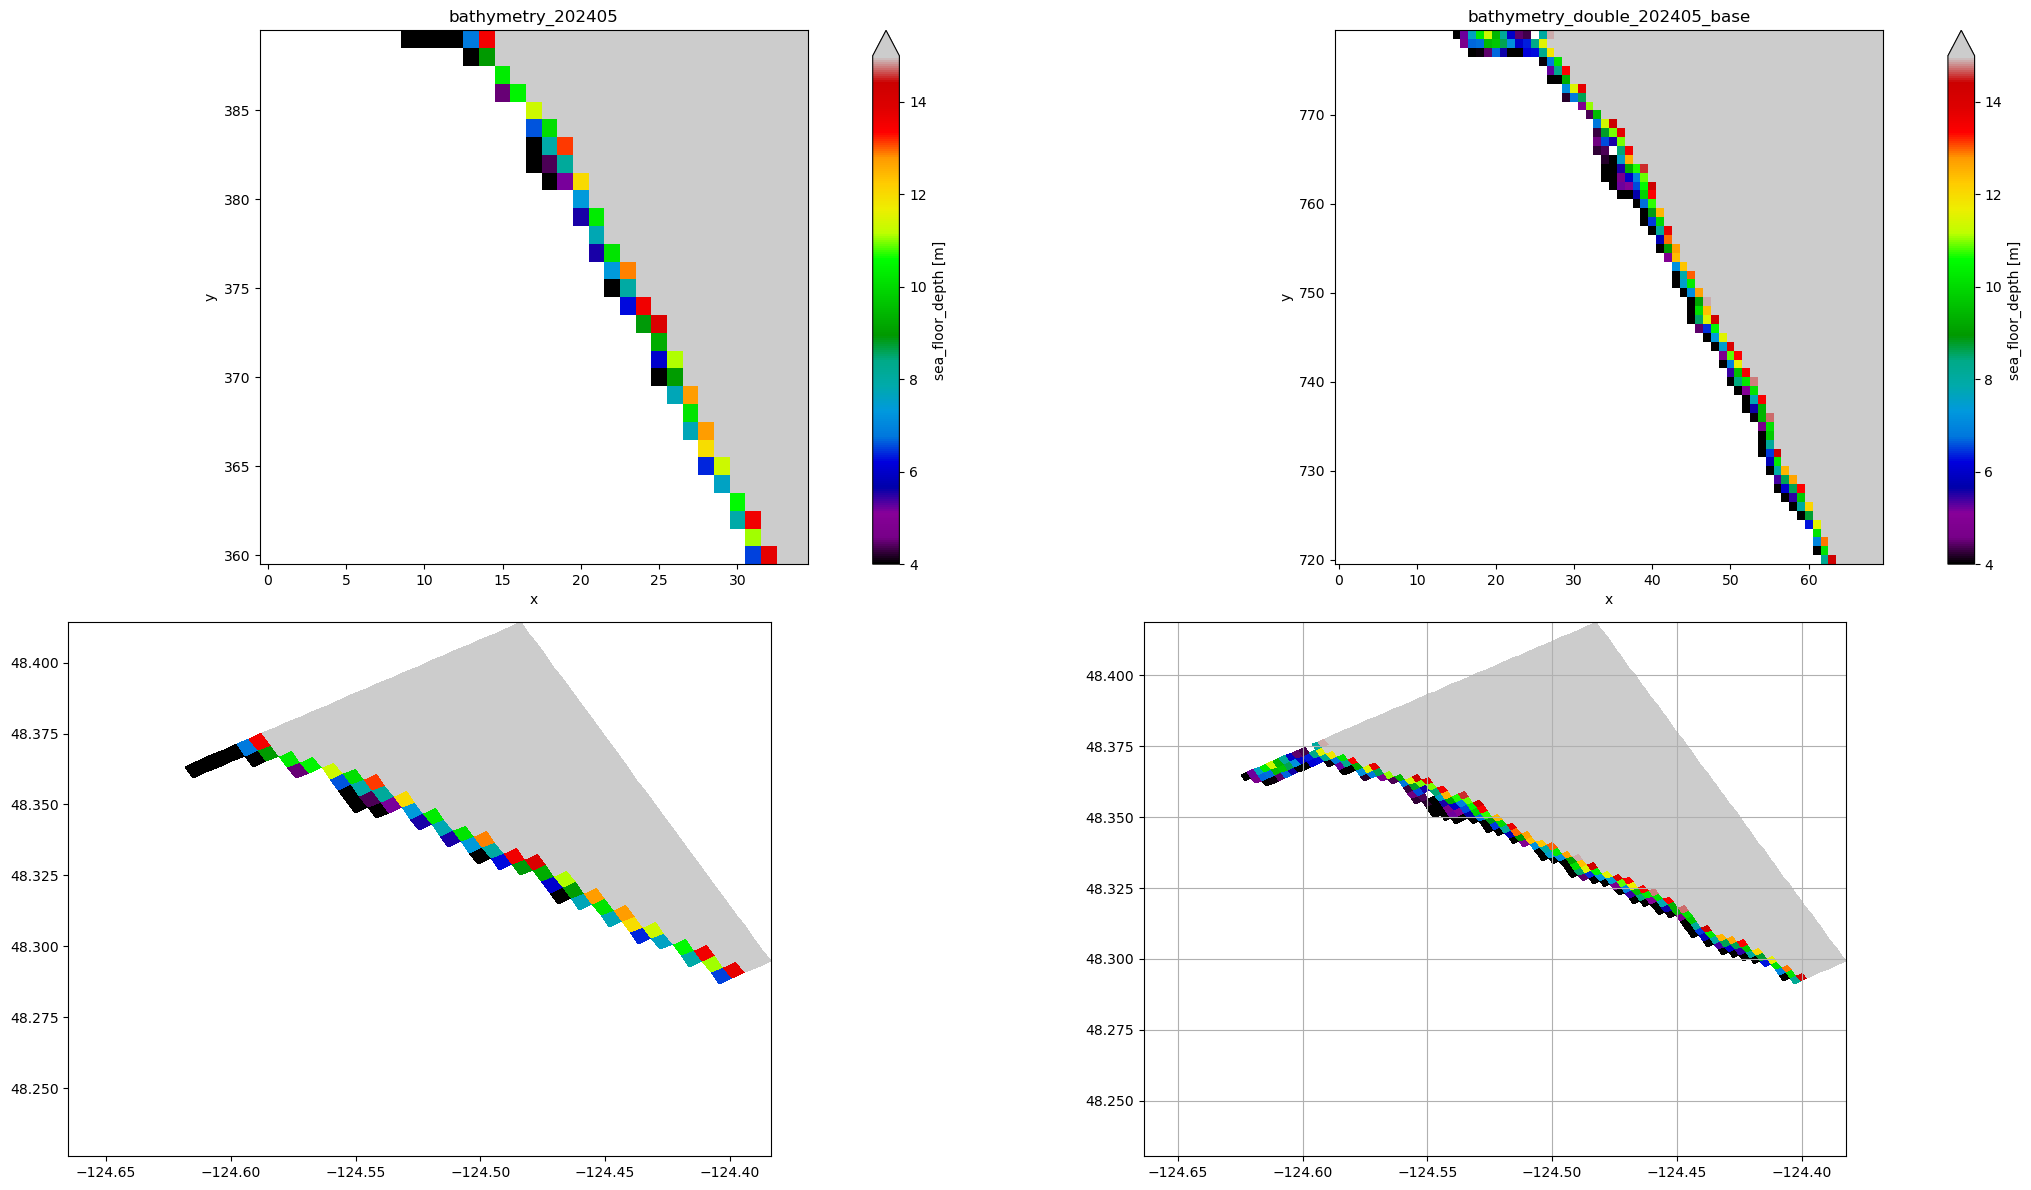

In [36]:
plot_tile(tile_x_min_max[0], y_slices, bathy, dbl_bathy_base)

### Tile 11, 1

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

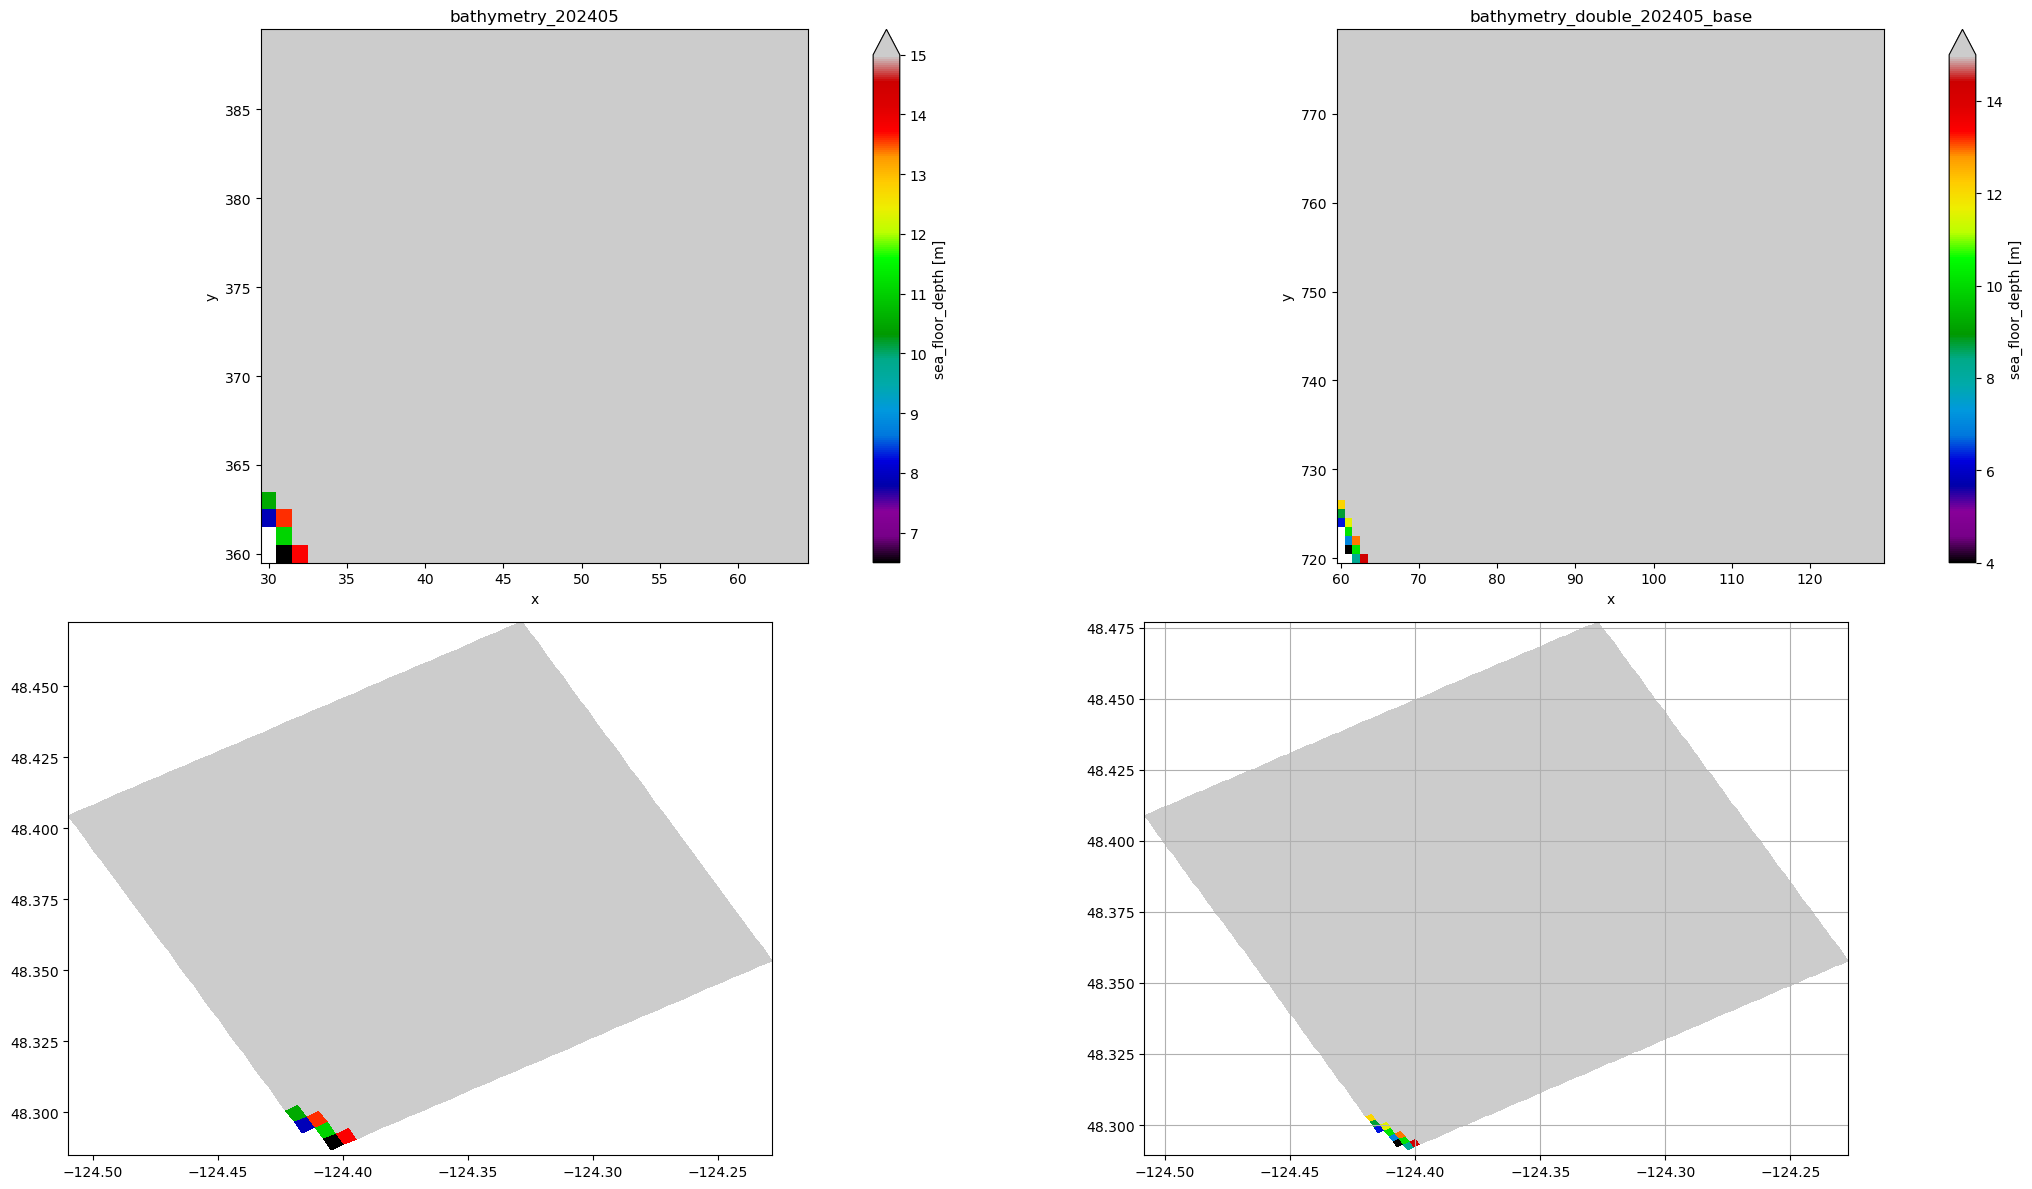

In [37]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 11, 2 - Sombrio Beach to China Beach

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

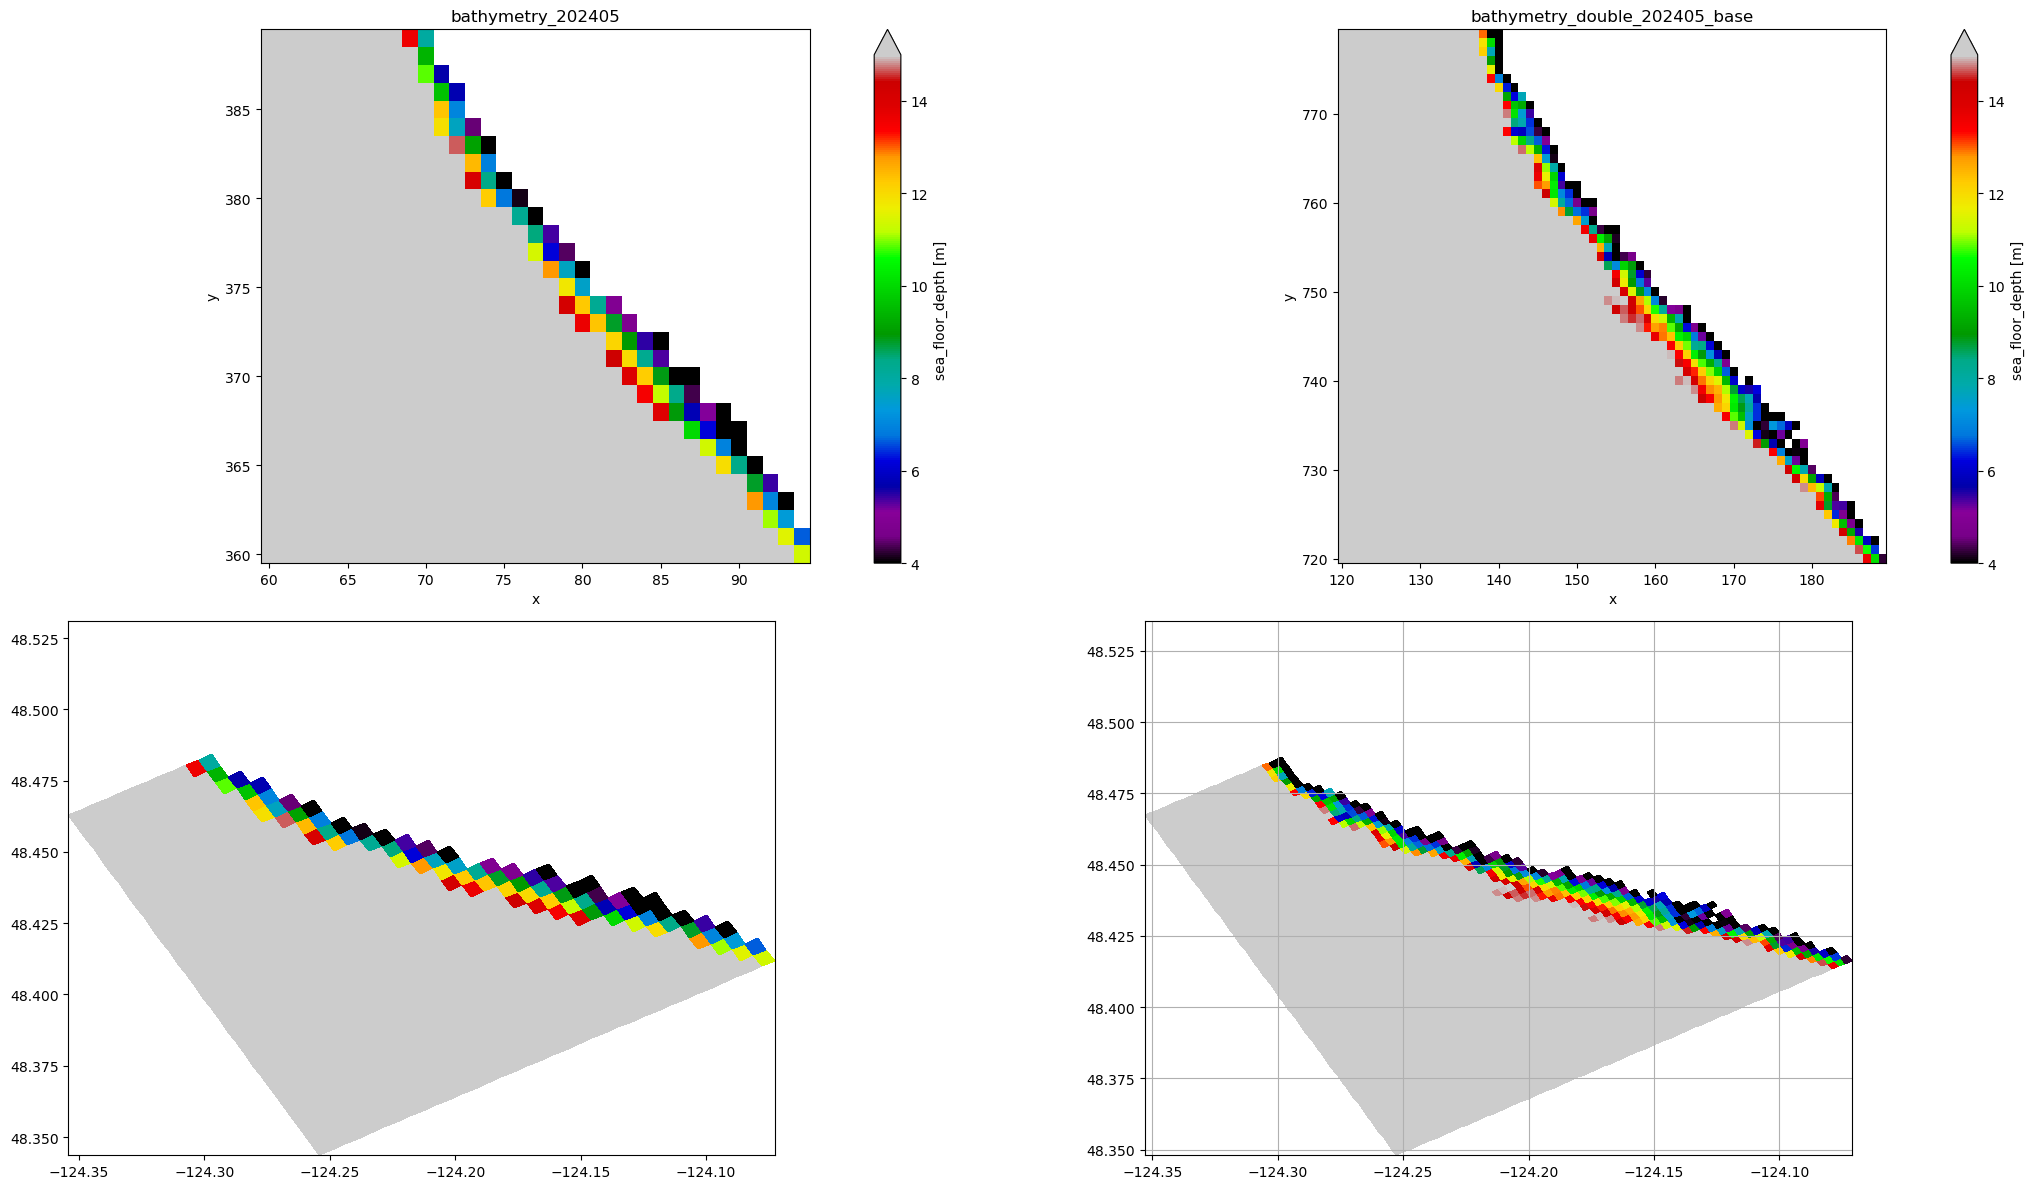

In [38]:
plot_tile(tile_x_min_max[2], y_slices, bathy, dbl_bathy_base)

### Tile 11, 3

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

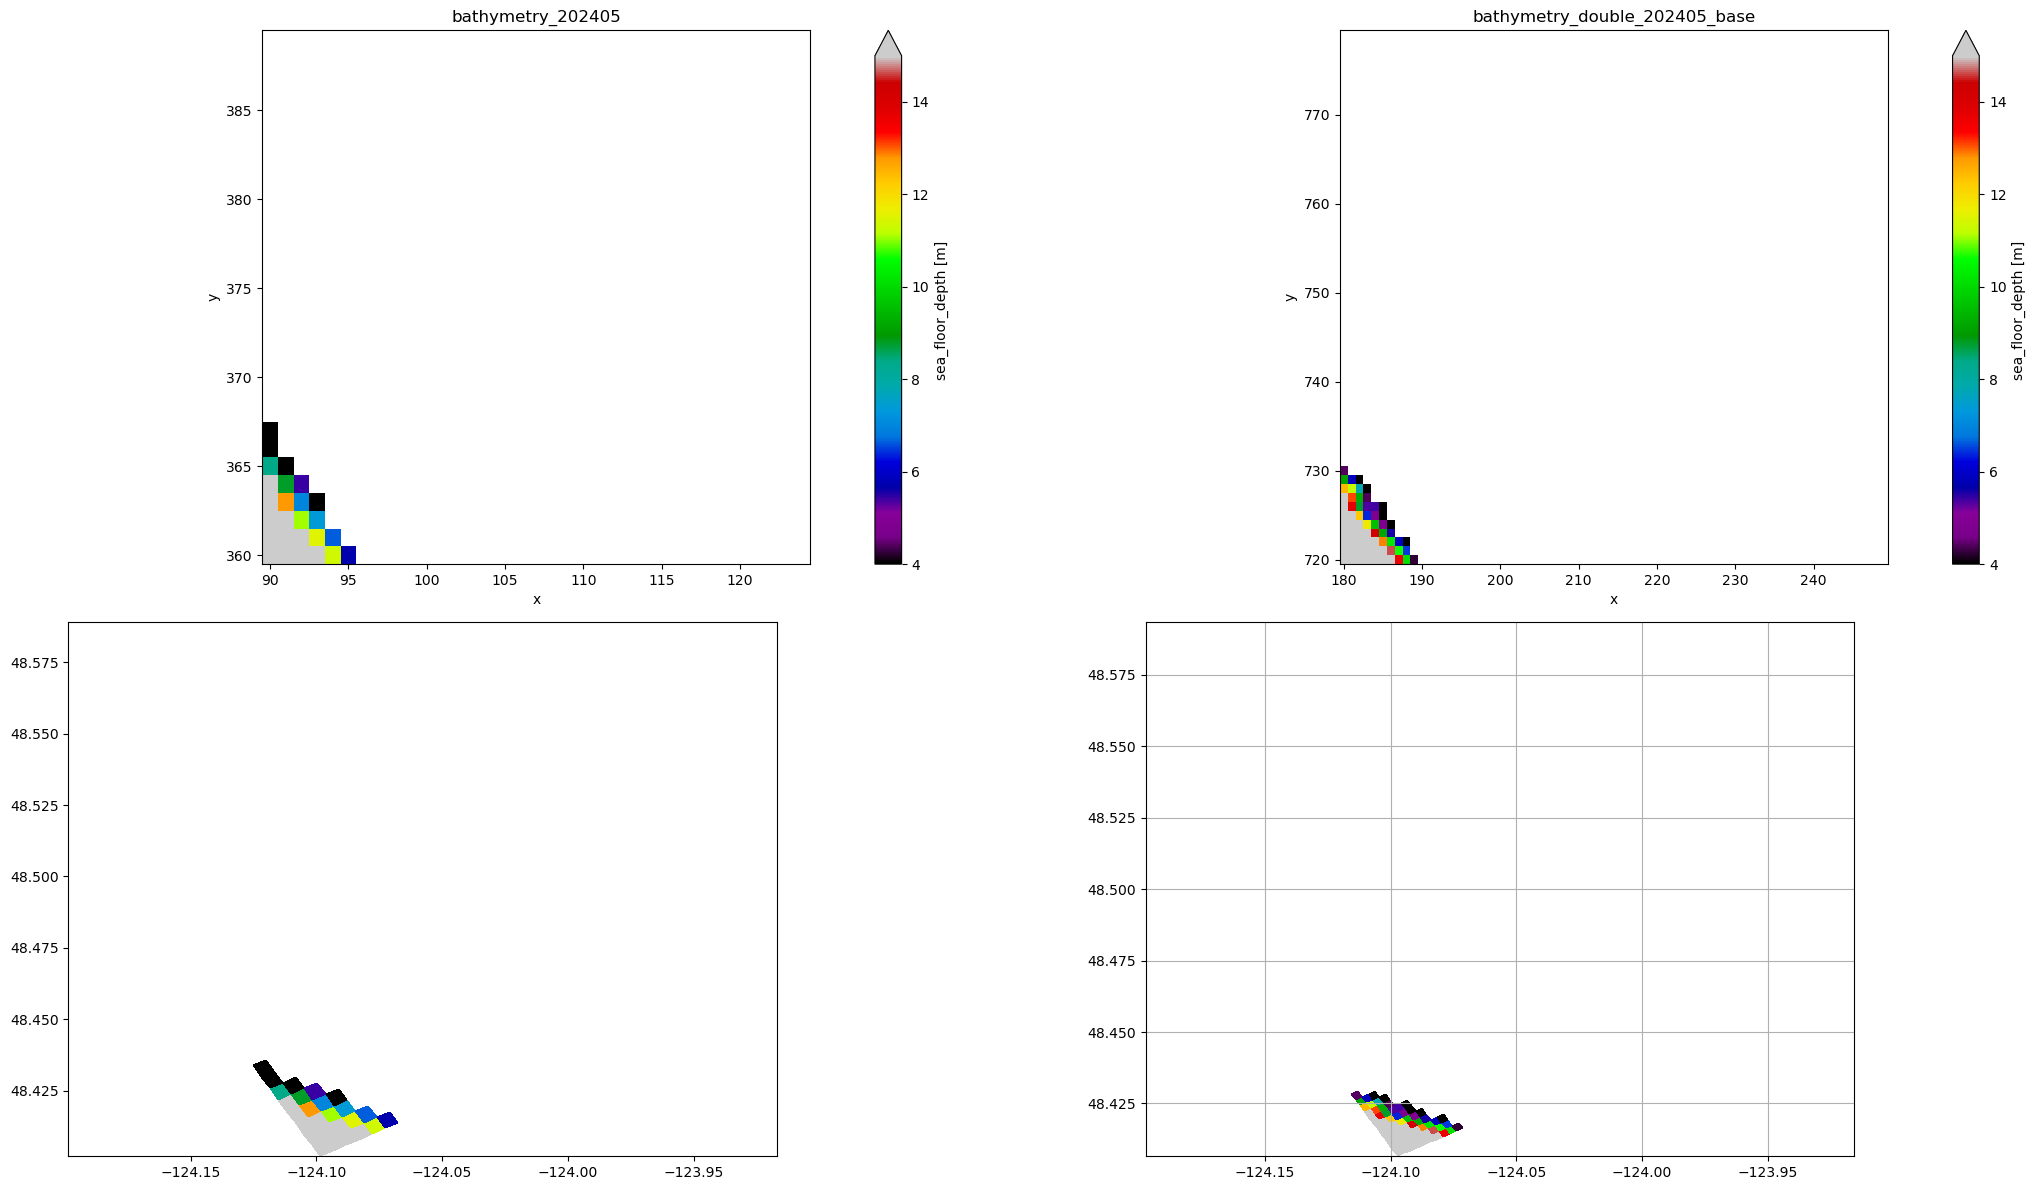

In [39]:
plot_tile(tile_x_min_max[3], y_slices, bathy, dbl_bathy_base)

### Tile 11, 4

* all land

### Tile 11, 5

* all land

### Tile 11, 6 - North Saanish Inlet (Mill Bay to Genoa Bay

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

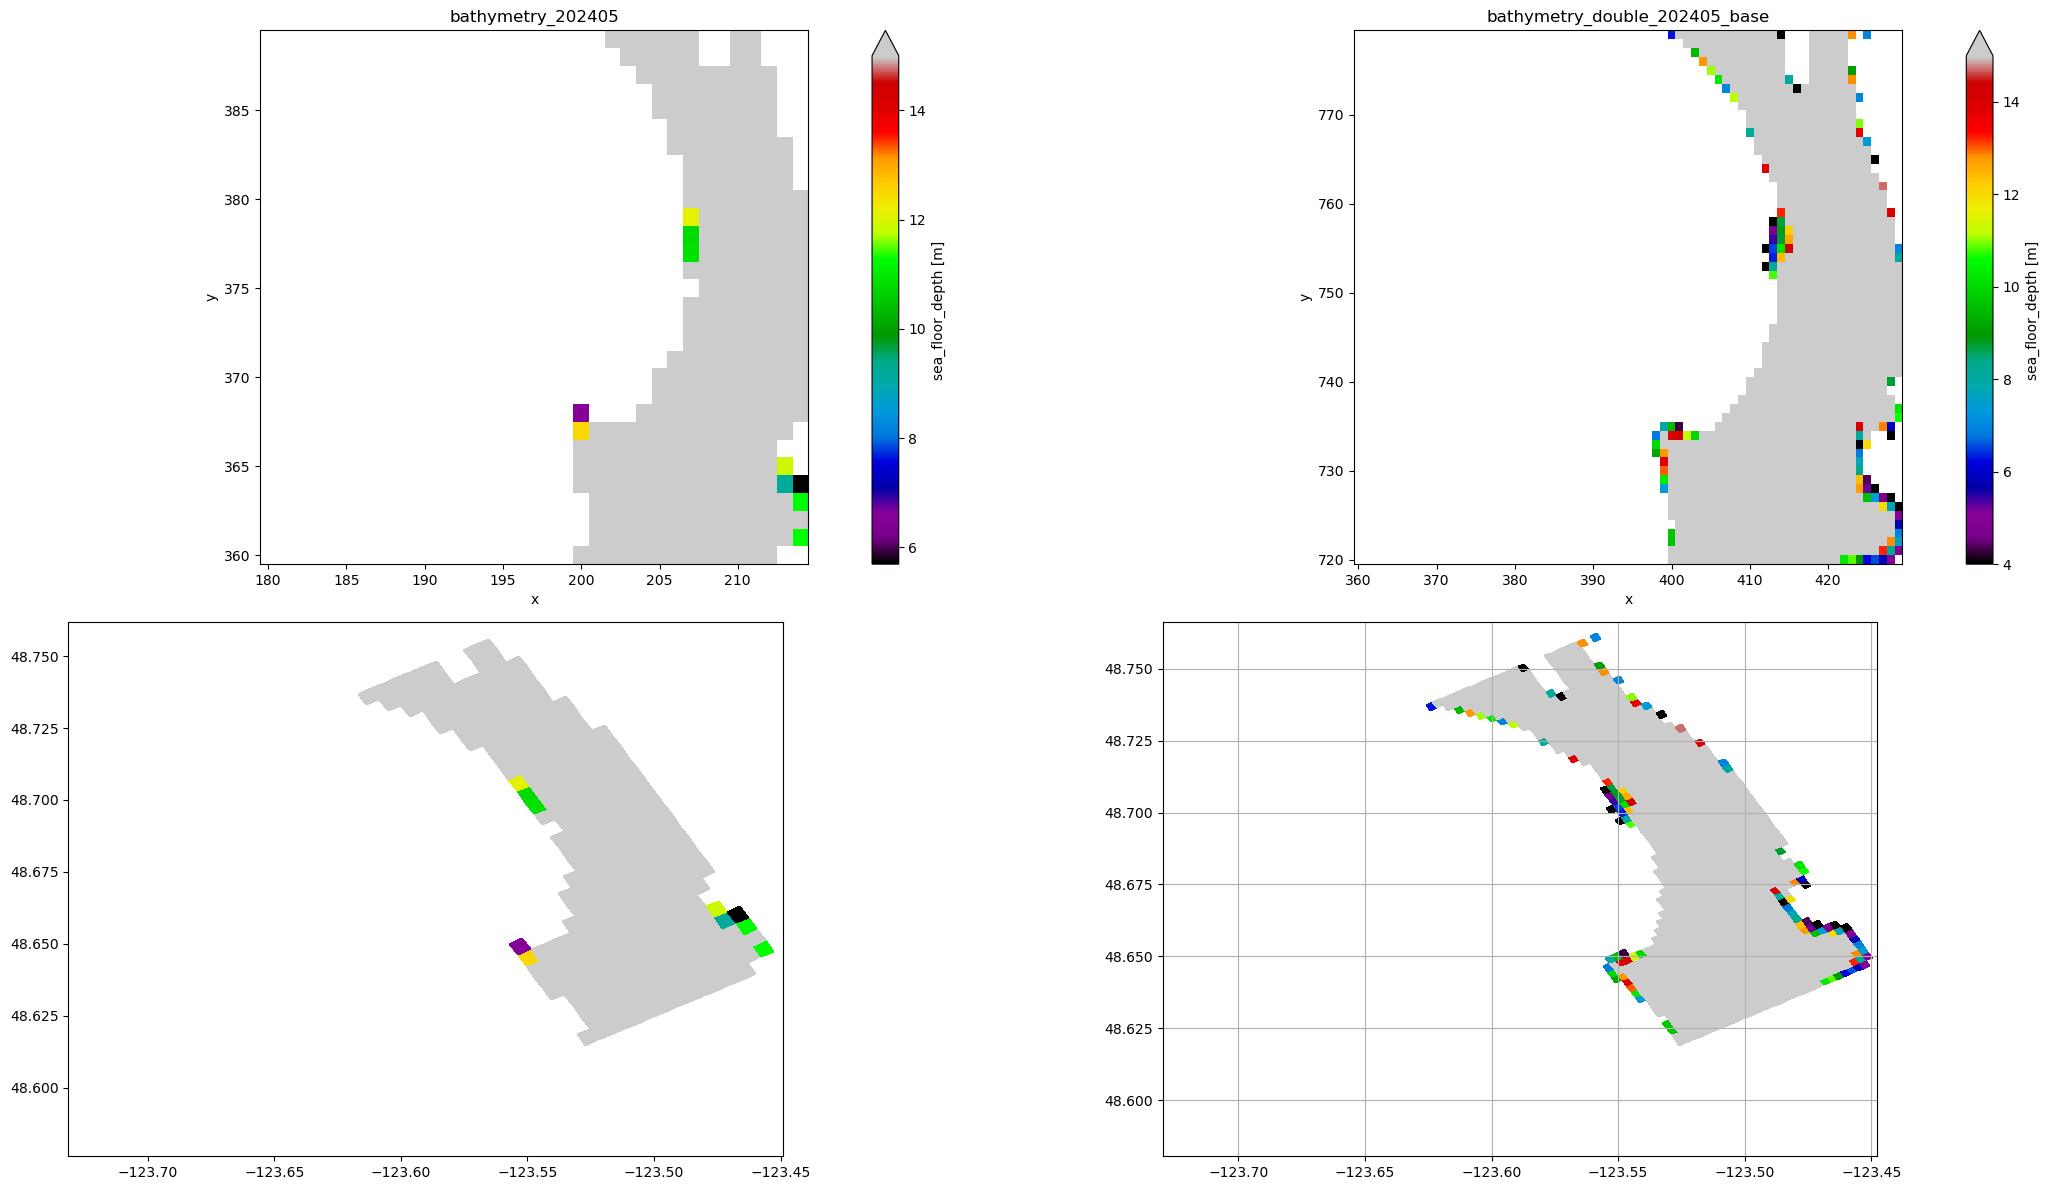

In [40]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base)

### Tile 11, 7 - Fulford Harbour

* surface Piers Island, Knapp Island & Pym Island

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

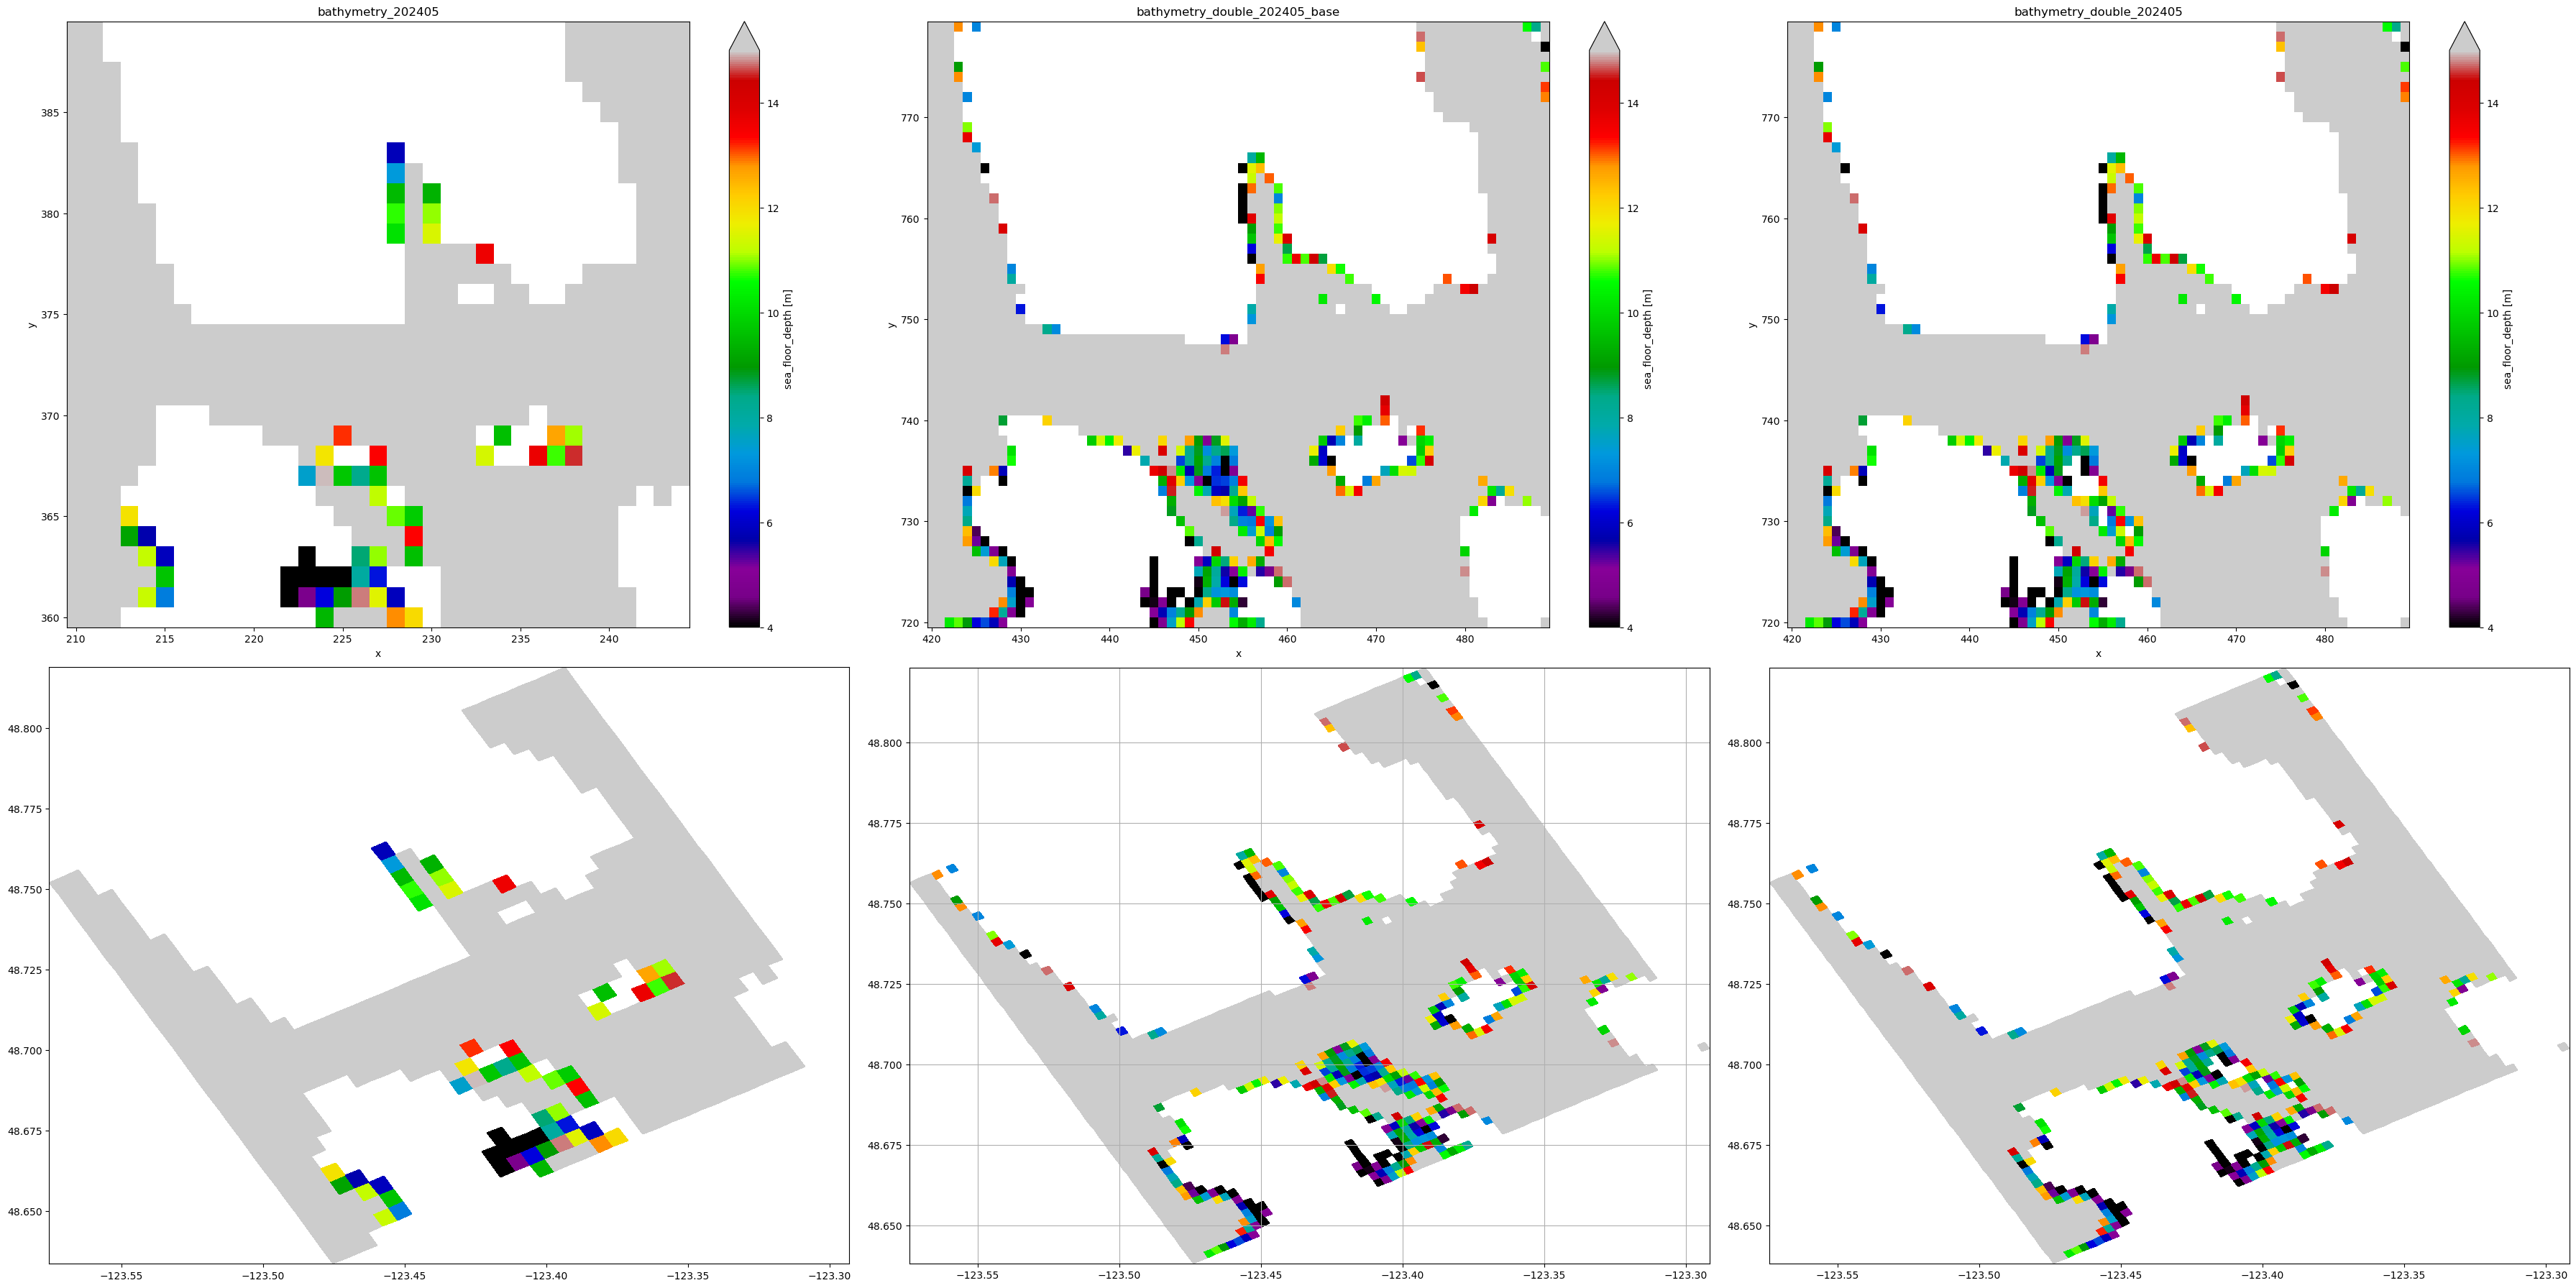

In [41]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 11, 8 - Pender Island, Mayne Island & Saturna Island

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

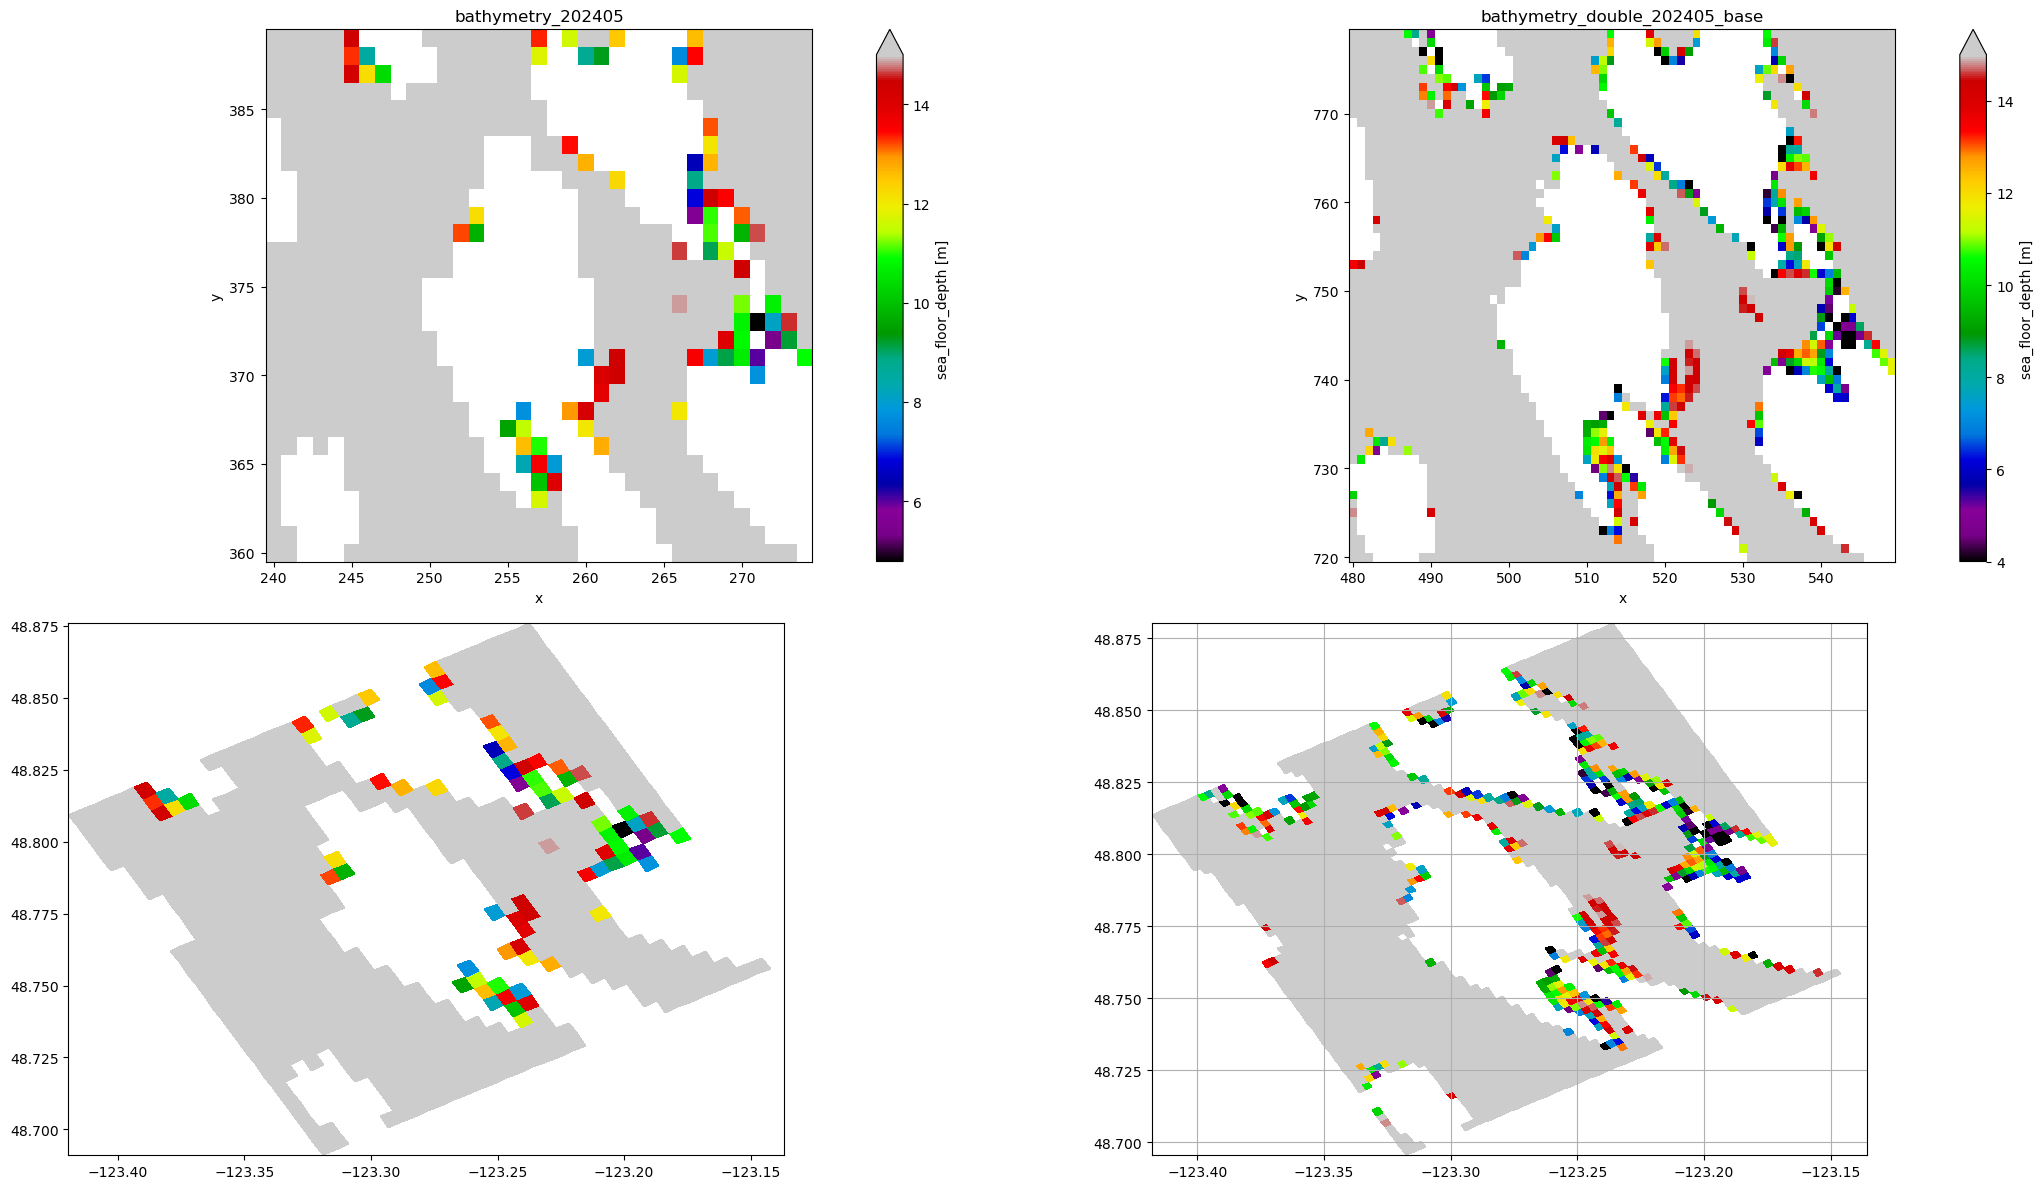

In [42]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base)

### Tile 11, 9 - Saturna Island & Tumbo Island

* surface Tumbo Island
* narrow Boat Passage
* open west entrance to Winter Cove

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

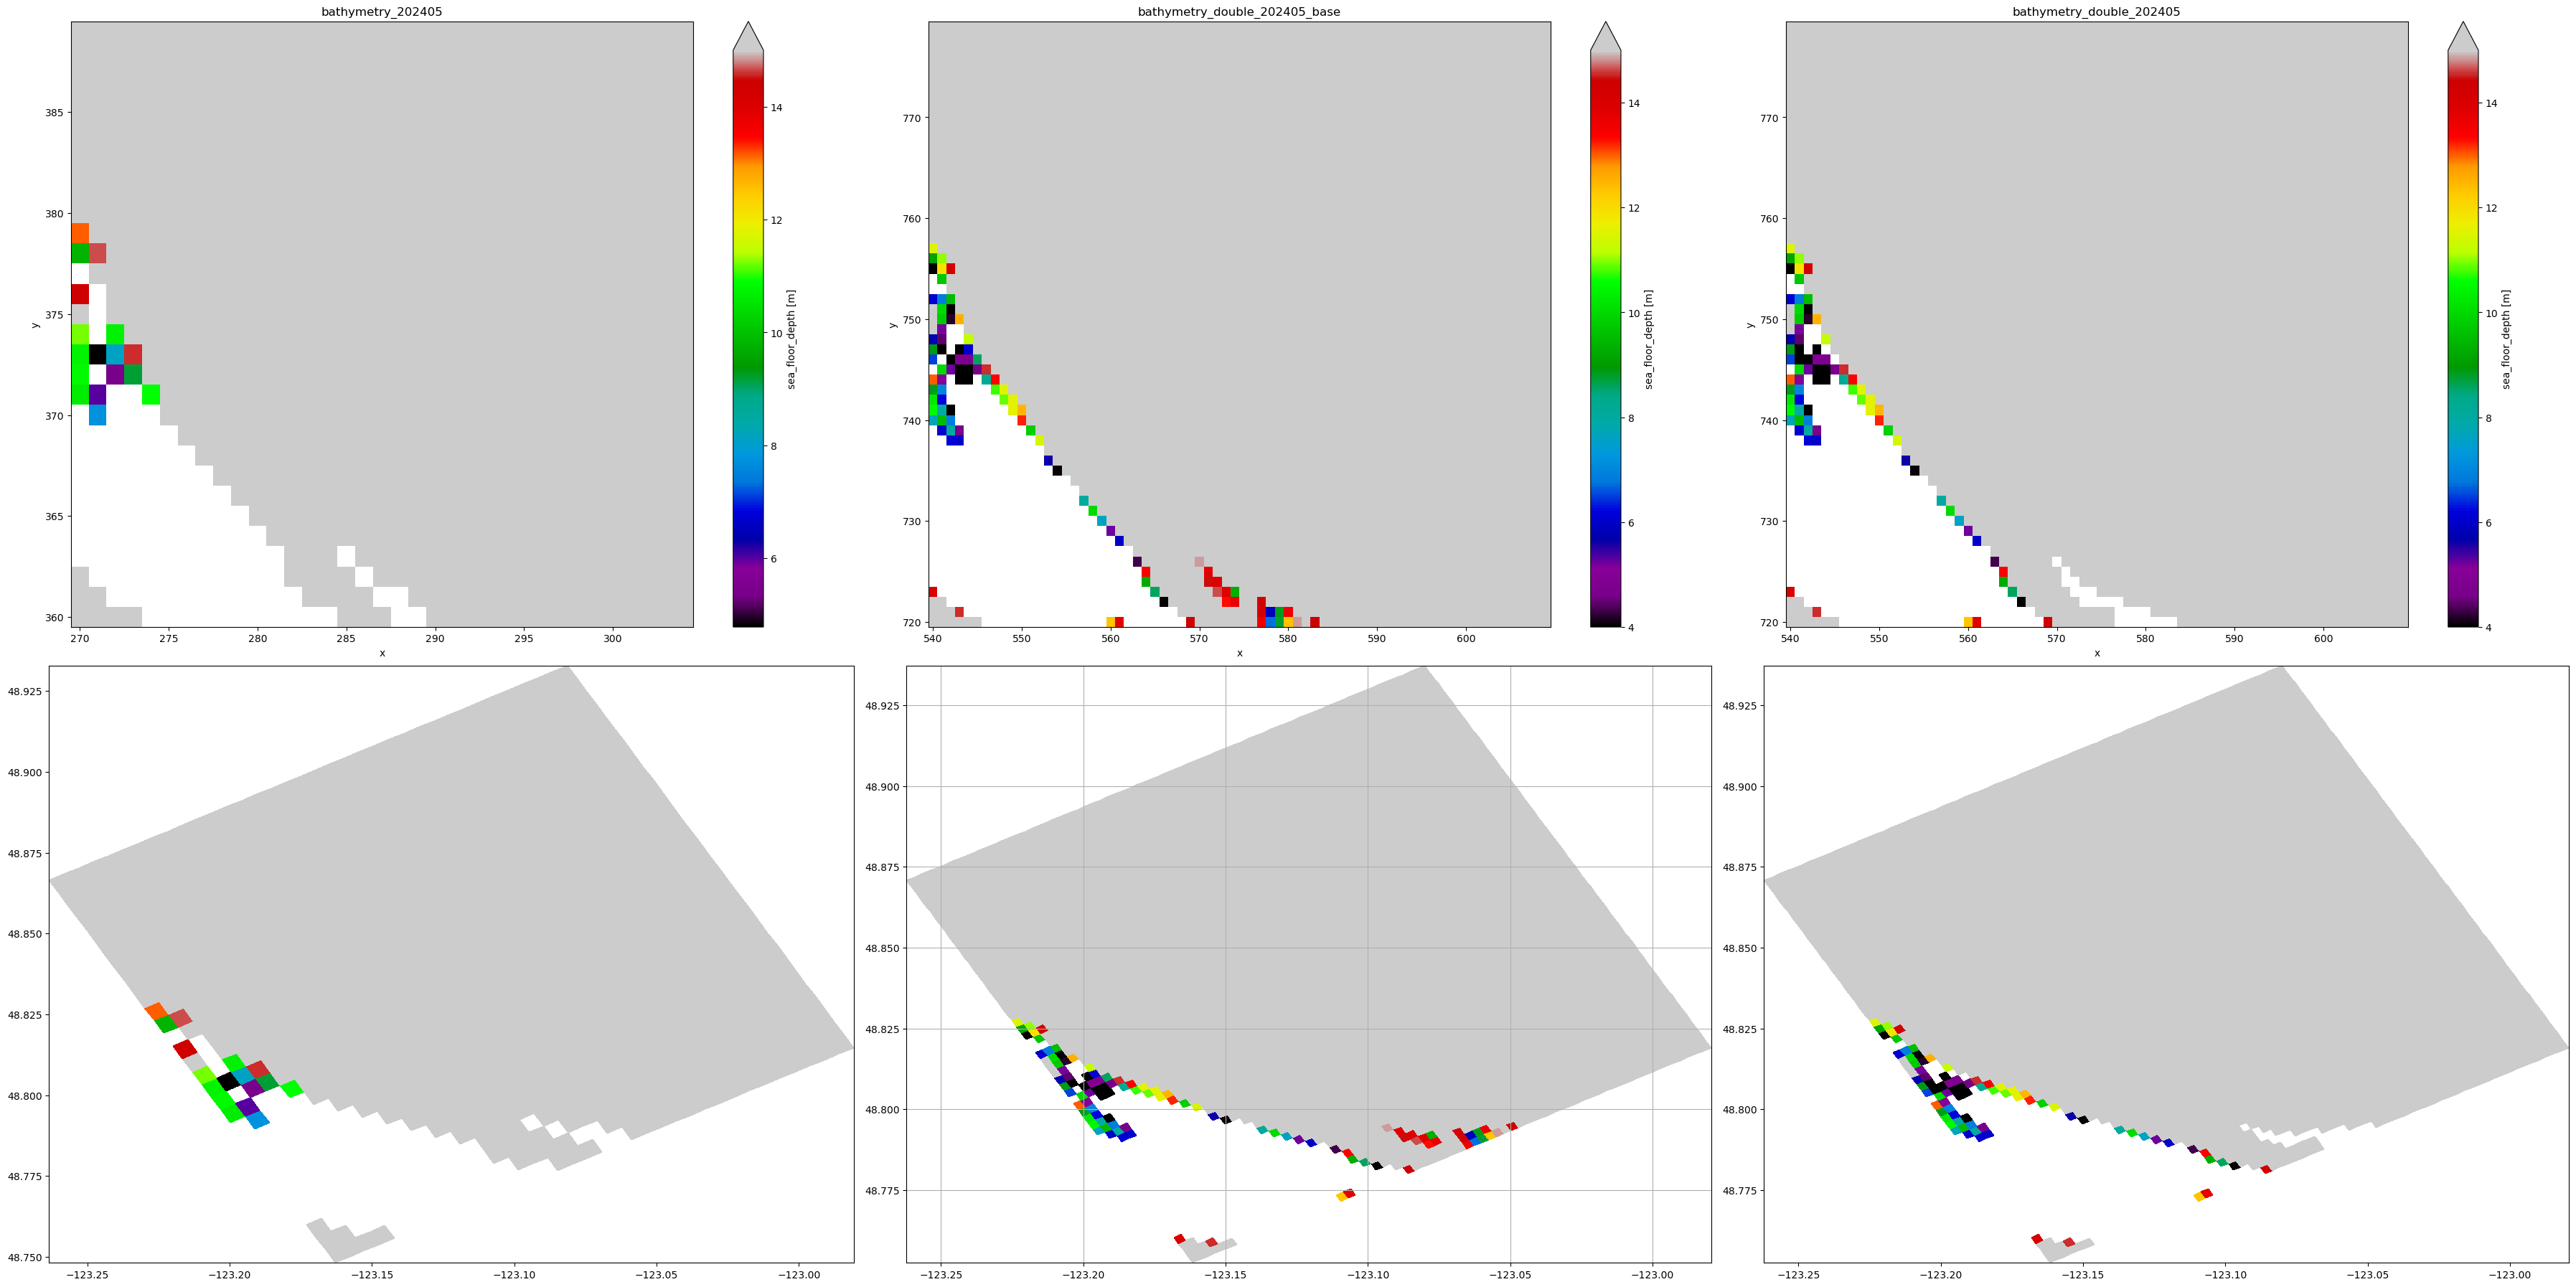

In [43]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 11, 10 - South of Point Roberts

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

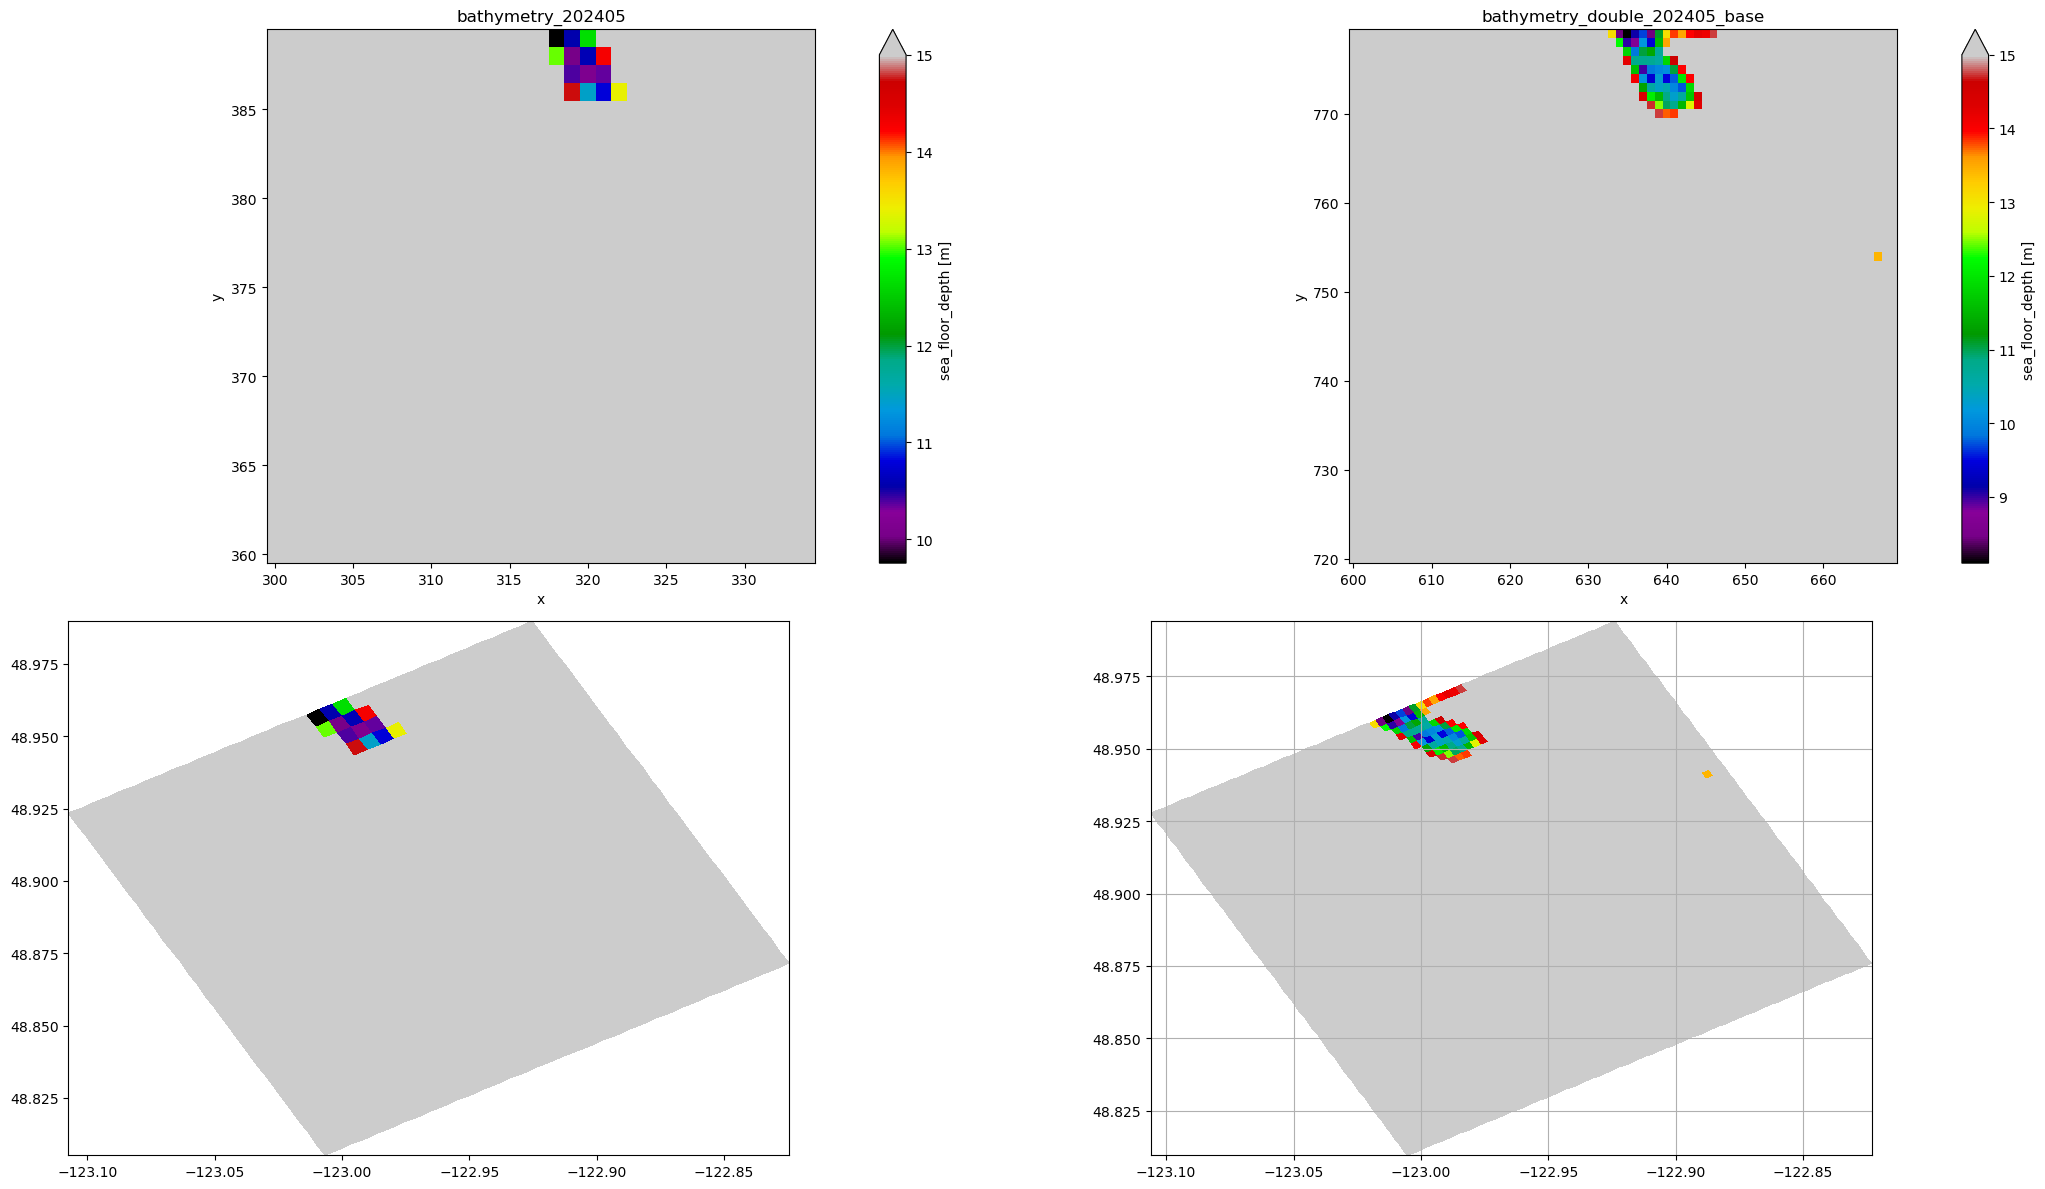

In [44]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base)

### Tile 11, 11 - Semiahmoo Bay & Drayton Harbor

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

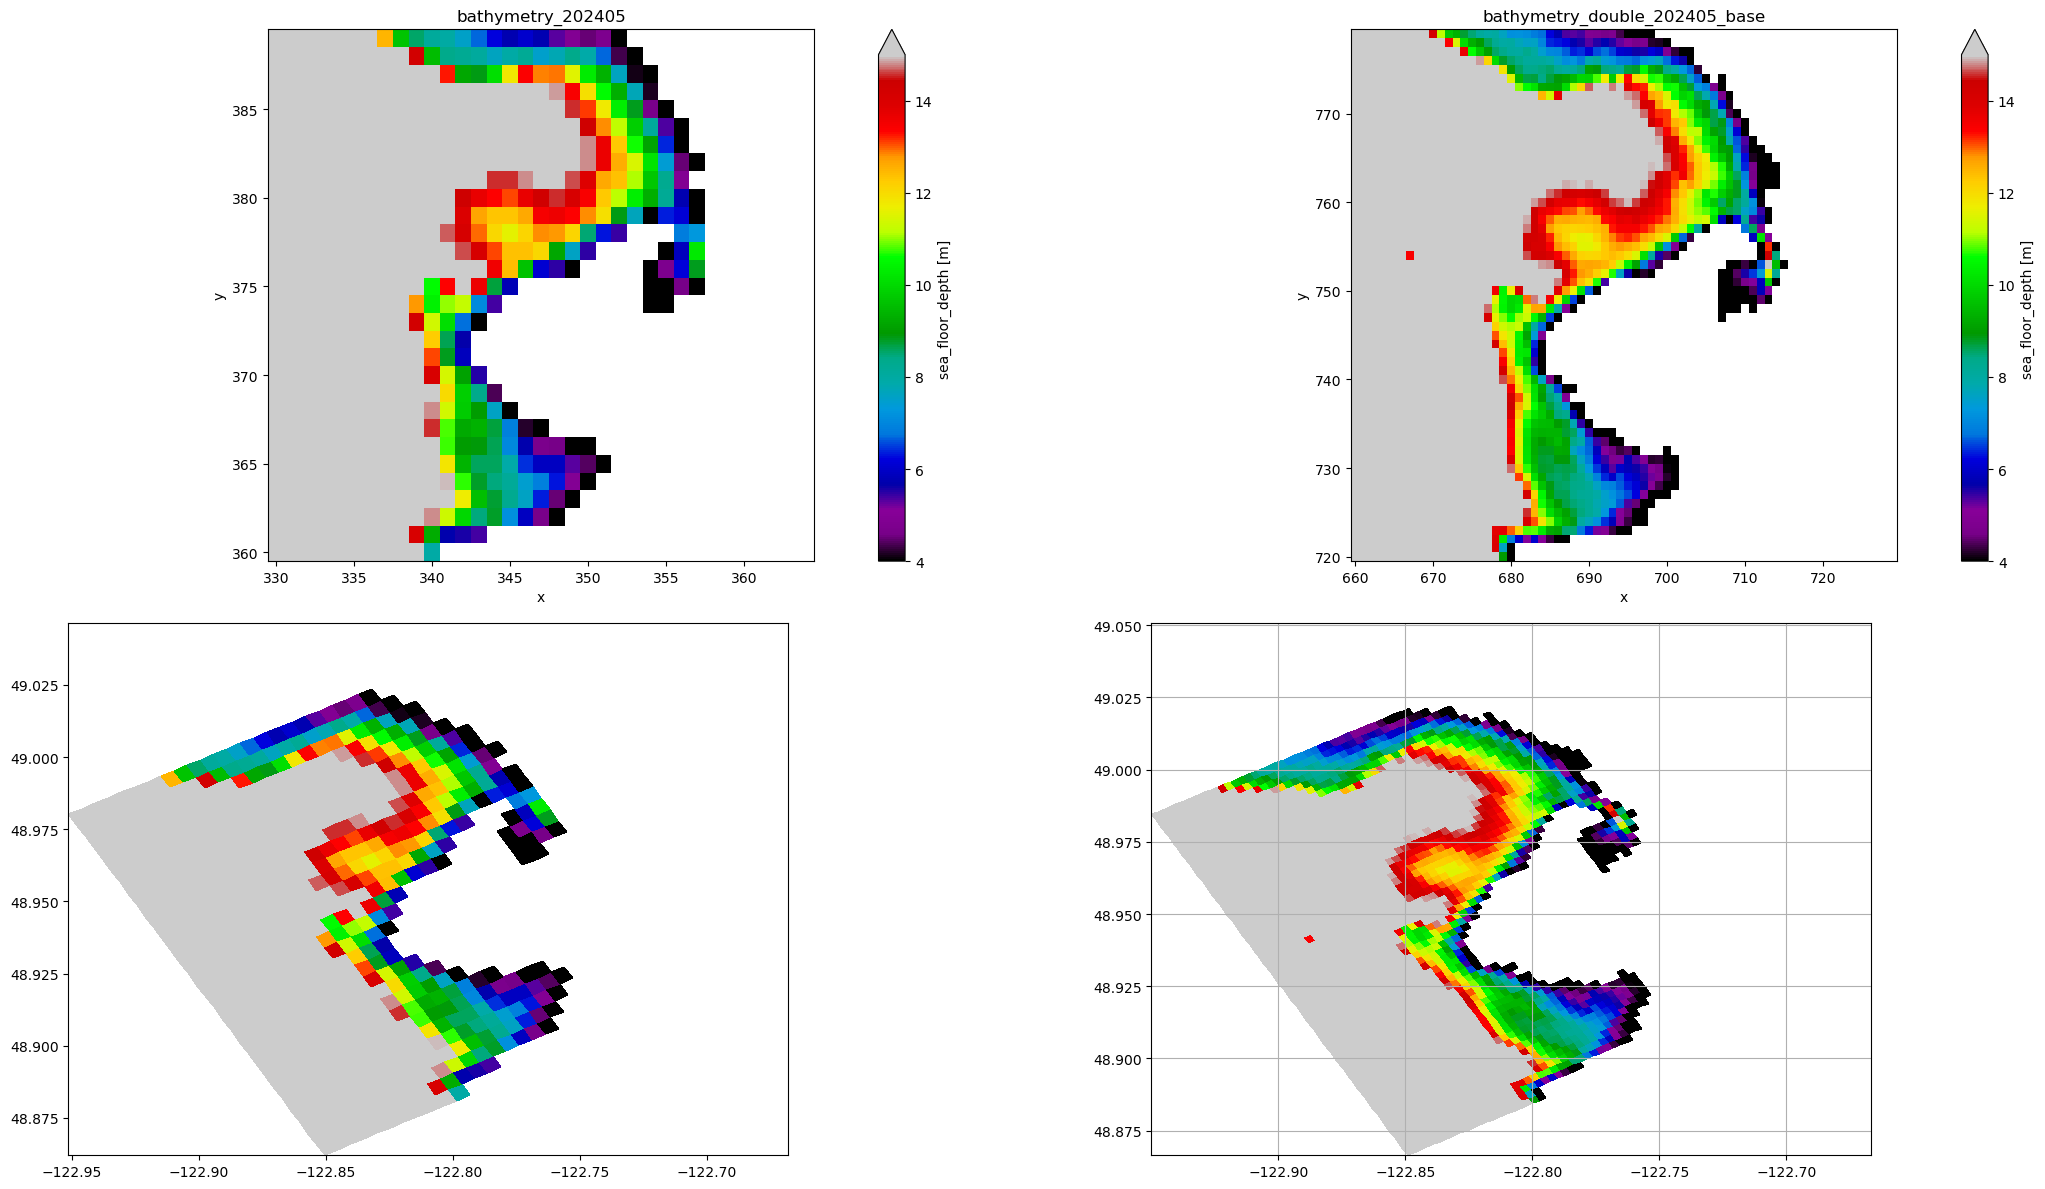

In [45]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base)

### Tile 11, 12

* all land with some Fraser River proxy

## Row 12 - Neah Bay to Surrey

In [46]:
y_min_max = numpy.array([390, 420])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 12, 0 - Warmhouse Beach & Neah Bay

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

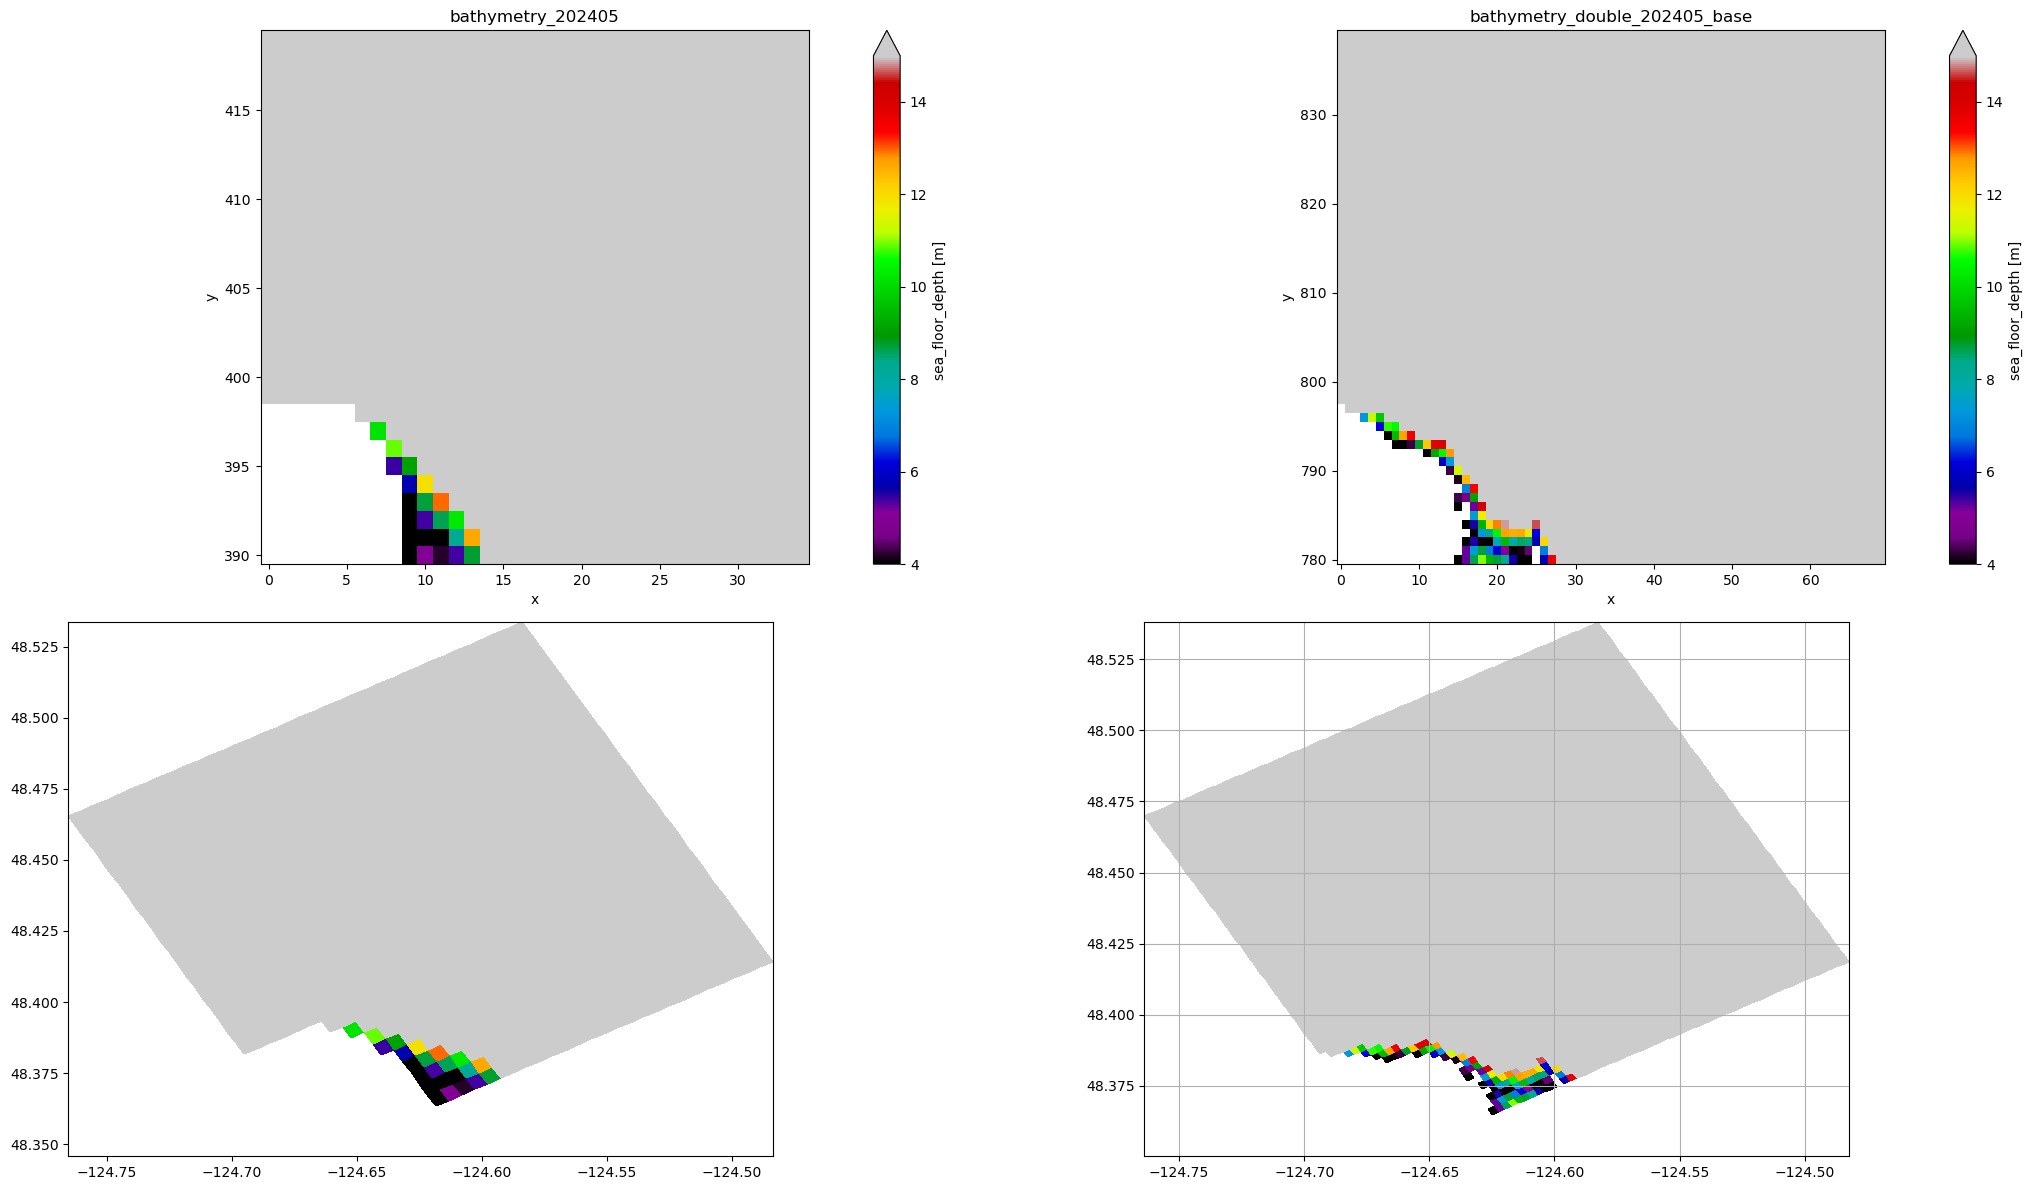

In [47]:
plot_tile(tile_x_min_max[0], y_slices, bathy, dbl_bathy_base)

### Tile 12, 1 - Port Renfrew

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

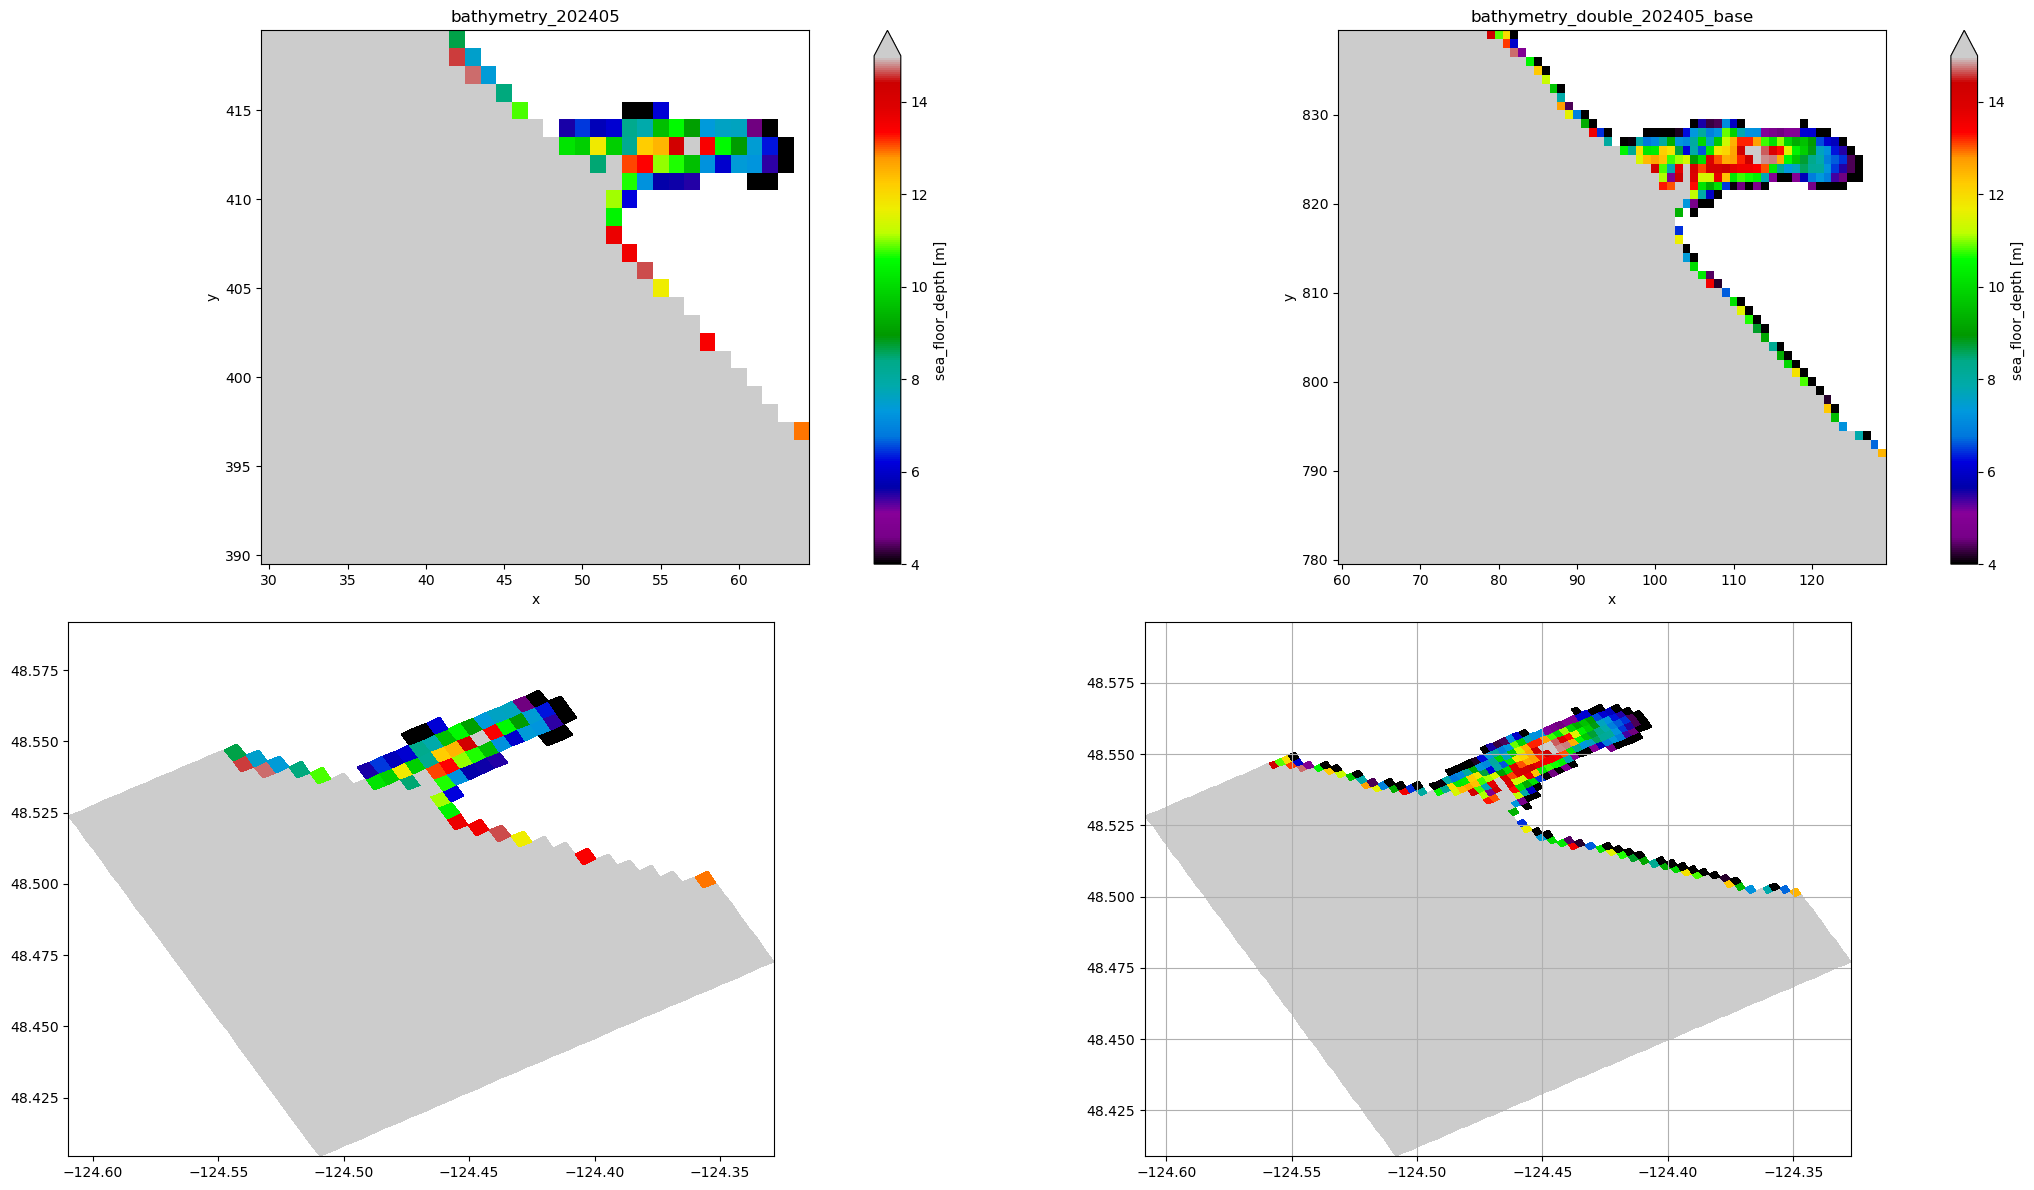

In [48]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 12, 2 - Sombrio Beach

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

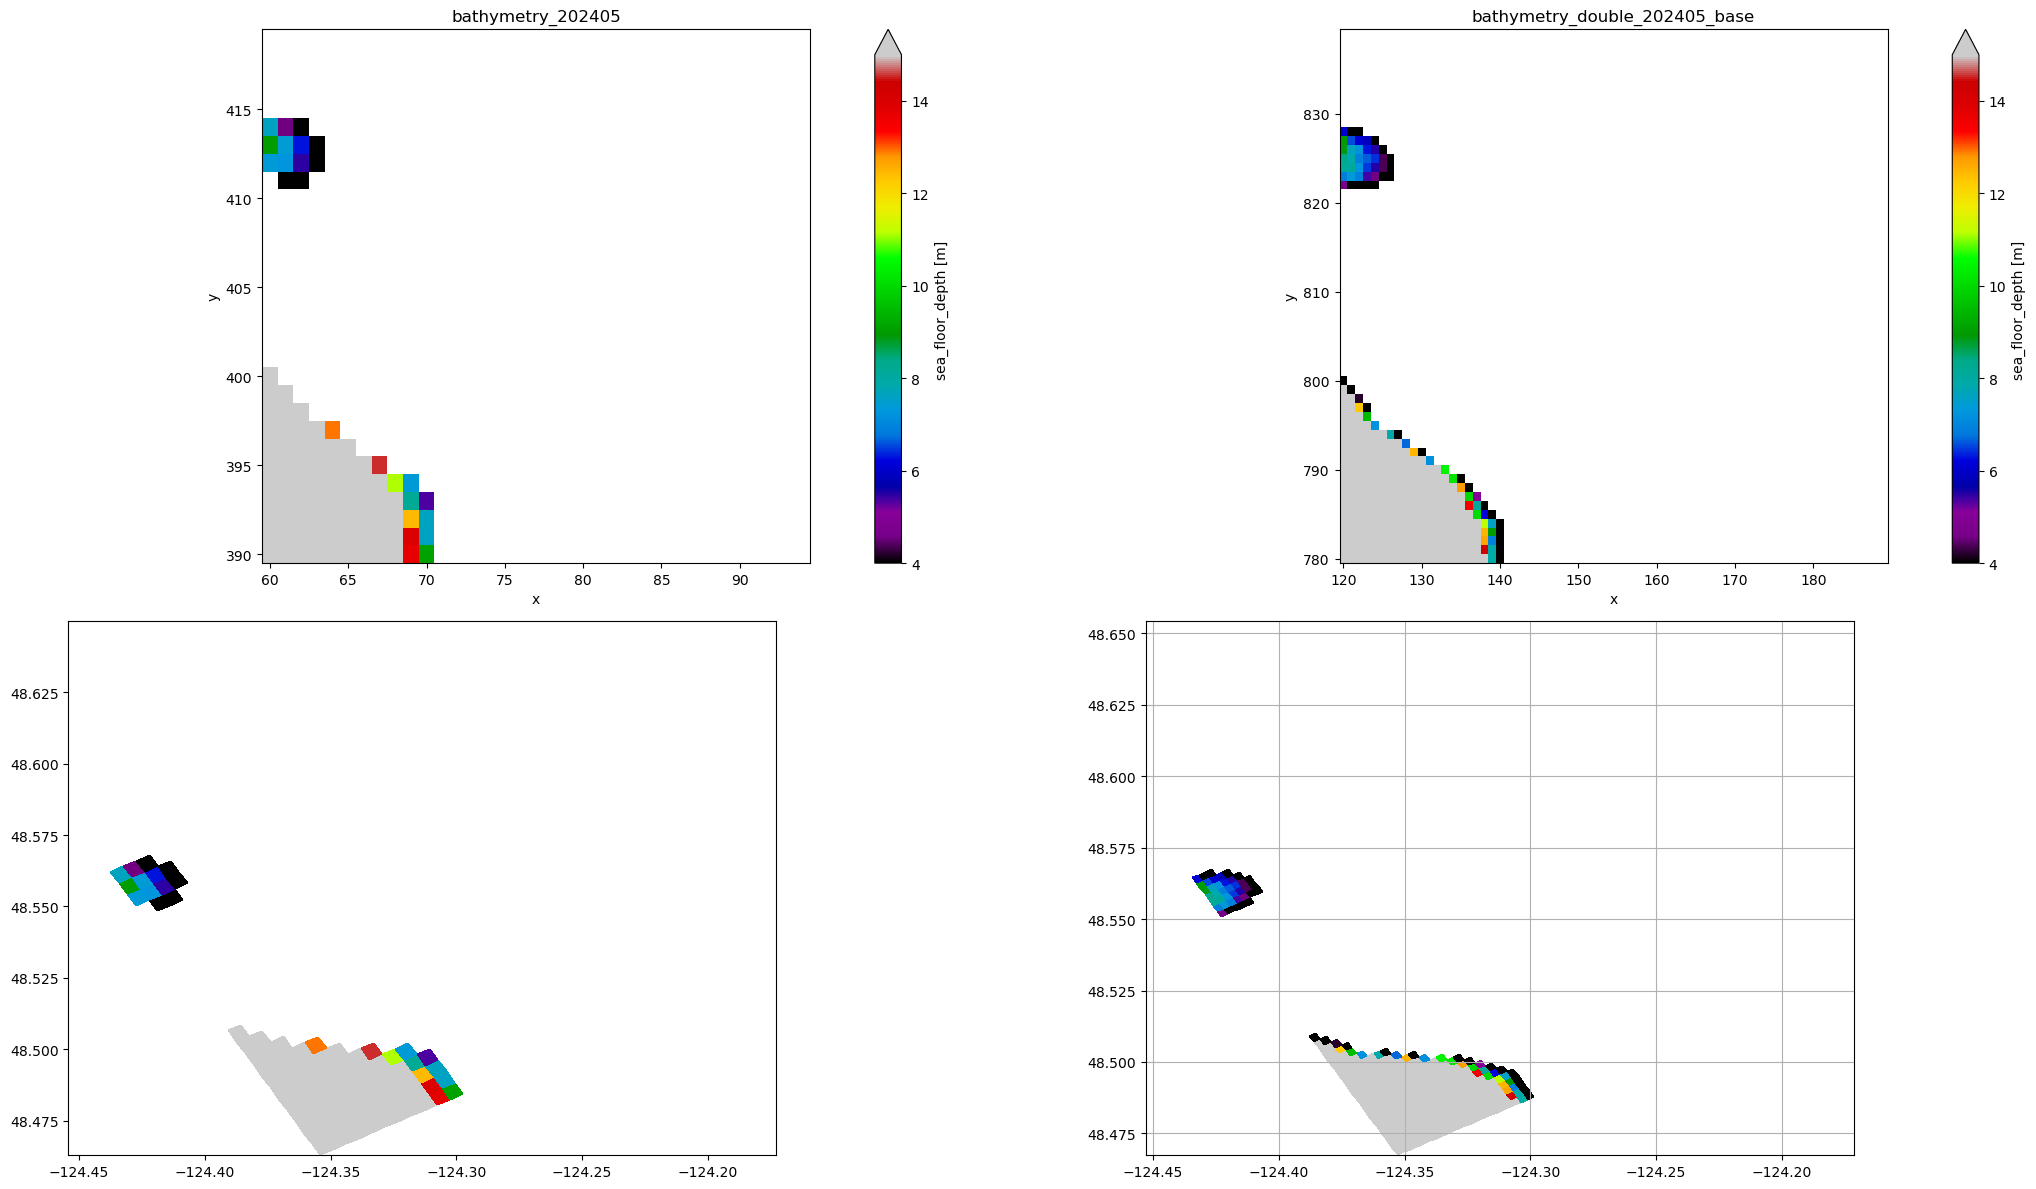

In [49]:
plot_tile(tile_x_min_max[2], y_slices, bathy, dbl_bathy_base)

### Tile 12, 3

* all land

### Tile 12, 4

* all land

### Tile 12, 5

* all land

### Tile 12, 6 - Genoa Bay & Maple Bay

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

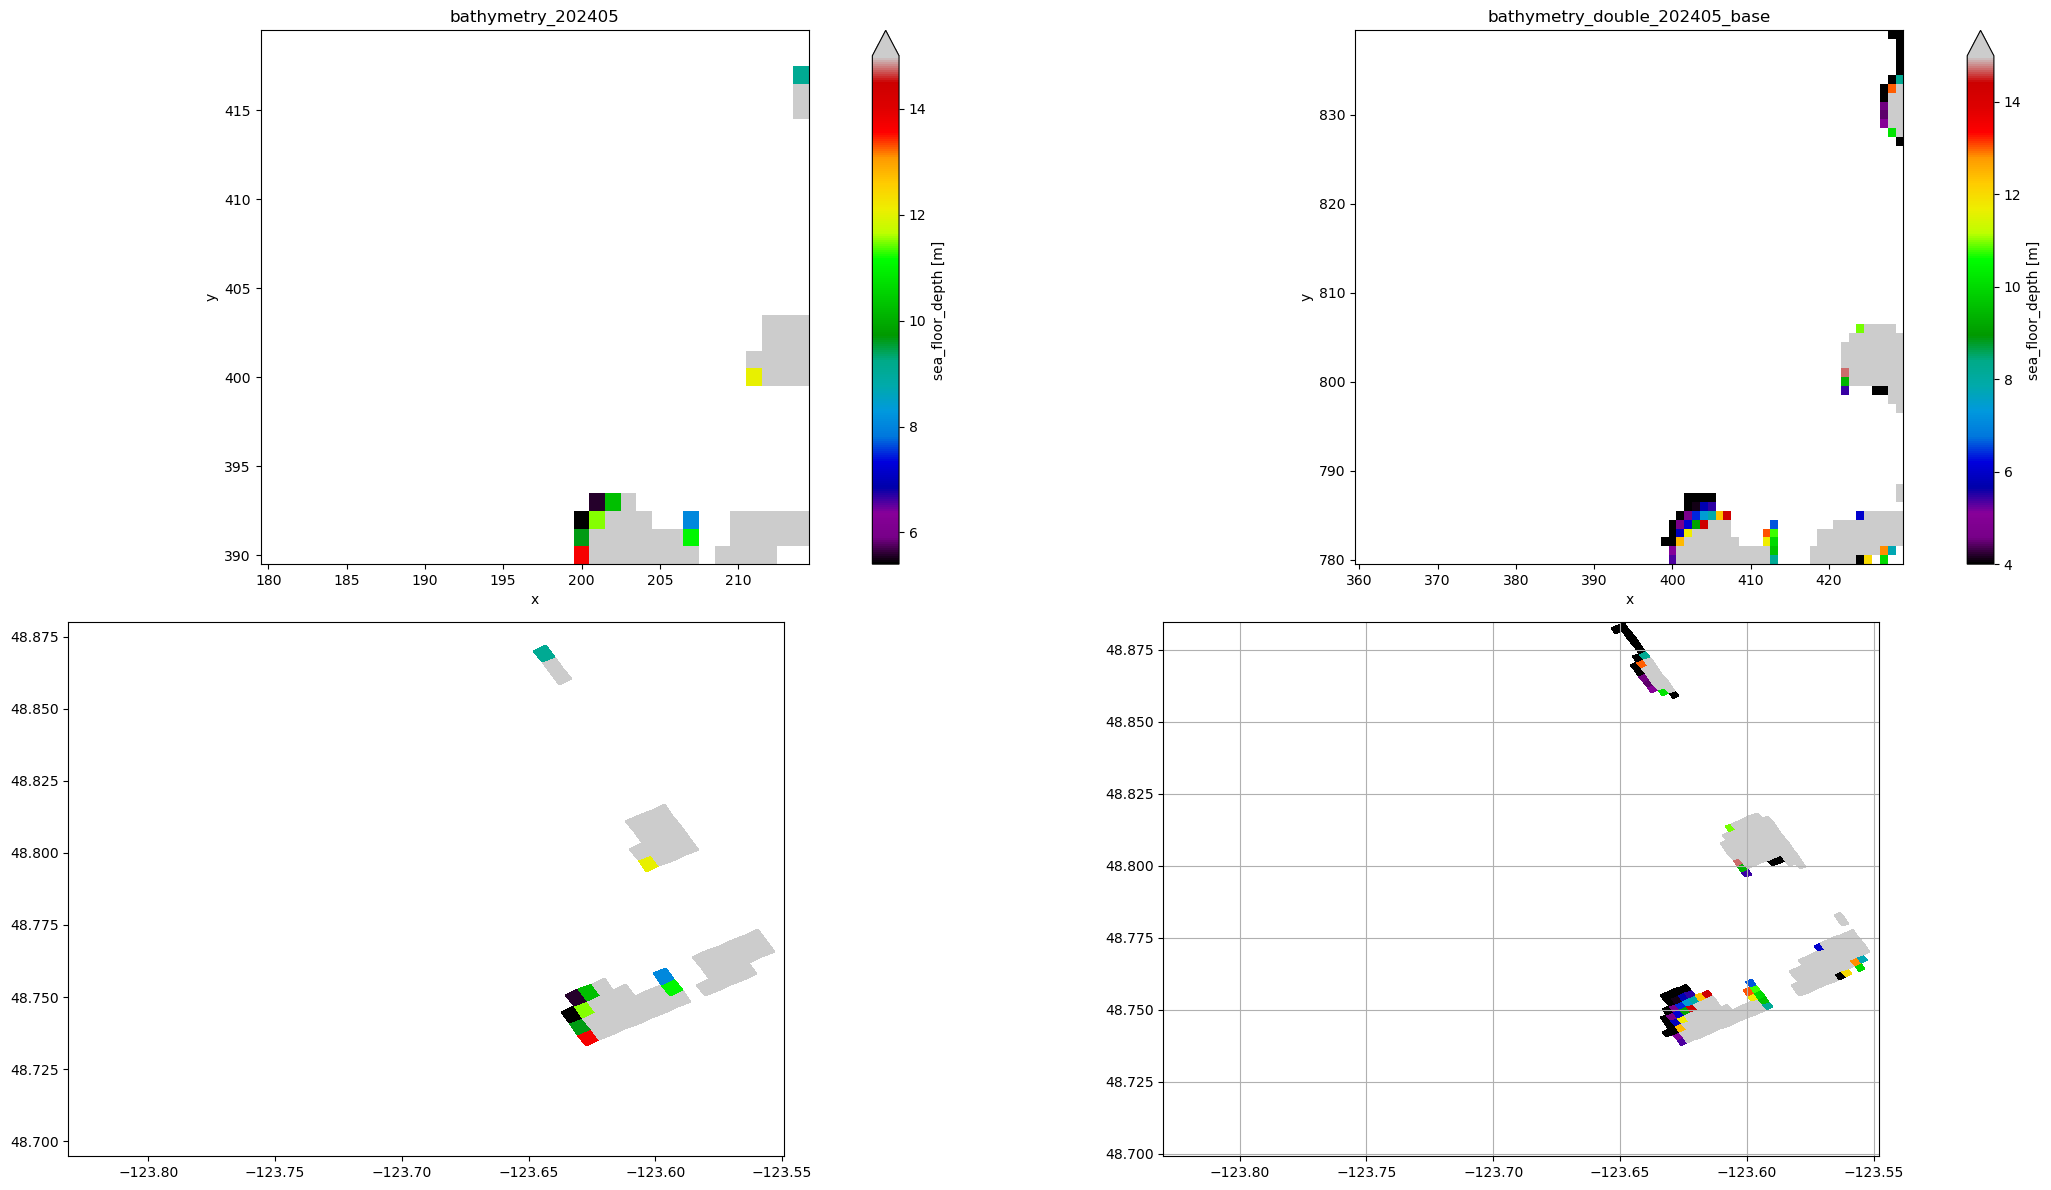

In [50]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base)

### Tile 12, 7 - Crofton, Ganges, Long Harbour & Trincomali Channel

* fill in Athol Peninsula

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

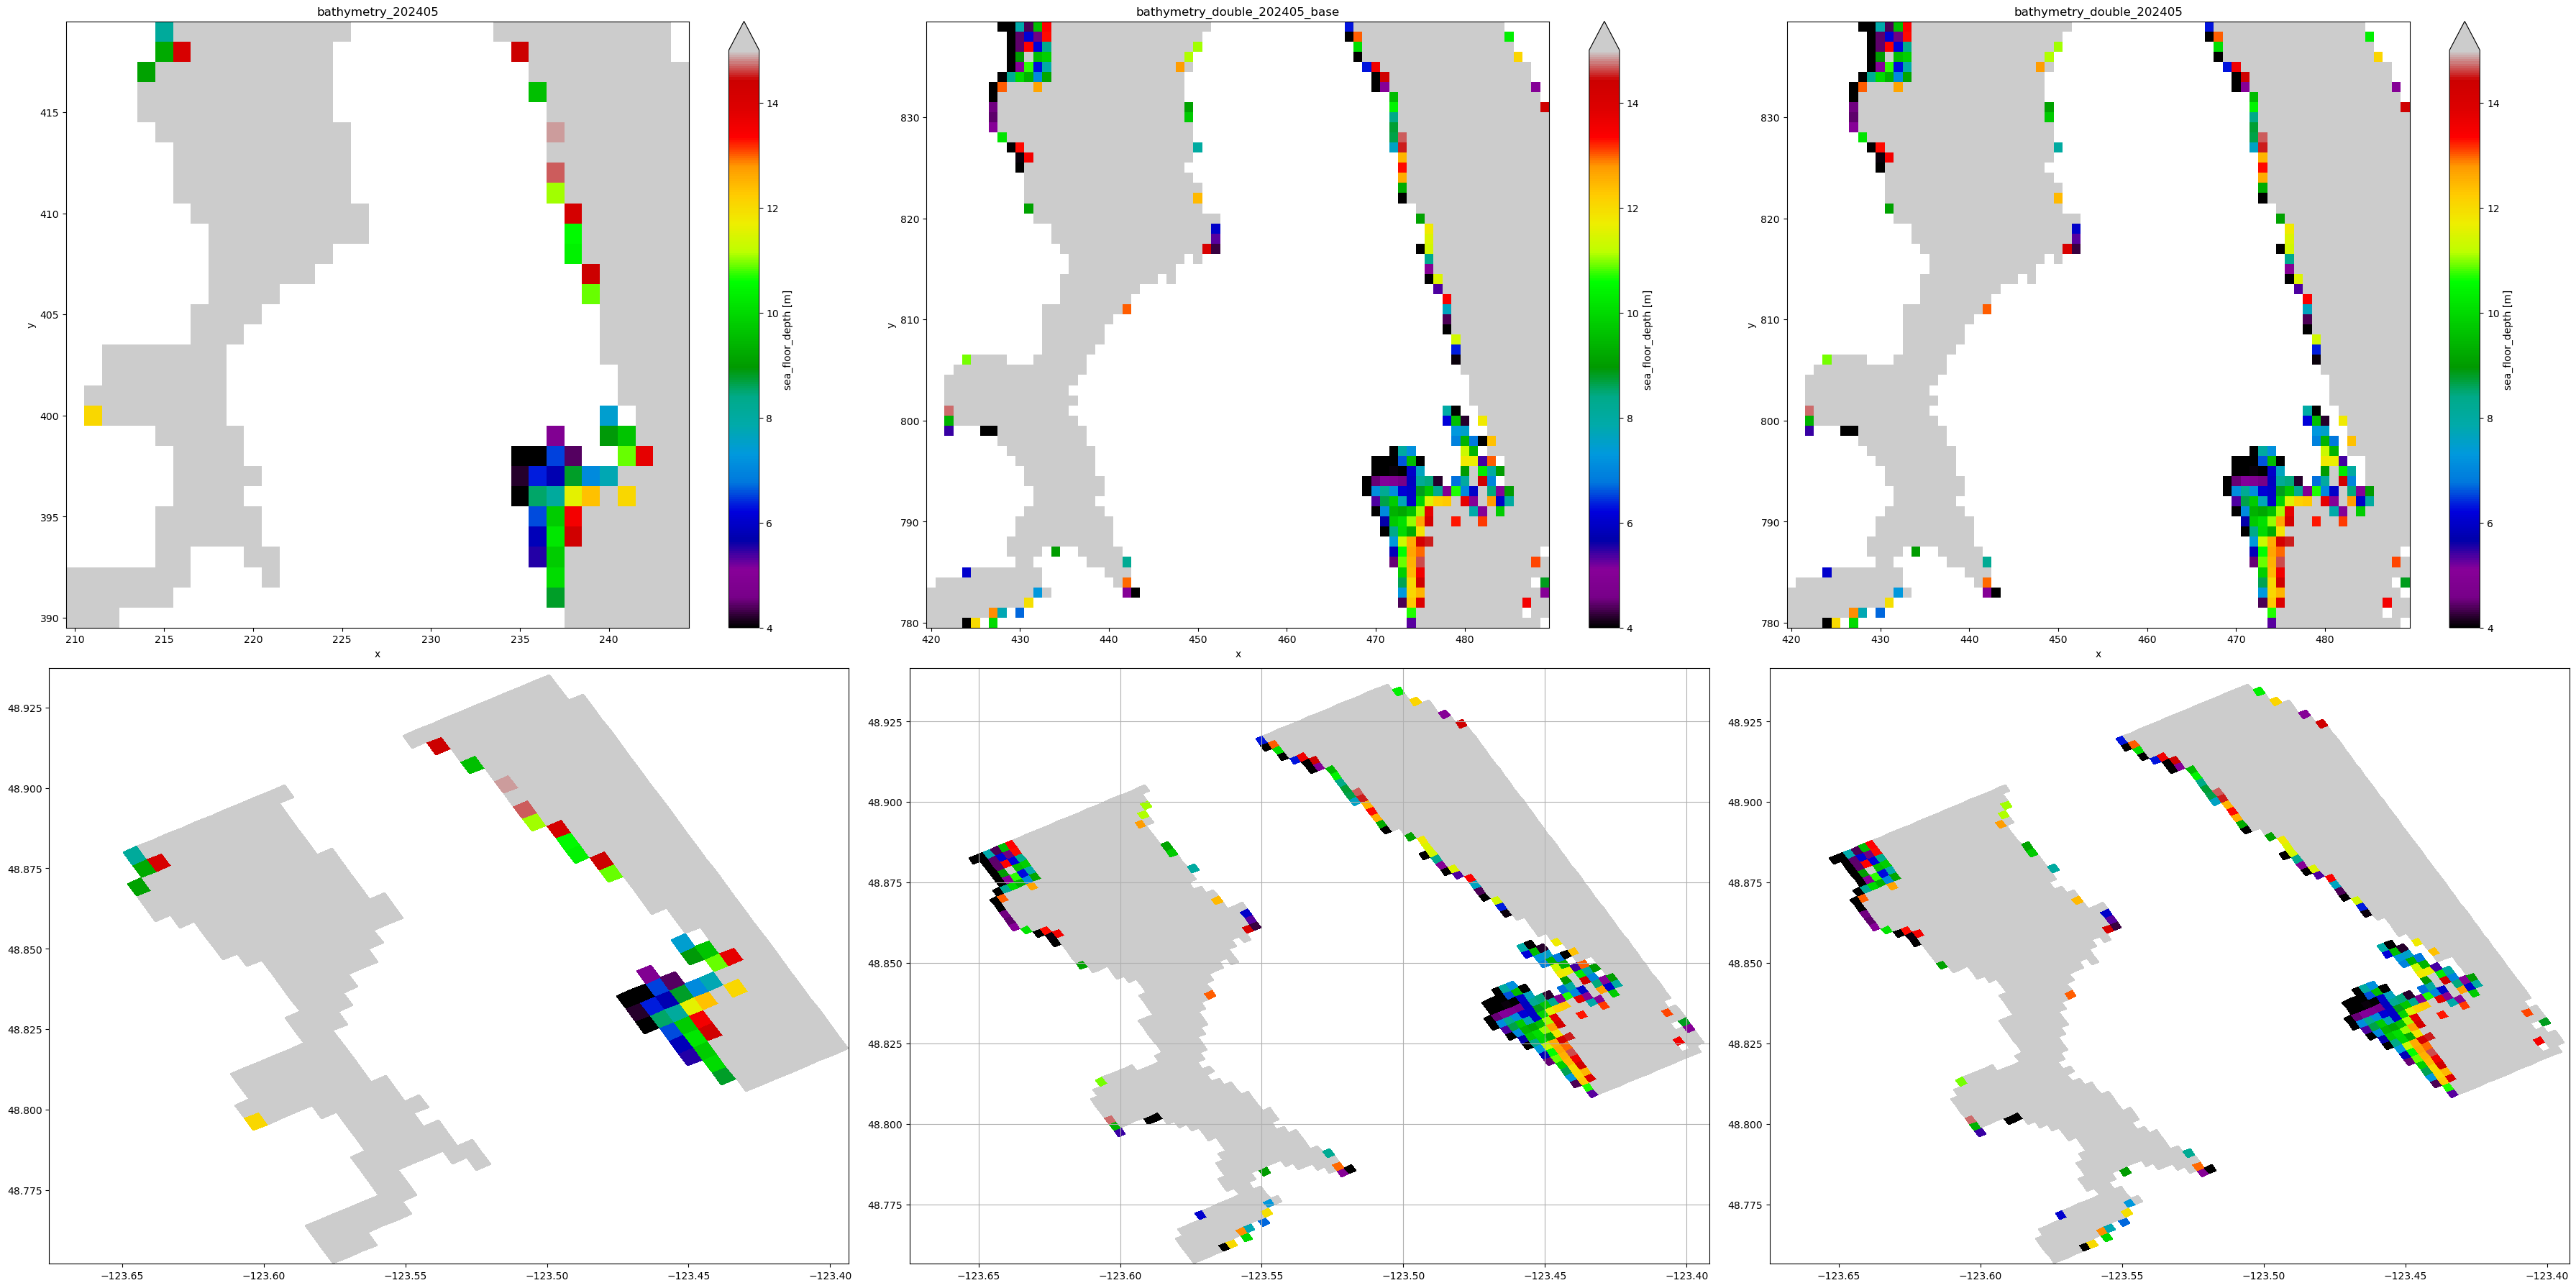

In [51]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 12, 8 - Galiano Island

* separate Parker Island
* connect 2 points on north end of Prevost Island

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

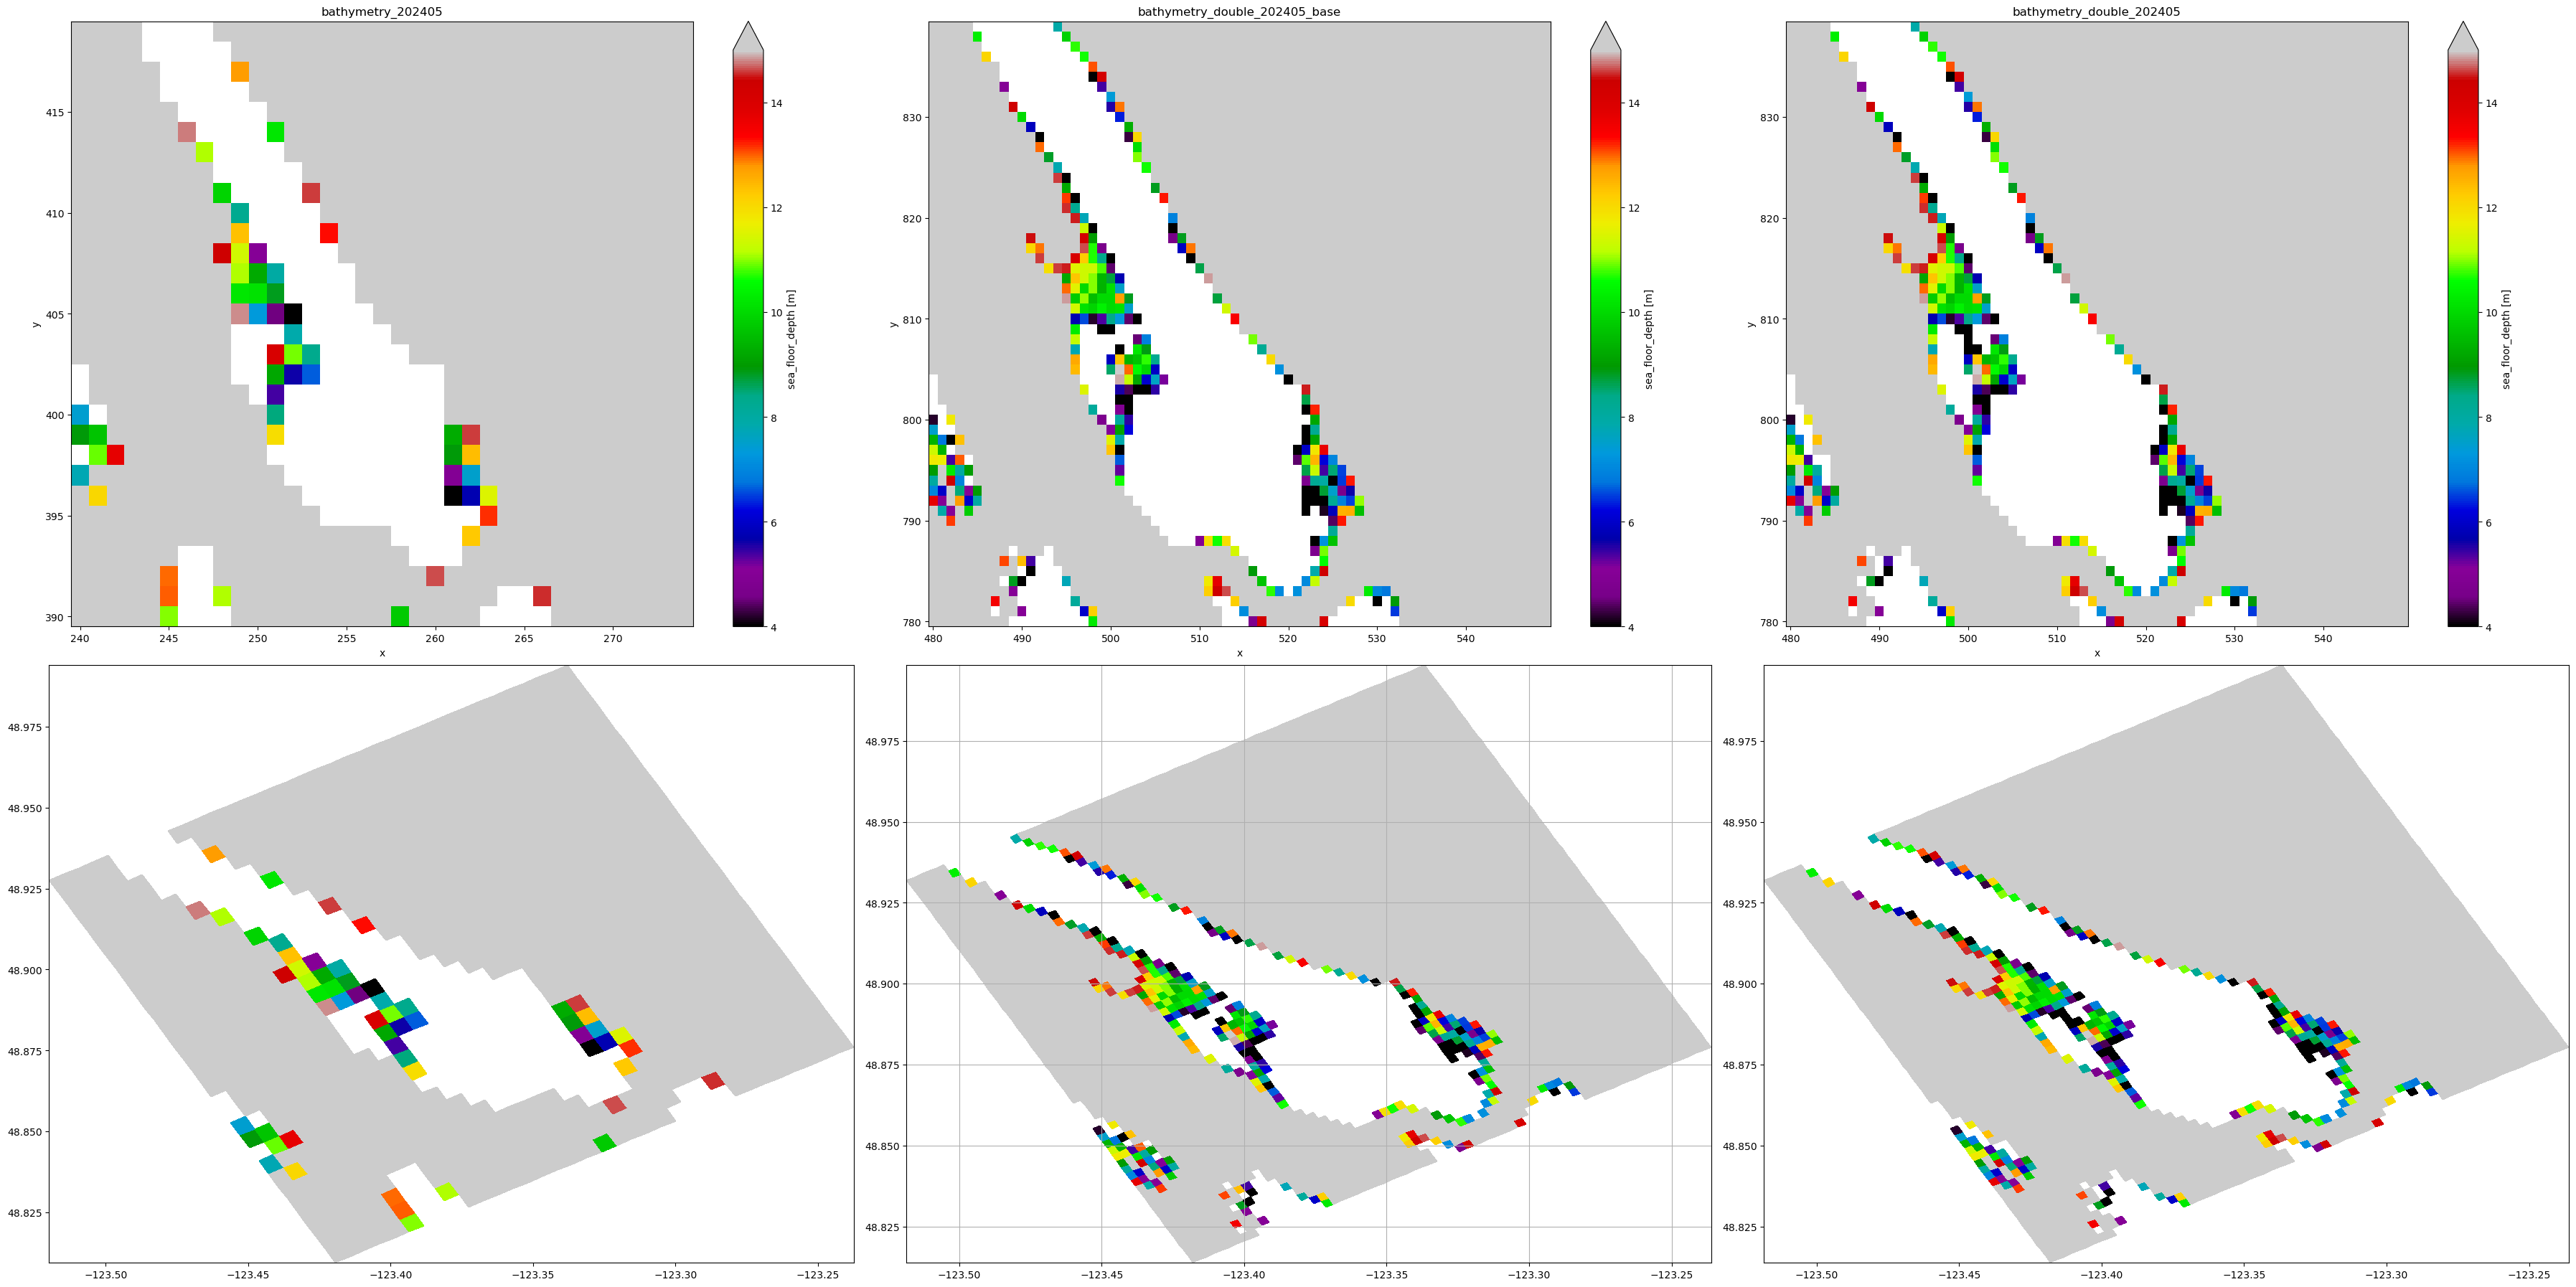

In [52]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 12, 9 - Roberts Bank

* change 4 fake islands to 4m deep

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

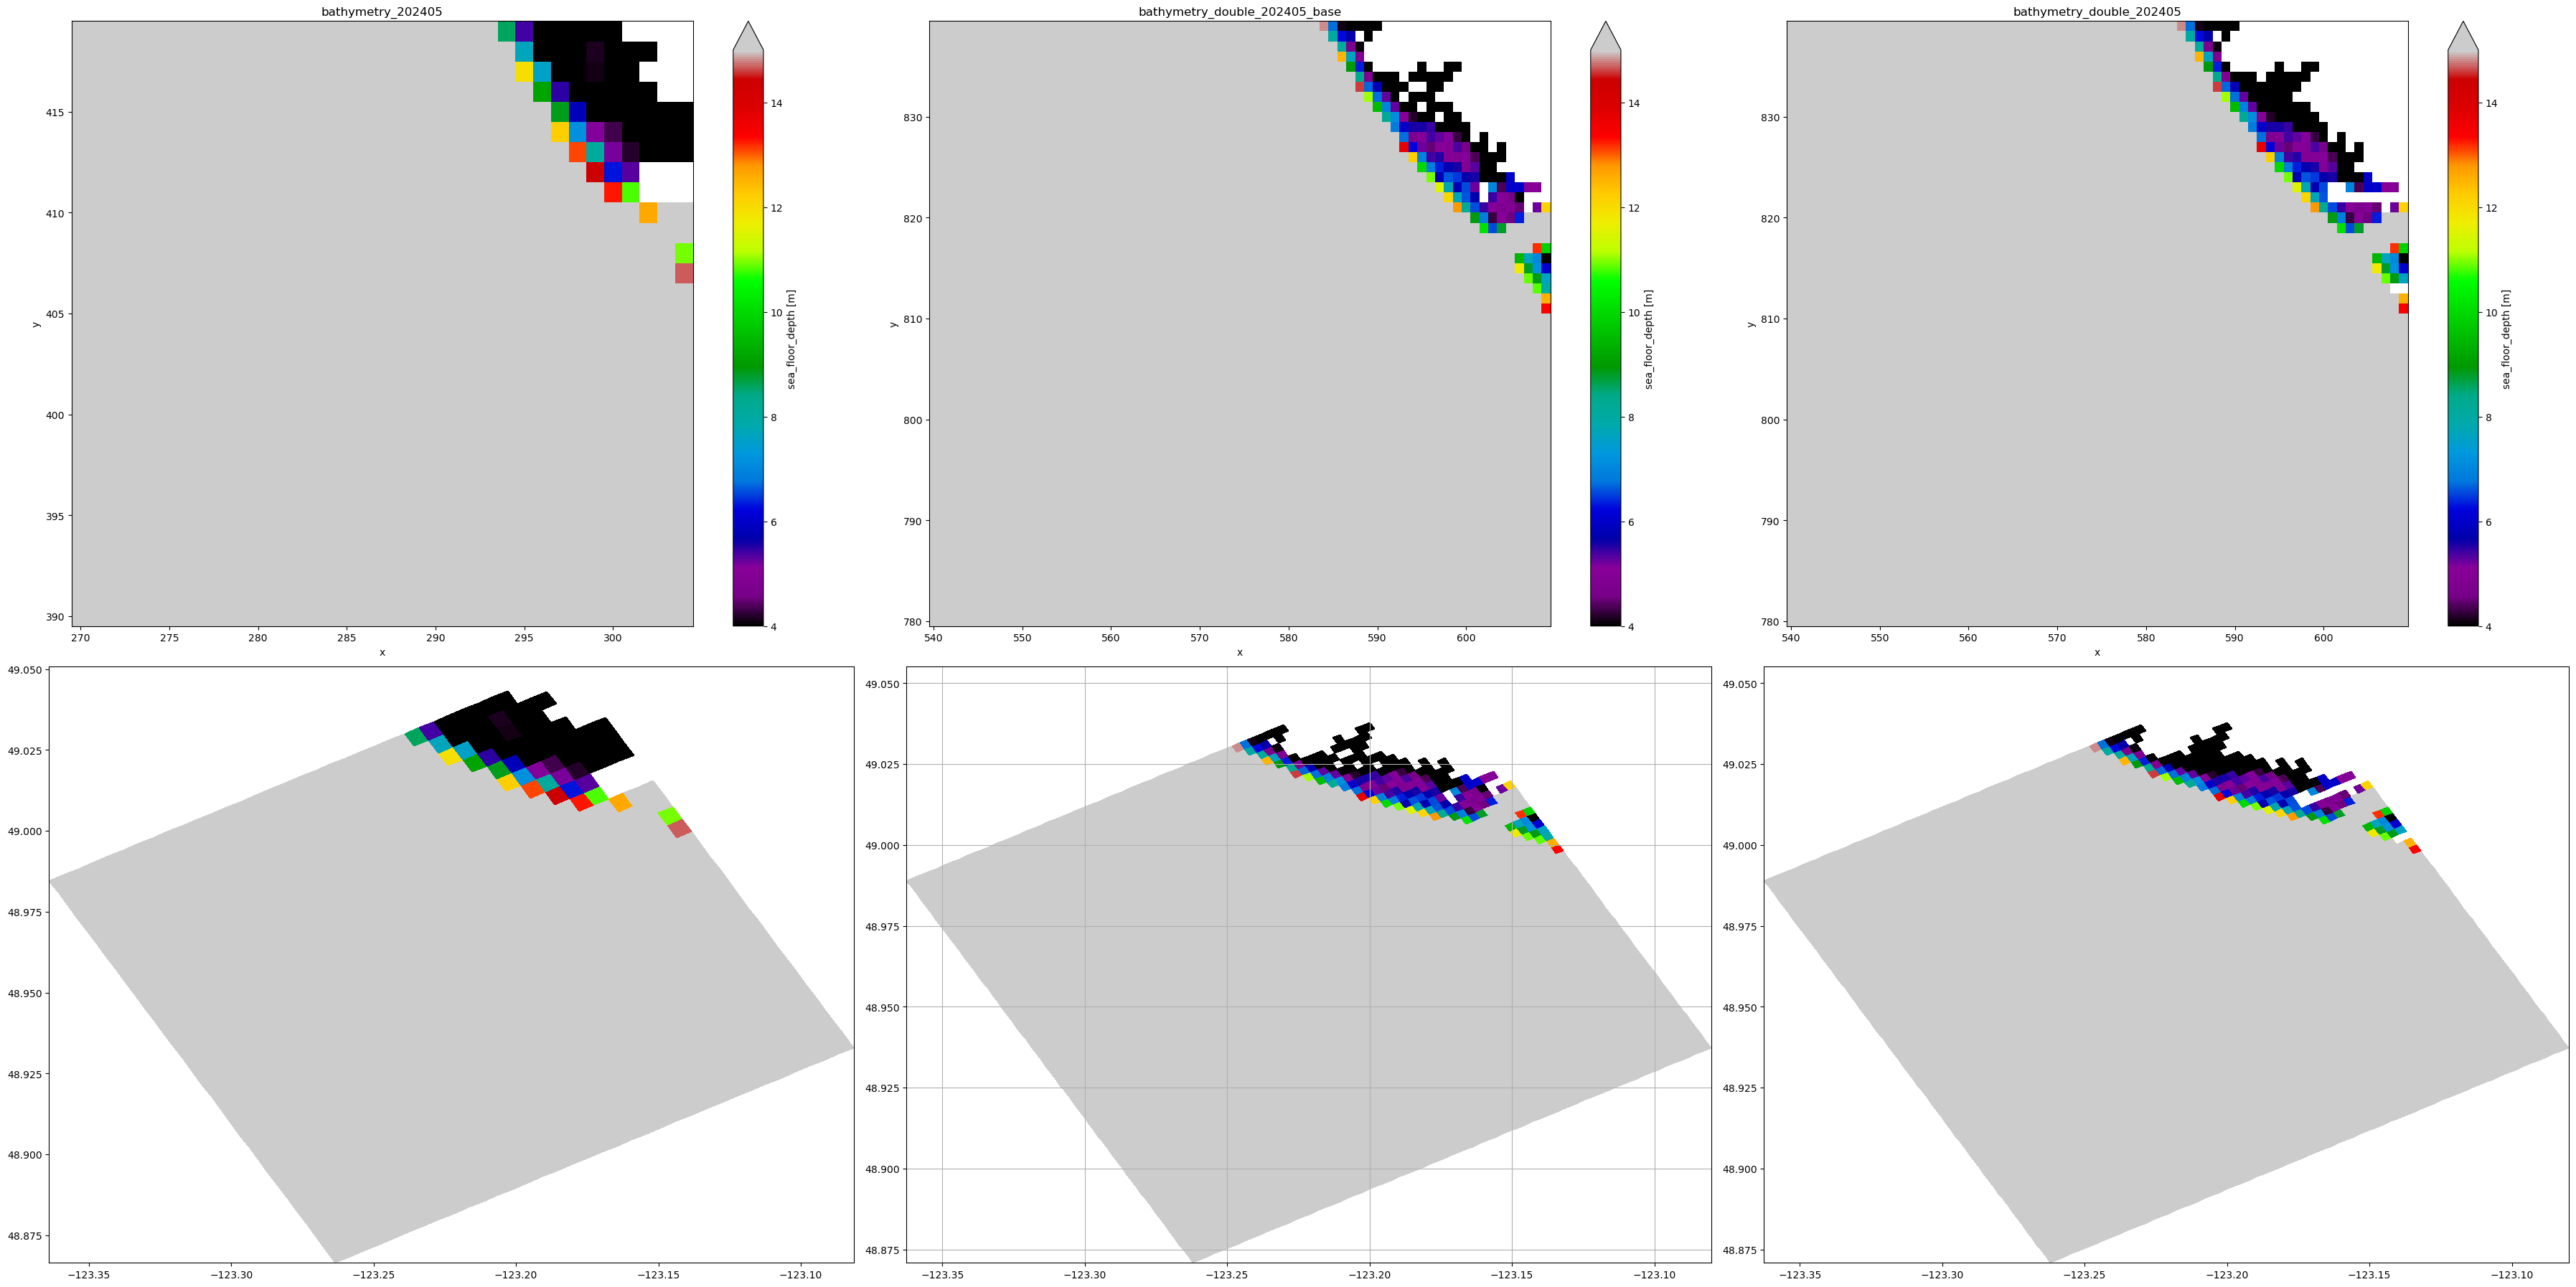

In [53]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 12, 10 - Point Roberts & Tsawwassen

* add Tsawwassen ferry terminal and spit
* add Roberts Bank port and spit
* change fake island SE of Pt. Roberts to 4m deep

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

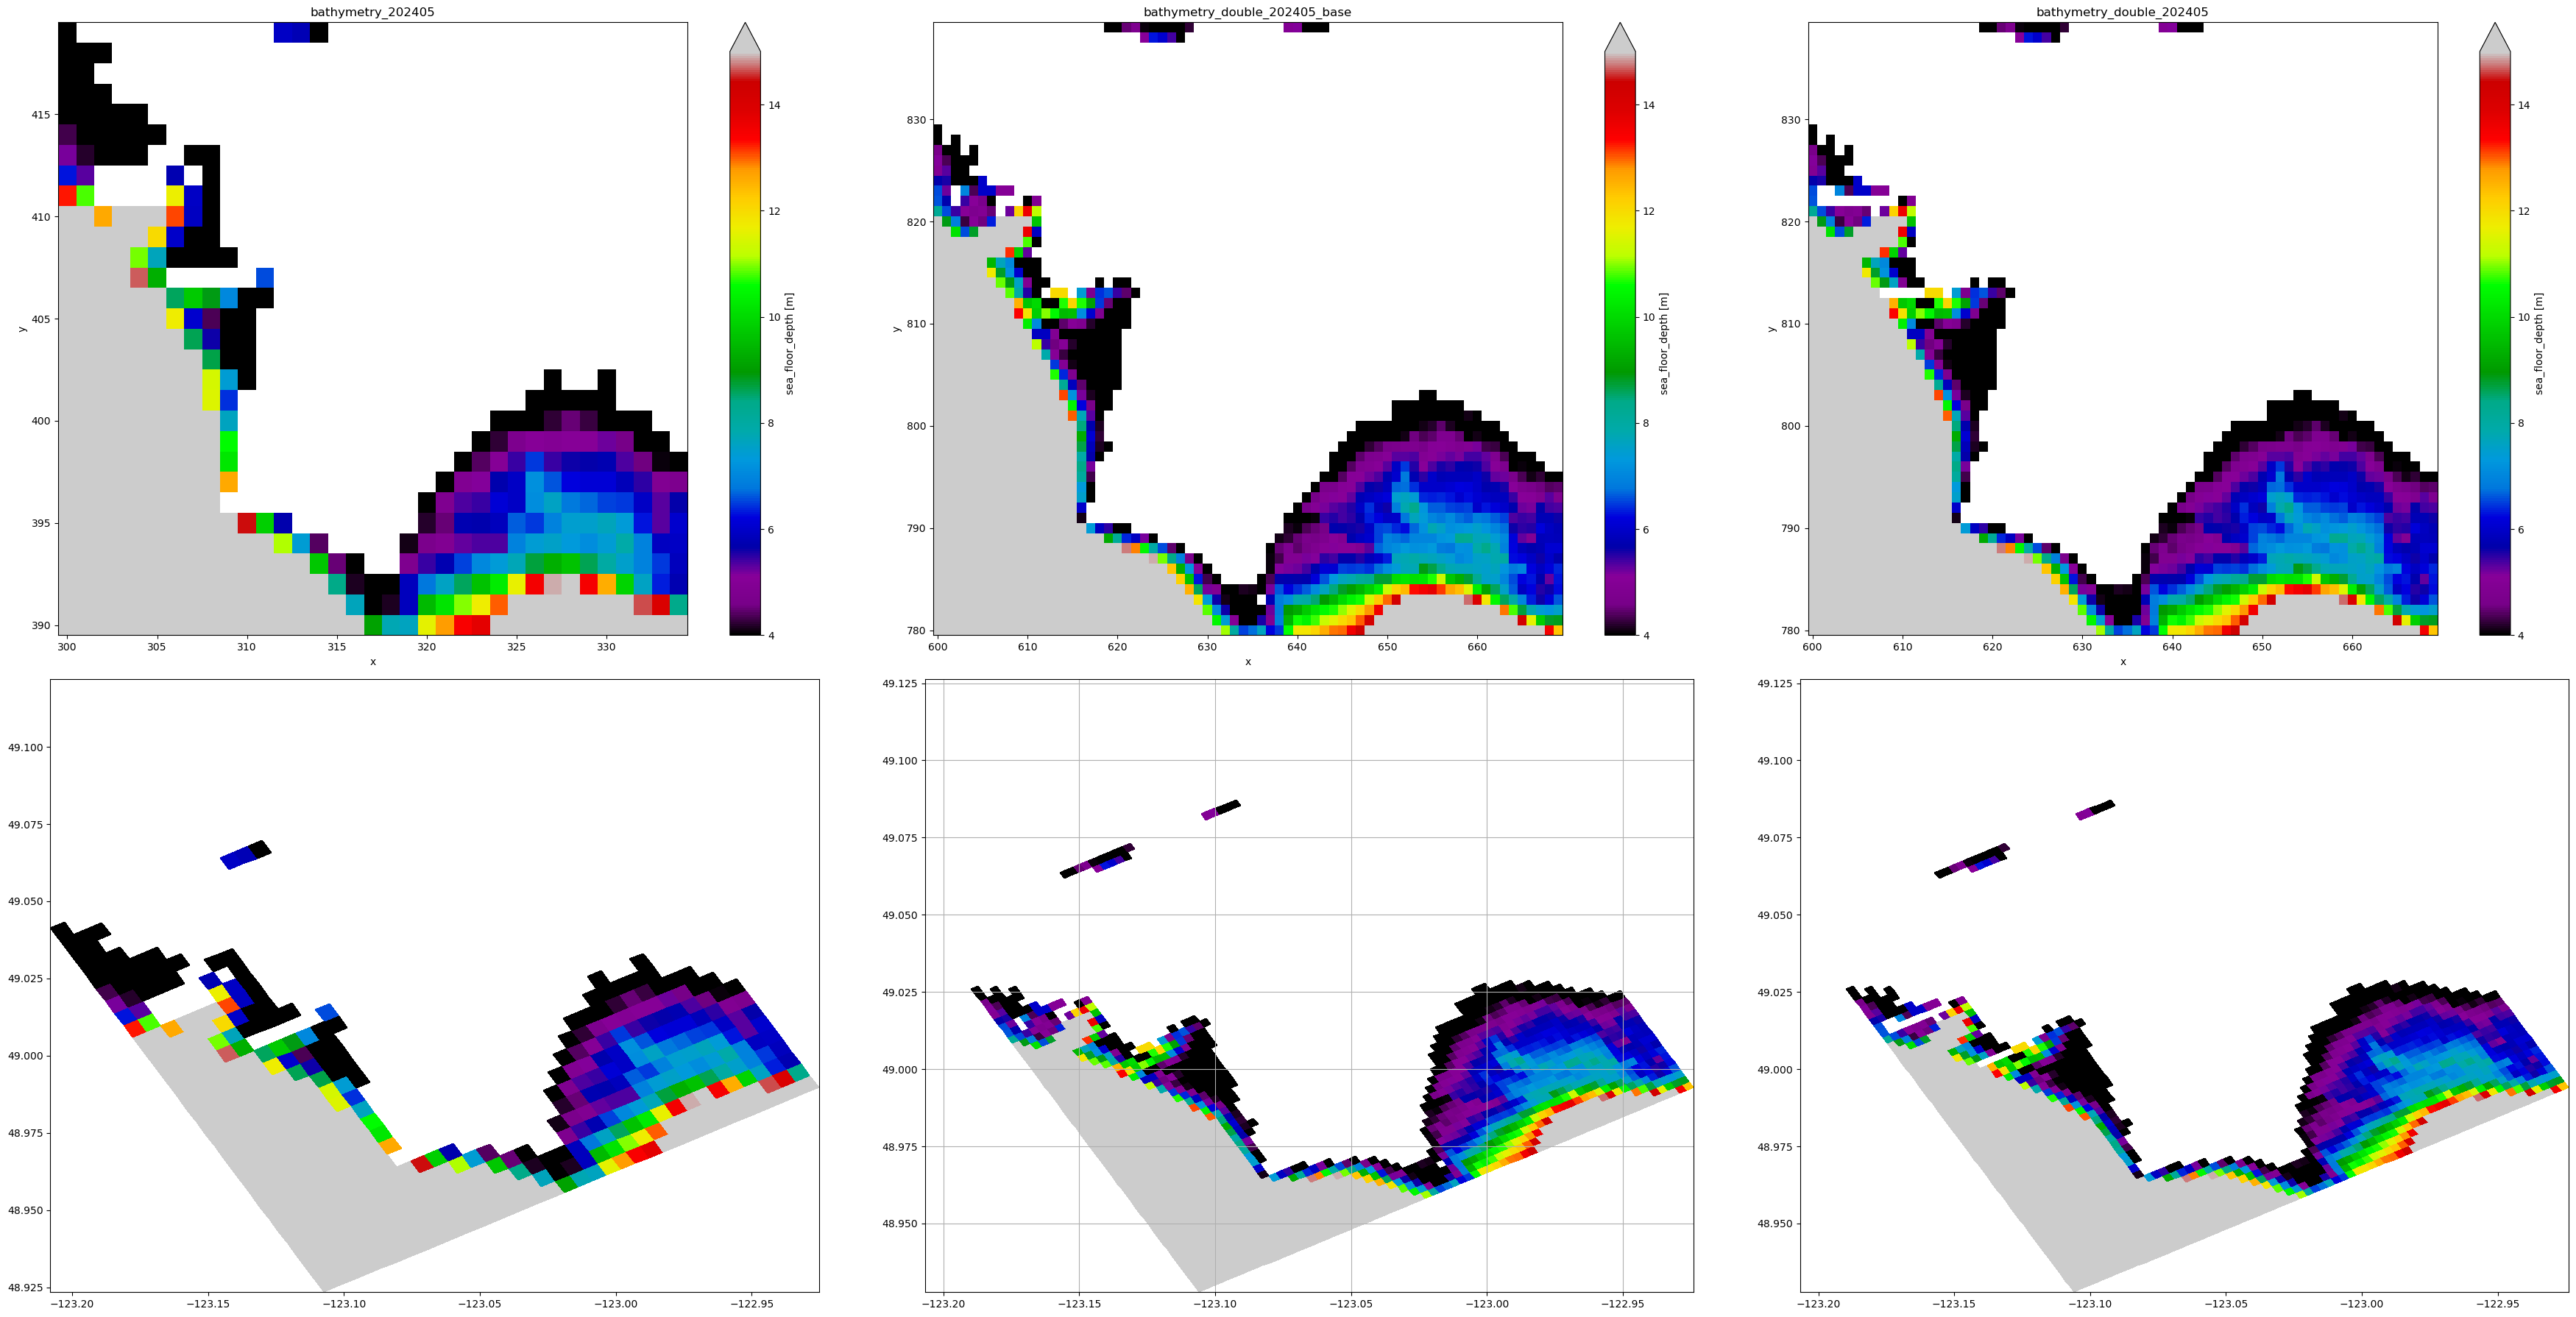

In [54]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 12, 11 - Mud Bay & Crescent Beach

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

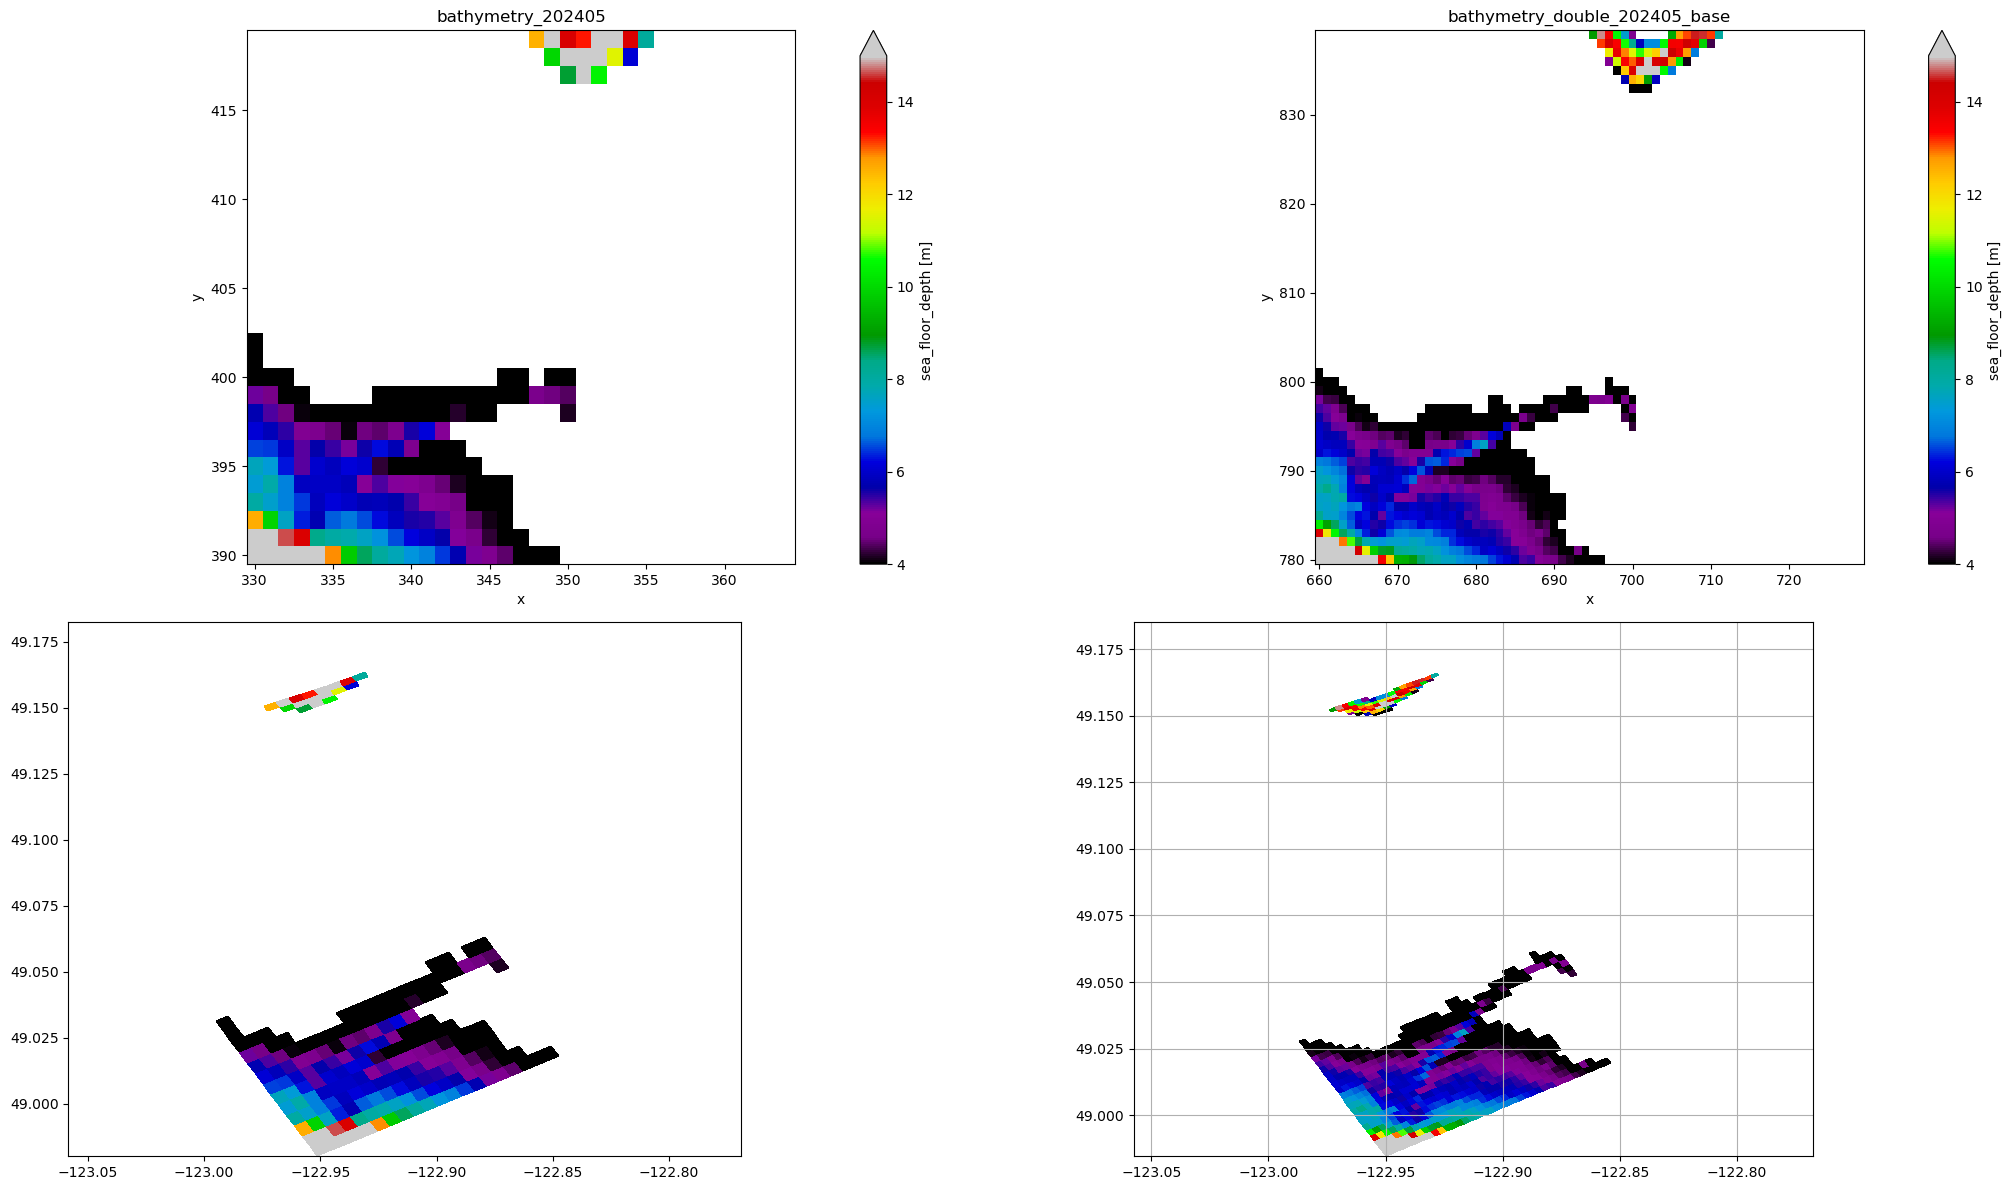

In [55]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base)

### Tile 12, 12 - Surrey

* junction of Fraser River proxy and the real river

/tmp/ipykernel_846180/1784615056.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_846180/1784615056.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)


(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

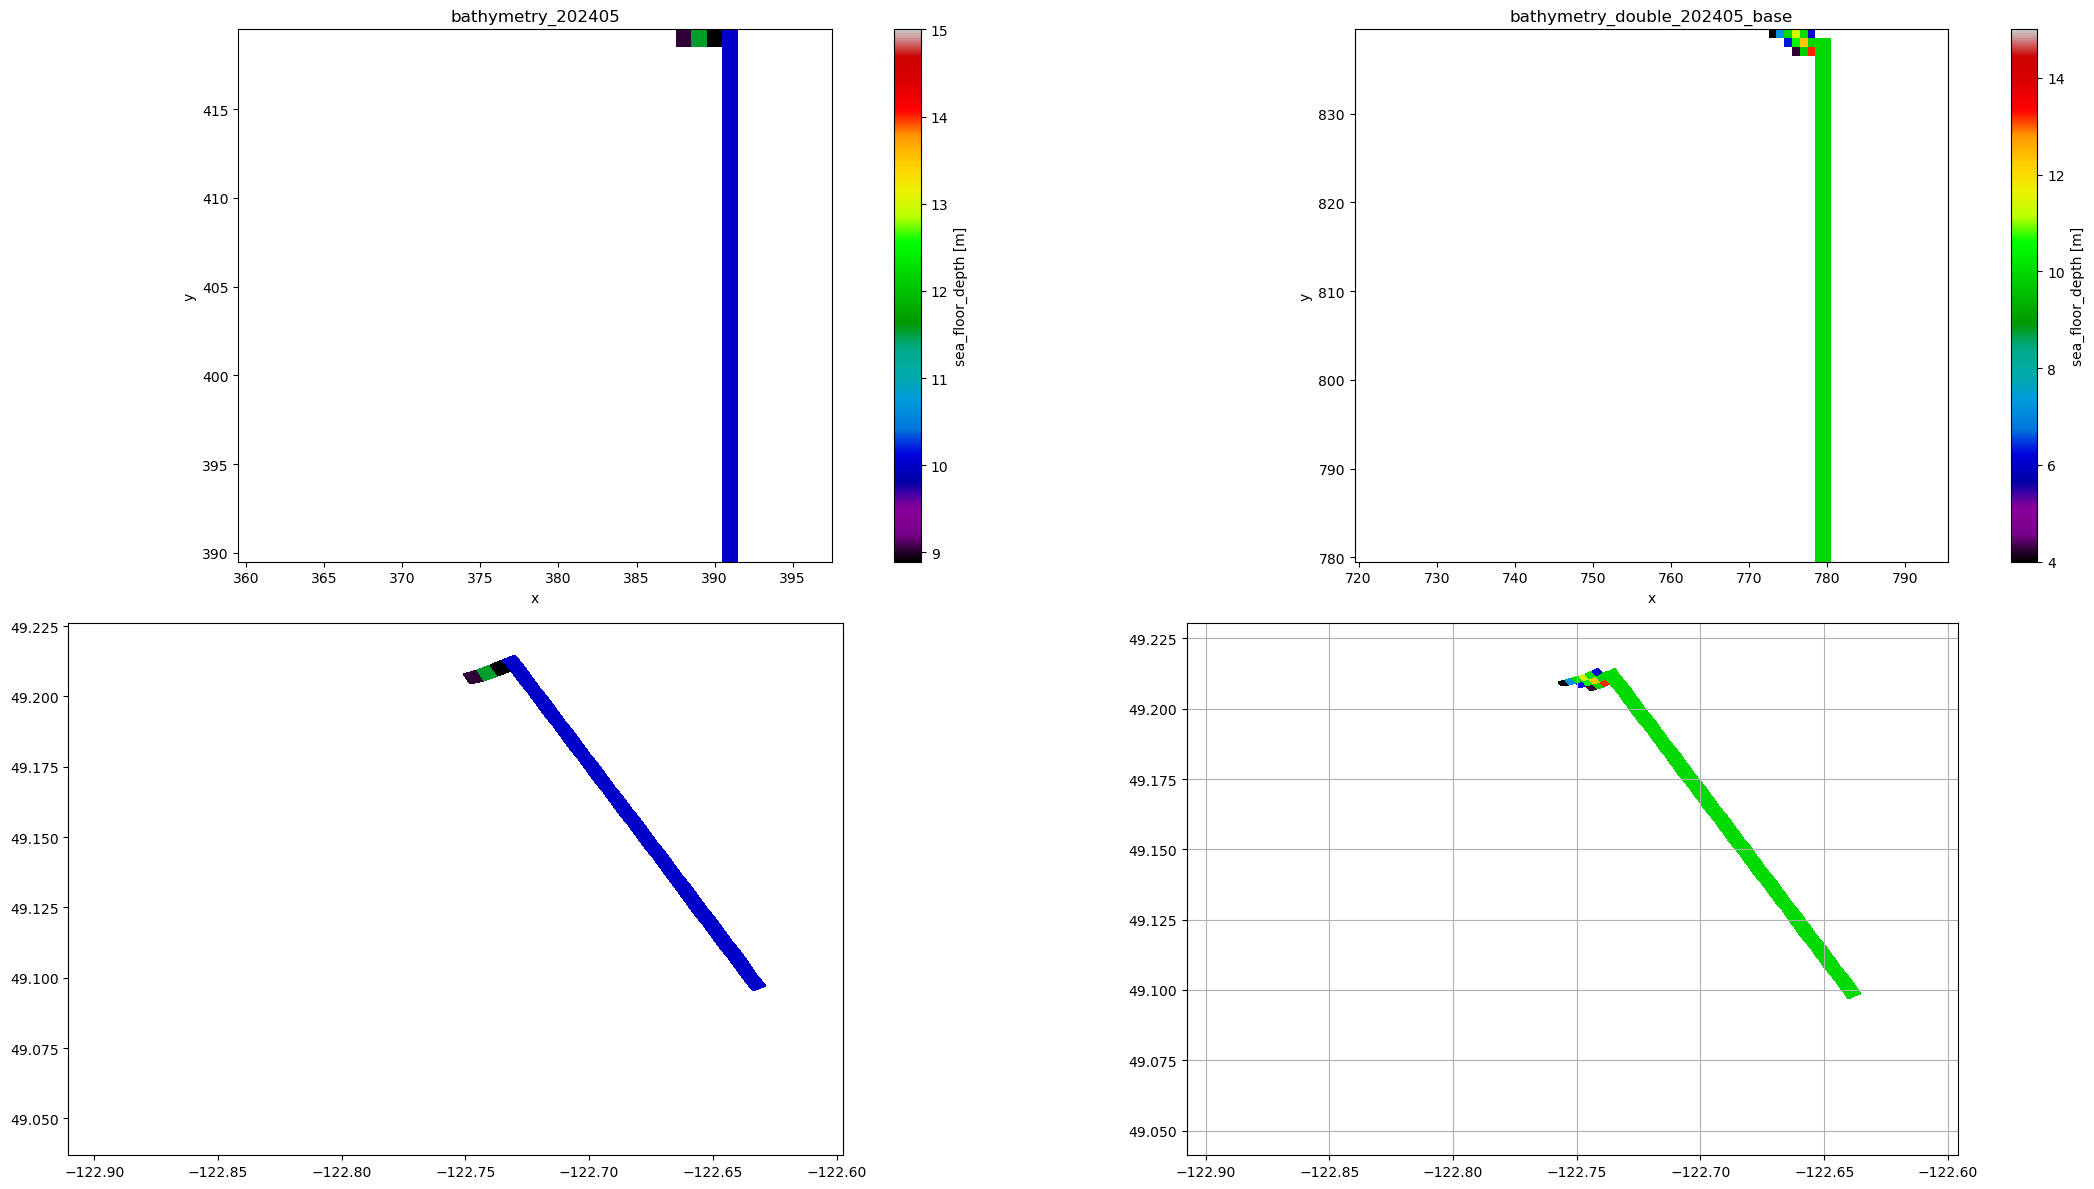

In [56]:
plot_tile(tile_x_min_max[12], y_slices, bathy, dbl_bathy_base)

## Row 13 - Carmanah Point to Fraser River

In [57]:
y_min_max = numpy.array([420, 450])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 13, 0 - Carmanah Point

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

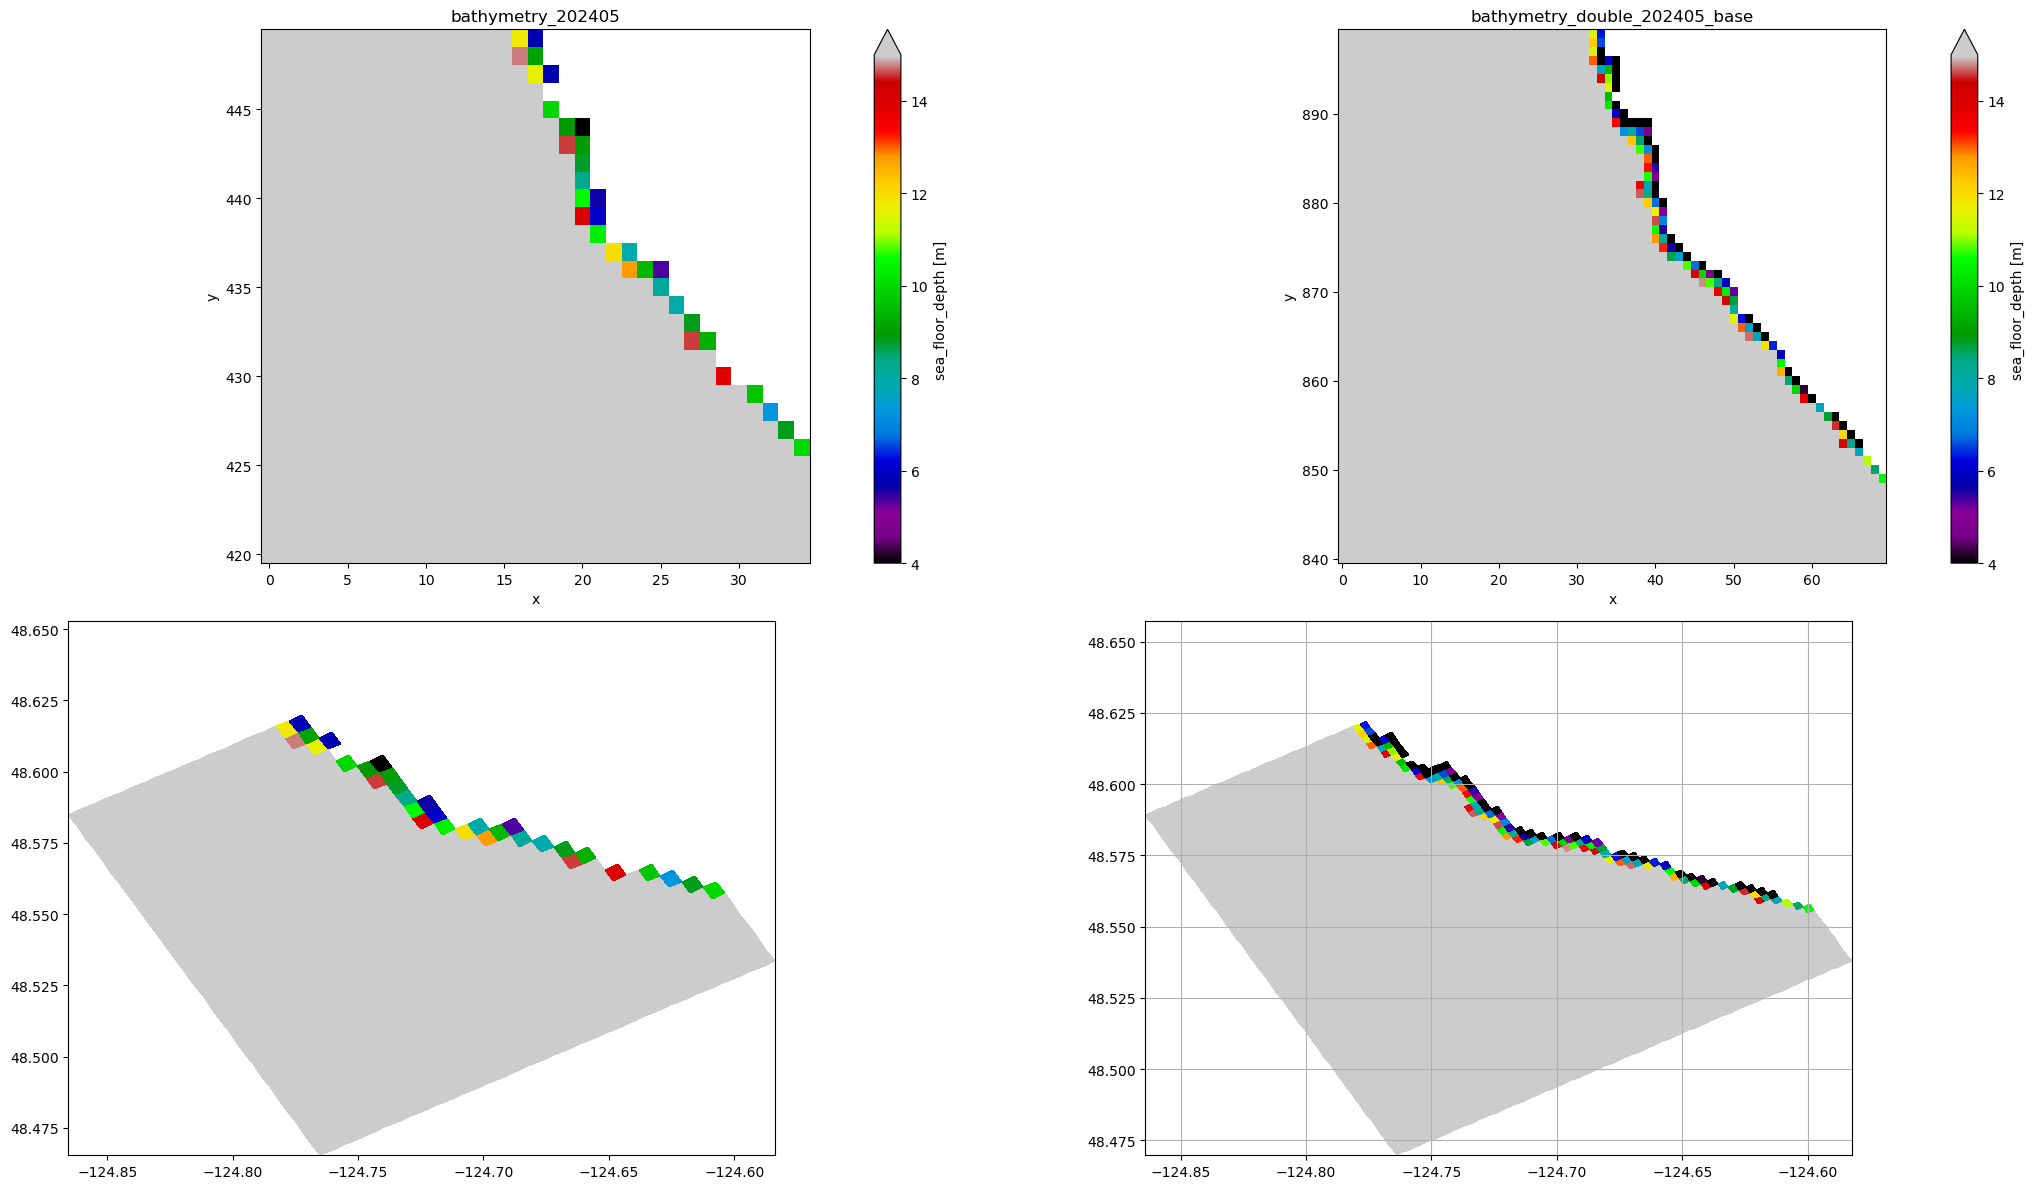

In [58]:
plot_tile(tile_x_min_max[0], y_slices, bathy, dbl_bathy_base)

### Tile 13, 1 - Camper Creek

(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

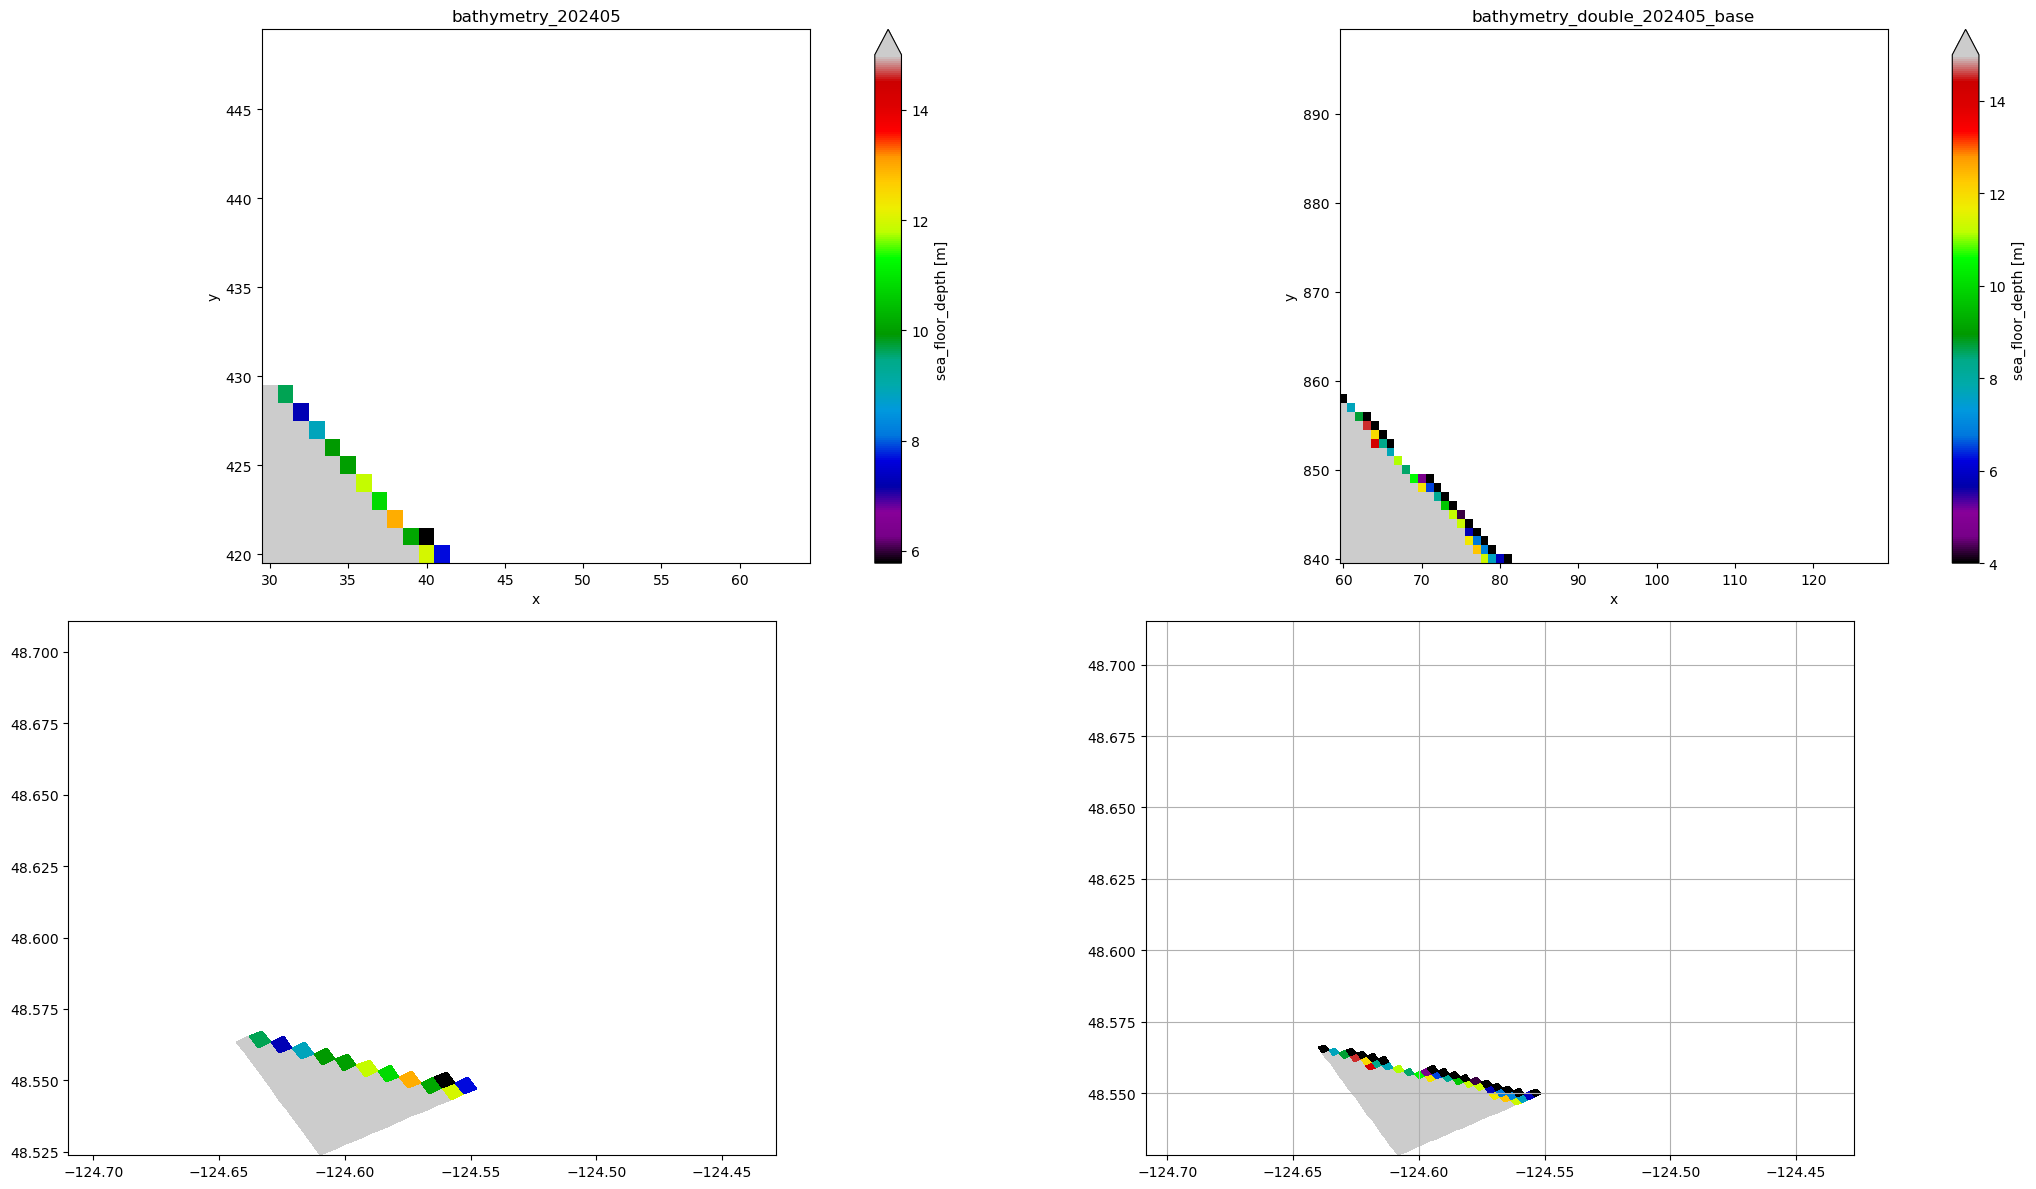

In [59]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 13, 2

* all land

### Tile 13, 3

* all land

### Tile 13, 4

* all land

### Tile 13, 5

* all land

### Tile 13, 6 - Stz’Uminus, Saltair & Chemainus

* connect Bare Point opposite Chemainus

(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

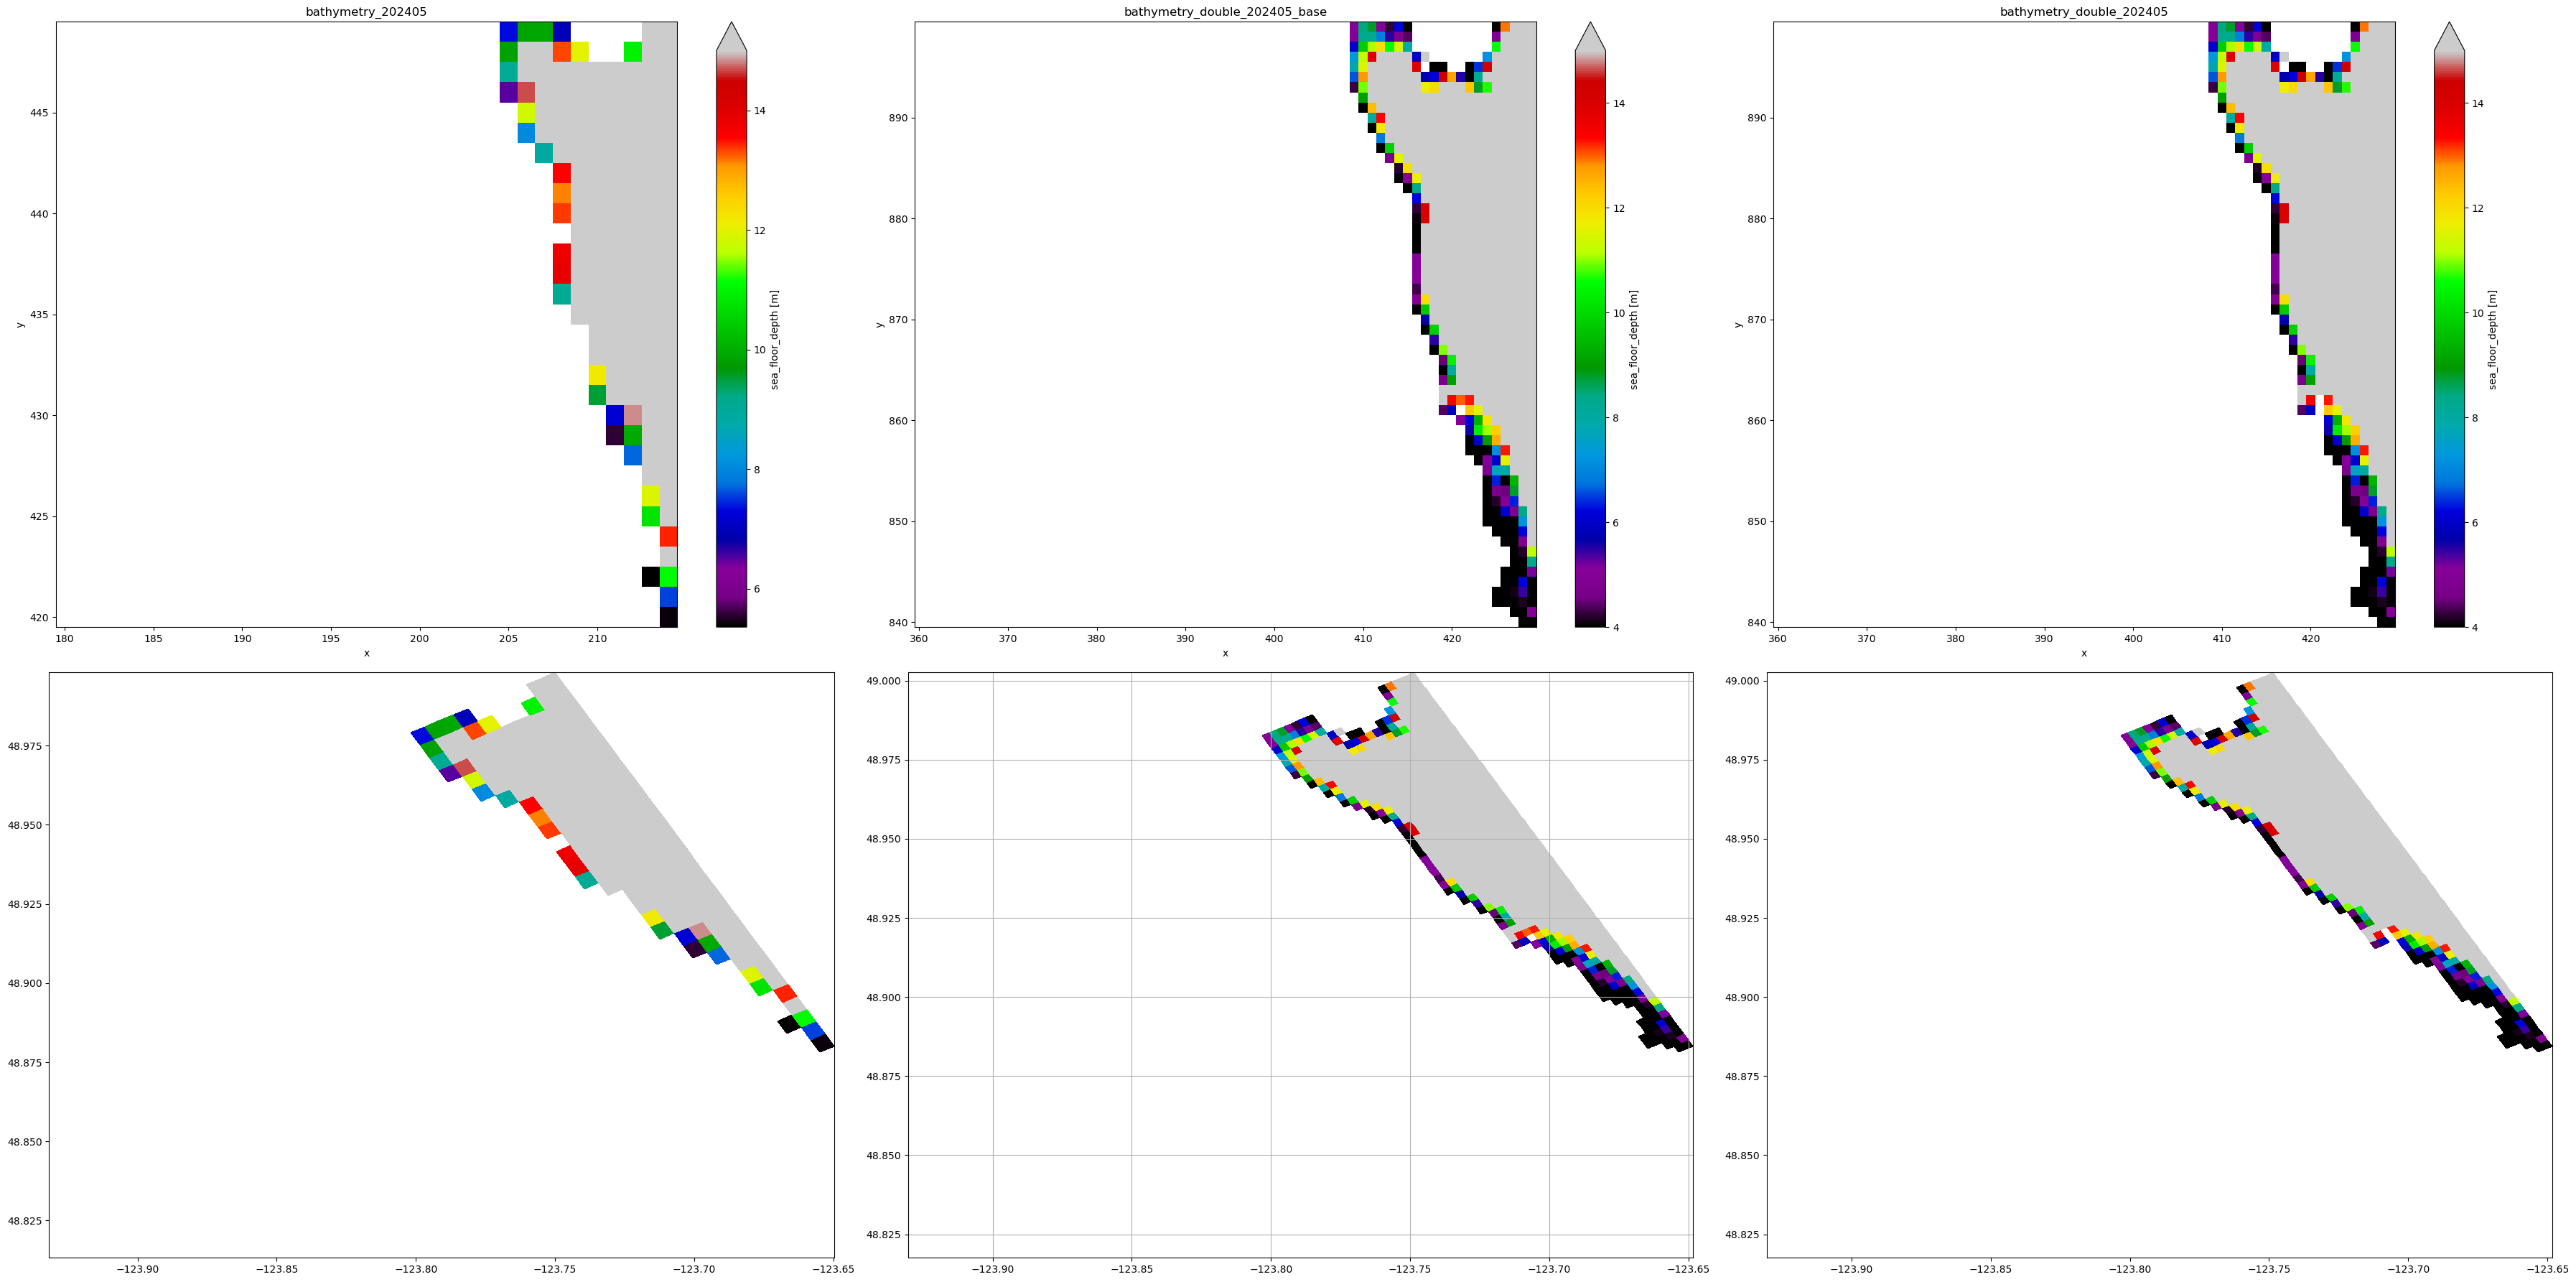

In [60]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 13, 7 - Thetis & Penelakut Islands, Valdes Island, North Galiano Island

* assign average depths to 1 fake island and fake point on west shore of Thetis Island
* connect south point of Wallace Island
* surface Hall Island
* surface Norway Island
* fix Reid Island and remove north islet


(<Figure size 3600x1800 with 9 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

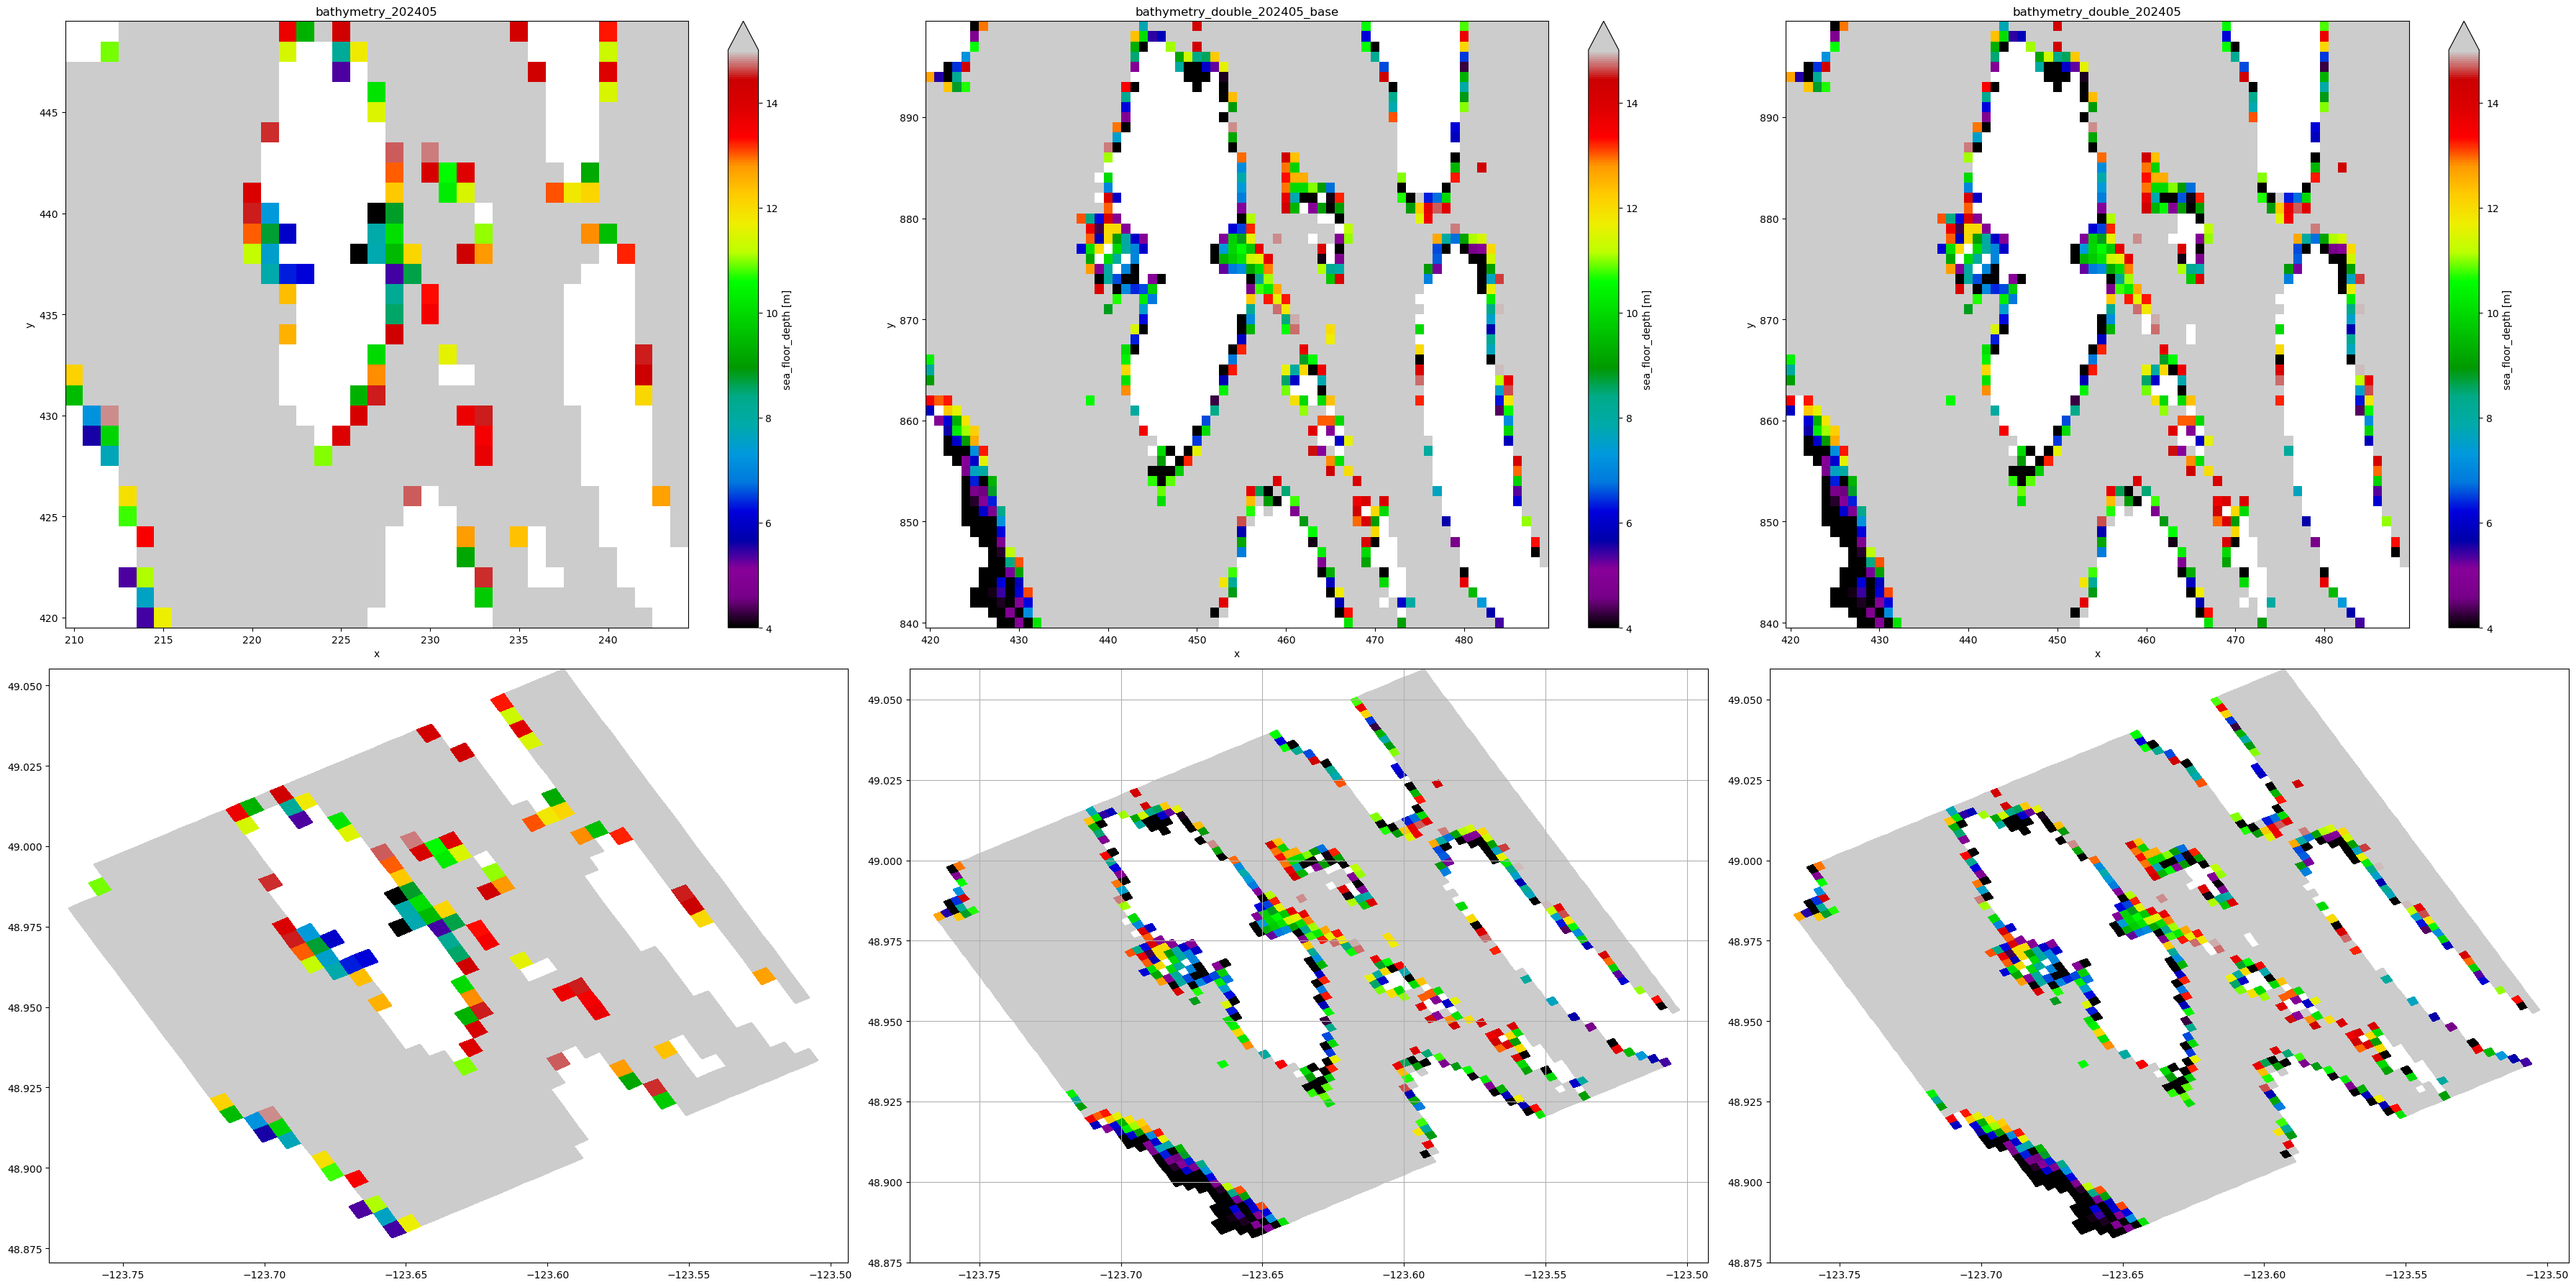

In [61]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 13, 8 - Mid Galiano Island


(<Figure size 2400x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'bathymetry_202405'}, xlabel='x', ylabel='y'>,
         <Axes: title={'center': 'bathymetry_double_202405_base'}, xlabel='x', ylabel='y'>],
        [<Axes: >, <Axes: >]], dtype=object))

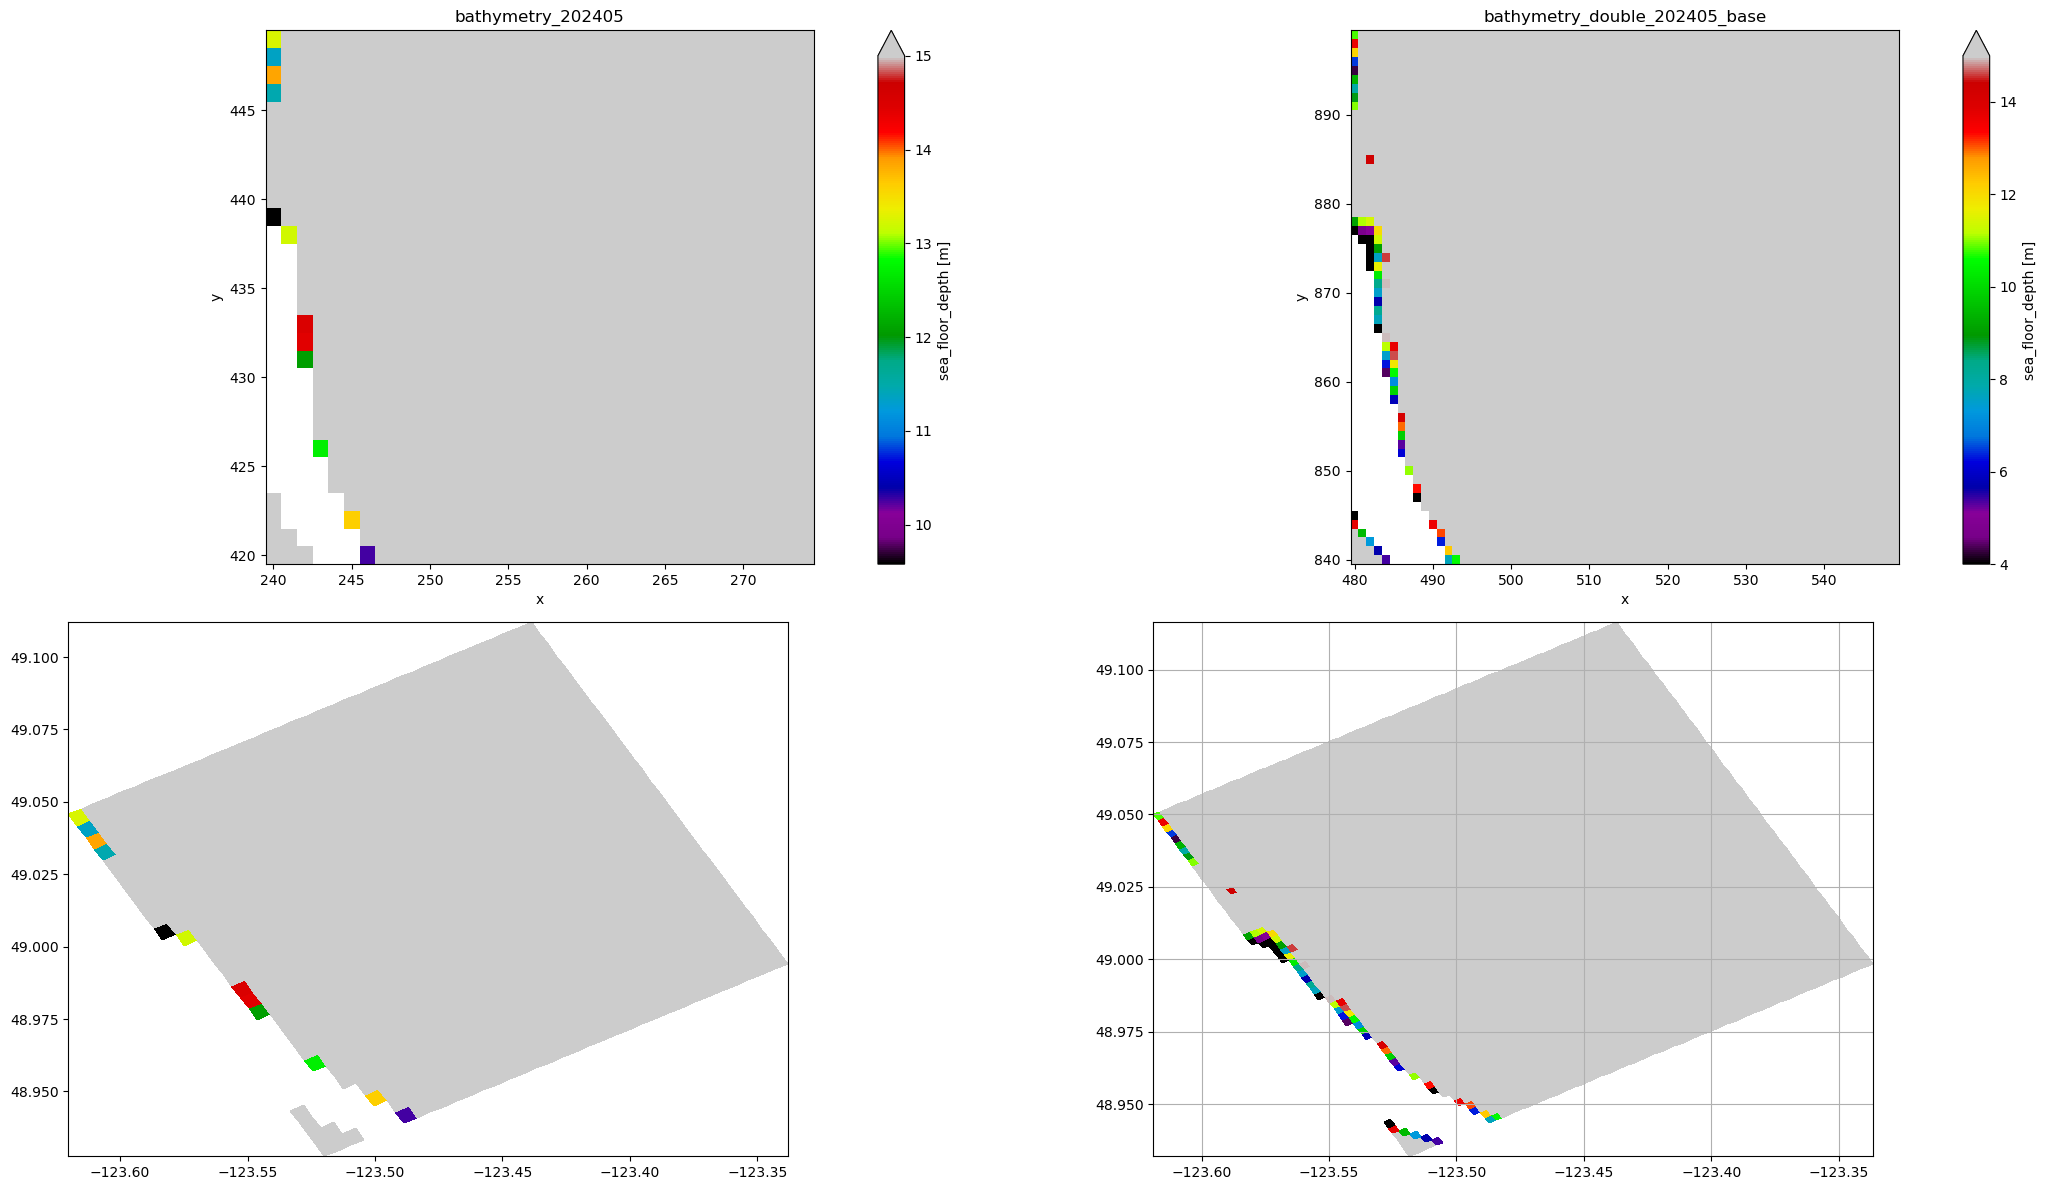

In [62]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base)

### Tile 13, 9 - Fraser River Main Channel, Westham Island, Steveston

* little pixel islands are okay, as long as water can go everywhere
* add a final point to Steveston Jetty (change to 4m deep)
* make southern channel of Fraser River contiguous (change 1 cell to to 4m deep)


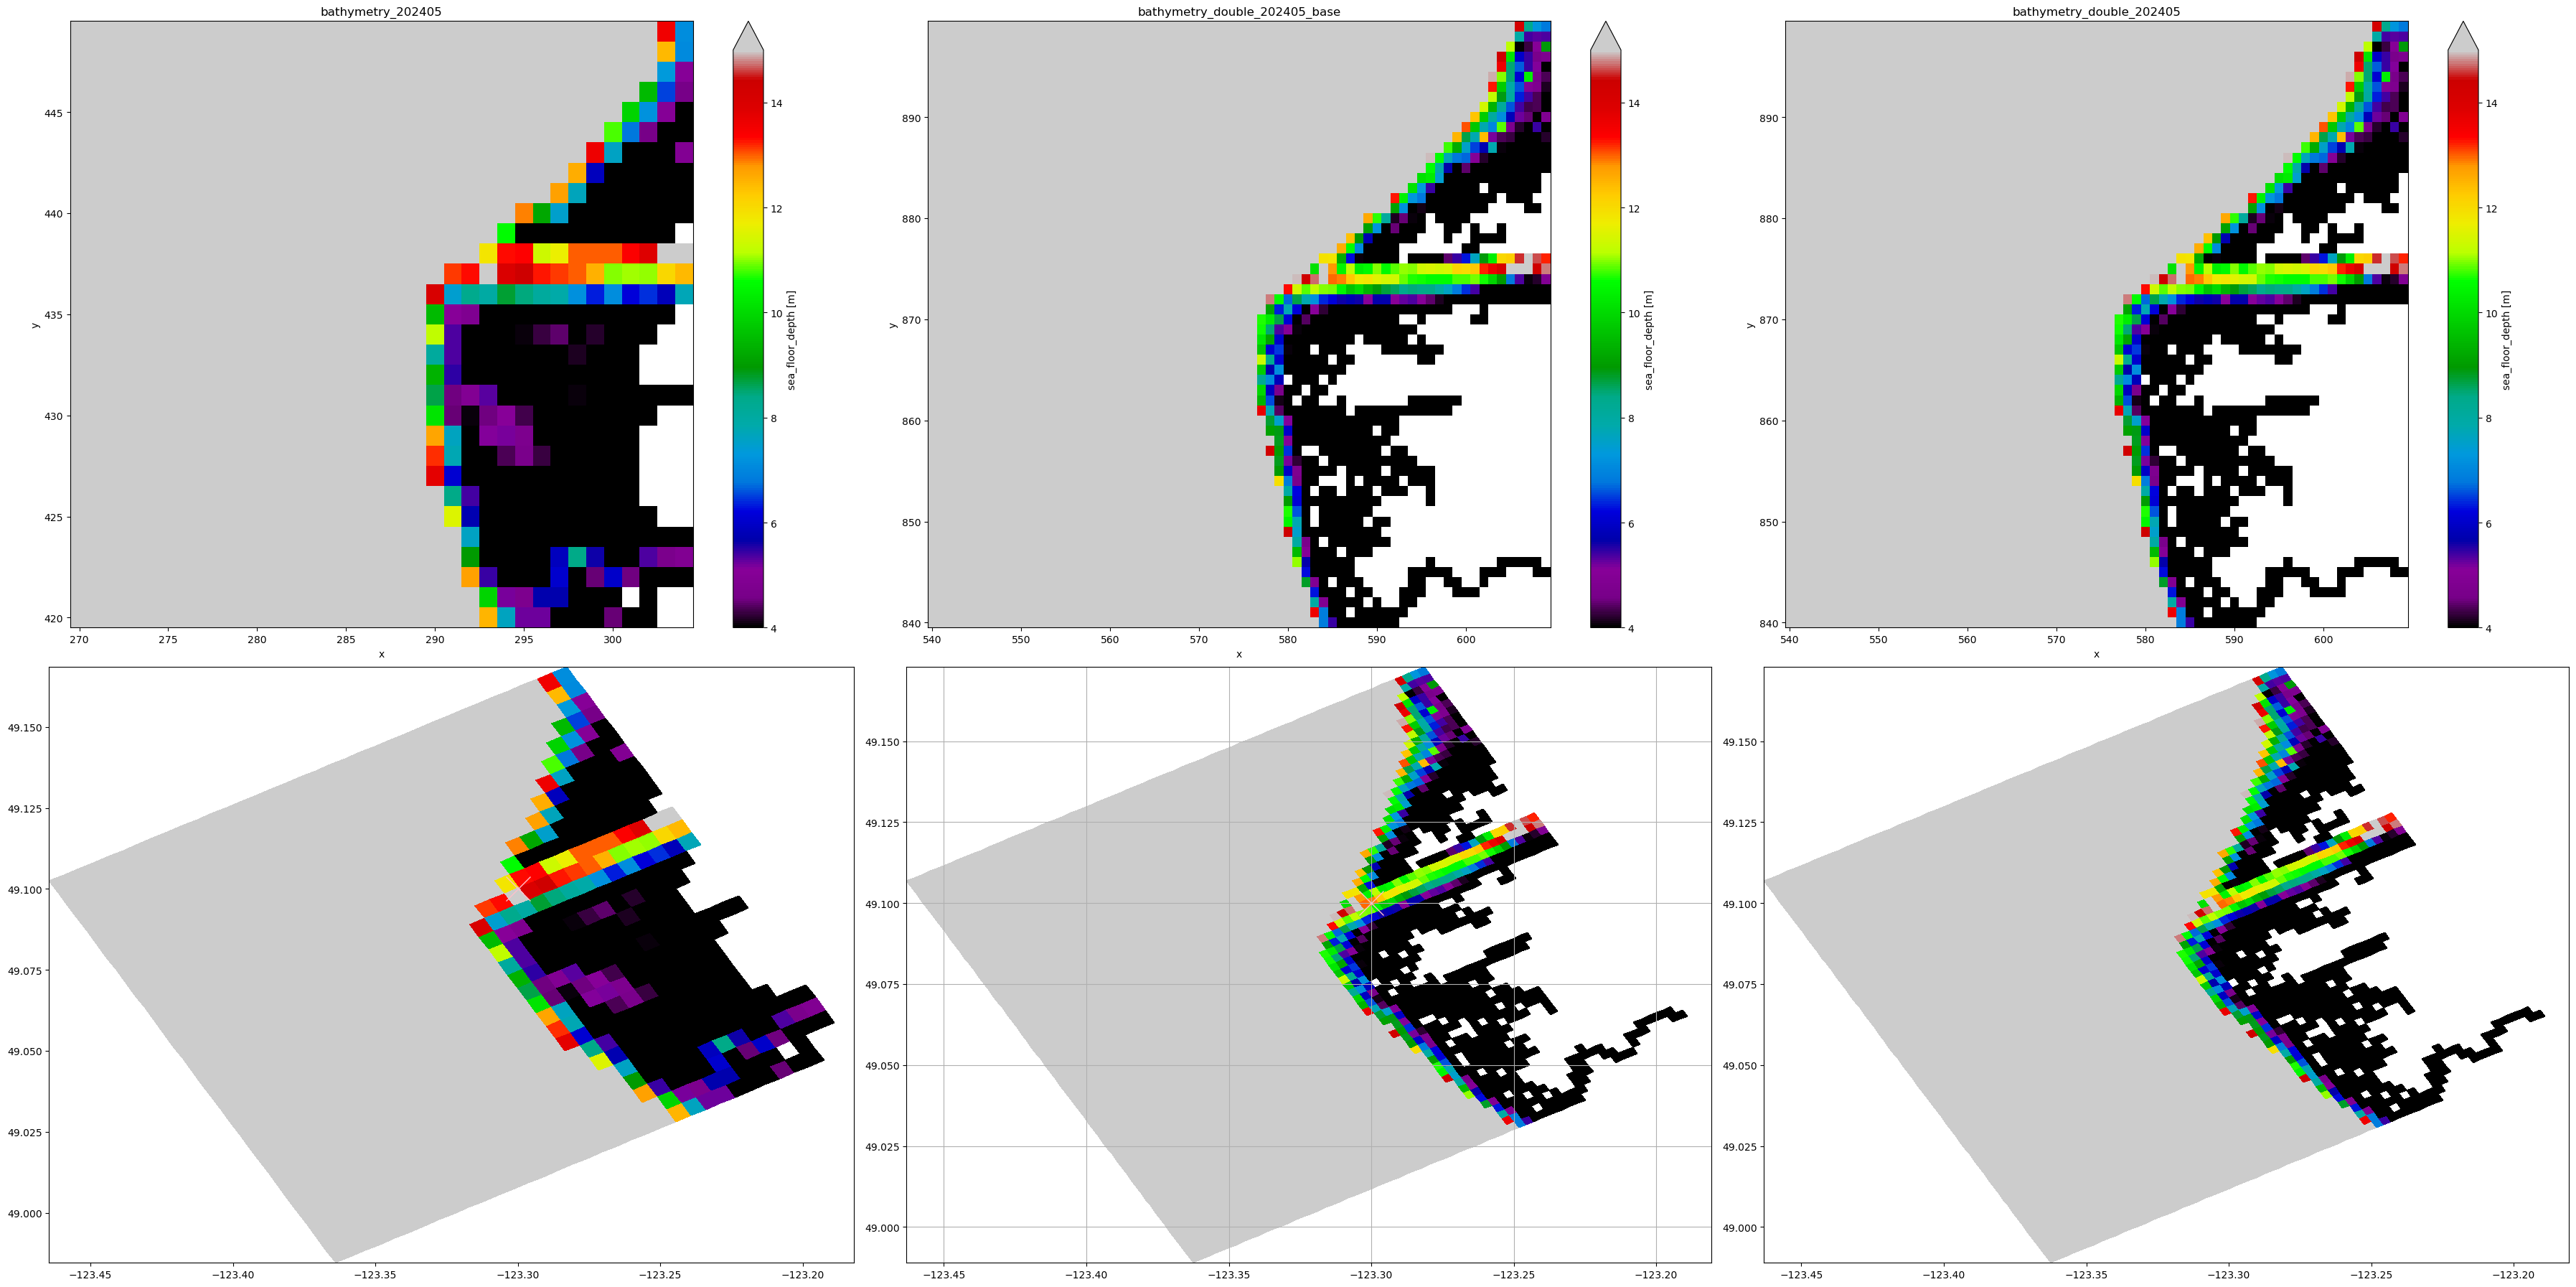

In [63]:
fig, axs = plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base, dbl_bathy)
axs[1, 0].plot(-123.3, 49.1, 'x', c='pink', markersize=24);  # location of Sand Heads
axs[1, 1].plot(-123.3, 49.1, 'x', c='pink', markersize=24);


### Tile 13, 10 - Richmond, Delta, Deas Island, Fraser River Middle Arm

* leave pixel islands on Lulu Island foreshore mud flats
* Canoe Pass is fine
* open Fraser River Middle Arm

/tmp/ipykernel_846180/1784615056.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_846180/1784615056.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_846180/1784615056.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. 

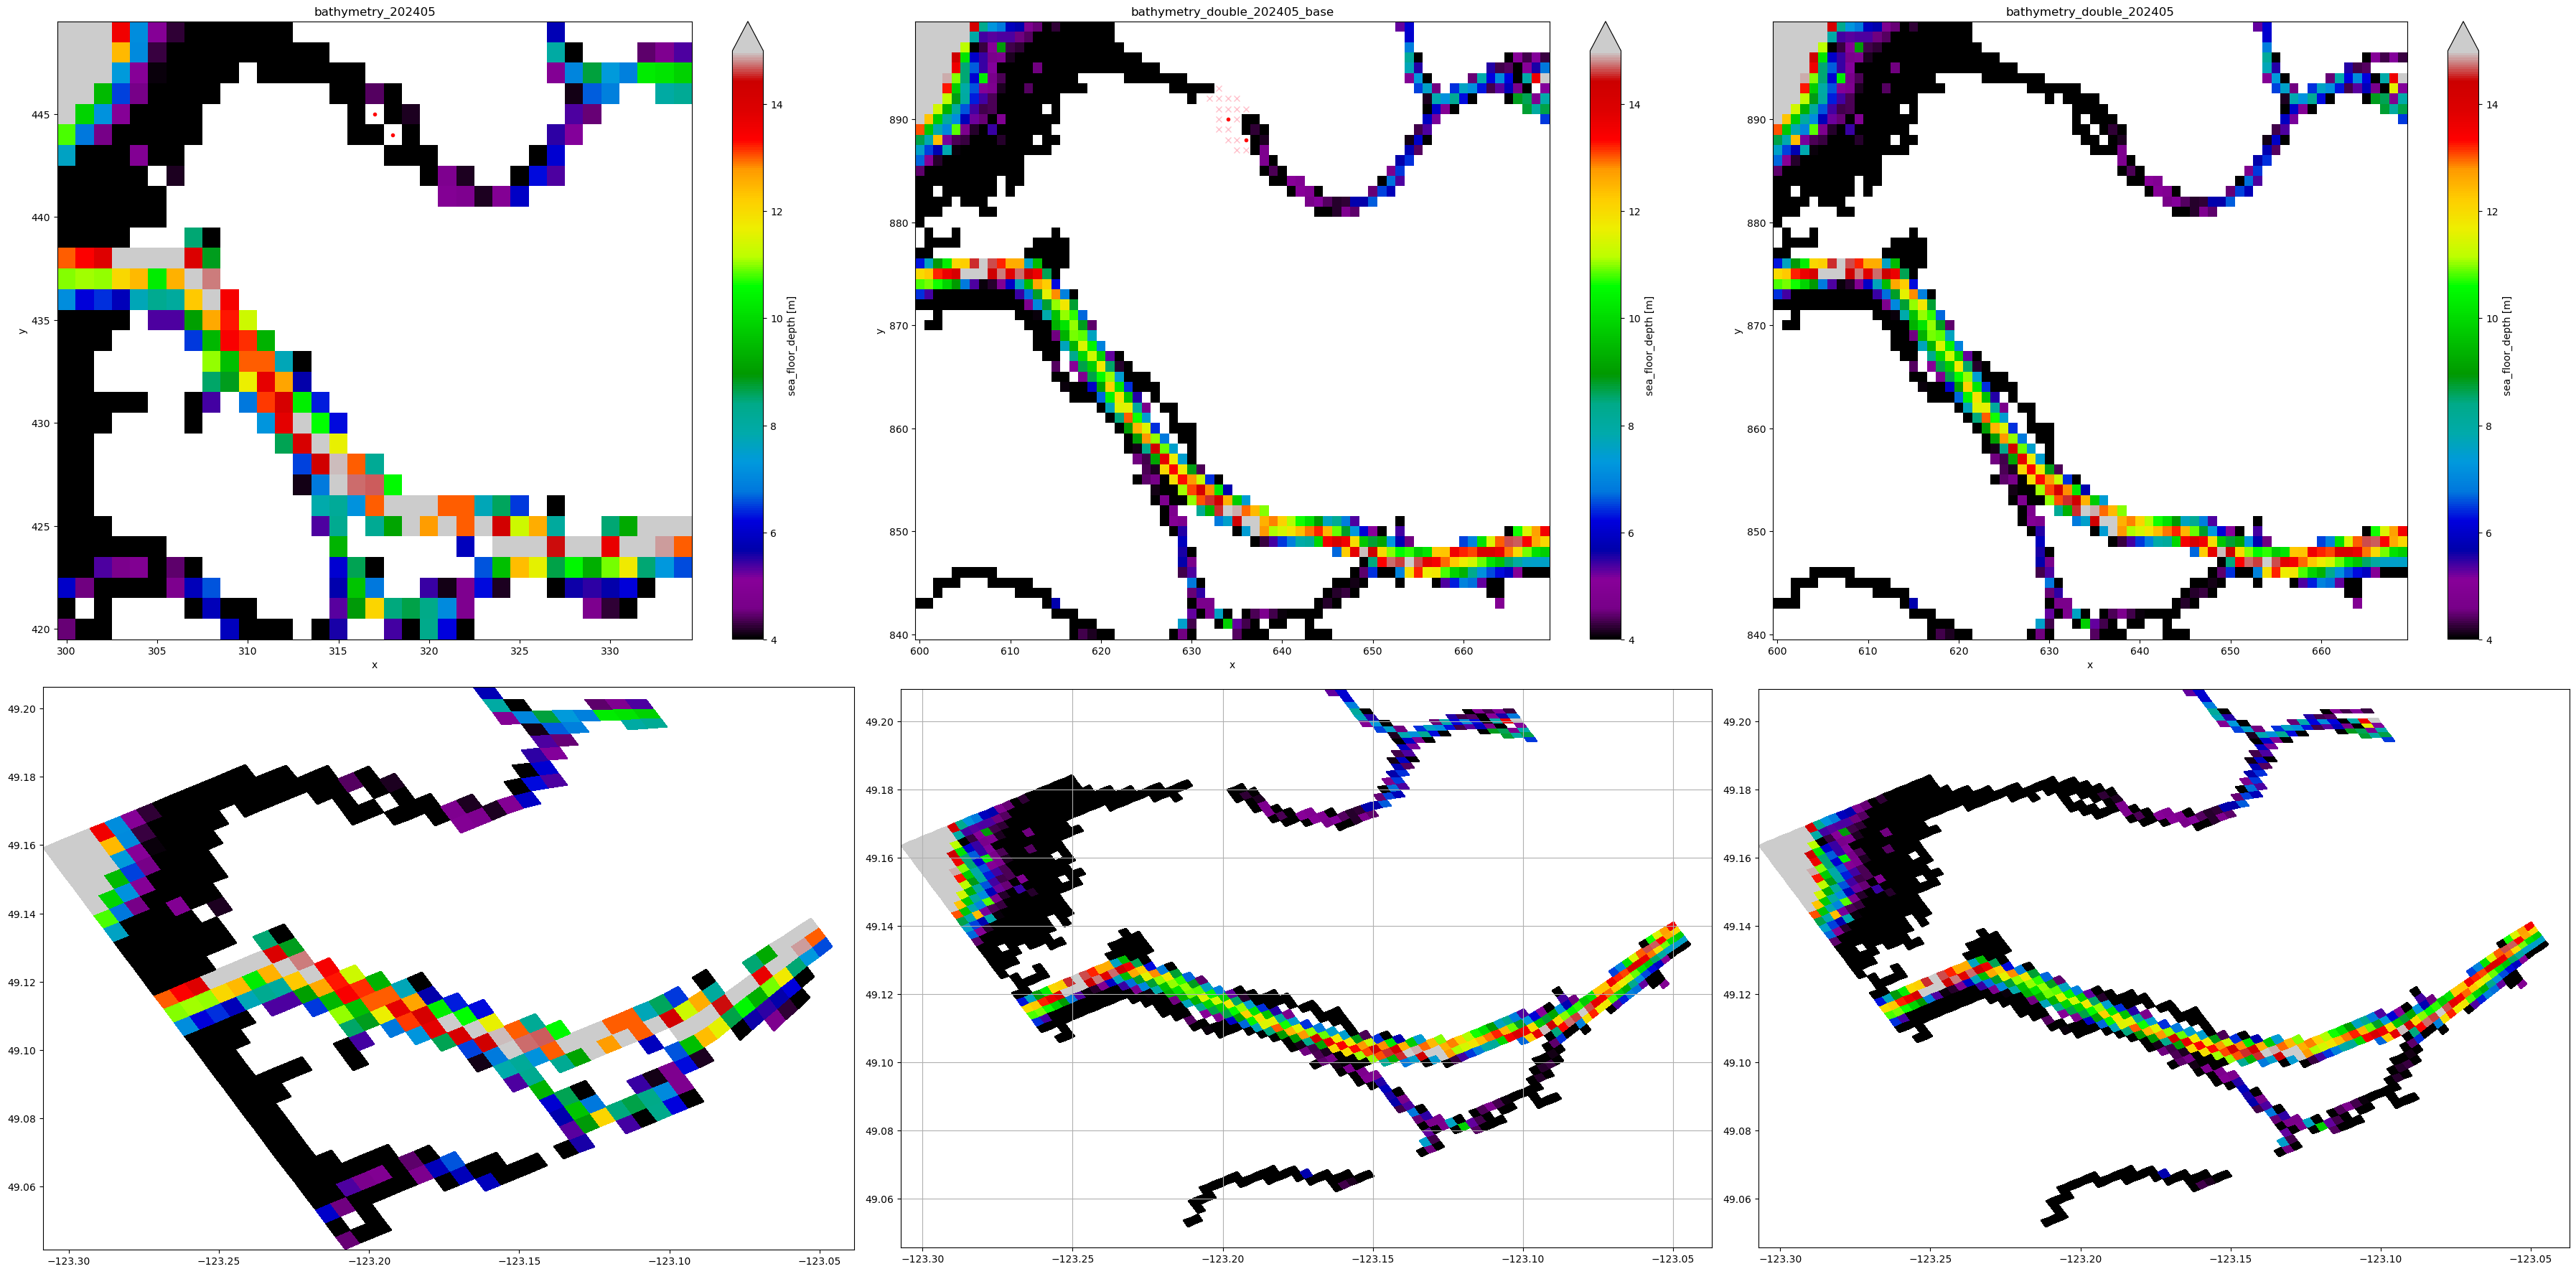

In [64]:
fig, axs = plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base, dbl_bathy)
axs[0, 0].plot([317, 318], [445, 444], 'r.')
axs[0, 1].plot([317*2, 318*2], [445*2, 444*2], 'r.')

axs[0, 1].plot([636, 635, 635, 634, 634, 633, 633, 633], [887, 887, 888, 888, 889, 889, 890, 891], 'x', c='pink'); #open Middle Arm, all 4 m
axs[0, 1].plot([635, 635, 636, 634, 634, 635, 633, 632, 633], [890, 891, 891, 891, 892, 892, 892, 892, 893], 'x', c='pink'); # open Middle Arm, all 4 m


### Tile 13, 11 - Queensborough, Annacis Island, Fraser River Split

* surface Mitchell Island: very weird, the current land point is the in middle of the deep channel (gray), Mitchell Island is north of the channel
* connect west tip of Annacis Island

* (note, bend into Row 12 is fine)

/tmp/ipykernel_846180/1784615056.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_846180/1784615056.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_846180/1784615056.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. 

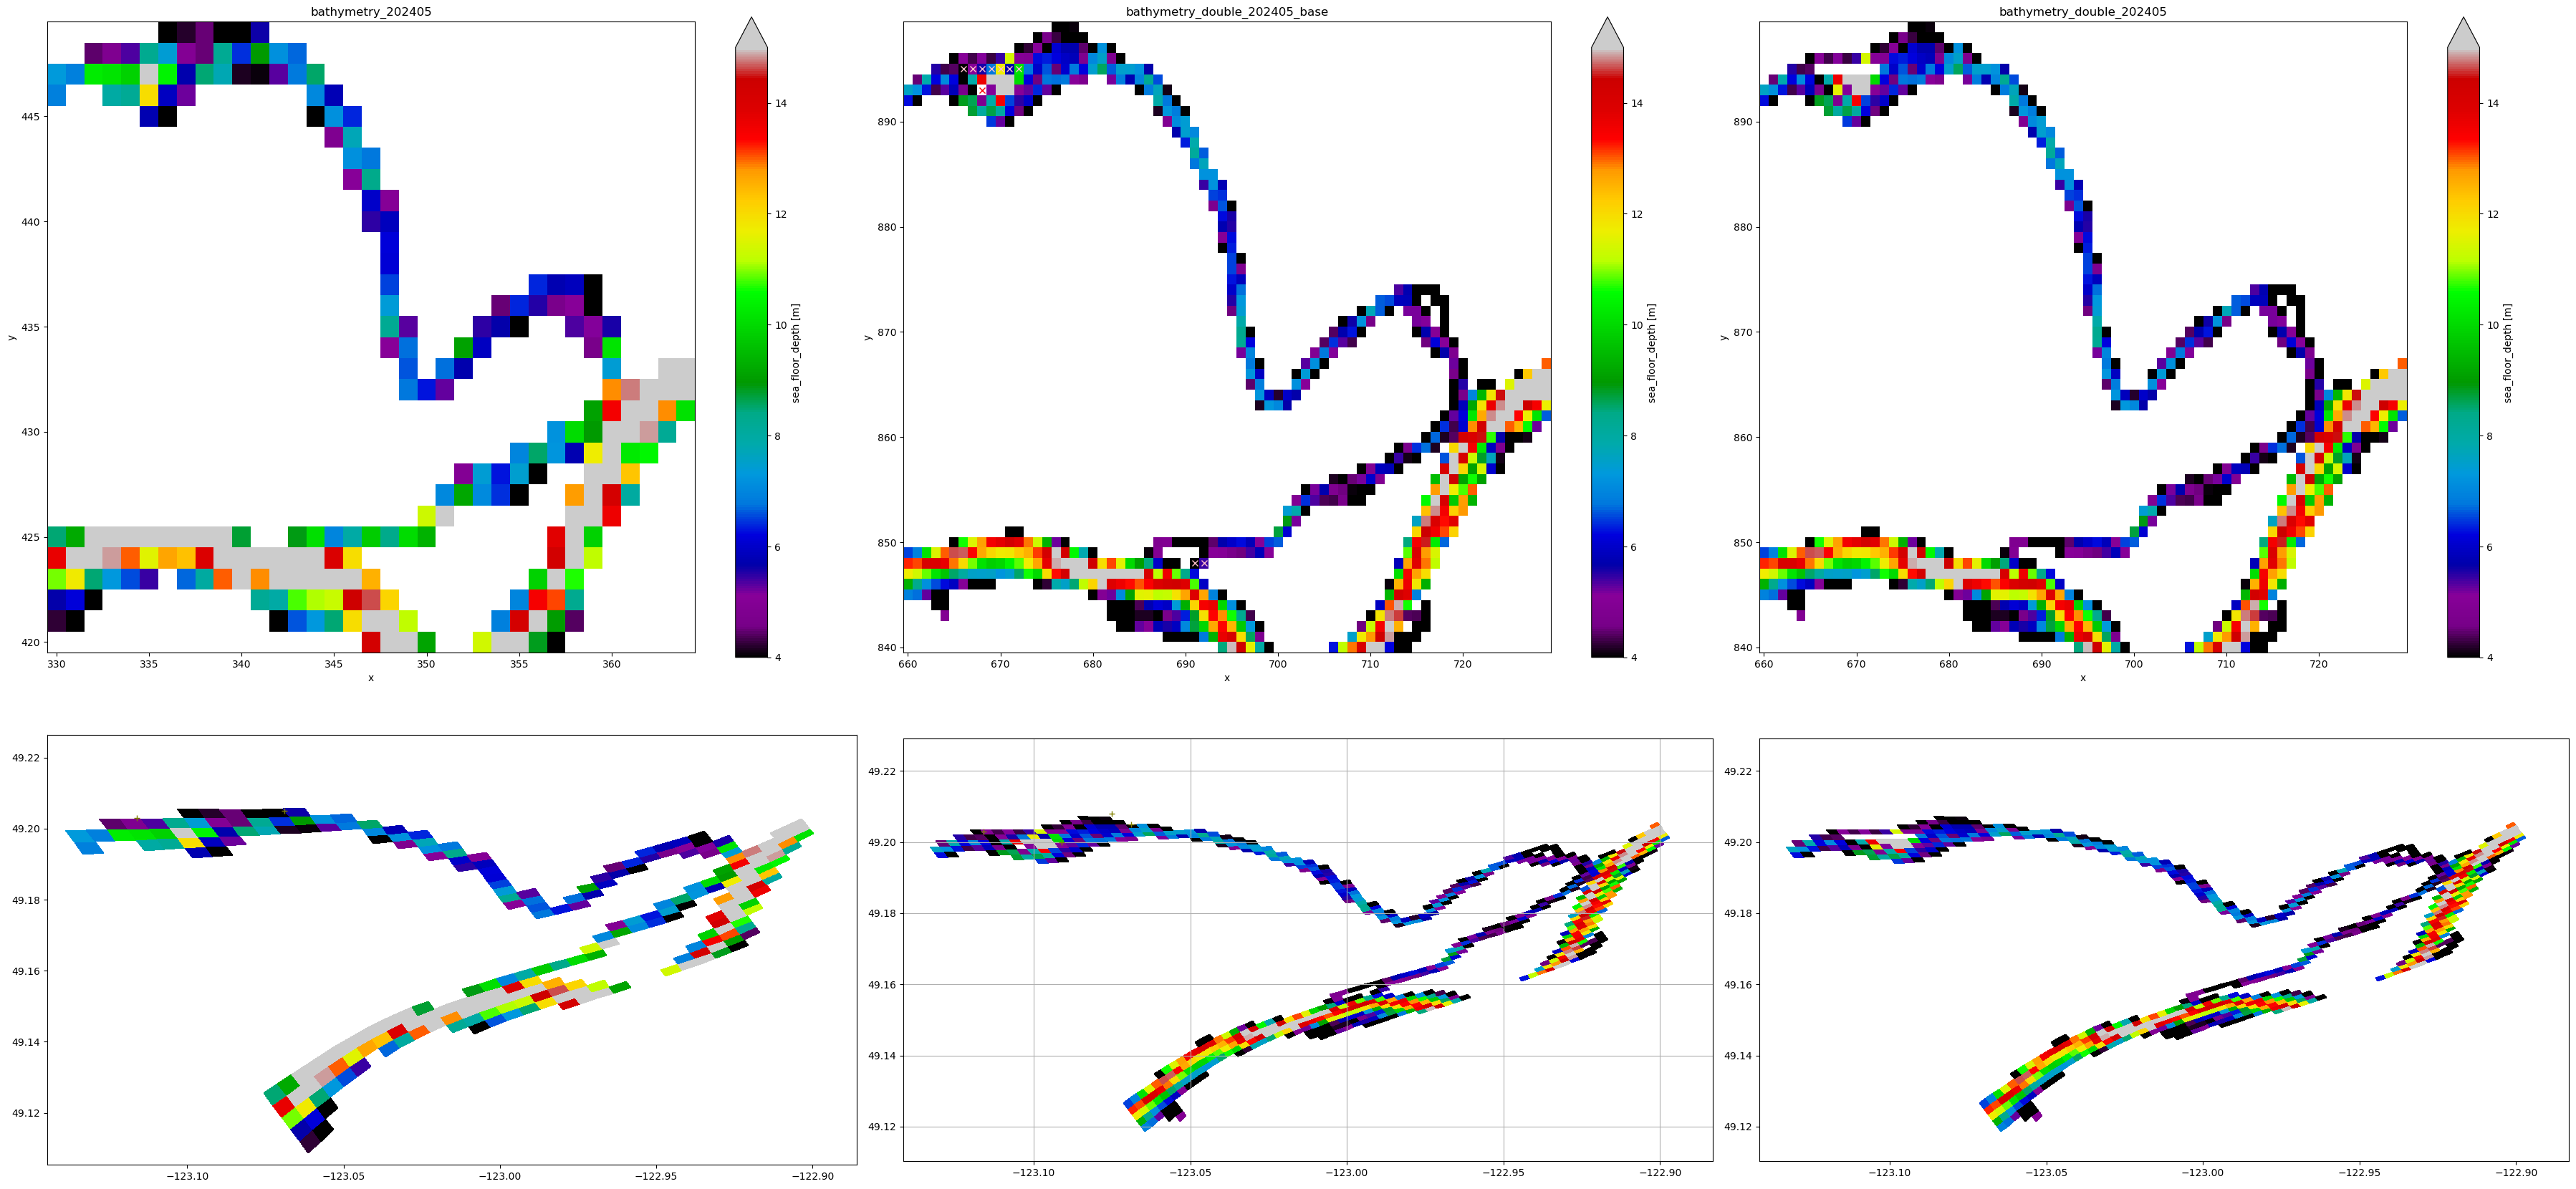

In [65]:
fig, axs = plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base, dbl_bathy)

axs[1, 0].plot(-123.116, 49.203, '+', c='olive') # west end mitchell island
axs[1, 1].plot(-123.116, 49.203, '+', c='olive') # west end mitchell island
axs[1, 0].plot(-123.069, 49.205, '+', c='olive') # east end mitchell island
axs[1, 1].plot(-123.069, 49.205, '+', c='olive'); # east end mitchell island
axs[1, 1].plot(-123.091, 49.200, '+', c='olive'); # south point mitchell island
axs[1, 1].plot(-123.075, 49.208, '+', c='olive'); # north extreme mitchell island


axs[0, 1].plot(668, 893, 'x', c='red') # remove this land, make depth = average of surrounding points
axs[0, 1].plot(numpy.arange(666, 673), numpy.ones(7)*895, 'x', c='pink') # make land
axs[0, 1].plot([691, 692], [848, 848], 'x', c='pink'); # make land

### Tile 13, 12 - Fraser River, Douglas Island, Pitt River

/tmp/ipykernel_846180/1784615056.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_846180/1784615056.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)


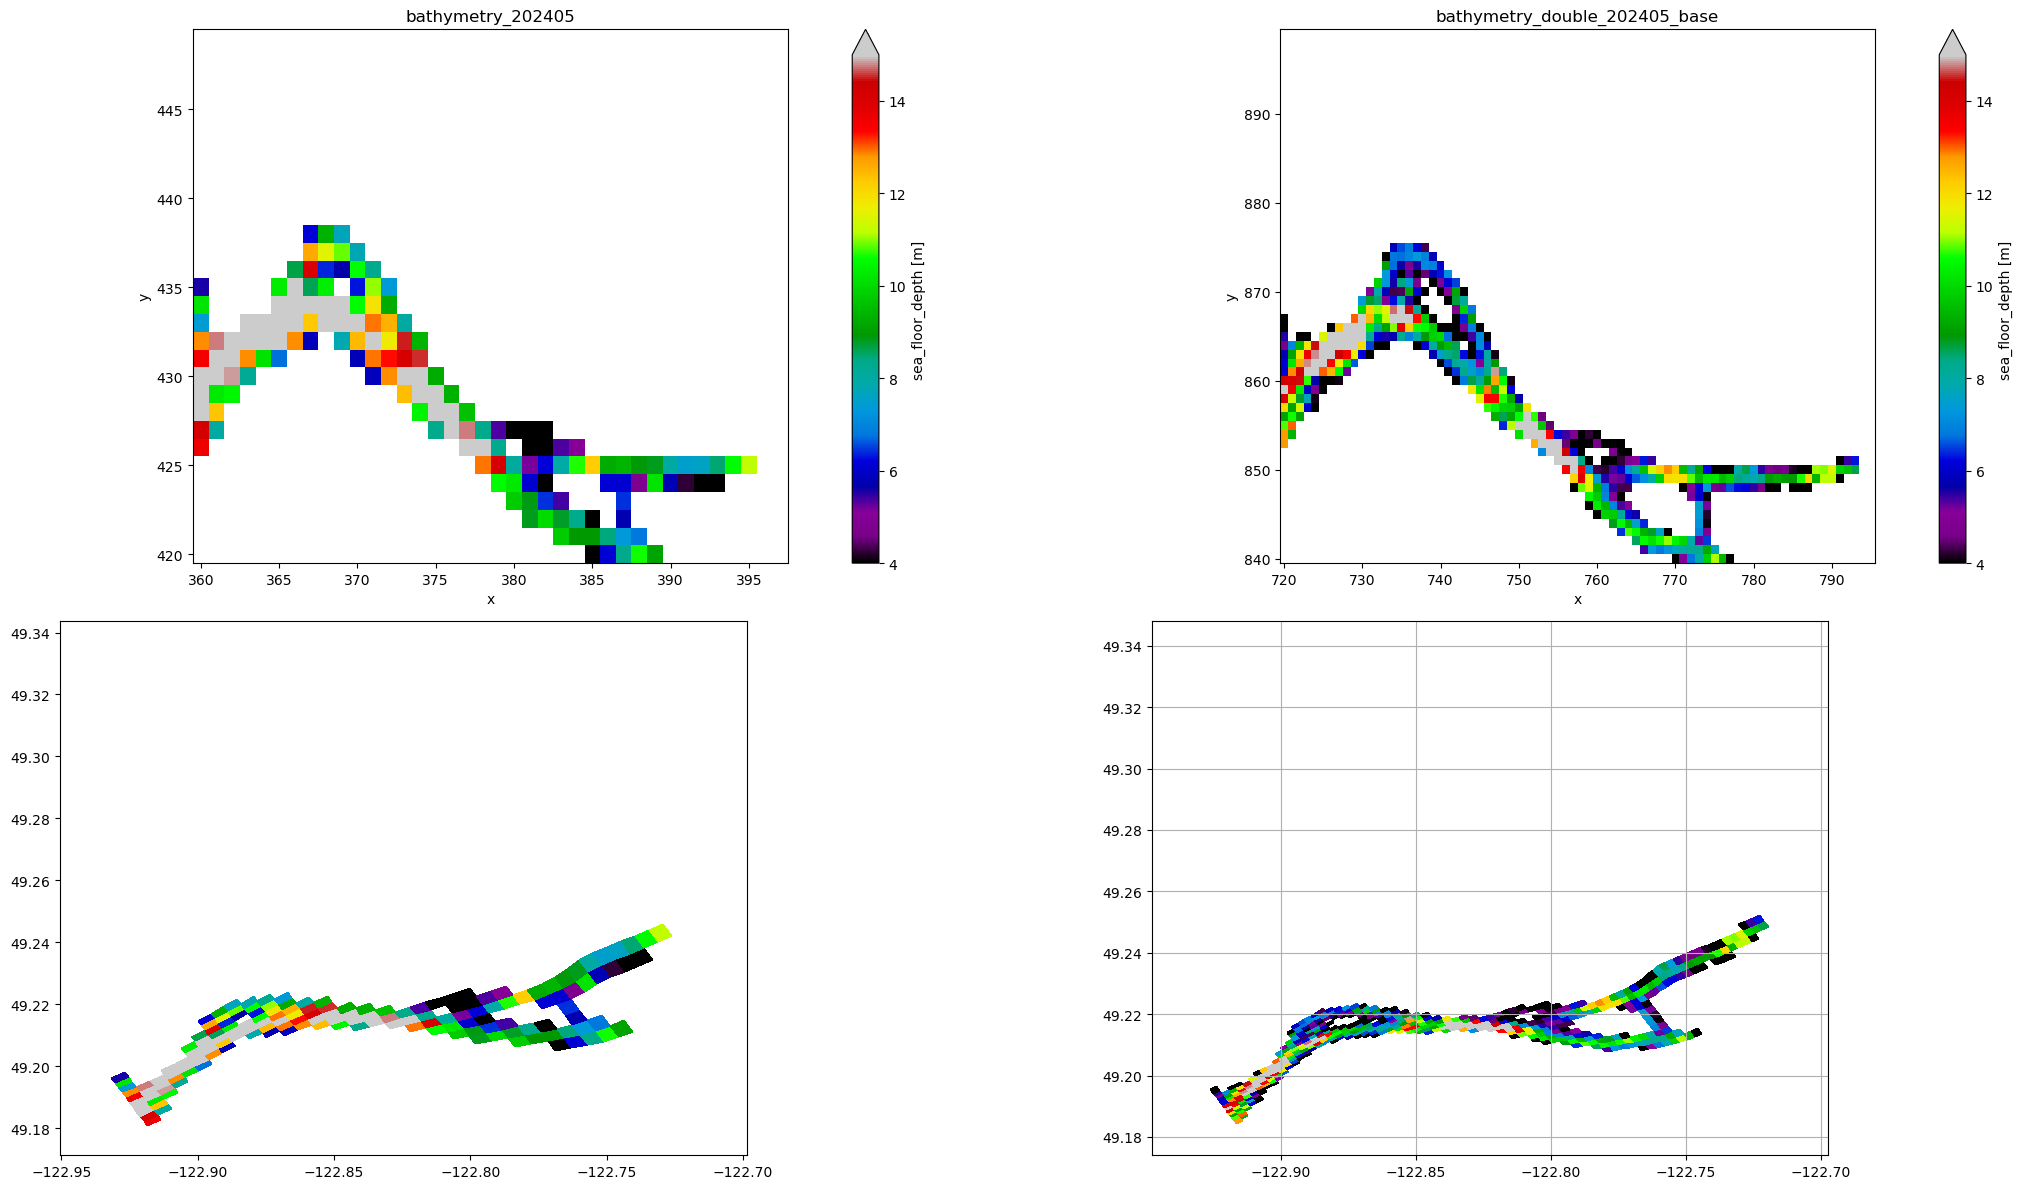

In [66]:
plot_tile(tile_x_min_max[12], y_slices, bathy, dbl_bathy_base);

## Row 14 - Tsusiat Point to English Bay

In [67]:
y_min_max = numpy.array([445, 480])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 14, 0 - Tsusiat Point

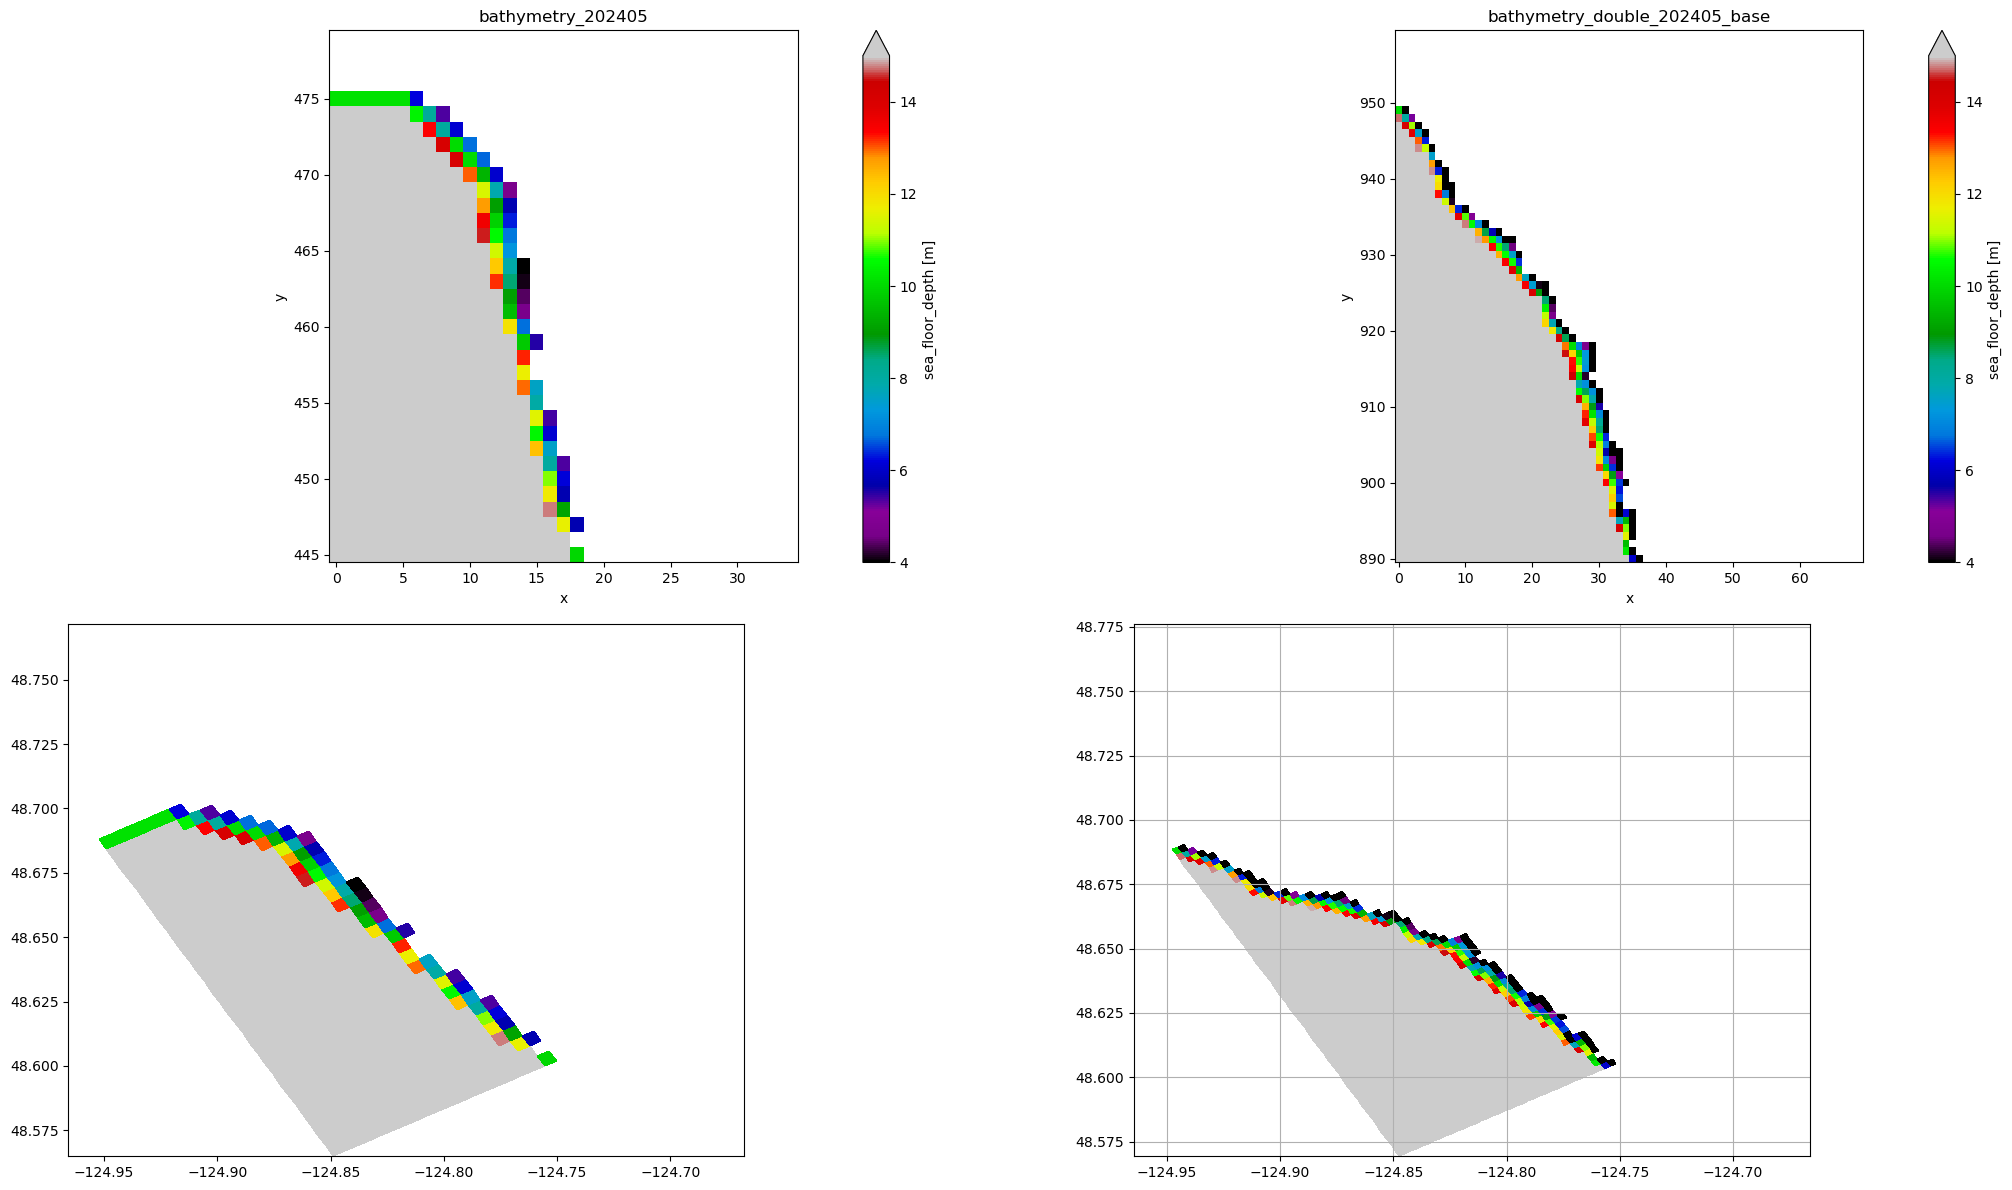

In [68]:
plot_tile(tile_x_min_max[0], y_slices, bathy, dbl_bathy_base);

### Tile 14, 1

* all land

### Tile 14, 2

* all land

### Tile 14, 3

* all land

### Tile 14, 4

* all land

### Tile 14, 5

* all land

### Tile 14, 6 - Ladysmith

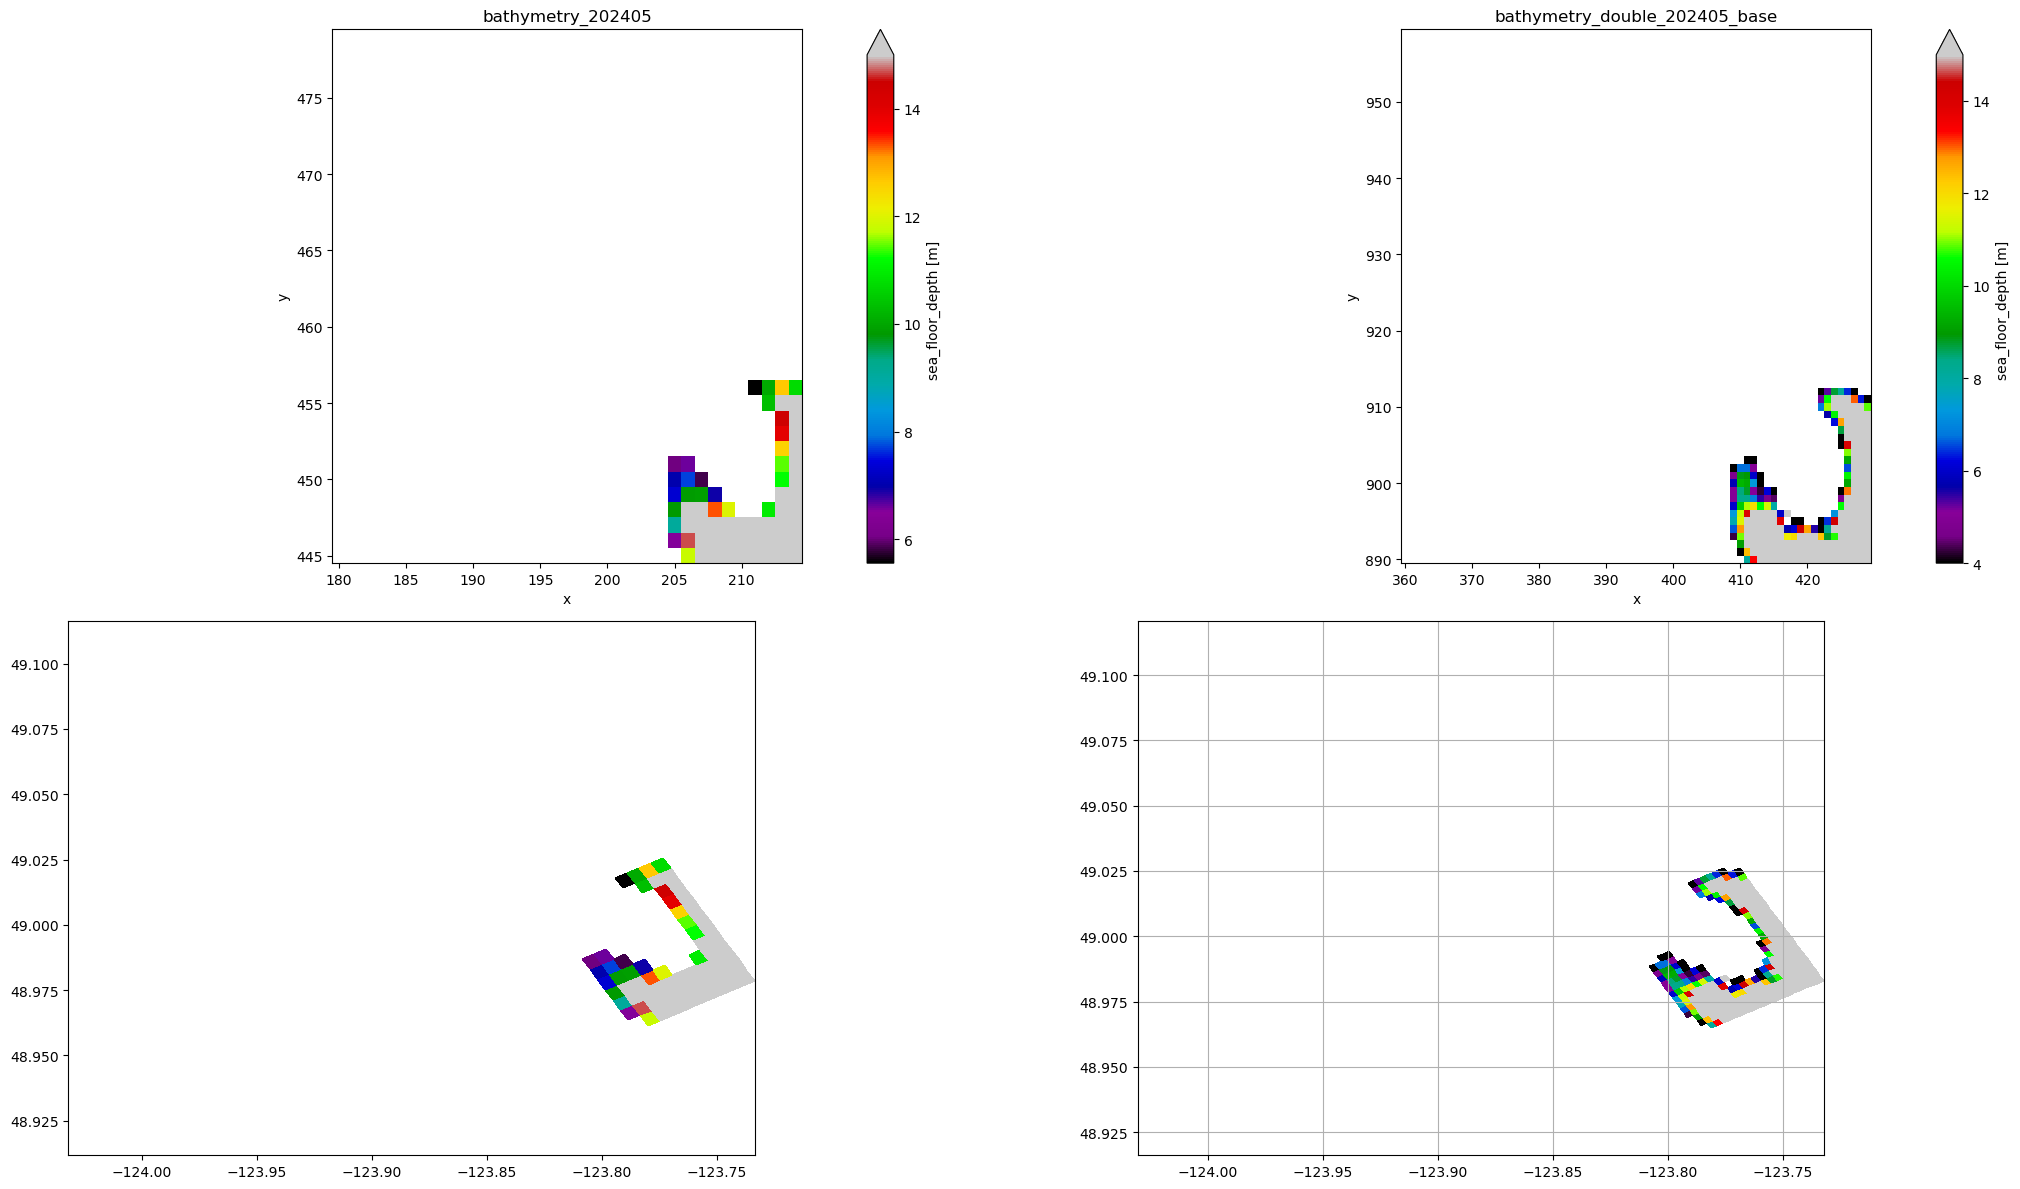

In [69]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base);

### Tile 14, 7 - Yellow Point, North Valdes Island, South Gabriola Island

* surface islands off Gabriola Island

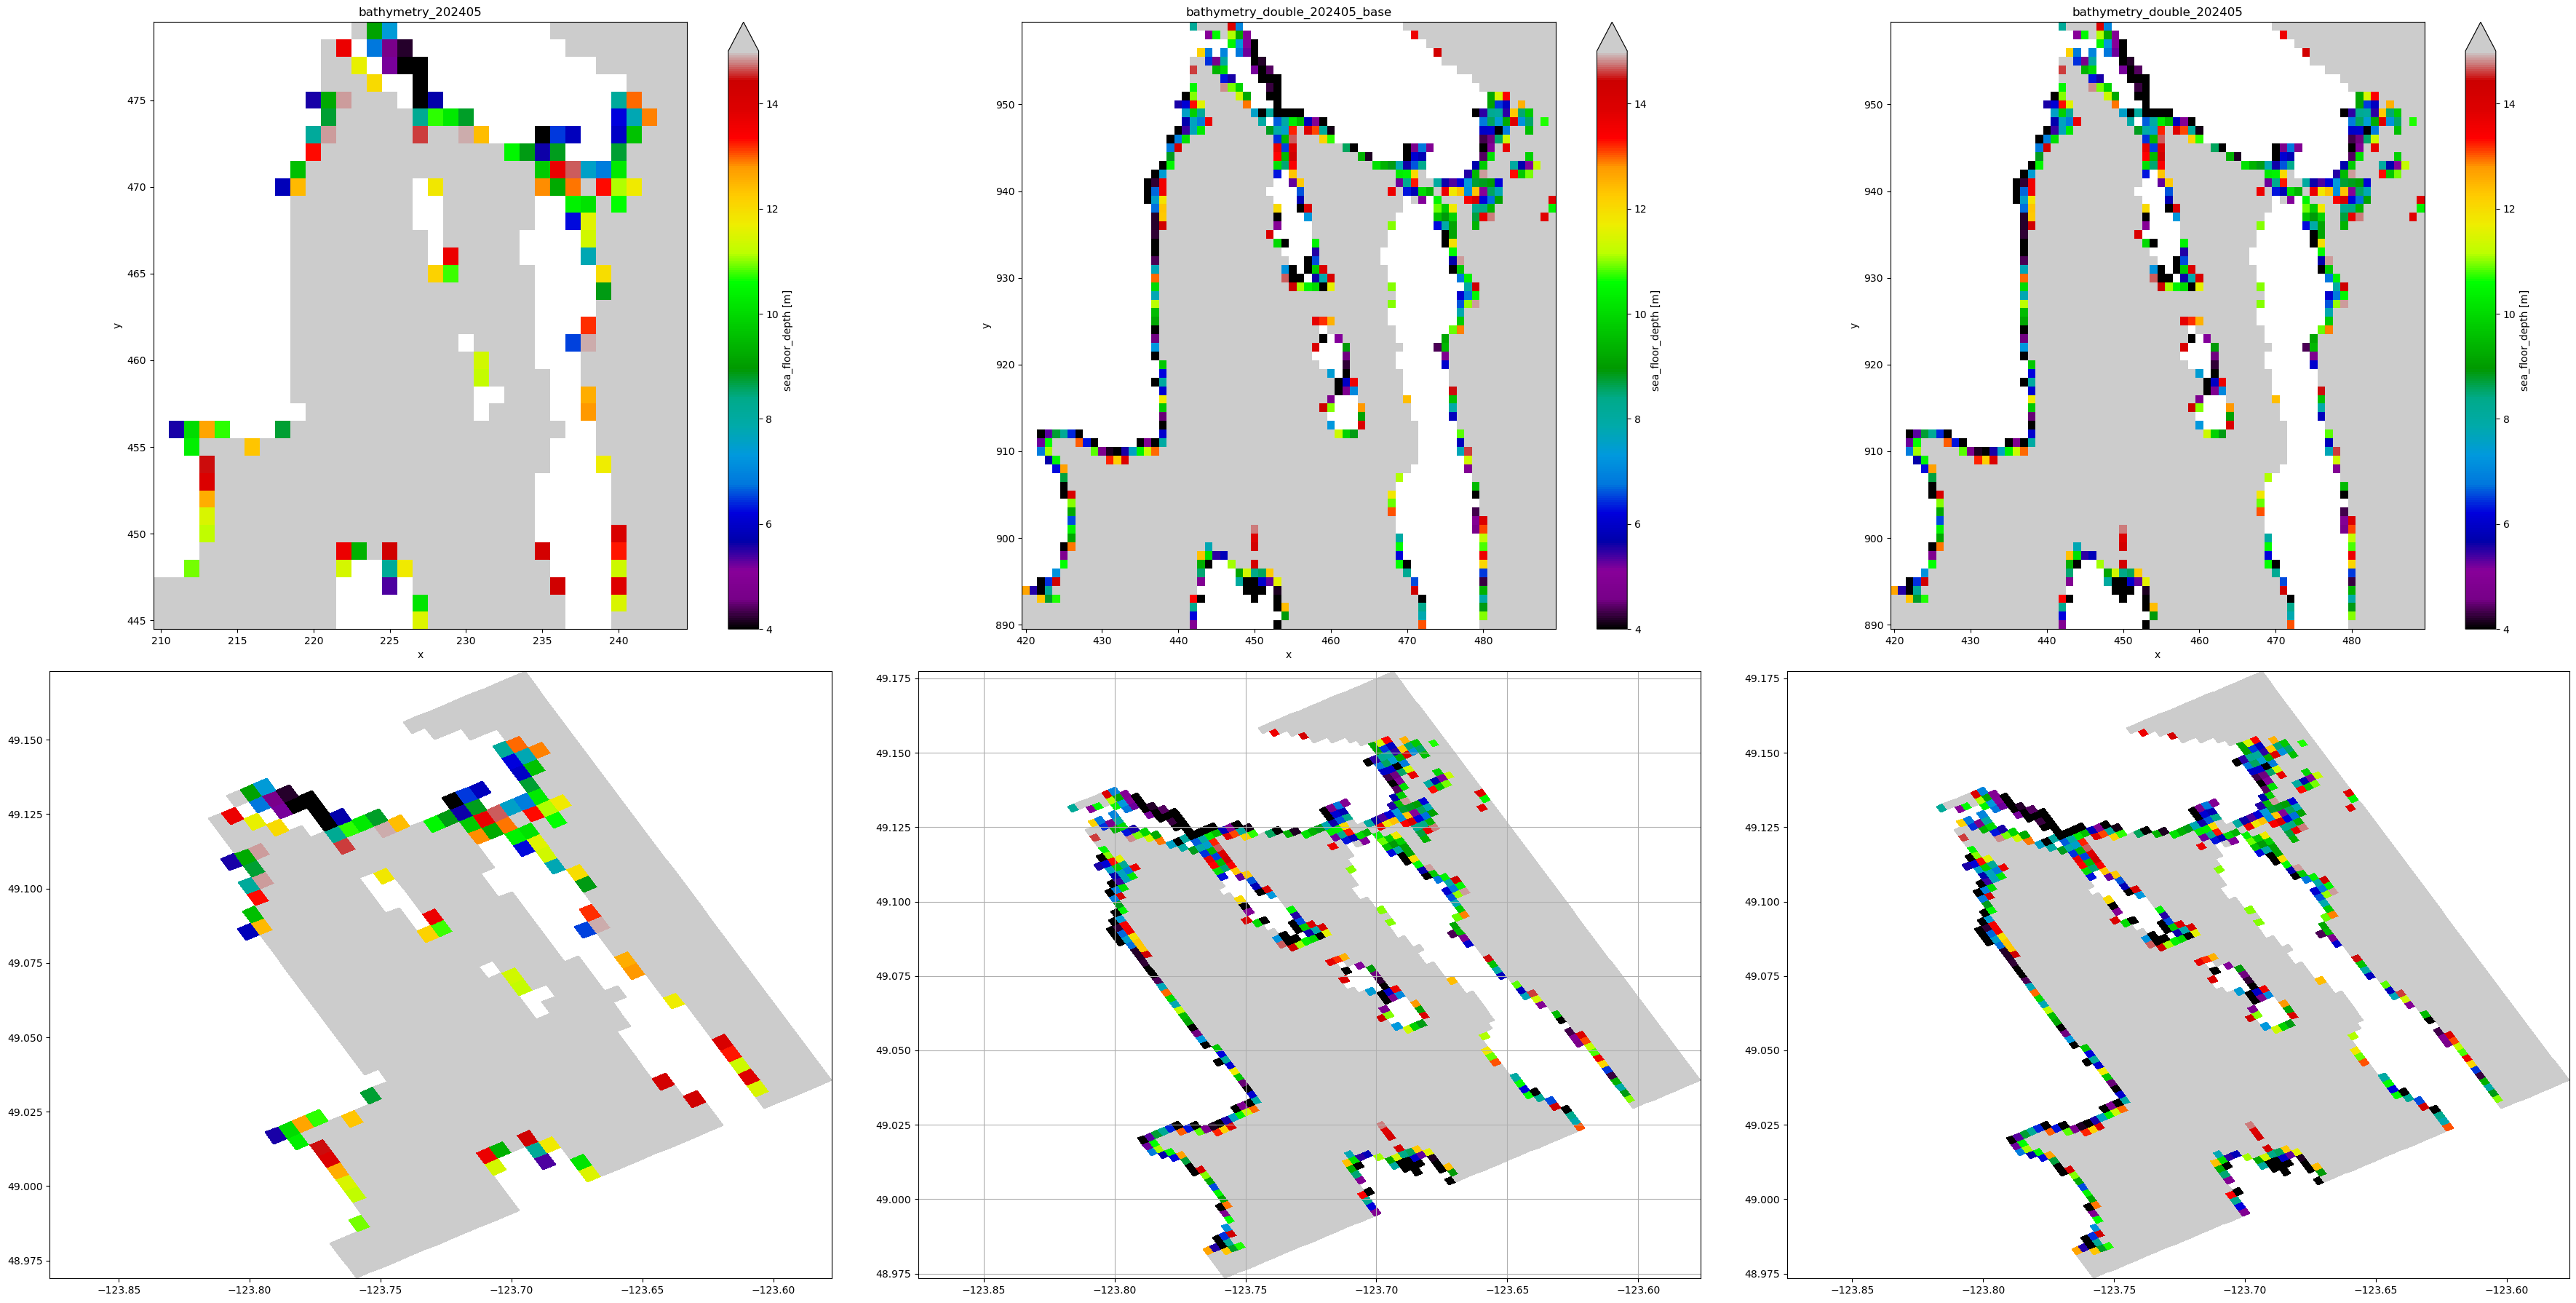

In [70]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy);

### Tile 14, 8 - Southeast Tip of Gabriola Island

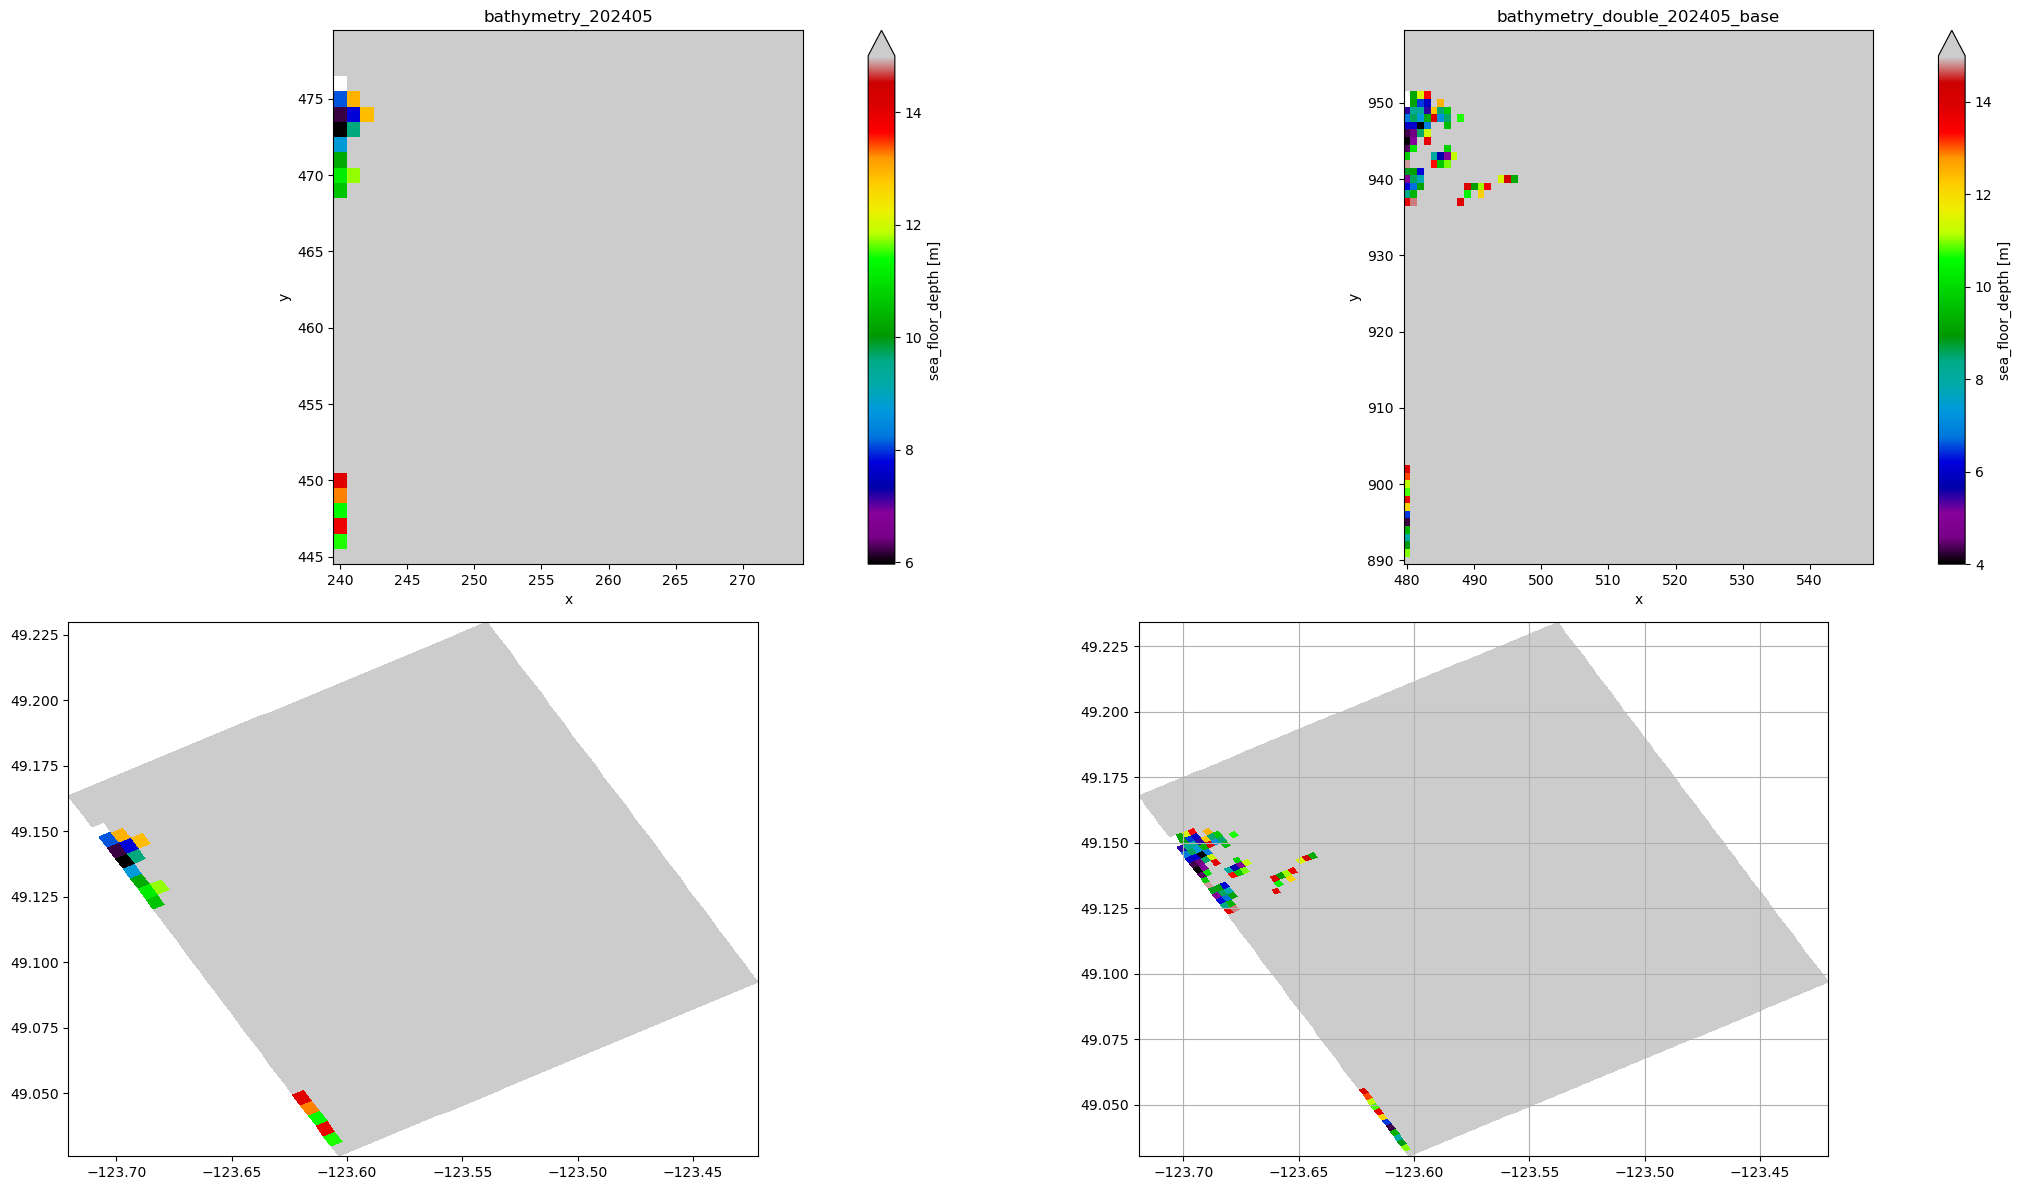

In [71]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base);

### Tile 14, 9


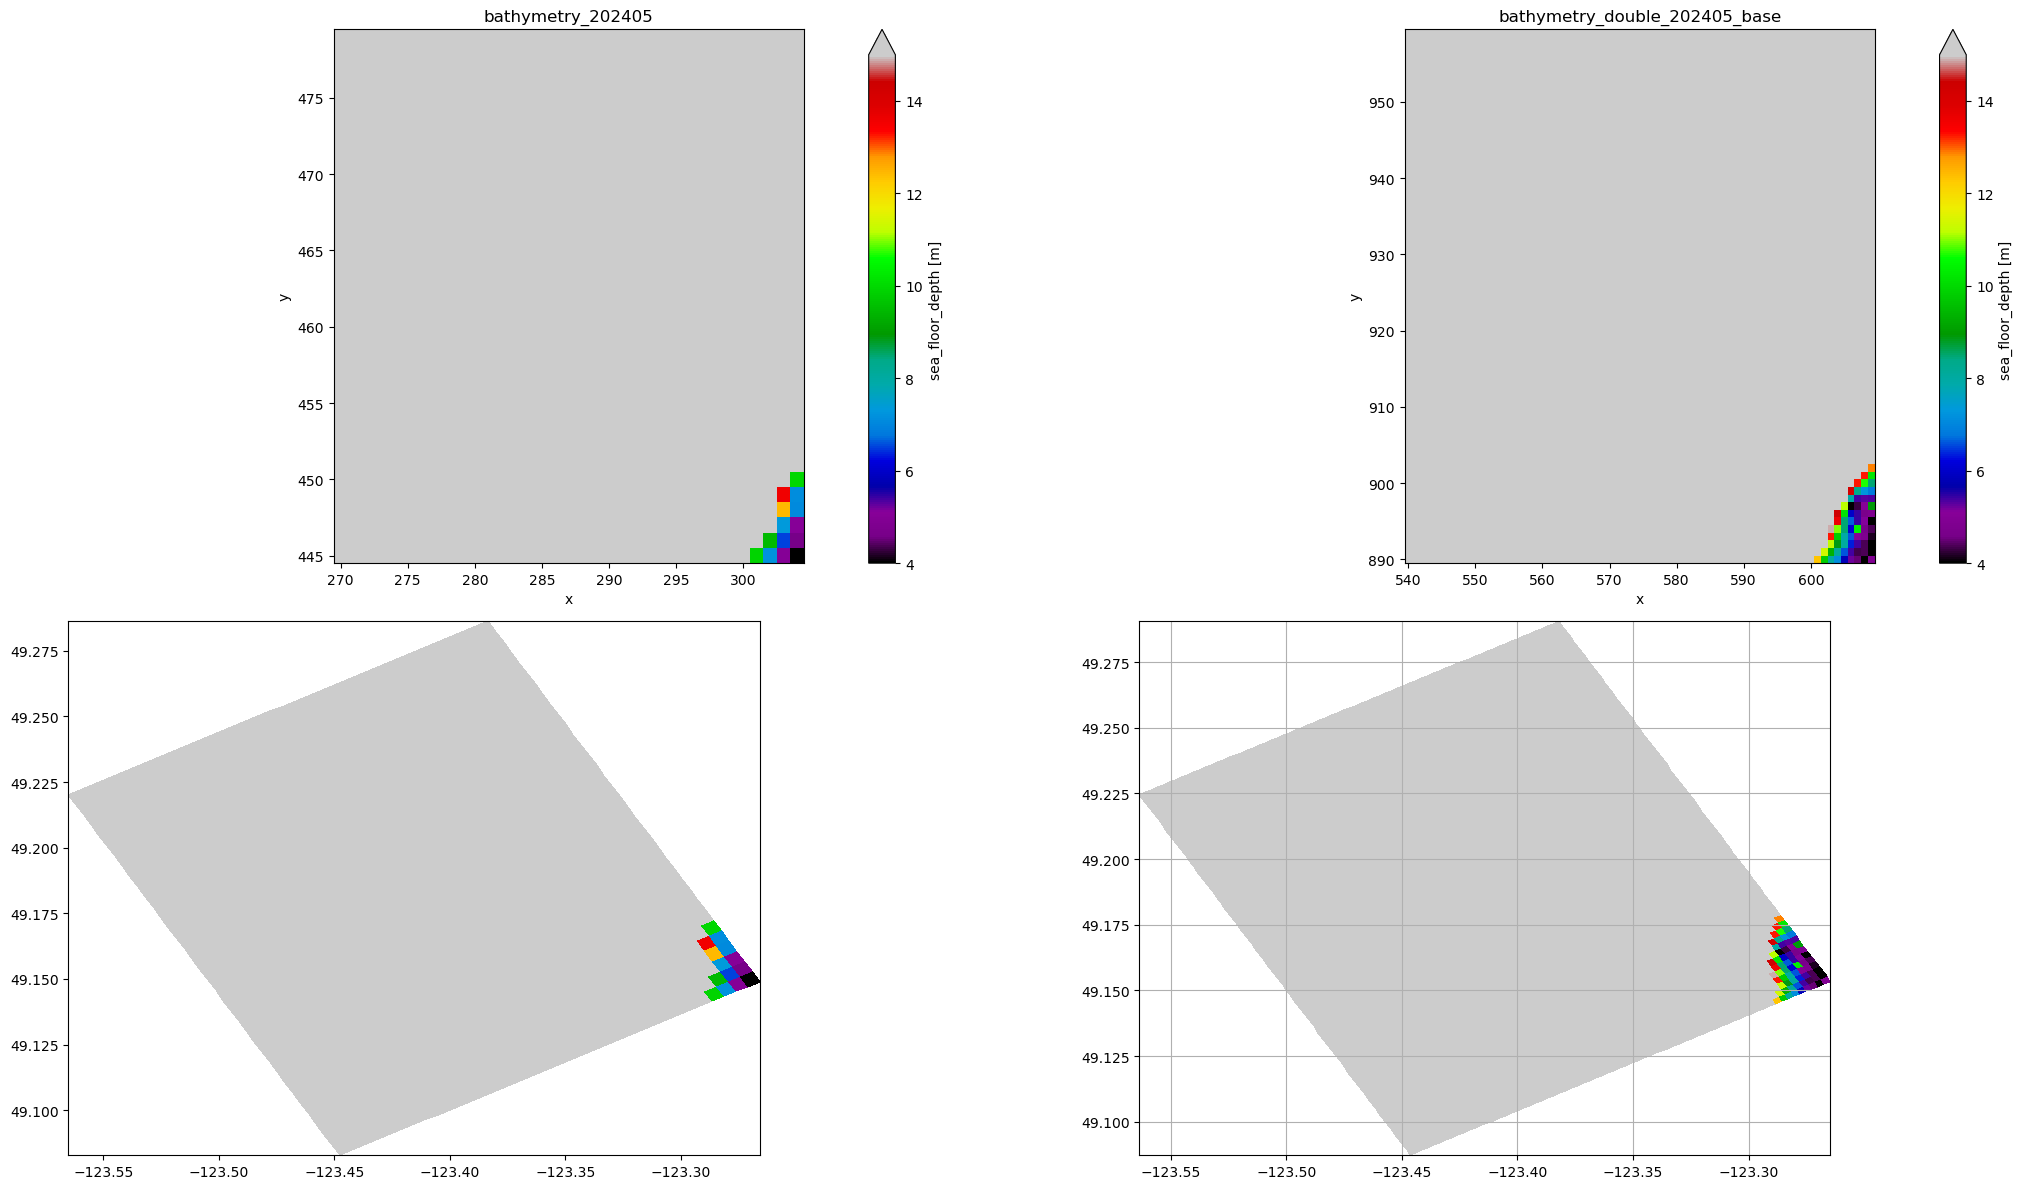

In [72]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base);

### Tile 14, 10 - Lulu Island and Point Grey

* connect Fraser River North Arm spit

/tmp/ipykernel_846180/1784615056.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_846180/1784615056.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_846180/1784615056.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. 

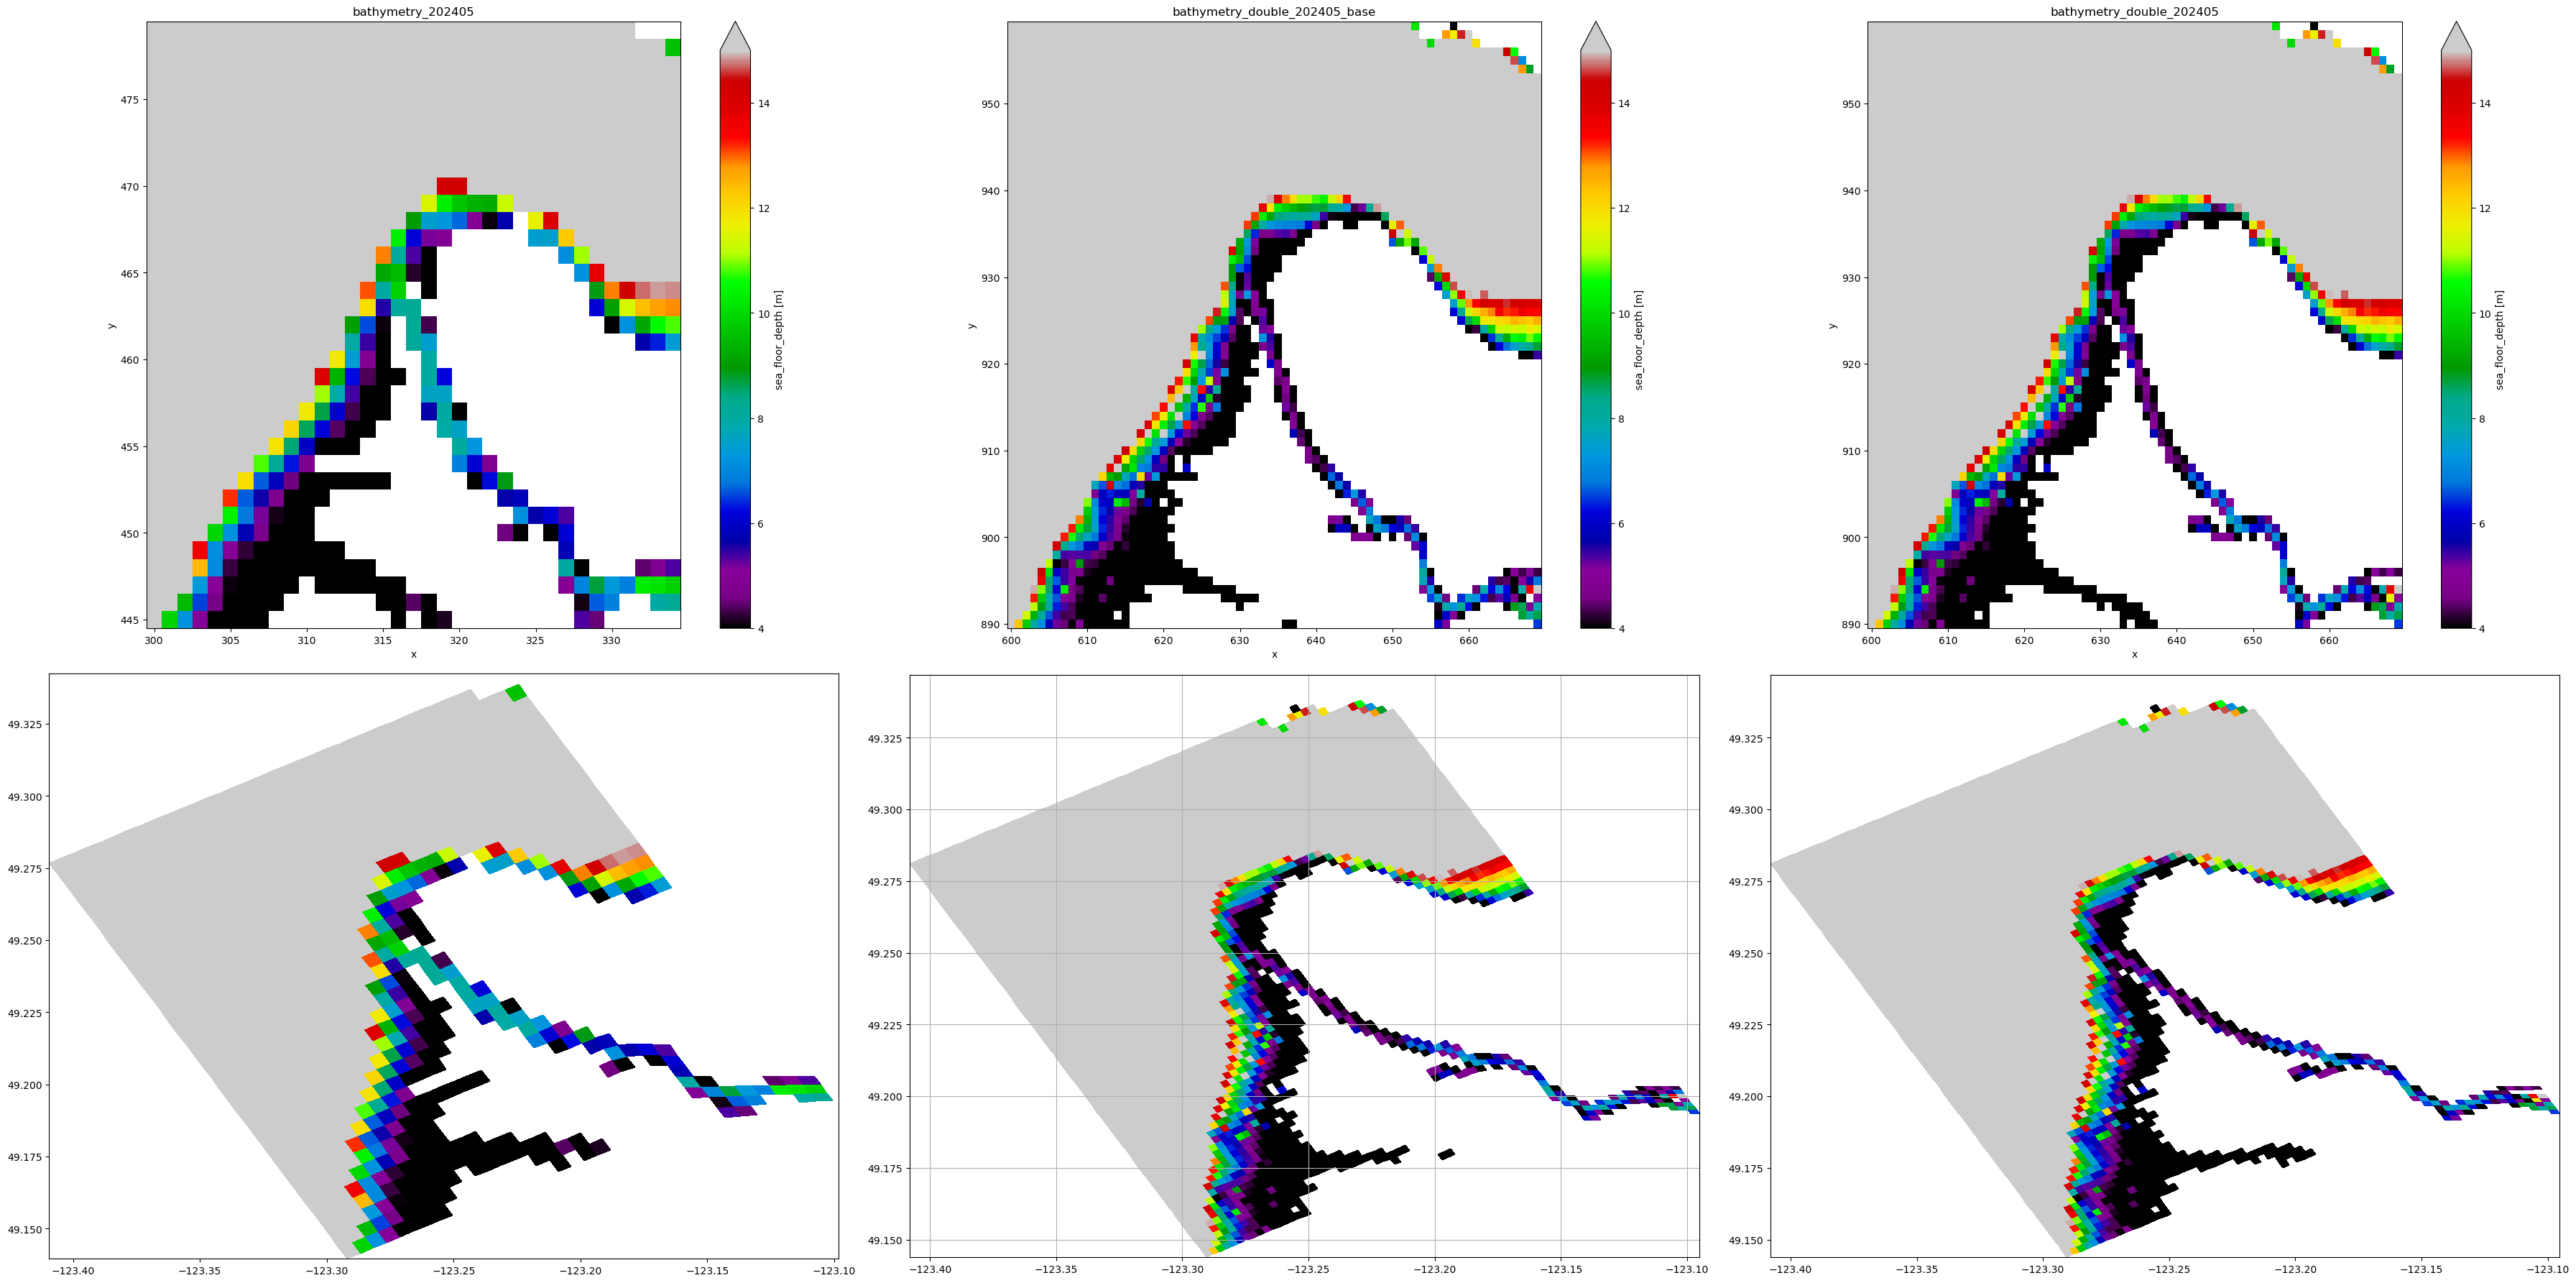

In [74]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base, dbl_bathy);

### Tile 14, 11 - English Bay

/tmp/ipykernel_721922/1784615056.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_721922/1784615056.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)


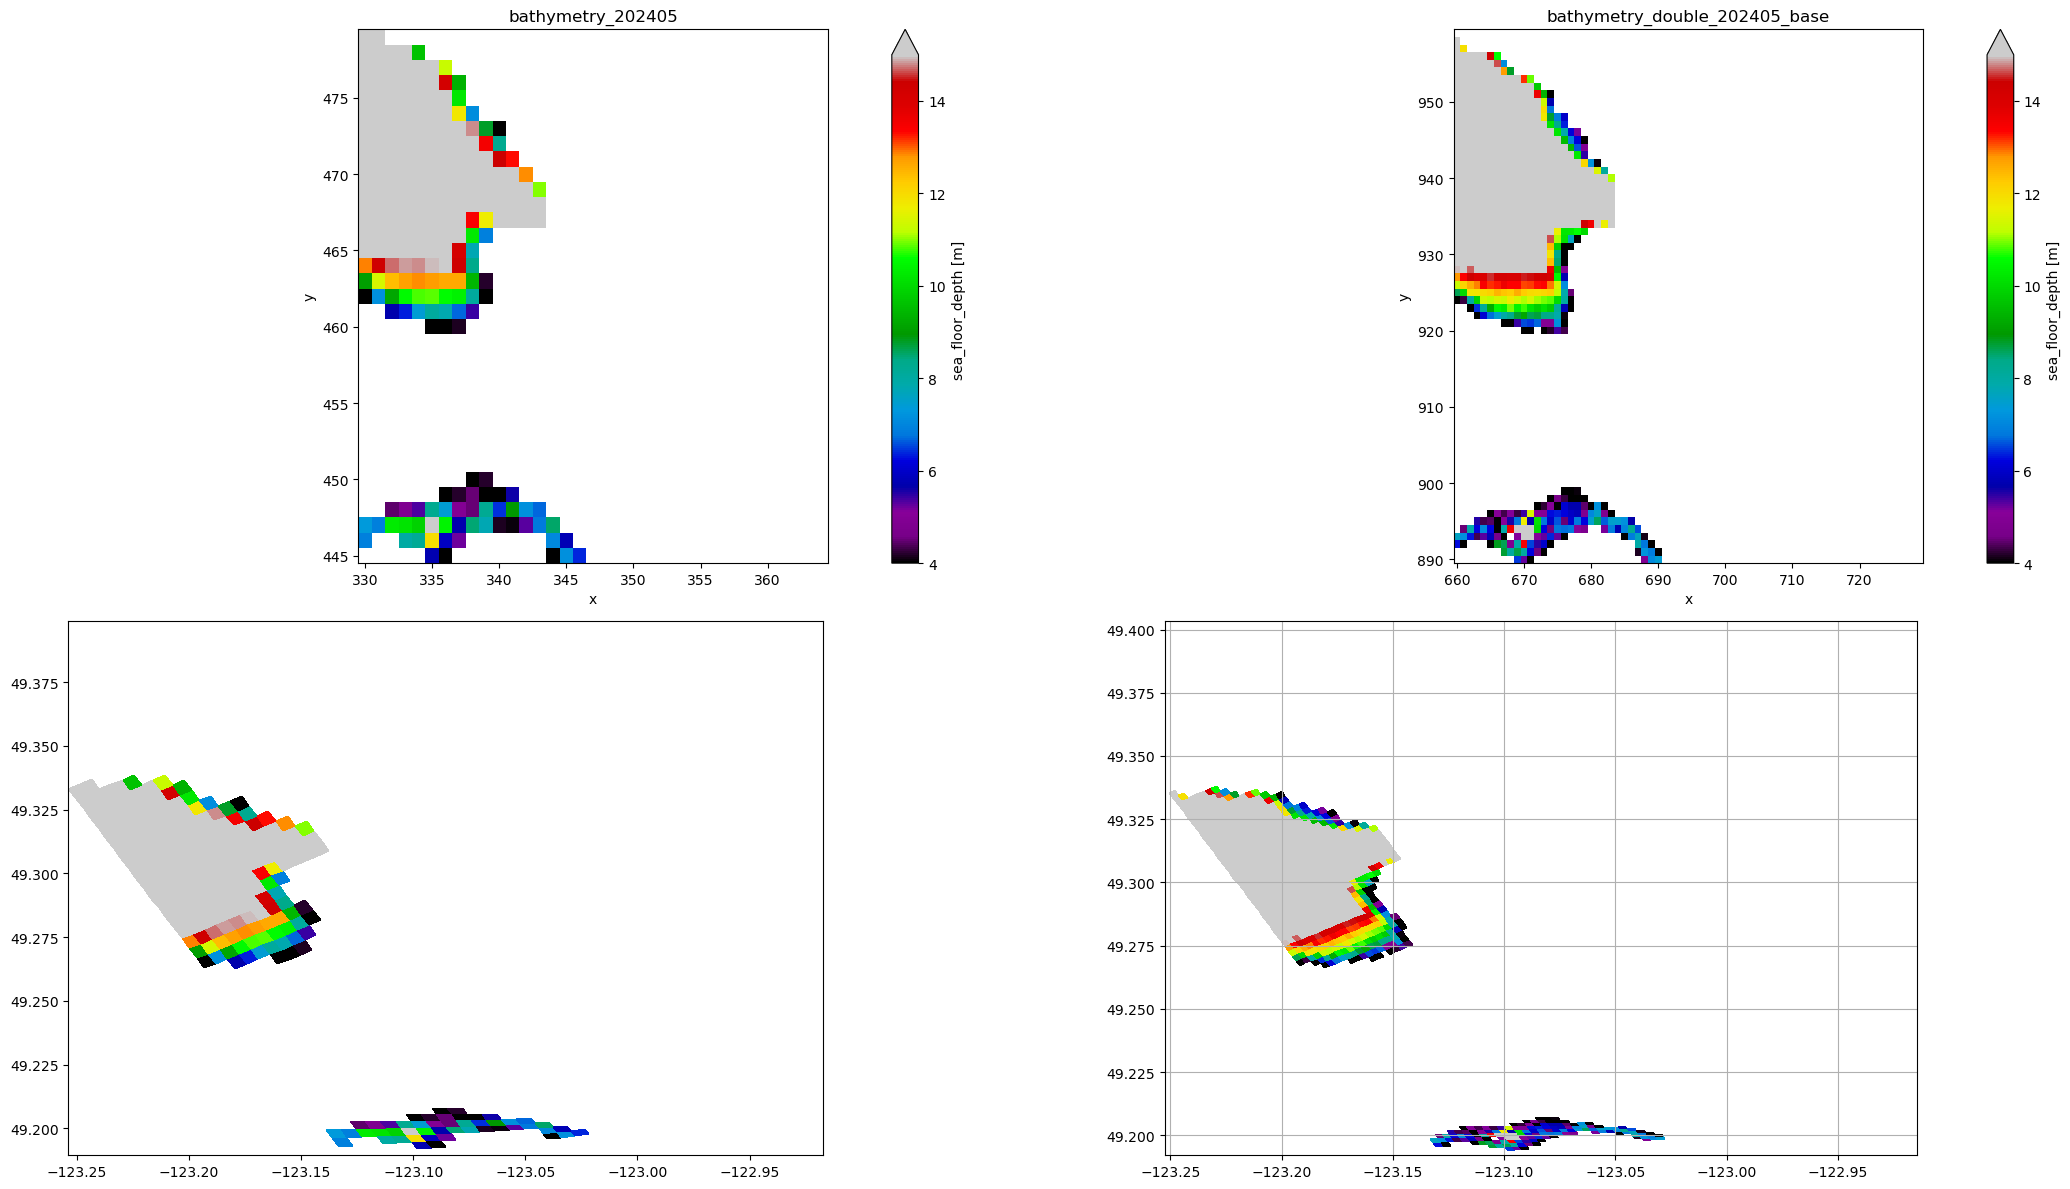

In [74]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base);

### Tile 14, 12

* all land

In [75]:
bathy.close()
dbl_bathy_base.close()
dbl_bathy.close()